# The weather dataset
This tutorial uses a [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext tensorboard


In [2]:
import tensorflow as tf
import datetime

from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)



In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [4]:
%%time
df = data_proc()

Wall time: 1.16 s


In [5]:
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [6]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

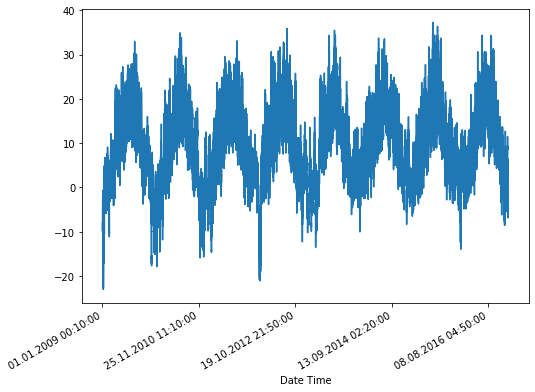

In [8]:
uni_data.plot(subplots=True);

In [9]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

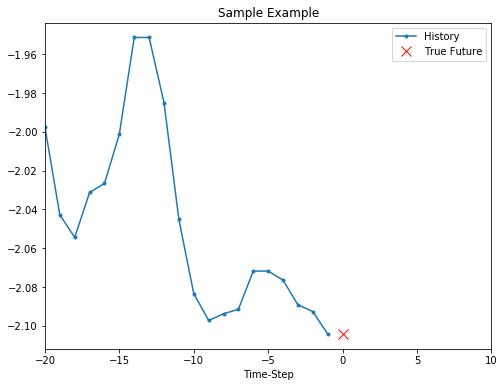

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

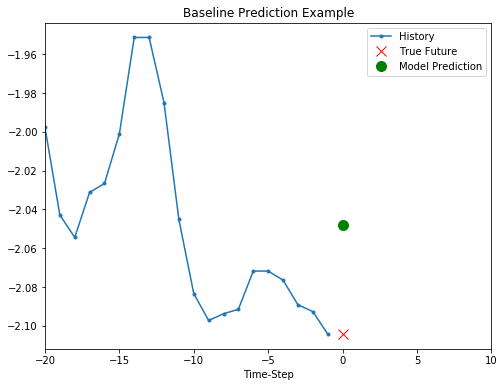

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [12]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00

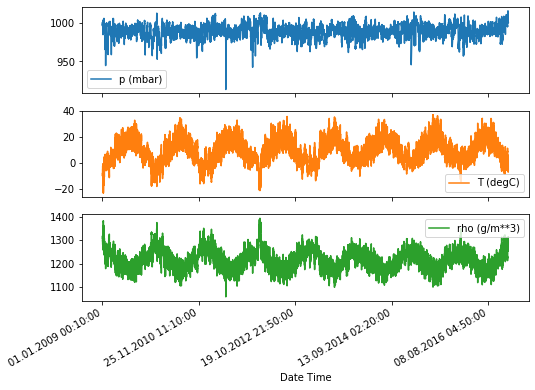

In [13]:
features.plot(subplots=True);

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [15]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [16]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [17]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=10)



Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - ETA: 12:09 - loss: 1.13 - ETA: 2:00 - loss: 0.9627 - ETA: 1:04 - loss: 0.795 - ETA: 43s - loss: 0.663 - ETA: 33s - loss: 0.59 - ETA: 26s - loss: 0.55 - ETA: 20s - loss: 0.52 - ETA: 17s - loss: 0.49 - ETA: 14s - loss: 0.47 - ETA: 12s - loss: 0.45 - ETA: 10s - loss: 0.44 - ETA: 9s - loss: 0.4373 - ETA: 8s - loss: 0.426 - ETA: 7s - loss: 0.415 - ETA: 6s - loss: 0.406 - ETA: 6s - loss: 0.396 - ETA: 5s - loss: 0.388 - ETA: 4s - loss: 0.381 - ETA: 4s - loss: 0.376 - ETA: 4s - loss: 0.370 - ETA: 3s - loss: 0.365 - ETA: 3s - loss: 0.361 - ETA: 2s - loss: 0.358 - ETA: 2s - loss: 0.354 - ETA: 2s - loss: 0.350 - ETA: 2s - loss: 0.346 - ETA: 1s - loss: 0.342 - ETA: 1s - loss: 0.339 - ETA: 1s - loss: 0.336 - ETA: 1s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 6s 32ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2

200/200 [==============================] - ETA: 2s - loss: 0.263 - ETA: 1s - loss: 0.259 - ETA: 1s - loss: 0.260 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.249 - ETA: 1s - loss: 0.249 - ETA: 1s - loss: 0.247 - ETA: 1s - loss: 0.246 - ETA: 1s - loss: 0.246 - ETA: 1s - loss: 0.246 - ETA: 1s - loss: 0.246 - ETA: 1s - loss: 0.246 - ETA: 0s - loss: 0.246 - ETA: 0s - loss: 0.246 - ETA: 0s - loss: 0.246 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.248 - ETA: 0s - loss: 0.248 - ETA: 0s - loss: 0.248 - ETA: 0s - loss: 0.248 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.247 - ETA: 0s - loss: 0.246 - ETA: 0s - loss: 0.246 - 2s 12ms/step - loss: 0.2467 - val_loss: 0.2458
Epoch 10/10
200/200 [==============================] - ETA: 1s - loss: 0.275 - ETA: 1s - loss:

# Plot first 3 predictions
Use validation data for predictions

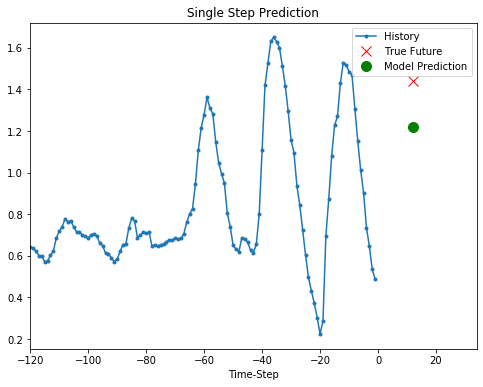

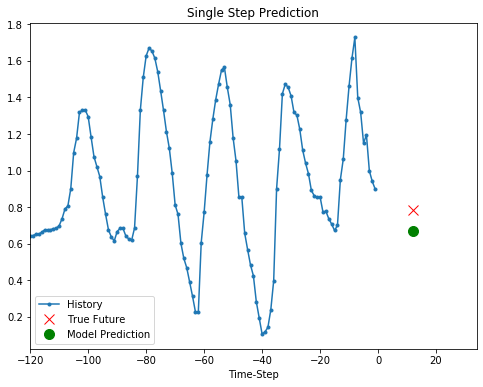

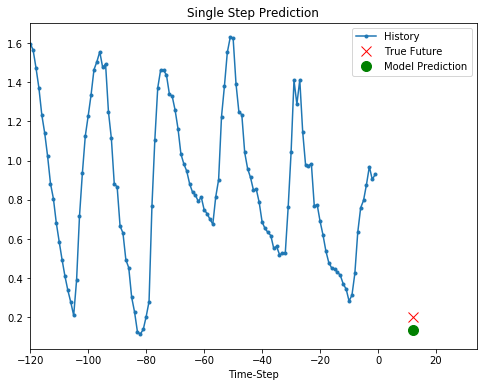

In [18]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

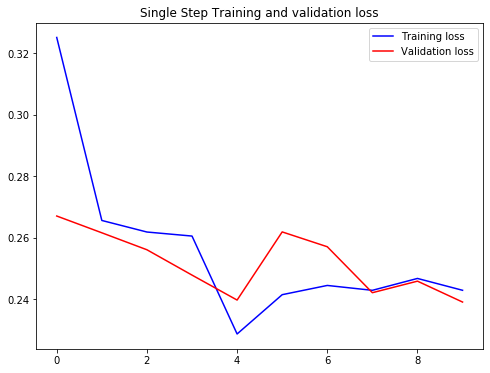

In [20]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [21]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband


hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    #max_trials=40,
    directory='hyperband',
    project_name='helloworld_hyperband', 
    max_epochs=10)



tuner.search(x_train_single,
             y_train_single, 
             epochs=10, 
             validation_data=(x_val_single, y_val_single))

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 35392/299280 [==>...........................] - ETA: 5:09:29 - loss: 0.6144 - mae: 0.61 - ETA: 52:58 - loss: 0.6621 - mae: 0.6621 - ETA: 29:40 - loss: 0.6547 - mae: 0.65 - ETA: 20:54 - loss: 0.6235 - mae: 0.62 - ETA: 16:18 - loss: 0.6057 - mae: 0.60 - ETA: 13:01 - loss: 0.5763 - mae: 0.57 - ETA: 11:13 - loss: 0.5563 - mae: 0.55 - ETA: 9:55 - loss: 0.5407 - mae: 0.5407 - ETA: 8:44 - loss: 0.5215 - mae: 0.521 - ETA: 7:50 - loss: 0.5044 - mae: 0.504 - ETA: 7:08 - loss: 0.4910 - mae: 0.491 - ETA: 6:41 - loss: 0.4810 - mae: 0.481 - ETA: 6:17 - loss: 0.4737 - mae: 0.473 - ETA: 5:57 - loss: 0.4669 - mae: 0.466 - ETA: 5:36 - loss: 0.4605 - mae: 0.460 - ETA: 5:21 - loss: 0.4556 - mae: 0.455 - ETA: 5:07 - loss: 0.4491 - mae: 0.449 - ETA: 4:55 - loss: 0.4423 - mae: 0.442 - ETA: 4:45 - loss: 0.4384 - mae: 0.438 - ETA: 4:35 - loss: 0.4351 - mae: 0.435 - ETA: 4:27 - loss: 0.4323 - mae: 0.432 - ETA: 4:17 - loss: 0.4282 - mae: 0.428 - ETA: 4:08 - loss: 0.4245 - mae: 0.424 - ETA: 4:02 - loss: 0.4215 -

 71904/299280 [======>.......................] - ETA: 1:37 - loss: 0.3018 - mae: 0.301 - ETA: 1:36 - loss: 0.3015 - mae: 0.301 - ETA: 1:36 - loss: 0.3013 - mae: 0.301 - ETA: 1:36 - loss: 0.3012 - mae: 0.301 - ETA: 1:36 - loss: 0.3011 - mae: 0.301 - ETA: 1:36 - loss: 0.3010 - mae: 0.301 - ETA: 1:36 - loss: 0.3008 - mae: 0.300 - ETA: 1:36 - loss: 0.3008 - mae: 0.300 - ETA: 1:35 - loss: 0.3008 - mae: 0.300 - ETA: 1:35 - loss: 0.3006 - mae: 0.300 - ETA: 1:35 - loss: 0.3003 - mae: 0.300 - ETA: 1:35 - loss: 0.3003 - mae: 0.300 - ETA: 1:35 - loss: 0.3000 - mae: 0.300 - ETA: 1:35 - loss: 0.2998 - mae: 0.299 - ETA: 1:35 - loss: 0.2997 - mae: 0.299 - ETA: 1:34 - loss: 0.2994 - mae: 0.299 - ETA: 1:34 - loss: 0.2992 - mae: 0.299 - ETA: 1:34 - loss: 0.2991 - mae: 0.299 - ETA: 1:34 - loss: 0.2990 - mae: 0.299 - ETA: 1:34 - loss: 0.2988 - mae: 0.298 - ETA: 1:34 - loss: 0.2987 - mae: 0.298 - ETA: 1:34 - loss: 0.2986 - mae: 0.298 - ETA: 1:33 - loss: 0.2984 - mae: 0.298 - ETA: 1:33 - loss: 0.2983 - mae:

109952/299280 [==========>...................] - ETA: 1:17 - loss: 0.2821 - mae: 0.282 - ETA: 1:16 - loss: 0.2821 - mae: 0.282 - ETA: 1:16 - loss: 0.2820 - mae: 0.282 - ETA: 1:16 - loss: 0.2819 - mae: 0.281 - ETA: 1:16 - loss: 0.2818 - mae: 0.281 - ETA: 1:16 - loss: 0.2818 - mae: 0.281 - ETA: 1:16 - loss: 0.2817 - mae: 0.281 - ETA: 1:16 - loss: 0.2816 - mae: 0.281 - ETA: 1:16 - loss: 0.2816 - mae: 0.281 - ETA: 1:16 - loss: 0.2815 - mae: 0.281 - ETA: 1:16 - loss: 0.2815 - mae: 0.281 - ETA: 1:16 - loss: 0.2815 - mae: 0.281 - ETA: 1:16 - loss: 0.2814 - mae: 0.281 - ETA: 1:15 - loss: 0.2814 - mae: 0.281 - ETA: 1:15 - loss: 0.2814 - mae: 0.281 - ETA: 1:15 - loss: 0.2814 - mae: 0.281 - ETA: 1:15 - loss: 0.2813 - mae: 0.281 - ETA: 1:15 - loss: 0.2813 - mae: 0.281 - ETA: 1:15 - loss: 0.2812 - mae: 0.281 - ETA: 1:15 - loss: 0.2812 - mae: 0.281 - ETA: 1:15 - loss: 0.2812 - mae: 0.281 - ETA: 1:15 - loss: 0.2811 - mae: 0.281 - ETA: 1:15 - loss: 0.2810 - mae: 0.281 - ETA: 1:15 - loss: 0.2809 - mae:

148928/299280 [=============>................] - ETA: 1:01 - loss: 0.2725 - mae: 0.272 - ETA: 1:01 - loss: 0.2725 - mae: 0.272 - ETA: 1:01 - loss: 0.2725 - mae: 0.272 - ETA: 1:01 - loss: 0.2724 - mae: 0.272 - ETA: 1:01 - loss: 0.2724 - mae: 0.272 - ETA: 1:01 - loss: 0.2724 - mae: 0.272 - ETA: 1:01 - loss: 0.2724 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:01 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2723 - mae: 0.272 - ETA: 1:00 - loss: 0.2722 - mae: 0.272 - ETA: 1:00 - loss: 0.2722 - mae: 0.272 - ETA: 1:00 - loss: 0.2722 - mae: 0.272 - ETA: 1:00 - loss: 0.2722 - mae: 0.272 - ETA: 1:00 - loss: 0.2722 - mae:

188960/299280 [=================>............] - ETA: 48s - loss: 0.2673 - mae: 0.26 - ETA: 48s - loss: 0.2673 - mae: 0.26 - ETA: 48s - loss: 0.2673 - mae: 0.26 - ETA: 48s - loss: 0.2672 - mae: 0.26 - ETA: 48s - loss: 0.2672 - mae: 0.26 - ETA: 48s - loss: 0.2672 - mae: 0.26 - ETA: 48s - loss: 0.2672 - mae: 0.26 - ETA: 48s - loss: 0.2672 - mae: 0.26 - ETA: 47s - loss: 0.2671 - mae: 0.26 - ETA: 47s - loss: 0.2671 - mae: 0.26 - ETA: 47s - loss: 0.2671 - mae: 0.26 - ETA: 47s - loss: 0.2671 - mae: 0.26 - ETA: 47s - loss: 0.2671 - mae: 0.26 - ETA: 47s - loss: 0.2670 - mae: 0.26 - ETA: 47s - loss: 0.2670 - mae: 0.26 - ETA: 47s - loss: 0.2670 - mae: 0.26 - ETA: 47s - loss: 0.2670 - mae: 0.26 - ETA: 47s - loss: 0.2670 - mae: 0.26 - ETA: 47s - loss: 0.2669 - mae: 0.26 - ETA: 47s - loss: 0.2669 - mae: 0.26 - ETA: 47s - loss: 0.2669 - mae: 0.26 - ETA: 47s - loss: 0.2669 - mae: 0.26 - ETA: 47s - loss: 0.2668 - mae: 0.26 - ETA: 46s - loss: 0.2668 - mae: 0.26 - ETA: 46s - loss: 0.2667 - mae: 0.26 - E

229056/299280 [=====================>........] - ETA: 35s - loss: 0.2635 - mae: 0.26 - ETA: 35s - loss: 0.2635 - mae: 0.26 - ETA: 34s - loss: 0.2635 - mae: 0.26 - ETA: 34s - loss: 0.2634 - mae: 0.26 - ETA: 34s - loss: 0.2634 - mae: 0.26 - ETA: 34s - loss: 0.2634 - mae: 0.26 - ETA: 34s - loss: 0.2634 - mae: 0.26 - ETA: 34s - loss: 0.2634 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 34s - loss: 0.2633 - mae: 0.26 - ETA: 33s - loss: 0.2633 - mae: 0.26 - ETA: 33s - loss: 0.2633 - mae: 0.26 - ETA: 33s - loss: 0.2633 - mae: 0.26 - ETA: 33s - loss: 0.2633 - mae: 0.26 - ETA: 33s - loss: 0.2632 - mae: 0.26 - ETA: 33s - loss: 0.2632 - mae: 0.26 - E

269056/299280 [=========================>....] - ETA: 22s - loss: 0.2605 - mae: 0.26 - ETA: 22s - loss: 0.2605 - mae: 0.26 - ETA: 22s - loss: 0.2605 - mae: 0.26 - ETA: 21s - loss: 0.2605 - mae: 0.26 - ETA: 21s - loss: 0.2605 - mae: 0.26 - ETA: 21s - loss: 0.2605 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2604 - mae: 0.26 - ETA: 21s - loss: 0.2603 - mae: 0.26 - ETA: 21s - loss: 0.2603 - mae: 0.26 - ETA: 21s - loss: 0.2603 - mae: 0.26 - ETA: 21s - loss: 0.2603 - mae: 0.26 - ETA: 21s - loss: 0.2603 - mae: 0.26 - ETA: 21s - loss: 0.2602 - mae: 0.26 - ETA: 21s - loss: 0.2602 - mae: 0.26 - ETA: 21s - loss: 0.2602 - mae: 0.26 - ETA: 20s - loss: 0.2602 - mae: 0.26 - ETA: 20s - loss: 0.2602 - mae: 0.26 - ETA: 20s - loss: 0.2602 - mae: 0.26 - ETA: 20s - loss: 0.2602 - mae: 0.26 - ETA: 20s - loss: 0.2602 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2585 - mae: 0.258 - ETA: 9s - loss: 0.2585 - mae: 0.258 - ETA: 9s - loss: 0.2585 - mae: 0.258 - ETA: 9s - loss: 0.2585 - mae: 0.258 - ETA: 9s - loss: 0.2585 - mae: 0.258 - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - E

 34816/299280 [==>...........................] - ETA: 2:10 - loss: 0.2771 - mae: 0.277 - ETA: 1:51 - loss: 0.2434 - mae: 0.243 - ETA: 1:41 - loss: 0.2377 - mae: 0.237 - ETA: 1:40 - loss: 0.2315 - mae: 0.231 - ETA: 1:39 - loss: 0.2451 - mae: 0.245 - ETA: 1:39 - loss: 0.2439 - mae: 0.243 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:38 - loss: 0.2418 - mae: 0.241 - ETA: 1:37 - loss: 0.2411 - mae: 0.241 - ETA: 1:37 - loss: 0.2414 - mae: 0.241 - ETA: 1:37 - loss: 0.2435 - mae: 0.243 - ETA: 1:37 - loss: 0.2414 - mae: 0.241 - ETA: 1:37 - loss: 0.2415 - mae: 0.241 - ETA: 1:37 - loss: 0.2395 - mae: 0.239 - ETA: 1:37 - loss: 0.2408 - mae: 0.240 - ETA: 1:37 - loss: 0.2418 - mae: 0.241 - ETA: 1:36 - loss: 0.2409 - mae: 0.240 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2414 - mae: 0.241 - ETA: 1:36 - loss: 0.2418 - mae: 0.241 - ETA: 1:36 - loss: 0.2417 - mae: 0.241 - ETA: 1:36 - loss: 0.2413 - mae: 0.241 - ETA: 1:36 - loss: 0.2410 - mae: 0.241 - ETA: 1:36 - loss: 0.2408 - mae:

 71616/299280 [======>.......................] - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2442 - mae: 0.244 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2439 - mae: 0.243 - ETA: 1:23 - loss: 0.2440 - mae: 0.244 - ETA: 1:23 - loss: 0.2440 - mae: 0.244 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2442 - mae: 0.244 - ETA: 1:23 - loss: 0.2443 - mae: 0.244 - ETA: 1:22 - loss: 0.2442 - mae: 0.244 - ETA: 1:22 - loss: 0.2443 - mae: 0.244 - ETA: 1:22 - loss: 0.2442 - mae: 0.244 - ETA: 1:22 - loss: 0.2442 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2440 - mae: 0.244 - ETA: 1:22 - loss: 0.2439 - mae: 0.243 - ETA: 1:22 - loss: 0.2439 - mae:

107872/299280 [=========>....................] - ETA: 1:11 - loss: 0.2438 - mae: 0.243 - ETA: 1:11 - loss: 0.2439 - mae: 0.243 - ETA: 1:11 - loss: 0.2438 - mae: 0.243 - ETA: 1:11 - loss: 0.2438 - mae: 0.243 - ETA: 1:11 - loss: 0.2438 - mae: 0.243 - ETA: 1:11 - loss: 0.2438 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2438 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2438 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2437 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:10 - loss: 0.2436 - mae: 0.243 - ETA: 1:09 - loss: 0.2436 - mae:

146432/299280 [=============>................] - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2434 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 59s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2434 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - ETA: 58s - loss: 0.2433 - mae: 0.24 - E

184384/299280 [=================>............] - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 47s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2425 - mae: 0.24 - ETA: 46s - loss: 0.2425 - mae: 0.24 - ETA: 46s - loss: 0.2425 - mae: 0.24 - ETA: 46s - loss: 0.2425 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - ETA: 46s - loss: 0.2424 - mae: 0.24 - E

222528/299280 [=====================>........] - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2422 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 35s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - ETA: 34s - loss: 0.2421 - mae: 0.24 - E

261824/299280 [=========================>....] - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 23s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - ETA: 22s - loss: 0.2415 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - ETA: 10s - loss: 0.2412 - mae: 0.24 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32384/299280 [==>...........................] - ETA: 4:16:38 - loss: 0.6660 - mae: 0.66 - ETA: 44:13 - loss: 0.6885 - mae: 0.6885 - ETA: 24:56 - loss: 0.6627 - mae: 0.66 - ETA: 17:43 - loss: 0.6134 - mae: 0.61 - ETA: 13:54 - loss: 0.5778 - mae: 0.57 - ETA: 11:34 - loss: 0.5410 - mae: 0.54 - ETA: 9:58 - loss: 0.5088 - mae: 0.5088 - ETA: 8:49 - loss: 0.4901 - mae: 0.490 - ETA: 7:56 - loss: 0.4730 - mae: 0.473 - ETA: 7:15 - loss: 0.4602 - mae: 0.460 - ETA: 6:42 - loss: 0.4507 - mae: 0.450 - ETA: 6:15 - loss: 0.4428 - mae: 0.442 - ETA: 5:53 - loss: 0.4348 - mae: 0.434 - ETA: 5:33 - loss: 0.4291 - mae: 0.429 - ETA: 5:17 - loss: 0.4255 - mae: 0.425 - ETA: 5:02 - loss: 0.4218 - mae: 0.421 - ETA: 4:49 - loss: 0.4183 - mae: 0.418 - ETA: 4:38 - loss: 0.4135 - mae: 0.413 - ETA: 4:28 - loss: 0.4079 - mae: 0.407 - ETA: 4:19 - loss: 0.4049 - mae: 0.404 - ETA: 4:11 - loss: 0.4028 - mae: 0.402 - ETA: 4:03 - loss: 0.4004 - mae: 0.400 - ETA: 3:56 - loss: 0.3981 - mae: 0.398 - ETA: 3:50 - loss: 0.3948 -

 65568/299280 [=====>........................] - ETA: 1:40 - loss: 0.2982 - mae: 0.298 - ETA: 1:40 - loss: 0.2980 - mae: 0.298 - ETA: 1:40 - loss: 0.2979 - mae: 0.297 - ETA: 1:40 - loss: 0.2978 - mae: 0.297 - ETA: 1:39 - loss: 0.2976 - mae: 0.297 - ETA: 1:39 - loss: 0.2976 - mae: 0.297 - ETA: 1:39 - loss: 0.2974 - mae: 0.297 - ETA: 1:39 - loss: 0.2972 - mae: 0.297 - ETA: 1:39 - loss: 0.2970 - mae: 0.297 - ETA: 1:39 - loss: 0.2968 - mae: 0.296 - ETA: 1:39 - loss: 0.2969 - mae: 0.296 - ETA: 1:38 - loss: 0.2969 - mae: 0.296 - ETA: 1:38 - loss: 0.2967 - mae: 0.296 - ETA: 1:38 - loss: 0.2968 - mae: 0.296 - ETA: 1:38 - loss: 0.2968 - mae: 0.296 - ETA: 1:38 - loss: 0.2966 - mae: 0.296 - ETA: 1:38 - loss: 0.2965 - mae: 0.296 - ETA: 1:38 - loss: 0.2965 - mae: 0.296 - ETA: 1:38 - loss: 0.2965 - mae: 0.296 - ETA: 1:38 - loss: 0.2964 - mae: 0.296 - ETA: 1:37 - loss: 0.2962 - mae: 0.296 - ETA: 1:37 - loss: 0.2960 - mae: 0.296 - ETA: 1:37 - loss: 0.2960 - mae: 0.296 - ETA: 1:37 - loss: 0.2959 - mae:

 98464/299280 [========>.....................] - ETA: 1:22 - loss: 0.2815 - mae: 0.281 - ETA: 1:22 - loss: 0.2814 - mae: 0.281 - ETA: 1:22 - loss: 0.2814 - mae: 0.281 - ETA: 1:22 - loss: 0.2812 - mae: 0.281 - ETA: 1:22 - loss: 0.2812 - mae: 0.281 - ETA: 1:21 - loss: 0.2811 - mae: 0.281 - ETA: 1:21 - loss: 0.2810 - mae: 0.281 - ETA: 1:21 - loss: 0.2809 - mae: 0.280 - ETA: 1:21 - loss: 0.2808 - mae: 0.280 - ETA: 1:21 - loss: 0.2808 - mae: 0.280 - ETA: 1:21 - loss: 0.2808 - mae: 0.280 - ETA: 1:21 - loss: 0.2807 - mae: 0.280 - ETA: 1:21 - loss: 0.2807 - mae: 0.280 - ETA: 1:21 - loss: 0.2807 - mae: 0.280 - ETA: 1:21 - loss: 0.2806 - mae: 0.280 - ETA: 1:21 - loss: 0.2806 - mae: 0.280 - ETA: 1:21 - loss: 0.2805 - mae: 0.280 - ETA: 1:21 - loss: 0.2805 - mae: 0.280 - ETA: 1:21 - loss: 0.2804 - mae: 0.280 - ETA: 1:20 - loss: 0.2804 - mae: 0.280 - ETA: 1:20 - loss: 0.2803 - mae: 0.280 - ETA: 1:20 - loss: 0.2803 - mae: 0.280 - ETA: 1:20 - loss: 0.2801 - mae: 0.280 - ETA: 1:20 - loss: 0.2800 - mae:

132128/299280 [============>.................] - ETA: 1:08 - loss: 0.2724 - mae: 0.272 - ETA: 1:08 - loss: 0.2723 - mae: 0.272 - ETA: 1:08 - loss: 0.2723 - mae: 0.272 - ETA: 1:08 - loss: 0.2722 - mae: 0.272 - ETA: 1:08 - loss: 0.2722 - mae: 0.272 - ETA: 1:08 - loss: 0.2722 - mae: 0.272 - ETA: 1:08 - loss: 0.2721 - mae: 0.272 - ETA: 1:08 - loss: 0.2721 - mae: 0.272 - ETA: 1:08 - loss: 0.2721 - mae: 0.272 - ETA: 1:08 - loss: 0.2721 - mae: 0.272 - ETA: 1:08 - loss: 0.2720 - mae: 0.272 - ETA: 1:08 - loss: 0.2720 - mae: 0.272 - ETA: 1:08 - loss: 0.2720 - mae: 0.272 - ETA: 1:08 - loss: 0.2720 - mae: 0.272 - ETA: 1:08 - loss: 0.2719 - mae: 0.271 - ETA: 1:08 - loss: 0.2719 - mae: 0.271 - ETA: 1:07 - loss: 0.2719 - mae: 0.271 - ETA: 1:07 - loss: 0.2718 - mae: 0.271 - ETA: 1:07 - loss: 0.2718 - mae: 0.271 - ETA: 1:07 - loss: 0.2717 - mae: 0.271 - ETA: 1:07 - loss: 0.2717 - mae: 0.271 - ETA: 1:07 - loss: 0.2717 - mae: 0.271 - ETA: 1:07 - loss: 0.2717 - mae: 0.271 - ETA: 1:07 - loss: 0.2717 - mae:

166688/299280 [===============>..............] - ETA: 56s - loss: 0.2676 - mae: 0.26 - ETA: 56s - loss: 0.2676 - mae: 0.26 - ETA: 56s - loss: 0.2676 - mae: 0.26 - ETA: 56s - loss: 0.2676 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 56s - loss: 0.2675 - mae: 0.26 - ETA: 55s - loss: 0.2674 - mae: 0.26 - ETA: 55s - loss: 0.2674 - mae: 0.26 - ETA: 55s - loss: 0.2674 - mae: 0.26 - ETA: 55s - loss: 0.2674 - mae: 0.26 - ETA: 55s - loss: 0.2674 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - ETA: 55s - loss: 0.2673 - mae: 0.26 - E

201344/299280 [===================>..........] - ETA: 44s - loss: 0.2637 - mae: 0.26 - ETA: 44s - loss: 0.2637 - mae: 0.26 - ETA: 44s - loss: 0.2637 - mae: 0.26 - ETA: 44s - loss: 0.2637 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 44s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2636 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2634 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - ETA: 43s - loss: 0.2635 - mae: 0.26 - E

236128/299280 [======================>.......] - ETA: 32s - loss: 0.2612 - mae: 0.26 - ETA: 32s - loss: 0.2612 - mae: 0.26 - ETA: 32s - loss: 0.2612 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2611 - mae: 0.26 - ETA: 32s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2611 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2611 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - ETA: 31s - loss: 0.2610 - mae: 0.26 - E

271232/299280 [==========================>...] - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2587 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 20s - loss: 0.2586 - mae: 0.25 - ETA: 19s - loss: 0.2586 - mae: 0.25 - ETA: 19s - loss: 0.2586 - mae: 0.25 - ETA: 19s - loss: 0.2586 - mae: 0.25 - ETA: 19s - loss: 0.2586 - mae: 0.25 - ETA: 19s - loss: 0.2585 - mae: 0.25 - ETA: 19s - loss: 0.2585 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2572 - mae: 0.257 - ETA: 9s - loss: 0.2572 - mae: 0.257 - ETA: 9s - loss: 0.2572 - mae: 0.257 - ETA: 9s - loss: 0.2572 - mae: 0.257 - ETA: 9s - loss: 0.2571 - mae: 0.257 - ETA: 9s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2571 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - ETA: 8s - loss: 0.2570 - mae: 0.257 - E

 32608/299280 [==>...........................] - ETA: 2:01 - loss: 0.2811 - mae: 0.281 - ETA: 1:59 - loss: 0.2504 - mae: 0.250 - ETA: 1:53 - loss: 0.2456 - mae: 0.245 - ETA: 1:51 - loss: 0.2310 - mae: 0.231 - ETA: 1:50 - loss: 0.2392 - mae: 0.239 - ETA: 1:49 - loss: 0.2436 - mae: 0.243 - ETA: 1:48 - loss: 0.2436 - mae: 0.243 - ETA: 1:48 - loss: 0.2445 - mae: 0.244 - ETA: 1:47 - loss: 0.2401 - mae: 0.240 - ETA: 1:46 - loss: 0.2423 - mae: 0.242 - ETA: 1:46 - loss: 0.2435 - mae: 0.243 - ETA: 1:45 - loss: 0.2418 - mae: 0.241 - ETA: 1:45 - loss: 0.2418 - mae: 0.241 - ETA: 1:44 - loss: 0.2398 - mae: 0.239 - ETA: 1:44 - loss: 0.2394 - mae: 0.239 - ETA: 1:43 - loss: 0.2408 - mae: 0.240 - ETA: 1:43 - loss: 0.2409 - mae: 0.240 - ETA: 1:42 - loss: 0.2407 - mae: 0.240 - ETA: 1:43 - loss: 0.2410 - mae: 0.241 - ETA: 1:42 - loss: 0.2410 - mae: 0.241 - ETA: 1:42 - loss: 0.2406 - mae: 0.240 - ETA: 1:42 - loss: 0.2406 - mae: 0.240 - ETA: 1:41 - loss: 0.2401 - mae: 0.240 - ETA: 1:41 - loss: 0.2399 - mae:

 65664/299280 [=====>........................] - ETA: 1:27 - loss: 0.2435 - mae: 0.243 - ETA: 1:27 - loss: 0.2433 - mae: 0.243 - ETA: 1:27 - loss: 0.2433 - mae: 0.243 - ETA: 1:27 - loss: 0.2432 - mae: 0.243 - ETA: 1:27 - loss: 0.2431 - mae: 0.243 - ETA: 1:27 - loss: 0.2431 - mae: 0.243 - ETA: 1:27 - loss: 0.2431 - mae: 0.243 - ETA: 1:27 - loss: 0.2431 - mae: 0.243 - ETA: 1:27 - loss: 0.2432 - mae: 0.243 - ETA: 1:26 - loss: 0.2432 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2433 - mae: 0.243 - ETA: 1:26 - loss: 0.2432 - mae: 0.243 - ETA: 1:26 - loss: 0.2431 - mae: 0.243 - ETA: 1:26 - loss: 0.2431 - mae: 0.243 - ETA: 1:26 - loss: 0.2431 - mae: 0.243 - ETA: 1:26 - loss: 0.2432 - mae: 0.243 - ETA: 1:26 - loss: 0.2432 - mae: 0.243 - ETA: 1:26 - loss: 0.2431 - mae:

 98784/299280 [========>.....................] - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:16 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2432 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2434 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae: 0.243 - ETA: 1:15 - loss: 0.2433 - mae:

132320/299280 [============>.................] - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2429 - mae: 0.242 - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:05 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2431 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae: 0.243 - ETA: 1:04 - loss: 0.2430 - mae:

167072/299280 [===============>..............] - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 54s - loss: 0.2420 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - ETA: 53s - loss: 0.2419 - mae: 0.24 - E

201824/299280 [===================>..........] - ETA: 43s - loss: 0.2418 - mae: 0.24 - ETA: 43s - loss: 0.2418 - mae: 0.24 - ETA: 43s - loss: 0.2418 - mae: 0.24 - ETA: 43s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2417 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 42s - loss: 0.2418 - mae: 0.24 - ETA: 41s - loss: 0.2418 - mae: 0.24 - ETA: 41s - loss: 0.2418 - mae: 0.24 - E

236448/299280 [======================>.......] - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 31s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2411 - mae: 0.24 - ETA: 30s - loss: 0.2411 - mae: 0.24 - ETA: 30s - loss: 0.2411 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - ETA: 30s - loss: 0.2412 - mae: 0.24 - E

271072/299280 [==========================>...] - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 20s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2411 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - ETA: 19s - loss: 0.2410 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2406 - mae: 0.240 - ETA: 9s - loss: 0.2406 - mae: 0.240 - ETA: 9s - loss: 0.2406 - mae: 0.240 - ETA: 9s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2405 - mae: 0.240 - ETA: 8s - loss: 0.2405 - mae: 0.240 - ETA: 8s - loss: 0.2405 - mae: 0.240 - ETA: 8s - loss: 0.2405 - mae: 0.240 - ETA: 8s - loss: 0.2405 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 8s - loss: 0.2406 - mae: 0.240 - ETA: 7s - loss: 0.2406 - mae: 0.240 - ETA: 7s - loss: 0.2406 - mae: 0.240 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38528/299280 [==>...........................] - ETA: 4:16:10 - loss: 0.5101 - mae: 0.51 - ETA: 37:48 - loss: 0.5968 - mae: 0.5968 - ETA: 21:01 - loss: 0.5256 - mae: 0.52 - ETA: 14:51 - loss: 0.4989 - mae: 0.49 - ETA: 11:37 - loss: 0.4736 - mae: 0.47 - ETA: 9:39 - loss: 0.4482 - mae: 0.4482 - ETA: 8:19 - loss: 0.4438 - mae: 0.443 - ETA: 7:21 - loss: 0.4327 - mae: 0.432 - ETA: 6:38 - loss: 0.4275 - mae: 0.427 - ETA: 6:04 - loss: 0.4193 - mae: 0.419 - ETA: 5:36 - loss: 0.4128 - mae: 0.412 - ETA: 5:13 - loss: 0.4059 - mae: 0.405 - ETA: 4:55 - loss: 0.4065 - mae: 0.406 - ETA: 4:38 - loss: 0.4023 - mae: 0.402 - ETA: 4:25 - loss: 0.3956 - mae: 0.395 - ETA: 4:13 - loss: 0.3893 - mae: 0.389 - ETA: 4:02 - loss: 0.3868 - mae: 0.386 - ETA: 3:53 - loss: 0.3839 - mae: 0.383 - ETA: 3:45 - loss: 0.3794 - mae: 0.379 - ETA: 3:37 - loss: 0.3762 - mae: 0.376 - ETA: 3:31 - loss: 0.3737 - mae: 0.373 - ETA: 3:25 - loss: 0.3718 - mae: 0.371 - ETA: 3:19 - loss: 0.3682 - mae: 0.368 - ETA: 3:14 - loss: 0.3677 -

 77664/299280 [======>.......................] - ETA: 1:26 - loss: 0.2964 - mae: 0.296 - ETA: 1:26 - loss: 0.2963 - mae: 0.296 - ETA: 1:26 - loss: 0.2962 - mae: 0.296 - ETA: 1:26 - loss: 0.2961 - mae: 0.296 - ETA: 1:26 - loss: 0.2960 - mae: 0.296 - ETA: 1:25 - loss: 0.2959 - mae: 0.295 - ETA: 1:25 - loss: 0.2958 - mae: 0.295 - ETA: 1:25 - loss: 0.2957 - mae: 0.295 - ETA: 1:25 - loss: 0.2955 - mae: 0.295 - ETA: 1:25 - loss: 0.2954 - mae: 0.295 - ETA: 1:25 - loss: 0.2953 - mae: 0.295 - ETA: 1:25 - loss: 0.2953 - mae: 0.295 - ETA: 1:25 - loss: 0.2951 - mae: 0.295 - ETA: 1:25 - loss: 0.2950 - mae: 0.295 - ETA: 1:24 - loss: 0.2948 - mae: 0.294 - ETA: 1:24 - loss: 0.2947 - mae: 0.294 - ETA: 1:24 - loss: 0.2947 - mae: 0.294 - ETA: 1:24 - loss: 0.2946 - mae: 0.294 - ETA: 1:24 - loss: 0.2945 - mae: 0.294 - ETA: 1:24 - loss: 0.2944 - mae: 0.294 - ETA: 1:24 - loss: 0.2942 - mae: 0.294 - ETA: 1:24 - loss: 0.2940 - mae: 0.294 - ETA: 1:24 - loss: 0.2938 - mae: 0.293 - ETA: 1:23 - loss: 0.2937 - mae:

117536/299280 [==========>...................] - ETA: 1:08 - loss: 0.2812 - mae: 0.281 - ETA: 1:08 - loss: 0.2811 - mae: 0.281 - ETA: 1:08 - loss: 0.2810 - mae: 0.281 - ETA: 1:08 - loss: 0.2809 - mae: 0.280 - ETA: 1:08 - loss: 0.2808 - mae: 0.280 - ETA: 1:08 - loss: 0.2808 - mae: 0.280 - ETA: 1:08 - loss: 0.2807 - mae: 0.280 - ETA: 1:08 - loss: 0.2806 - mae: 0.280 - ETA: 1:08 - loss: 0.2807 - mae: 0.280 - ETA: 1:08 - loss: 0.2806 - mae: 0.280 - ETA: 1:08 - loss: 0.2806 - mae: 0.280 - ETA: 1:07 - loss: 0.2805 - mae: 0.280 - ETA: 1:07 - loss: 0.2805 - mae: 0.280 - ETA: 1:07 - loss: 0.2804 - mae: 0.280 - ETA: 1:07 - loss: 0.2804 - mae: 0.280 - ETA: 1:07 - loss: 0.2803 - mae: 0.280 - ETA: 1:07 - loss: 0.2803 - mae: 0.280 - ETA: 1:07 - loss: 0.2802 - mae: 0.280 - ETA: 1:07 - loss: 0.2801 - mae: 0.280 - ETA: 1:07 - loss: 0.2800 - mae: 0.280 - ETA: 1:07 - loss: 0.2800 - mae: 0.280 - ETA: 1:07 - loss: 0.2800 - mae: 0.280 - ETA: 1:07 - loss: 0.2799 - mae: 0.279 - ETA: 1:07 - loss: 0.2799 - mae:

157792/299280 [==============>...............] - ETA: 55s - loss: 0.2736 - mae: 0.27 - ETA: 55s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2735 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2734 - mae: 0.27 - ETA: 54s - loss: 0.2733 - mae: 0.27 - ETA: 54s - loss: 0.2733 - mae: 0.27 - ETA: 54s - loss: 0.2733 - mae: 0.27 - ETA: 54s - loss: 0.2732 - mae: 0.27 - ETA: 54s - loss: 0.2732 - mae: 0.27 - ETA: 54s - loss: 0.2732 - mae: 0.27 - ETA: 54s - loss: 0.2732 - mae: 0.27 - ETA: 54s - loss: 0.2731 - mae: 0.27 - ETA: 54s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2730 - mae: 0.27 - ETA: 53s - loss: 0.2729 - mae: 0.27 - E

199040/299280 [==================>...........] - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2685 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 42s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2684 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2683 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2682 - mae: 0.26 - ETA: 41s - loss: 0.2681 - mae: 0.26 - E

240320/299280 [=======================>......] - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2649 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 29s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2648 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - ETA: 28s - loss: 0.2647 - mae: 0.26 - E

281536/299280 [===========================>..] - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 17s - loss: 0.2616 - mae: 0.26 - ETA: 16s - loss: 0.2616 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2615 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2613 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - ETA: 16s - loss: 0.2614 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 5s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2592 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2591 - mae: 0.259 - ETA: 4s - loss: 0.2590 - mae: 0.259 - ETA: 4s - loss: 0.2590 - mae: 0.259 - ETA: 4s - loss: 0.2590 - mae: 0.259 - ETA: 4s - loss: 0.2590 - mae: 0.259 - ETA: 3s - loss: 0.2591 - mae: 0.259 - ETA: 3s - loss: 0.2590 - mae: 0.259 - ETA: 3s - loss: 0.2590 - mae: 0.259 - E

 38272/299280 [==>...........................] - ETA: 1:52 - loss: 0.2632 - mae: 0.263 - ETA: 1:31 - loss: 0.2552 - mae: 0.255 - ETA: 1:30 - loss: 0.2447 - mae: 0.244 - ETA: 1:29 - loss: 0.2467 - mae: 0.246 - ETA: 1:31 - loss: 0.2508 - mae: 0.250 - ETA: 1:34 - loss: 0.2487 - mae: 0.248 - ETA: 1:35 - loss: 0.2492 - mae: 0.249 - ETA: 1:33 - loss: 0.2444 - mae: 0.244 - ETA: 1:32 - loss: 0.2453 - mae: 0.245 - ETA: 1:31 - loss: 0.2463 - mae: 0.246 - ETA: 1:30 - loss: 0.2419 - mae: 0.241 - ETA: 1:30 - loss: 0.2400 - mae: 0.240 - ETA: 1:31 - loss: 0.2391 - mae: 0.239 - ETA: 1:31 - loss: 0.2390 - mae: 0.239 - ETA: 1:31 - loss: 0.2385 - mae: 0.238 - ETA: 1:30 - loss: 0.2384 - mae: 0.238 - ETA: 1:30 - loss: 0.2376 - mae: 0.237 - ETA: 1:29 - loss: 0.2380 - mae: 0.238 - ETA: 1:29 - loss: 0.2381 - mae: 0.238 - ETA: 1:29 - loss: 0.2376 - mae: 0.237 - ETA: 1:29 - loss: 0.2385 - mae: 0.238 - ETA: 1:30 - loss: 0.2382 - mae: 0.238 - ETA: 1:29 - loss: 0.2375 - mae: 0.237 - ETA: 1:29 - loss: 0.2373 - mae:

 77440/299280 [======>.......................] - ETA: 1:16 - loss: 0.2408 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2406 - mae: 0.240 - ETA: 1:16 - loss: 0.2406 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2406 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:16 - loss: 0.2407 - mae: 0.240 - ETA: 1:15 - loss: 0.2407 - mae: 0.240 - ETA: 1:15 - loss: 0.2406 - mae: 0.240 - ETA: 1:15 - loss: 0.2406 - mae: 0.240 - ETA: 1:15 - loss: 0.2406 - mae: 0.240 - ETA: 1:15 - loss: 0.2405 - mae: 0.240 - ETA: 1:15 - loss: 0.2405 - mae: 0.240 - ETA: 1:15 - loss: 0.2405 - mae: 0.240 - ETA: 1:15 - loss: 0.2405 - mae: 0.240 - ETA: 1:15 - loss: 0.2404 - mae: 0.240 - ETA: 1:15 - loss: 0.2406 - mae: 0.240 - ETA: 1:15 - loss: 0.2407 - mae:

117728/299280 [==========>...................] - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2399 - mae: 0.239 - ETA: 1:04 - loss: 0.2398 - mae: 0.239 - ETA: 1:04 - loss: 0.2398 - mae: 0.239 - ETA: 1:03 - loss: 0.2398 - mae: 0.239 - ETA: 1:03 - loss: 0.2398 - mae: 0.239 - ETA: 1:03 - loss: 0.2399 - mae: 0.239 - ETA: 1:03 - loss: 0.2399 - mae: 0.239 - ETA: 1:03 - loss: 0.2399 - mae: 0.239 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae: 0.240 - ETA: 1:03 - loss: 0.2400 - mae:

158880/299280 [==============>...............] - ETA: 52s - loss: 0.2397 - mae: 0.23 - ETA: 52s - loss: 0.2397 - mae: 0.23 - ETA: 52s - loss: 0.2397 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2397 - mae: 0.23 - ETA: 52s - loss: 0.2397 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2396 - mae: 0.23 - ETA: 52s - loss: 0.2395 - mae: 0.23 - ETA: 52s - loss: 0.2395 - mae: 0.23 - ETA: 52s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2395 - mae: 0.23 - ETA: 51s - loss: 0.2394 - mae: 0.23 - ETA: 51s - loss: 0.2394 - mae: 0.23 - ETA: 51s - loss: 0.2393 - mae: 0.23 - ETA: 51s - loss: 0.2393 - mae: 0.23 - ETA: 51s - loss: 0.2393 - mae: 0.23 - ETA: 51s - loss: 0.2393 - mae: 0.23 - E

200096/299280 [===================>..........] - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 40s - loss: 0.2383 - mae: 0.23 - ETA: 39s - loss: 0.2383 - mae: 0.23 - ETA: 39s - loss: 0.2383 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - ETA: 39s - loss: 0.2382 - mae: 0.23 - E

240064/299280 [=======================>......] - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 28s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - ETA: 27s - loss: 0.2372 - mae: 0.23 - E

280896/299280 [===========================>..] - ETA: 17s - loss: 0.2407 - mae: 0.24 - ETA: 17s - loss: 0.2407 - mae: 0.24 - ETA: 17s - loss: 0.2407 - mae: 0.24 - ETA: 17s - loss: 0.2408 - mae: 0.24 - ETA: 16s - loss: 0.2408 - mae: 0.24 - ETA: 16s - loss: 0.2408 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2409 - mae: 0.24 - ETA: 16s - loss: 0.2410 - mae: 0.24 - ETA: 16s - loss: 0.2410 - mae: 0.24 - ETA: 16s - loss: 0.2411 - mae: 0.24 - ETA: 16s - loss: 0.2411 - mae: 0.24 - ETA: 16s - loss: 0.2412 - mae: 0.24 - ETA: 16s - loss: 0.2412 - mae: 0.24 - ETA: 16s - loss: 0.2413 - mae: 0.24 - ETA: 16s - loss: 0.2413 - mae: 0.24 - ETA: 16s - loss: 0.2413 - mae: 0.24 - ETA: 16s - loss: 0.2413 - mae: 0.24 - ETA: 15s - loss: 0.2413 - mae: 0.24 - ETA: 15s - loss: 0.2414 - mae: 0.24 - ETA: 15s - loss: 0.2414 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2480 - mae: 0.248 - ETA: 5s - loss: 0.2480 - mae: 0.248 - ETA: 5s - loss: 0.2480 - mae: 0.248 - ETA: 5s - loss: 0.2481 - mae: 0.248 - ETA: 5s - loss: 0.2481 - mae: 0.248 - ETA: 5s - loss: 0.2481 - mae: 0.248 - ETA: 4s - loss: 0.2481 - mae: 0.248 - ETA: 4s - loss: 0.2482 - mae: 0.248 - ETA: 4s - loss: 0.2482 - mae: 0.248 - ETA: 4s - loss: 0.2482 - mae: 0.248 - ETA: 4s - loss: 0.2482 - mae: 0.248 - ETA: 4s - loss: 0.2482 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2483 - mae: 0.248 - ETA: 4s - loss: 0.2484 - mae: 0.248 - ETA: 4s - loss: 0.2484 - mae: 0.248 - ETA: 4s - loss: 0.2484 - mae: 0.248 - ETA: 4s - loss: 0.2484 - mae: 0.248 - ETA: 4s - loss: 0.2485 - mae: 0.248 - ETA: 4s - loss: 0.2485 - mae: 0.248 - ETA: 3s - loss: 0.2485 - mae: 0.248 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38688/299280 [==>...........................] - ETA: 4:14:08 - loss: 0.6707 - mae: 0.67 - ETA: 37:28 - loss: 0.6822 - mae: 0.6822 - ETA: 20:48 - loss: 0.6404 - mae: 0.64 - ETA: 14:41 - loss: 0.6291 - mae: 0.62 - ETA: 11:29 - loss: 0.6055 - mae: 0.60 - ETA: 9:31 - loss: 0.5930 - mae: 0.5930 - ETA: 8:12 - loss: 0.5771 - mae: 0.577 - ETA: 7:15 - loss: 0.5648 - mae: 0.564 - ETA: 6:31 - loss: 0.5522 - mae: 0.552 - ETA: 5:57 - loss: 0.5408 - mae: 0.540 - ETA: 5:30 - loss: 0.5313 - mae: 0.531 - ETA: 5:07 - loss: 0.5229 - mae: 0.522 - ETA: 4:49 - loss: 0.5160 - mae: 0.516 - ETA: 4:33 - loss: 0.5094 - mae: 0.509 - ETA: 4:19 - loss: 0.5013 - mae: 0.501 - ETA: 4:07 - loss: 0.4918 - mae: 0.491 - ETA: 3:57 - loss: 0.4872 - mae: 0.487 - ETA: 3:48 - loss: 0.4834 - mae: 0.483 - ETA: 3:40 - loss: 0.4796 - mae: 0.479 - ETA: 3:32 - loss: 0.4751 - mae: 0.475 - ETA: 3:26 - loss: 0.4719 - mae: 0.471 - ETA: 3:20 - loss: 0.4669 - mae: 0.466 - ETA: 3:14 - loss: 0.4630 - mae: 0.463 - ETA: 3:09 - loss: 0.4606 -

 77888/299280 [======>.......................] - ETA: 1:23 - loss: 0.3158 - mae: 0.315 - ETA: 1:23 - loss: 0.3155 - mae: 0.315 - ETA: 1:23 - loss: 0.3153 - mae: 0.315 - ETA: 1:23 - loss: 0.3151 - mae: 0.315 - ETA: 1:22 - loss: 0.3149 - mae: 0.314 - ETA: 1:22 - loss: 0.3147 - mae: 0.314 - ETA: 1:22 - loss: 0.3145 - mae: 0.314 - ETA: 1:22 - loss: 0.3142 - mae: 0.314 - ETA: 1:22 - loss: 0.3140 - mae: 0.314 - ETA: 1:22 - loss: 0.3138 - mae: 0.313 - ETA: 1:22 - loss: 0.3136 - mae: 0.313 - ETA: 1:22 - loss: 0.3134 - mae: 0.313 - ETA: 1:22 - loss: 0.3133 - mae: 0.313 - ETA: 1:21 - loss: 0.3131 - mae: 0.313 - ETA: 1:21 - loss: 0.3128 - mae: 0.312 - ETA: 1:21 - loss: 0.3127 - mae: 0.312 - ETA: 1:21 - loss: 0.3126 - mae: 0.312 - ETA: 1:21 - loss: 0.3124 - mae: 0.312 - ETA: 1:21 - loss: 0.3123 - mae: 0.312 - ETA: 1:21 - loss: 0.3121 - mae: 0.312 - ETA: 1:21 - loss: 0.3117 - mae: 0.311 - ETA: 1:21 - loss: 0.3116 - mae: 0.311 - ETA: 1:21 - loss: 0.3112 - mae: 0.311 - ETA: 1:20 - loss: 0.3111 - mae:

117312/299280 [==========>...................] - ETA: 1:06 - loss: 0.2901 - mae: 0.290 - ETA: 1:06 - loss: 0.2900 - mae: 0.290 - ETA: 1:06 - loss: 0.2899 - mae: 0.289 - ETA: 1:05 - loss: 0.2898 - mae: 0.289 - ETA: 1:05 - loss: 0.2897 - mae: 0.289 - ETA: 1:05 - loss: 0.2896 - mae: 0.289 - ETA: 1:05 - loss: 0.2895 - mae: 0.289 - ETA: 1:05 - loss: 0.2896 - mae: 0.289 - ETA: 1:05 - loss: 0.2895 - mae: 0.289 - ETA: 1:05 - loss: 0.2894 - mae: 0.289 - ETA: 1:05 - loss: 0.2893 - mae: 0.289 - ETA: 1:05 - loss: 0.2893 - mae: 0.289 - ETA: 1:05 - loss: 0.2892 - mae: 0.289 - ETA: 1:05 - loss: 0.2891 - mae: 0.289 - ETA: 1:05 - loss: 0.2890 - mae: 0.289 - ETA: 1:05 - loss: 0.2889 - mae: 0.288 - ETA: 1:05 - loss: 0.2889 - mae: 0.288 - ETA: 1:05 - loss: 0.2887 - mae: 0.288 - ETA: 1:04 - loss: 0.2887 - mae: 0.288 - ETA: 1:04 - loss: 0.2886 - mae: 0.288 - ETA: 1:04 - loss: 0.2886 - mae: 0.288 - ETA: 1:04 - loss: 0.2885 - mae: 0.288 - ETA: 1:04 - loss: 0.2884 - mae: 0.288 - ETA: 1:04 - loss: 0.2883 - mae:

158624/299280 [==============>...............] - ETA: 53s - loss: 0.2799 - mae: 0.27 - ETA: 53s - loss: 0.2799 - mae: 0.27 - ETA: 53s - loss: 0.2798 - mae: 0.27 - ETA: 53s - loss: 0.2798 - mae: 0.27 - ETA: 53s - loss: 0.2798 - mae: 0.27 - ETA: 53s - loss: 0.2798 - mae: 0.27 - ETA: 53s - loss: 0.2797 - mae: 0.27 - ETA: 53s - loss: 0.2797 - mae: 0.27 - ETA: 53s - loss: 0.2797 - mae: 0.27 - ETA: 52s - loss: 0.2796 - mae: 0.27 - ETA: 52s - loss: 0.2796 - mae: 0.27 - ETA: 52s - loss: 0.2796 - mae: 0.27 - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2795 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 52s - loss: 0.2794 - mae: 0.27 - ETA: 52s - loss: 0.2793 - mae: 0.27 - ETA: 52s - loss: 0.2792 - mae: 0.27 - ETA: 52s - loss: 0.2792 - mae: 0.27 - ETA: 52s - loss: 0.2792 - mae: 0.27 - ETA: 52s - loss: 0.2791 - mae: 0.27 - ETA: 52s - loss: 0.2791 - mae: 0.27 - ETA: 52s - loss: 0.2791 - mae: 0.27 - ETA: 52s - loss: 0.2790 - mae: 0.27 - E

199968/299280 [===================>..........] - ETA: 40s - loss: 0.2735 - mae: 0.27 - ETA: 40s - loss: 0.2735 - mae: 0.27 - ETA: 40s - loss: 0.2735 - mae: 0.27 - ETA: 40s - loss: 0.2735 - mae: 0.27 - ETA: 40s - loss: 0.2734 - mae: 0.27 - ETA: 40s - loss: 0.2734 - mae: 0.27 - ETA: 40s - loss: 0.2734 - mae: 0.27 - ETA: 40s - loss: 0.2734 - mae: 0.27 - ETA: 40s - loss: 0.2734 - mae: 0.27 - ETA: 40s - loss: 0.2733 - mae: 0.27 - ETA: 40s - loss: 0.2733 - mae: 0.27 - ETA: 40s - loss: 0.2733 - mae: 0.27 - ETA: 40s - loss: 0.2733 - mae: 0.27 - ETA: 39s - loss: 0.2733 - mae: 0.27 - ETA: 39s - loss: 0.2733 - mae: 0.27 - ETA: 39s - loss: 0.2732 - mae: 0.27 - ETA: 39s - loss: 0.2732 - mae: 0.27 - ETA: 39s - loss: 0.2732 - mae: 0.27 - ETA: 39s - loss: 0.2732 - mae: 0.27 - ETA: 39s - loss: 0.2731 - mae: 0.27 - ETA: 39s - loss: 0.2731 - mae: 0.27 - ETA: 39s - loss: 0.2731 - mae: 0.27 - ETA: 39s - loss: 0.2731 - mae: 0.27 - ETA: 39s - loss: 0.2730 - mae: 0.27 - ETA: 39s - loss: 0.2730 - mae: 0.27 - E

241184/299280 [=======================>......] - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2695 - mae: 0.26 - ETA: 28s - loss: 0.2694 - mae: 0.26 - ETA: 28s - loss: 0.2694 - mae: 0.26 - ETA: 28s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2694 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2693 - mae: 0.26 - ETA: 27s - loss: 0.2692 - mae: 0.26 - ETA: 27s - loss: 0.2692 - mae: 0.26 - ETA: 27s - loss: 0.2692 - mae: 0.26 - ETA: 27s - loss: 0.2692 - mae: 0.26 - E

282464/299280 [===========================>..] - ETA: 16s - loss: 0.2662 - mae: 0.26 - ETA: 16s - loss: 0.2662 - mae: 0.26 - ETA: 16s - loss: 0.2662 - mae: 0.26 - ETA: 16s - loss: 0.2662 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 15s - loss: 0.2661 - mae: 0.26 - ETA: 15s - loss: 0.2661 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 4s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - E

 39008/299280 [==>...........................] - ETA: 1:42 - loss: 0.2498 - mae: 0.249 - ETA: 1:25 - loss: 0.2451 - mae: 0.245 - ETA: 1:25 - loss: 0.2407 - mae: 0.240 - ETA: 1:25 - loss: 0.2441 - mae: 0.244 - ETA: 1:25 - loss: 0.2502 - mae: 0.250 - ETA: 1:25 - loss: 0.2481 - mae: 0.248 - ETA: 1:25 - loss: 0.2456 - mae: 0.245 - ETA: 1:25 - loss: 0.2459 - mae: 0.245 - ETA: 1:24 - loss: 0.2475 - mae: 0.247 - ETA: 1:24 - loss: 0.2450 - mae: 0.245 - ETA: 1:24 - loss: 0.2451 - mae: 0.245 - ETA: 1:24 - loss: 0.2434 - mae: 0.243 - ETA: 1:24 - loss: 0.2438 - mae: 0.243 - ETA: 1:24 - loss: 0.2447 - mae: 0.244 - ETA: 1:24 - loss: 0.2447 - mae: 0.244 - ETA: 1:23 - loss: 0.2456 - mae: 0.245 - ETA: 1:23 - loss: 0.2450 - mae: 0.245 - ETA: 1:23 - loss: 0.2449 - mae: 0.244 - ETA: 1:24 - loss: 0.2444 - mae: 0.244 - ETA: 1:24 - loss: 0.2445 - mae: 0.244 - ETA: 1:24 - loss: 0.2438 - mae: 0.243 - ETA: 1:24 - loss: 0.2438 - mae: 0.243 - ETA: 1:24 - loss: 0.2434 - mae: 0.243 - ETA: 1:23 - loss: 0.2446 - mae:

 78176/299280 [======>.......................] - ETA: 1:12 - loss: 0.2479 - mae: 0.247 - ETA: 1:12 - loss: 0.2480 - mae: 0.248 - ETA: 1:12 - loss: 0.2479 - mae: 0.247 - ETA: 1:12 - loss: 0.2480 - mae: 0.248 - ETA: 1:12 - loss: 0.2480 - mae: 0.248 - ETA: 1:12 - loss: 0.2479 - mae: 0.247 - ETA: 1:12 - loss: 0.2480 - mae: 0.248 - ETA: 1:12 - loss: 0.2480 - mae: 0.248 - ETA: 1:11 - loss: 0.2480 - mae: 0.248 - ETA: 1:11 - loss: 0.2480 - mae: 0.248 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2479 - mae: 0.247 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2480 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae: 0.248 - ETA: 1:11 - loss: 0.2481 - mae:

119072/299280 [==========>...................] - ETA: 1:01 - loss: 0.2477 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:01 - loss: 0.2478 - mae: 0.247 - ETA: 1:00 - loss: 0.2478 - mae: 0.247 - ETA: 1:00 - loss: 0.2479 - mae: 0.247 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2481 - mae: 0.248 - ETA: 1:00 - loss: 0.2481 - mae: 0.248 - ETA: 1:00 - loss: 0.2481 - mae: 0.248 - ETA: 1:00 - loss: 0.2481 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2481 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae: 0.248 - ETA: 1:00 - loss: 0.2480 - mae:

160352/299280 [===============>..............] - ETA: 50s - loss: 0.2472 - mae: 0.24 - ETA: 50s - loss: 0.2472 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2471 - mae: 0.24 - ETA: 49s - loss: 0.2470 - mae: 0.24 - ETA: 49s - loss: 0.2470 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 49s - loss: 0.2469 - mae: 0.24 - ETA: 48s - loss: 0.2469 - mae: 0.24 - ETA: 48s - loss: 0.2469 - mae: 0.24 - ETA: 48s - loss: 0.2469 - mae: 0.24 - ETA: 48s - loss: 0.2468 - mae: 0.24 - E

201024/299280 [===================>..........] - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2466 - mae: 0.24 - ETA: 38s - loss: 0.2465 - mae: 0.24 - ETA: 38s - loss: 0.2465 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2465 - mae: 0.24 - ETA: 37s - loss: 0.2465 - mae: 0.24 - ETA: 37s - loss: 0.2465 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - E

242272/299280 [=======================>......] - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 27s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2459 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - ETA: 26s - loss: 0.2458 - mae: 0.24 - E

283552/299280 [===========================>..] - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2458 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 15s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - ETA: 14s - loss: 0.2457 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2453 - mae: 0.245 - ETA: 4s - loss: 0.2452 - mae: 0.245 - ETA: 4s - loss: 0.2453 - mae: 0.245 - ETA: 4s - loss: 0.2452 - mae: 0.245 - ETA: 4s - loss: 0.2452 - mae: 0.245 - ETA: 4s - loss: 0.2452 - mae: 0.245 - ETA: 4s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2452 - mae: 0.245 - ETA: 3s - loss: 0.2452 - mae: 0.245 - ETA: 3s - loss: 0.2452 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - ETA: 3s - loss: 0.2453 - mae: 0.245 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38528/299280 [==>...........................] - ETA: 4:19:26 - loss: 0.6778 - mae: 0.67 - ETA: 44:35 - loss: 0.7525 - mae: 0.7525 - ETA: 23:01 - loss: 0.7884 - mae: 0.78 - ETA: 15:49 - loss: 0.7791 - mae: 0.77 - ETA: 12:13 - loss: 0.7640 - mae: 0.76 - ETA: 10:03 - loss: 0.7573 - mae: 0.75 - ETA: 8:36 - loss: 0.7487 - mae: 0.7487 - ETA: 7:35 - loss: 0.7399 - mae: 0.739 - ETA: 6:48 - loss: 0.7342 - mae: 0.734 - ETA: 6:12 - loss: 0.7267 - mae: 0.726 - ETA: 5:43 - loss: 0.7183 - mae: 0.718 - ETA: 5:19 - loss: 0.7130 - mae: 0.713 - ETA: 5:00 - loss: 0.7121 - mae: 0.712 - ETA: 4:43 - loss: 0.7032 - mae: 0.703 - ETA: 4:29 - loss: 0.6983 - mae: 0.698 - ETA: 4:16 - loss: 0.6845 - mae: 0.684 - ETA: 4:05 - loss: 0.6733 - mae: 0.673 - ETA: 3:56 - loss: 0.6646 - mae: 0.664 - ETA: 3:47 - loss: 0.6579 - mae: 0.657 - ETA: 3:40 - loss: 0.6514 - mae: 0.651 - ETA: 3:33 - loss: 0.6419 - mae: 0.641 - ETA: 3:26 - loss: 0.6327 - mae: 0.632 - ETA: 3:21 - loss: 0.6246 - mae: 0.624 - ETA: 3:16 - loss: 0.6173 -

 76768/299280 [======>.......................] - ETA: 1:26 - loss: 0.3753 - mae: 0.375 - ETA: 1:26 - loss: 0.3749 - mae: 0.374 - ETA: 1:26 - loss: 0.3744 - mae: 0.374 - ETA: 1:26 - loss: 0.3743 - mae: 0.374 - ETA: 1:25 - loss: 0.3738 - mae: 0.373 - ETA: 1:25 - loss: 0.3734 - mae: 0.373 - ETA: 1:25 - loss: 0.3731 - mae: 0.373 - ETA: 1:25 - loss: 0.3728 - mae: 0.372 - ETA: 1:25 - loss: 0.3723 - mae: 0.372 - ETA: 1:25 - loss: 0.3719 - mae: 0.371 - ETA: 1:25 - loss: 0.3716 - mae: 0.371 - ETA: 1:25 - loss: 0.3713 - mae: 0.371 - ETA: 1:25 - loss: 0.3710 - mae: 0.371 - ETA: 1:24 - loss: 0.3706 - mae: 0.370 - ETA: 1:24 - loss: 0.3702 - mae: 0.370 - ETA: 1:24 - loss: 0.3699 - mae: 0.369 - ETA: 1:24 - loss: 0.3697 - mae: 0.369 - ETA: 1:24 - loss: 0.3694 - mae: 0.369 - ETA: 1:24 - loss: 0.3691 - mae: 0.369 - ETA: 1:24 - loss: 0.3688 - mae: 0.368 - ETA: 1:24 - loss: 0.3683 - mae: 0.368 - ETA: 1:24 - loss: 0.3678 - mae: 0.367 - ETA: 1:23 - loss: 0.3674 - mae: 0.367 - ETA: 1:23 - loss: 0.3670 - mae:

116384/299280 [==========>...................] - ETA: 1:09 - loss: 0.3310 - mae: 0.331 - ETA: 1:09 - loss: 0.3309 - mae: 0.330 - ETA: 1:09 - loss: 0.3307 - mae: 0.330 - ETA: 1:09 - loss: 0.3306 - mae: 0.330 - ETA: 1:09 - loss: 0.3305 - mae: 0.330 - ETA: 1:09 - loss: 0.3304 - mae: 0.330 - ETA: 1:09 - loss: 0.3302 - mae: 0.330 - ETA: 1:09 - loss: 0.3301 - mae: 0.330 - ETA: 1:08 - loss: 0.3299 - mae: 0.329 - ETA: 1:08 - loss: 0.3298 - mae: 0.329 - ETA: 1:08 - loss: 0.3297 - mae: 0.329 - ETA: 1:08 - loss: 0.3295 - mae: 0.329 - ETA: 1:08 - loss: 0.3294 - mae: 0.329 - ETA: 1:08 - loss: 0.3294 - mae: 0.329 - ETA: 1:08 - loss: 0.3293 - mae: 0.329 - ETA: 1:08 - loss: 0.3291 - mae: 0.329 - ETA: 1:08 - loss: 0.3290 - mae: 0.329 - ETA: 1:08 - loss: 0.3289 - mae: 0.328 - ETA: 1:08 - loss: 0.3288 - mae: 0.328 - ETA: 1:08 - loss: 0.3286 - mae: 0.328 - ETA: 1:08 - loss: 0.3285 - mae: 0.328 - ETA: 1:08 - loss: 0.3283 - mae: 0.328 - ETA: 1:07 - loss: 0.3282 - mae: 0.328 - ETA: 1:07 - loss: 0.3280 - mae:

157664/299280 [==============>...............] - ETA: 55s - loss: 0.3119 - mae: 0.31 - ETA: 55s - loss: 0.3118 - mae: 0.31 - ETA: 55s - loss: 0.3117 - mae: 0.31 - ETA: 55s - loss: 0.3117 - mae: 0.31 - ETA: 55s - loss: 0.3116 - mae: 0.31 - ETA: 55s - loss: 0.3116 - mae: 0.31 - ETA: 55s - loss: 0.3115 - mae: 0.31 - ETA: 55s - loss: 0.3114 - mae: 0.31 - ETA: 55s - loss: 0.3114 - mae: 0.31 - ETA: 55s - loss: 0.3113 - mae: 0.31 - ETA: 55s - loss: 0.3113 - mae: 0.31 - ETA: 54s - loss: 0.3112 - mae: 0.31 - ETA: 54s - loss: 0.3111 - mae: 0.31 - ETA: 54s - loss: 0.3111 - mae: 0.31 - ETA: 54s - loss: 0.3110 - mae: 0.31 - ETA: 54s - loss: 0.3109 - mae: 0.31 - ETA: 54s - loss: 0.3109 - mae: 0.31 - ETA: 54s - loss: 0.3108 - mae: 0.31 - ETA: 54s - loss: 0.3107 - mae: 0.31 - ETA: 54s - loss: 0.3107 - mae: 0.31 - ETA: 54s - loss: 0.3106 - mae: 0.31 - ETA: 54s - loss: 0.3106 - mae: 0.31 - ETA: 54s - loss: 0.3105 - mae: 0.31 - ETA: 54s - loss: 0.3104 - mae: 0.31 - ETA: 54s - loss: 0.3103 - mae: 0.31 - E

198816/299280 [==================>...........] - ETA: 42s - loss: 0.3000 - mae: 0.30 - ETA: 42s - loss: 0.3000 - mae: 0.30 - ETA: 42s - loss: 0.2999 - mae: 0.29 - ETA: 42s - loss: 0.2999 - mae: 0.29 - ETA: 42s - loss: 0.2998 - mae: 0.29 - ETA: 42s - loss: 0.2998 - mae: 0.29 - ETA: 42s - loss: 0.2998 - mae: 0.29 - ETA: 42s - loss: 0.2997 - mae: 0.29 - ETA: 41s - loss: 0.2997 - mae: 0.29 - ETA: 41s - loss: 0.2997 - mae: 0.29 - ETA: 41s - loss: 0.2996 - mae: 0.29 - ETA: 41s - loss: 0.2996 - mae: 0.29 - ETA: 41s - loss: 0.2996 - mae: 0.29 - ETA: 41s - loss: 0.2995 - mae: 0.29 - ETA: 41s - loss: 0.2995 - mae: 0.29 - ETA: 41s - loss: 0.2994 - mae: 0.29 - ETA: 41s - loss: 0.2994 - mae: 0.29 - ETA: 41s - loss: 0.2993 - mae: 0.29 - ETA: 41s - loss: 0.2994 - mae: 0.29 - ETA: 41s - loss: 0.2993 - mae: 0.29 - ETA: 41s - loss: 0.2993 - mae: 0.29 - ETA: 41s - loss: 0.2992 - mae: 0.29 - ETA: 41s - loss: 0.2992 - mae: 0.29 - ETA: 41s - loss: 0.2991 - mae: 0.29 - ETA: 41s - loss: 0.2991 - mae: 0.29 - E

240032/299280 [=======================>......] - ETA: 29s - loss: 0.2923 - mae: 0.29 - ETA: 29s - loss: 0.2923 - mae: 0.29 - ETA: 29s - loss: 0.2922 - mae: 0.29 - ETA: 29s - loss: 0.2922 - mae: 0.29 - ETA: 29s - loss: 0.2922 - mae: 0.29 - ETA: 29s - loss: 0.2922 - mae: 0.29 - ETA: 29s - loss: 0.2922 - mae: 0.29 - ETA: 29s - loss: 0.2921 - mae: 0.29 - ETA: 29s - loss: 0.2921 - mae: 0.29 - ETA: 29s - loss: 0.2921 - mae: 0.29 - ETA: 29s - loss: 0.2921 - mae: 0.29 - ETA: 29s - loss: 0.2920 - mae: 0.29 - ETA: 29s - loss: 0.2920 - mae: 0.29 - ETA: 29s - loss: 0.2920 - mae: 0.29 - ETA: 29s - loss: 0.2919 - mae: 0.29 - ETA: 28s - loss: 0.2919 - mae: 0.29 - ETA: 28s - loss: 0.2919 - mae: 0.29 - ETA: 28s - loss: 0.2919 - mae: 0.29 - ETA: 28s - loss: 0.2919 - mae: 0.29 - ETA: 28s - loss: 0.2918 - mae: 0.29 - ETA: 28s - loss: 0.2918 - mae: 0.29 - ETA: 28s - loss: 0.2918 - mae: 0.29 - ETA: 28s - loss: 0.2917 - mae: 0.29 - ETA: 28s - loss: 0.2917 - mae: 0.29 - ETA: 28s - loss: 0.2917 - mae: 0.29 - E

281280/299280 [===========================>..] - ETA: 17s - loss: 0.2862 - mae: 0.28 - ETA: 17s - loss: 0.2862 - mae: 0.28 - ETA: 17s - loss: 0.2862 - mae: 0.28 - ETA: 17s - loss: 0.2862 - mae: 0.28 - ETA: 17s - loss: 0.2861 - mae: 0.28 - ETA: 17s - loss: 0.2861 - mae: 0.28 - ETA: 17s - loss: 0.2861 - mae: 0.28 - ETA: 17s - loss: 0.2861 - mae: 0.28 - ETA: 17s - loss: 0.2860 - mae: 0.28 - ETA: 16s - loss: 0.2860 - mae: 0.28 - ETA: 16s - loss: 0.2860 - mae: 0.28 - ETA: 16s - loss: 0.2859 - mae: 0.28 - ETA: 16s - loss: 0.2859 - mae: 0.28 - ETA: 16s - loss: 0.2859 - mae: 0.28 - ETA: 16s - loss: 0.2859 - mae: 0.28 - ETA: 16s - loss: 0.2859 - mae: 0.28 - ETA: 16s - loss: 0.2858 - mae: 0.28 - ETA: 16s - loss: 0.2858 - mae: 0.28 - ETA: 16s - loss: 0.2858 - mae: 0.28 - ETA: 16s - loss: 0.2858 - mae: 0.28 - ETA: 16s - loss: 0.2857 - mae: 0.28 - ETA: 16s - loss: 0.2857 - mae: 0.28 - ETA: 16s - loss: 0.2857 - mae: 0.28 - ETA: 16s - loss: 0.2856 - mae: 0.28 - ETA: 16s - loss: 0.2856 - mae: 0.28 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2820 - mae: 0.282 - ETA: 5s - loss: 0.2819 - mae: 0.281 - ETA: 5s - loss: 0.2819 - mae: 0.281 - ETA: 5s - loss: 0.2819 - mae: 0.281 - ETA: 5s - loss: 0.2819 - mae: 0.281 - ETA: 4s - loss: 0.2819 - mae: 0.281 - ETA: 4s - loss: 0.2818 - mae: 0.281 - ETA: 4s - loss: 0.2818 - mae: 0.281 - ETA: 4s - loss: 0.2818 - mae: 0.281 - ETA: 4s - loss: 0.2818 - mae: 0.281 - ETA: 4s - loss: 0.2818 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2817 - mae: 0.281 - ETA: 4s - loss: 0.2816 - mae: 0.281 - ETA: 4s - loss: 0.2816 - mae: 0.281 - ETA: 4s - loss: 0.2816 - mae: 0.281 - ETA: 4s - loss: 0.2816 - mae: 0.281 - ETA: 4s - loss: 0.2816 - mae: 0.281 - ETA: 3s - loss: 0.2816 - mae: 0.281 - E

 38912/299280 [==>...........................] - ETA: 1:51 - loss: 0.2506 - mae: 0.250 - ETA: 1:33 - loss: 0.2473 - mae: 0.247 - ETA: 1:31 - loss: 0.2432 - mae: 0.243 - ETA: 1:30 - loss: 0.2453 - mae: 0.245 - ETA: 1:29 - loss: 0.2515 - mae: 0.251 - ETA: 1:28 - loss: 0.2497 - mae: 0.249 - ETA: 1:28 - loss: 0.2490 - mae: 0.249 - ETA: 1:28 - loss: 0.2495 - mae: 0.249 - ETA: 1:28 - loss: 0.2508 - mae: 0.250 - ETA: 1:28 - loss: 0.2490 - mae: 0.249 - ETA: 1:27 - loss: 0.2499 - mae: 0.249 - ETA: 1:28 - loss: 0.2500 - mae: 0.250 - ETA: 1:28 - loss: 0.2496 - mae: 0.249 - ETA: 1:28 - loss: 0.2506 - mae: 0.250 - ETA: 1:28 - loss: 0.2502 - mae: 0.250 - ETA: 1:27 - loss: 0.2514 - mae: 0.251 - ETA: 1:27 - loss: 0.2509 - mae: 0.250 - ETA: 1:27 - loss: 0.2510 - mae: 0.251 - ETA: 1:27 - loss: 0.2502 - mae: 0.250 - ETA: 1:27 - loss: 0.2502 - mae: 0.250 - ETA: 1:27 - loss: 0.2498 - mae: 0.249 - ETA: 1:27 - loss: 0.2499 - mae: 0.249 - ETA: 1:27 - loss: 0.2493 - mae: 0.249 - ETA: 1:26 - loss: 0.2505 - mae:

 78080/299280 [======>.......................] - ETA: 1:15 - loss: 0.2529 - mae: 0.252 - ETA: 1:15 - loss: 0.2530 - mae: 0.253 - ETA: 1:15 - loss: 0.2529 - mae: 0.252 - ETA: 1:15 - loss: 0.2529 - mae: 0.252 - ETA: 1:15 - loss: 0.2529 - mae: 0.252 - ETA: 1:14 - loss: 0.2529 - mae: 0.252 - ETA: 1:14 - loss: 0.2529 - mae: 0.252 - ETA: 1:14 - loss: 0.2530 - mae: 0.253 - ETA: 1:14 - loss: 0.2530 - mae: 0.253 - ETA: 1:14 - loss: 0.2529 - mae: 0.252 - ETA: 1:14 - loss: 0.2528 - mae: 0.252 - ETA: 1:14 - loss: 0.2528 - mae: 0.252 - ETA: 1:14 - loss: 0.2528 - mae: 0.252 - ETA: 1:14 - loss: 0.2528 - mae: 0.252 - ETA: 1:14 - loss: 0.2528 - mae: 0.252 - ETA: 1:14 - loss: 0.2529 - mae: 0.252 - ETA: 1:14 - loss: 0.2530 - mae: 0.253 - ETA: 1:14 - loss: 0.2531 - mae: 0.253 - ETA: 1:14 - loss: 0.2531 - mae: 0.253 - ETA: 1:14 - loss: 0.2531 - mae: 0.253 - ETA: 1:14 - loss: 0.2532 - mae: 0.253 - ETA: 1:14 - loss: 0.2532 - mae: 0.253 - ETA: 1:14 - loss: 0.2532 - mae: 0.253 - ETA: 1:13 - loss: 0.2533 - mae:

118528/299280 [==========>...................] - ETA: 1:03 - loss: 0.2526 - mae: 0.252 - ETA: 1:03 - loss: 0.2526 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2526 - mae: 0.252 - ETA: 1:03 - loss: 0.2526 - mae: 0.252 - ETA: 1:03 - loss: 0.2526 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2527 - mae: 0.252 - ETA: 1:03 - loss: 0.2529 - mae: 0.252 - ETA: 1:03 - loss: 0.2529 - mae: 0.252 - ETA: 1:03 - loss: 0.2529 - mae: 0.252 - ETA: 1:03 - loss: 0.2529 - mae: 0.252 - ETA: 1:02 - loss: 0.2529 - mae: 0.252 - ETA: 1:02 - loss: 0.2529 - mae: 0.252 - ETA: 1:02 - loss: 0.2528 - mae: 0.252 - ETA: 1:02 - loss: 0.2528 - mae: 0.252 - ETA: 1:02 - loss: 0.2528 - mae: 0.252 - ETA: 1:02 - loss: 0.2528 - mae: 0.252 - ETA: 1:02 - loss: 0.2528 - mae: 0.252 - ETA: 1:02 - loss: 0.2527 - mae:

158976/299280 [==============>...............] - ETA: 52s - loss: 0.2519 - mae: 0.25 - ETA: 52s - loss: 0.2519 - mae: 0.25 - ETA: 52s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2519 - mae: 0.25 - ETA: 51s - loss: 0.2519 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2517 - mae: 0.25 - ETA: 51s - loss: 0.2517 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2517 - mae: 0.25 - ETA: 51s - loss: 0.2518 - mae: 0.25 - ETA: 51s - loss: 0.2517 - mae: 0.25 - ETA: 51s - loss: 0.2516 - mae: 0.25 - ETA: 51s - loss: 0.2516 - mae: 0.25 - ETA: 51s - loss: 0.2516 - mae: 0.25 - ETA: 51s - loss: 0.2516 - mae: 0.25 - ETA: 51s - loss: 0.2516 - mae: 0.25 - ETA: 50s - loss: 0.2515 - mae: 0.25 - ETA: 50s - loss: 0.2515 - mae: 0.25 - ETA: 50s - loss: 0.2516 - mae: 0.25 - ETA: 50s - loss: 0.2515 - mae: 0.25 - E

199840/299280 [===================>..........] - ETA: 40s - loss: 0.2510 - mae: 0.25 - ETA: 40s - loss: 0.2510 - mae: 0.25 - ETA: 40s - loss: 0.2510 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 40s - loss: 0.2511 - mae: 0.25 - ETA: 39s - loss: 0.2511 - mae: 0.25 - ETA: 39s - loss: 0.2511 - mae: 0.25 - ETA: 39s - loss: 0.2511 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - ETA: 39s - loss: 0.2510 - mae: 0.25 - E

240928/299280 [=======================>......] - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 28s - loss: 0.2502 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2502 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2502 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - ETA: 27s - loss: 0.2501 - mae: 0.25 - E

282176/299280 [===========================>..] - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 16s - loss: 0.2498 - mae: 0.24 - ETA: 15s - loss: 0.2498 - mae: 0.24 - ETA: 15s - loss: 0.2498 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - ETA: 15s - loss: 0.2497 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2490 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 4s - loss: 0.2491 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2490 - mae: 0.249 - ETA: 3s - loss: 0.2491 - mae: 0.249 - ETA: 3s - loss: 0.2491 - mae: 0.249 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32064/299280 [==>...........................] - ETA: 4:16:38 - loss: 0.6700 - mae: 0.67 - ETA: 44:18 - loss: 0.4376 - mae: 0.4376 - ETA: 24:59 - loss: 0.4254 - mae: 0.42 - ETA: 18:51 - loss: 0.4032 - mae: 0.40 - ETA: 14:36 - loss: 0.3901 - mae: 0.39 - ETA: 12:03 - loss: 0.3782 - mae: 0.37 - ETA: 10:20 - loss: 0.3646 - mae: 0.36 - ETA: 9:06 - loss: 0.3584 - mae: 0.3584 - ETA: 8:10 - loss: 0.3553 - mae: 0.355 - ETA: 7:27 - loss: 0.3516 - mae: 0.351 - ETA: 6:52 - loss: 0.3464 - mae: 0.346 - ETA: 6:24 - loss: 0.3435 - mae: 0.343 - ETA: 6:00 - loss: 0.3409 - mae: 0.340 - ETA: 5:40 - loss: 0.3372 - mae: 0.337 - ETA: 5:23 - loss: 0.3356 - mae: 0.335 - ETA: 5:08 - loss: 0.3363 - mae: 0.336 - ETA: 4:55 - loss: 0.3346 - mae: 0.334 - ETA: 4:43 - loss: 0.3336 - mae: 0.333 - ETA: 4:33 - loss: 0.3301 - mae: 0.330 - ETA: 4:24 - loss: 0.3296 - mae: 0.329 - ETA: 4:15 - loss: 0.3299 - mae: 0.329 - ETA: 4:08 - loss: 0.3281 - mae: 0.328 - ETA: 4:01 - loss: 0.3258 - mae: 0.325 - ETA: 3:55 - loss: 0.3233 -

 64704/299280 [=====>........................] - ETA: 1:46 - loss: 0.2819 - mae: 0.281 - ETA: 1:46 - loss: 0.2818 - mae: 0.281 - ETA: 1:46 - loss: 0.2817 - mae: 0.281 - ETA: 1:46 - loss: 0.2817 - mae: 0.281 - ETA: 1:46 - loss: 0.2816 - mae: 0.281 - ETA: 1:46 - loss: 0.2816 - mae: 0.281 - ETA: 1:45 - loss: 0.2815 - mae: 0.281 - ETA: 1:45 - loss: 0.2815 - mae: 0.281 - ETA: 1:45 - loss: 0.2815 - mae: 0.281 - ETA: 1:45 - loss: 0.2814 - mae: 0.281 - ETA: 1:45 - loss: 0.2813 - mae: 0.281 - ETA: 1:45 - loss: 0.2813 - mae: 0.281 - ETA: 1:45 - loss: 0.2811 - mae: 0.281 - ETA: 1:45 - loss: 0.2811 - mae: 0.281 - ETA: 1:44 - loss: 0.2811 - mae: 0.281 - ETA: 1:44 - loss: 0.2811 - mae: 0.281 - ETA: 1:44 - loss: 0.2812 - mae: 0.281 - ETA: 1:44 - loss: 0.2813 - mae: 0.281 - ETA: 1:44 - loss: 0.2812 - mae: 0.281 - ETA: 1:44 - loss: 0.2811 - mae: 0.281 - ETA: 1:44 - loss: 0.2811 - mae: 0.281 - ETA: 1:44 - loss: 0.2811 - mae: 0.281 - ETA: 1:43 - loss: 0.2810 - mae: 0.281 - ETA: 1:43 - loss: 0.2808 - mae:

 97344/299280 [========>.....................] - ETA: 1:27 - loss: 0.2714 - mae: 0.271 - ETA: 1:26 - loss: 0.2713 - mae: 0.271 - ETA: 1:26 - loss: 0.2712 - mae: 0.271 - ETA: 1:26 - loss: 0.2713 - mae: 0.271 - ETA: 1:26 - loss: 0.2713 - mae: 0.271 - ETA: 1:26 - loss: 0.2713 - mae: 0.271 - ETA: 1:26 - loss: 0.2712 - mae: 0.271 - ETA: 1:26 - loss: 0.2712 - mae: 0.271 - ETA: 1:26 - loss: 0.2712 - mae: 0.271 - ETA: 1:26 - loss: 0.2710 - mae: 0.271 - ETA: 1:26 - loss: 0.2709 - mae: 0.270 - ETA: 1:26 - loss: 0.2709 - mae: 0.270 - ETA: 1:26 - loss: 0.2708 - mae: 0.270 - ETA: 1:26 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2707 - mae: 0.270 - ETA: 1:25 - loss: 0.2706 - mae: 0.270 - ETA: 1:25 - loss: 0.2706 - mae: 0.270 - ETA: 1:25 - loss: 0.2706 - mae: 0.270 - ETA: 1:25 - loss: 0.2706 - mae: 0.270 - ETA: 1:25 - loss: 0.2706 - mae:

129984/299280 [============>.................] - ETA: 1:13 - loss: 0.2651 - mae: 0.265 - ETA: 1:12 - loss: 0.2651 - mae: 0.265 - ETA: 1:12 - loss: 0.2650 - mae: 0.265 - ETA: 1:12 - loss: 0.2650 - mae: 0.265 - ETA: 1:12 - loss: 0.2650 - mae: 0.265 - ETA: 1:12 - loss: 0.2649 - mae: 0.264 - ETA: 1:12 - loss: 0.2649 - mae: 0.264 - ETA: 1:12 - loss: 0.2649 - mae: 0.264 - ETA: 1:12 - loss: 0.2648 - mae: 0.264 - ETA: 1:12 - loss: 0.2648 - mae: 0.264 - ETA: 1:12 - loss: 0.2648 - mae: 0.264 - ETA: 1:12 - loss: 0.2648 - mae: 0.264 - ETA: 1:12 - loss: 0.2648 - mae: 0.264 - ETA: 1:12 - loss: 0.2647 - mae: 0.264 - ETA: 1:12 - loss: 0.2647 - mae: 0.264 - ETA: 1:12 - loss: 0.2647 - mae: 0.264 - ETA: 1:12 - loss: 0.2647 - mae: 0.264 - ETA: 1:11 - loss: 0.2647 - mae: 0.264 - ETA: 1:11 - loss: 0.2646 - mae: 0.264 - ETA: 1:11 - loss: 0.2646 - mae: 0.264 - ETA: 1:11 - loss: 0.2646 - mae: 0.264 - ETA: 1:11 - loss: 0.2646 - mae: 0.264 - ETA: 1:11 - loss: 0.2646 - mae: 0.264 - ETA: 1:11 - loss: 0.2645 - mae:

164192/299280 [===============>..............] - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2615 - mae: 0.261 - ETA: 1:00 - loss: 0.2614 - mae: 0.261 - ETA: 1:00 - loss: 0.2614 - mae: 0.261 - ETA: 59s - loss: 0.2614 - mae: 0.261 - ETA: 59s - loss: 0.2613 - mae: 0.26 - ETA: 59s - loss: 0.2613 - mae: 0.26 - ETA: 59s - loss: 0.2613 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2612 - mae: 0.26 - ETA: 59s - loss: 0.2611 - mae: 0.26 - ETA: 59s - loss: 0.2611 - mae: 0.26 - ETA: 59s - loss: 0.2611 - mae: 0.26 - ETA: 59s - loss: 0.261

198592/299280 [==================>...........] - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 46s - loss: 0.2575 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - E

232864/299280 [======================>.......] - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2548 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2547 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - E

267264/299280 [=========================>....] - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 21s - loss: 0.2518 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2497 - mae: 0.24 - ETA: 11s - loss: 0.2497 - mae: 0.24 - ETA: 11s - loss: 0.2497 - mae: 0.24 - ETA: 11s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2496 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 10s - loss: 0.2495 - mae: 0.24 - ETA: 9s - loss: 0.2495 - mae: 0.2495 - ETA: 9s - loss: 0.2495 - mae: 0.249 - ETA: 9s - loss: 0.2495 - mae: 0.249 - ETA: 9s - loss: 0.2495 - mae: 0.249 - 

 32384/299280 [==>...........................] - ETA: 2:10 - loss: 0.2740 - mae: 0.274 - ETA: 1:58 - loss: 0.2294 - mae: 0.229 - ETA: 1:54 - loss: 0.2286 - mae: 0.228 - ETA: 1:55 - loss: 0.2219 - mae: 0.221 - ETA: 1:54 - loss: 0.2301 - mae: 0.230 - ETA: 1:53 - loss: 0.2319 - mae: 0.231 - ETA: 1:52 - loss: 0.2324 - mae: 0.232 - ETA: 1:51 - loss: 0.2312 - mae: 0.231 - ETA: 1:50 - loss: 0.2278 - mae: 0.227 - ETA: 1:50 - loss: 0.2295 - mae: 0.229 - ETA: 1:49 - loss: 0.2295 - mae: 0.229 - ETA: 1:48 - loss: 0.2271 - mae: 0.227 - ETA: 1:48 - loss: 0.2255 - mae: 0.225 - ETA: 1:48 - loss: 0.2239 - mae: 0.223 - ETA: 1:47 - loss: 0.2232 - mae: 0.223 - ETA: 1:47 - loss: 0.2249 - mae: 0.224 - ETA: 1:47 - loss: 0.2236 - mae: 0.223 - ETA: 1:47 - loss: 0.2238 - mae: 0.223 - ETA: 1:47 - loss: 0.2238 - mae: 0.223 - ETA: 1:47 - loss: 0.2241 - mae: 0.224 - ETA: 1:47 - loss: 0.2244 - mae: 0.224 - ETA: 1:46 - loss: 0.2241 - mae: 0.224 - ETA: 1:46 - loss: 0.2238 - mae: 0.223 - ETA: 1:46 - loss: 0.2243 - mae:

 64800/299280 [=====>........................] - ETA: 1:32 - loss: 0.2253 - mae: 0.225 - ETA: 1:32 - loss: 0.2253 - mae: 0.225 - ETA: 1:32 - loss: 0.2254 - mae: 0.225 - ETA: 1:32 - loss: 0.2253 - mae: 0.225 - ETA: 1:32 - loss: 0.2254 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:32 - loss: 0.2252 - mae: 0.225 - ETA: 1:31 - loss: 0.2252 - mae: 0.225 - ETA: 1:31 - loss: 0.2253 - mae: 0.225 - ETA: 1:31 - loss: 0.2253 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae: 0.225 - ETA: 1:31 - loss: 0.2255 - mae: 0.225 - ETA: 1:31 - loss: 0.2255 - mae: 0.225 - ETA: 1:31 - loss: 0.2255 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae: 0.225 - ETA: 1:31 - loss: 0.2255 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae: 0.225 - ETA: 1:31 - loss: 0.2254 - mae:

 97440/299280 [========>.....................] - ETA: 1:21 - loss: 0.2240 - mae: 0.224 - ETA: 1:21 - loss: 0.2240 - mae: 0.224 - ETA: 1:21 - loss: 0.2240 - mae: 0.224 - ETA: 1:21 - loss: 0.2240 - mae: 0.224 - ETA: 1:21 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2239 - mae: 0.223 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:20 - loss: 0.2240 - mae: 0.224 - ETA: 1:19 - loss: 0.2240 - mae:

130240/299280 [============>.................] - ETA: 1:10 - loss: 0.2229 - mae: 0.222 - ETA: 1:09 - loss: 0.2229 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2227 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2228 - mae: 0.222 - ETA: 1:09 - loss: 0.2227 - mae: 0.222 - ETA: 1:08 - loss: 0.2227 - mae: 0.222 - ETA: 1:08 - loss: 0.2228 - mae: 0.222 - ETA: 1:08 - loss: 0.2227 - mae: 0.222 - ETA: 1:08 - loss: 0.2227 - mae: 0.222 - ETA: 1:08 - loss: 0.2227 - mae:

164640/299280 [===============>..............] - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2207 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2206 - mae: 0.22 - ETA: 58s - loss: 0.2205 - mae: 0.22 - ETA: 58s - loss: 0.2205 - mae: 0.22 - ETA: 57s - loss: 0.2206 - mae: 0.22 - ETA: 57s - loss: 0.2206 - mae: 0.22 - ETA: 57s - loss: 0.2205 - mae: 0.22 - ETA: 57s - loss: 0.2205 - mae: 0.22 - ETA: 57s - loss: 0.2205 - mae: 0.22 - ETA: 57s - loss: 0.2206 - mae: 0.22 - ETA: 57s - loss: 0.2205 - mae: 0.22 - ETA: 57s - loss: 0.2205 - mae: 0.22 - E

199040/299280 [==================>...........] - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2186 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 46s - loss: 0.2185 - mae: 0.21 - ETA: 45s - loss: 0.2185 - mae: 0.21 - ETA: 45s - loss: 0.2185 - mae: 0.21 - ETA: 45s - loss: 0.2185 - mae: 0.21 - ETA: 45s - loss: 0.2184 - mae: 0.21 - ETA: 45s - loss: 0.2184 - mae: 0.21 - ETA: 45s - loss: 0.2184 - mae: 0.21 - E

232928/299280 [======================>.......] - ETA: 35s - loss: 0.2167 - mae: 0.21 - ETA: 35s - loss: 0.2167 - mae: 0.21 - ETA: 34s - loss: 0.2167 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 34s - loss: 0.2166 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 34s - loss: 0.2165 - mae: 0.21 - ETA: 33s - loss: 0.2165 - mae: 0.21 - ETA: 33s - loss: 0.2165 - mae: 0.21 - ETA: 33s - loss: 0.2164 - mae: 0.21 - ETA: 33s - loss: 0.2164 - mae: 0.21 - ETA: 33s - loss: 0.2164 - mae: 0.21 - E

267328/299280 [=========================>....] - ETA: 23s - loss: 0.2147 - mae: 0.21 - ETA: 23s - loss: 0.2147 - mae: 0.21 - ETA: 23s - loss: 0.2147 - mae: 0.21 - ETA: 23s - loss: 0.2147 - mae: 0.21 - ETA: 23s - loss: 0.2147 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2146 - mae: 0.21 - ETA: 22s - loss: 0.2145 - mae: 0.21 - ETA: 22s - loss: 0.2145 - mae: 0.21 - ETA: 21s - loss: 0.2145 - mae: 0.21 - ETA: 21s - loss: 0.2145 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2127 - mae: 0.21 - ETA: 11s - loss: 0.2127 - mae: 0.21 - ETA: 11s - loss: 0.2127 - mae: 0.21 - ETA: 11s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2126 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 10s - loss: 0.2125 - mae: 0.21 - ETA: 9s - loss: 0.2125 - mae: 0.2125 - ETA: 9s - loss: 0.2125 - mae: 0.212 - ETA: 9s - loss: 0.2125 - mae: 0.212 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32224/299280 [==>...........................] - ETA: 4:09:10 - loss: 0.5436 - mae: 0.54 - ETA: 42:58 - loss: 1.4775 - mae: 1.4775 - ETA: 24:14 - loss: 1.2803 - mae: 1.28 - ETA: 17:13 - loss: 1.0994 - mae: 1.09 - ETA: 13:32 - loss: 0.9726 - mae: 0.97 - ETA: 11:16 - loss: 0.9141 - mae: 0.91 - ETA: 9:44 - loss: 0.8829 - mae: 0.8829 - ETA: 8:37 - loss: 0.8435 - mae: 0.843 - ETA: 7:46 - loss: 0.8082 - mae: 0.808 - ETA: 7:06 - loss: 0.7778 - mae: 0.777 - ETA: 6:34 - loss: 0.7530 - mae: 0.753 - ETA: 6:08 - loss: 0.7374 - mae: 0.737 - ETA: 5:46 - loss: 0.7161 - mae: 0.716 - ETA: 5:27 - loss: 0.6975 - mae: 0.697 - ETA: 5:11 - loss: 0.6869 - mae: 0.686 - ETA: 4:57 - loss: 0.6732 - mae: 0.673 - ETA: 4:44 - loss: 0.6649 - mae: 0.664 - ETA: 4:33 - loss: 0.6532 - mae: 0.653 - ETA: 4:23 - loss: 0.6490 - mae: 0.649 - ETA: 4:14 - loss: 0.6405 - mae: 0.640 - ETA: 4:06 - loss: 0.6331 - mae: 0.633 - ETA: 3:59 - loss: 0.6247 - mae: 0.624 - ETA: 3:52 - loss: 0.6213 - mae: 0.621 - ETA: 3:46 - loss: 0.6137 -

 64960/299280 [=====>........................] - ETA: 1:40 - loss: 0.3562 - mae: 0.356 - ETA: 1:40 - loss: 0.3560 - mae: 0.356 - ETA: 1:40 - loss: 0.3559 - mae: 0.355 - ETA: 1:40 - loss: 0.3558 - mae: 0.355 - ETA: 1:40 - loss: 0.3558 - mae: 0.355 - ETA: 1:40 - loss: 0.3557 - mae: 0.355 - ETA: 1:40 - loss: 0.3557 - mae: 0.355 - ETA: 1:39 - loss: 0.3554 - mae: 0.355 - ETA: 1:39 - loss: 0.3553 - mae: 0.355 - ETA: 1:39 - loss: 0.3551 - mae: 0.355 - ETA: 1:39 - loss: 0.3550 - mae: 0.355 - ETA: 1:39 - loss: 0.3549 - mae: 0.354 - ETA: 1:39 - loss: 0.3548 - mae: 0.354 - ETA: 1:39 - loss: 0.3547 - mae: 0.354 - ETA: 1:39 - loss: 0.3546 - mae: 0.354 - ETA: 1:39 - loss: 0.3544 - mae: 0.354 - ETA: 1:38 - loss: 0.3544 - mae: 0.354 - ETA: 1:38 - loss: 0.3542 - mae: 0.354 - ETA: 1:38 - loss: 0.3541 - mae: 0.354 - ETA: 1:38 - loss: 0.3539 - mae: 0.353 - ETA: 1:38 - loss: 0.3537 - mae: 0.353 - ETA: 1:38 - loss: 0.3534 - mae: 0.353 - ETA: 1:38 - loss: 0.3530 - mae: 0.353 - ETA: 1:38 - loss: 0.3527 - mae:

 97600/299280 [========>.....................] - ETA: 1:23 - loss: 0.3201 - mae: 0.320 - ETA: 1:23 - loss: 0.3200 - mae: 0.320 - ETA: 1:23 - loss: 0.3199 - mae: 0.319 - ETA: 1:23 - loss: 0.3199 - mae: 0.319 - ETA: 1:23 - loss: 0.3198 - mae: 0.319 - ETA: 1:23 - loss: 0.3196 - mae: 0.319 - ETA: 1:23 - loss: 0.3195 - mae: 0.319 - ETA: 1:23 - loss: 0.3193 - mae: 0.319 - ETA: 1:23 - loss: 0.3191 - mae: 0.319 - ETA: 1:23 - loss: 0.3189 - mae: 0.318 - ETA: 1:23 - loss: 0.3188 - mae: 0.318 - ETA: 1:22 - loss: 0.3186 - mae: 0.318 - ETA: 1:22 - loss: 0.3185 - mae: 0.318 - ETA: 1:22 - loss: 0.3184 - mae: 0.318 - ETA: 1:22 - loss: 0.3184 - mae: 0.318 - ETA: 1:22 - loss: 0.3182 - mae: 0.318 - ETA: 1:22 - loss: 0.3181 - mae: 0.318 - ETA: 1:22 - loss: 0.3180 - mae: 0.318 - ETA: 1:22 - loss: 0.3178 - mae: 0.317 - ETA: 1:22 - loss: 0.3177 - mae: 0.317 - ETA: 1:22 - loss: 0.3175 - mae: 0.317 - ETA: 1:22 - loss: 0.3175 - mae: 0.317 - ETA: 1:22 - loss: 0.3173 - mae: 0.317 - ETA: 1:22 - loss: 0.3173 - mae:

130432/299280 [============>.................] - ETA: 1:10 - loss: 0.3002 - mae: 0.300 - ETA: 1:10 - loss: 0.3001 - mae: 0.300 - ETA: 1:10 - loss: 0.3001 - mae: 0.300 - ETA: 1:10 - loss: 0.3000 - mae: 0.300 - ETA: 1:10 - loss: 0.2999 - mae: 0.299 - ETA: 1:10 - loss: 0.2998 - mae: 0.299 - ETA: 1:10 - loss: 0.2997 - mae: 0.299 - ETA: 1:10 - loss: 0.2996 - mae: 0.299 - ETA: 1:10 - loss: 0.2996 - mae: 0.299 - ETA: 1:10 - loss: 0.2995 - mae: 0.299 - ETA: 1:10 - loss: 0.2994 - mae: 0.299 - ETA: 1:10 - loss: 0.2993 - mae: 0.299 - ETA: 1:10 - loss: 0.2993 - mae: 0.299 - ETA: 1:09 - loss: 0.2992 - mae: 0.299 - ETA: 1:09 - loss: 0.2991 - mae: 0.299 - ETA: 1:09 - loss: 0.2991 - mae: 0.299 - ETA: 1:09 - loss: 0.2990 - mae: 0.299 - ETA: 1:09 - loss: 0.2990 - mae: 0.299 - ETA: 1:09 - loss: 0.2989 - mae: 0.298 - ETA: 1:09 - loss: 0.2989 - mae: 0.298 - ETA: 1:09 - loss: 0.2988 - mae: 0.298 - ETA: 1:09 - loss: 0.2988 - mae: 0.298 - ETA: 1:09 - loss: 0.2987 - mae: 0.298 - ETA: 1:09 - loss: 0.2986 - mae:

164832/299280 [===============>..............] - ETA: 58s - loss: 0.3002 - mae: 0.30 - ETA: 58s - loss: 0.3003 - mae: 0.30 - ETA: 58s - loss: 0.3004 - mae: 0.30 - ETA: 58s - loss: 0.3005 - mae: 0.30 - ETA: 58s - loss: 0.3006 - mae: 0.30 - ETA: 58s - loss: 0.3006 - mae: 0.30 - ETA: 58s - loss: 0.3007 - mae: 0.30 - ETA: 58s - loss: 0.3007 - mae: 0.30 - ETA: 58s - loss: 0.3008 - mae: 0.30 - ETA: 58s - loss: 0.3009 - mae: 0.30 - ETA: 58s - loss: 0.3010 - mae: 0.30 - ETA: 57s - loss: 0.3010 - mae: 0.30 - ETA: 57s - loss: 0.3012 - mae: 0.30 - ETA: 57s - loss: 0.3013 - mae: 0.30 - ETA: 57s - loss: 0.3013 - mae: 0.30 - ETA: 57s - loss: 0.3014 - mae: 0.30 - ETA: 57s - loss: 0.3014 - mae: 0.30 - ETA: 57s - loss: 0.3015 - mae: 0.30 - ETA: 57s - loss: 0.3016 - mae: 0.30 - ETA: 57s - loss: 0.3016 - mae: 0.30 - ETA: 57s - loss: 0.3017 - mae: 0.30 - ETA: 57s - loss: 0.3017 - mae: 0.30 - ETA: 57s - loss: 0.3018 - mae: 0.30 - ETA: 57s - loss: 0.3019 - mae: 0.30 - ETA: 57s - loss: 0.3019 - mae: 0.30 - E

199232/299280 [==================>...........] - ETA: 46s - loss: 0.3193 - mae: 0.31 - ETA: 46s - loss: 0.3194 - mae: 0.31 - ETA: 46s - loss: 0.3195 - mae: 0.31 - ETA: 46s - loss: 0.3196 - mae: 0.31 - ETA: 46s - loss: 0.3197 - mae: 0.31 - ETA: 46s - loss: 0.3198 - mae: 0.31 - ETA: 46s - loss: 0.3199 - mae: 0.31 - ETA: 46s - loss: 0.3200 - mae: 0.32 - ETA: 45s - loss: 0.3201 - mae: 0.32 - ETA: 45s - loss: 0.3203 - mae: 0.32 - ETA: 45s - loss: 0.3204 - mae: 0.32 - ETA: 45s - loss: 0.3204 - mae: 0.32 - ETA: 45s - loss: 0.3205 - mae: 0.32 - ETA: 45s - loss: 0.3207 - mae: 0.32 - ETA: 45s - loss: 0.3207 - mae: 0.32 - ETA: 45s - loss: 0.3208 - mae: 0.32 - ETA: 45s - loss: 0.3210 - mae: 0.32 - ETA: 45s - loss: 0.3211 - mae: 0.32 - ETA: 45s - loss: 0.3212 - mae: 0.32 - ETA: 45s - loss: 0.3213 - mae: 0.32 - ETA: 45s - loss: 0.3214 - mae: 0.32 - ETA: 45s - loss: 0.3215 - mae: 0.32 - ETA: 45s - loss: 0.3216 - mae: 0.32 - ETA: 45s - loss: 0.3217 - mae: 0.32 - ETA: 45s - loss: 0.3218 - mae: 0.32 - E

233632/299280 [======================>.......] - ETA: 34s - loss: 0.3312 - mae: 0.33 - ETA: 34s - loss: 0.3312 - mae: 0.33 - ETA: 34s - loss: 0.3313 - mae: 0.33 - ETA: 34s - loss: 0.3312 - mae: 0.33 - ETA: 34s - loss: 0.3312 - mae: 0.33 - ETA: 34s - loss: 0.3313 - mae: 0.33 - ETA: 34s - loss: 0.3313 - mae: 0.33 - ETA: 34s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3313 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - ETA: 33s - loss: 0.3312 - mae: 0.33 - E

268032/299280 [=========================>....] - ETA: 22s - loss: 0.3334 - mae: 0.33 - ETA: 22s - loss: 0.3335 - mae: 0.33 - ETA: 22s - loss: 0.3336 - mae: 0.33 - ETA: 22s - loss: 0.3336 - mae: 0.33 - ETA: 22s - loss: 0.3337 - mae: 0.33 - ETA: 22s - loss: 0.3338 - mae: 0.33 - ETA: 22s - loss: 0.3338 - mae: 0.33 - ETA: 22s - loss: 0.3339 - mae: 0.33 - ETA: 22s - loss: 0.3339 - mae: 0.33 - ETA: 22s - loss: 0.3340 - mae: 0.33 - ETA: 21s - loss: 0.3341 - mae: 0.33 - ETA: 21s - loss: 0.3342 - mae: 0.33 - ETA: 21s - loss: 0.3342 - mae: 0.33 - ETA: 21s - loss: 0.3343 - mae: 0.33 - ETA: 21s - loss: 0.3343 - mae: 0.33 - ETA: 21s - loss: 0.3343 - mae: 0.33 - ETA: 21s - loss: 0.3344 - mae: 0.33 - ETA: 21s - loss: 0.3345 - mae: 0.33 - ETA: 21s - loss: 0.3346 - mae: 0.33 - ETA: 21s - loss: 0.3346 - mae: 0.33 - ETA: 21s - loss: 0.3347 - mae: 0.33 - ETA: 21s - loss: 0.3347 - mae: 0.33 - ETA: 21s - loss: 0.3347 - mae: 0.33 - ETA: 21s - loss: 0.3347 - mae: 0.33 - ETA: 21s - loss: 0.3348 - mae: 0.33 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.3460 - mae: 0.34 - ETA: 10s - loss: 0.3461 - mae: 0.34 - ETA: 10s - loss: 0.3461 - mae: 0.34 - ETA: 10s - loss: 0.3462 - mae: 0.34 - ETA: 10s - loss: 0.3462 - mae: 0.34 - ETA: 10s - loss: 0.3463 - mae: 0.34 - ETA: 10s - loss: 0.3464 - mae: 0.34 - ETA: 10s - loss: 0.3464 - mae: 0.34 - ETA: 10s - loss: 0.3464 - mae: 0.34 - ETA: 10s - loss: 0.3465 - mae: 0.34 - ETA: 10s - loss: 0.3466 - mae: 0.34 - ETA: 10s - loss: 0.3467 - mae: 0.34 - ETA: 10s - loss: 0.3467 - mae: 0.34 - ETA: 9s - loss: 0.3468 - mae: 0.3468 - ETA: 9s - loss: 0.3469 - mae: 0.346 - ETA: 9s - loss: 0.3469 - mae: 0.346 - ETA: 9s - loss: 0.3470 - mae: 0.347 - ETA: 9s - loss: 0.3470 - mae: 0.347 - ETA: 9s - loss: 0.3471 - mae: 0.347 - ETA: 9s - loss: 0.3471 - mae: 0.347 - ETA: 9s - loss: 0.3472 - mae: 0.347 - ETA: 9s - loss: 0.3472 - mae: 0.347 - ETA: 9s - loss: 0.3473 - mae: 0.347 - ETA: 9s - loss: 0.3473 - mae: 0.347 - ETA: 9s - loss: 0.3474 - mae: 0.347 - 

 32576/299280 [==>...........................] - ETA: 2:01 - loss: 0.5366 - mae: 0.536 - ETA: 1:51 - loss: 0.4707 - mae: 0.470 - ETA: 1:49 - loss: 0.4359 - mae: 0.435 - ETA: 1:48 - loss: 0.4286 - mae: 0.428 - ETA: 1:47 - loss: 0.4259 - mae: 0.425 - ETA: 1:46 - loss: 0.4207 - mae: 0.420 - ETA: 1:46 - loss: 0.4163 - mae: 0.416 - ETA: 1:45 - loss: 0.4145 - mae: 0.414 - ETA: 1:45 - loss: 0.4103 - mae: 0.410 - ETA: 1:45 - loss: 0.4106 - mae: 0.410 - ETA: 1:44 - loss: 0.4124 - mae: 0.412 - ETA: 1:44 - loss: 0.4107 - mae: 0.410 - ETA: 1:44 - loss: 0.4108 - mae: 0.410 - ETA: 1:43 - loss: 0.4107 - mae: 0.410 - ETA: 1:43 - loss: 0.4079 - mae: 0.407 - ETA: 1:43 - loss: 0.4079 - mae: 0.407 - ETA: 1:42 - loss: 0.4082 - mae: 0.408 - ETA: 1:42 - loss: 0.4102 - mae: 0.410 - ETA: 1:42 - loss: 0.4112 - mae: 0.411 - ETA: 1:42 - loss: 0.4087 - mae: 0.408 - ETA: 1:41 - loss: 0.4083 - mae: 0.408 - ETA: 1:41 - loss: 0.4088 - mae: 0.408 - ETA: 1:41 - loss: 0.4084 - mae: 0.408 - ETA: 1:41 - loss: 0.4074 - mae:

 65216/299280 [=====>........................] - ETA: 1:28 - loss: 0.4146 - mae: 0.414 - ETA: 1:28 - loss: 0.4145 - mae: 0.414 - ETA: 1:28 - loss: 0.4142 - mae: 0.414 - ETA: 1:28 - loss: 0.4139 - mae: 0.413 - ETA: 1:28 - loss: 0.4137 - mae: 0.413 - ETA: 1:28 - loss: 0.4136 - mae: 0.413 - ETA: 1:28 - loss: 0.4135 - mae: 0.413 - ETA: 1:28 - loss: 0.4133 - mae: 0.413 - ETA: 1:28 - loss: 0.4131 - mae: 0.413 - ETA: 1:28 - loss: 0.4129 - mae: 0.412 - ETA: 1:28 - loss: 0.4128 - mae: 0.412 - ETA: 1:28 - loss: 0.4126 - mae: 0.412 - ETA: 1:28 - loss: 0.4124 - mae: 0.412 - ETA: 1:28 - loss: 0.4123 - mae: 0.412 - ETA: 1:27 - loss: 0.4121 - mae: 0.412 - ETA: 1:27 - loss: 0.4119 - mae: 0.411 - ETA: 1:27 - loss: 0.4119 - mae: 0.411 - ETA: 1:27 - loss: 0.4119 - mae: 0.411 - ETA: 1:27 - loss: 0.4117 - mae: 0.411 - ETA: 1:27 - loss: 0.4115 - mae: 0.411 - ETA: 1:27 - loss: 0.4112 - mae: 0.411 - ETA: 1:27 - loss: 0.4111 - mae: 0.411 - ETA: 1:27 - loss: 0.4112 - mae: 0.411 - ETA: 1:27 - loss: 0.4112 - mae:

 97856/299280 [========>.....................] - ETA: 1:18 - loss: 0.4016 - mae: 0.401 - ETA: 1:18 - loss: 0.4015 - mae: 0.401 - ETA: 1:18 - loss: 0.4014 - mae: 0.401 - ETA: 1:17 - loss: 0.4013 - mae: 0.401 - ETA: 1:17 - loss: 0.4012 - mae: 0.401 - ETA: 1:17 - loss: 0.4010 - mae: 0.401 - ETA: 1:17 - loss: 0.4009 - mae: 0.400 - ETA: 1:17 - loss: 0.4008 - mae: 0.400 - ETA: 1:17 - loss: 0.4006 - mae: 0.400 - ETA: 1:17 - loss: 0.4005 - mae: 0.400 - ETA: 1:17 - loss: 0.4004 - mae: 0.400 - ETA: 1:17 - loss: 0.4003 - mae: 0.400 - ETA: 1:17 - loss: 0.4001 - mae: 0.400 - ETA: 1:17 - loss: 0.4000 - mae: 0.400 - ETA: 1:17 - loss: 0.3998 - mae: 0.399 - ETA: 1:17 - loss: 0.3996 - mae: 0.399 - ETA: 1:17 - loss: 0.3995 - mae: 0.399 - ETA: 1:17 - loss: 0.3995 - mae: 0.399 - ETA: 1:17 - loss: 0.3994 - mae: 0.399 - ETA: 1:17 - loss: 0.3994 - mae: 0.399 - ETA: 1:17 - loss: 0.3993 - mae: 0.399 - ETA: 1:17 - loss: 0.3993 - mae: 0.399 - ETA: 1:16 - loss: 0.3991 - mae: 0.399 - ETA: 1:16 - loss: 0.3992 - mae:

130976/299280 [============>.................] - ETA: 1:07 - loss: 0.3843 - mae: 0.384 - ETA: 1:07 - loss: 0.3842 - mae: 0.384 - ETA: 1:07 - loss: 0.3841 - mae: 0.384 - ETA: 1:07 - loss: 0.3839 - mae: 0.383 - ETA: 1:07 - loss: 0.3838 - mae: 0.383 - ETA: 1:07 - loss: 0.3837 - mae: 0.383 - ETA: 1:07 - loss: 0.3836 - mae: 0.383 - ETA: 1:07 - loss: 0.3835 - mae: 0.383 - ETA: 1:07 - loss: 0.3834 - mae: 0.383 - ETA: 1:07 - loss: 0.3833 - mae: 0.383 - ETA: 1:07 - loss: 0.3832 - mae: 0.383 - ETA: 1:07 - loss: 0.3831 - mae: 0.383 - ETA: 1:07 - loss: 0.3830 - mae: 0.383 - ETA: 1:07 - loss: 0.3830 - mae: 0.383 - ETA: 1:07 - loss: 0.3829 - mae: 0.382 - ETA: 1:07 - loss: 0.3828 - mae: 0.382 - ETA: 1:07 - loss: 0.3827 - mae: 0.382 - ETA: 1:06 - loss: 0.3827 - mae: 0.382 - ETA: 1:06 - loss: 0.3826 - mae: 0.382 - ETA: 1:06 - loss: 0.3826 - mae: 0.382 - ETA: 1:06 - loss: 0.3824 - mae: 0.382 - ETA: 1:06 - loss: 0.3823 - mae: 0.382 - ETA: 1:06 - loss: 0.3822 - mae: 0.382 - ETA: 1:06 - loss: 0.3821 - mae:

165504/299280 [===============>..............] - ETA: 56s - loss: 0.3633 - mae: 0.36 - ETA: 56s - loss: 0.3632 - mae: 0.36 - ETA: 56s - loss: 0.3631 - mae: 0.36 - ETA: 56s - loss: 0.3630 - mae: 0.36 - ETA: 56s - loss: 0.3629 - mae: 0.36 - ETA: 56s - loss: 0.3627 - mae: 0.36 - ETA: 56s - loss: 0.3627 - mae: 0.36 - ETA: 56s - loss: 0.3626 - mae: 0.36 - ETA: 56s - loss: 0.3624 - mae: 0.36 - ETA: 56s - loss: 0.3623 - mae: 0.36 - ETA: 56s - loss: 0.3622 - mae: 0.36 - ETA: 56s - loss: 0.3621 - mae: 0.36 - ETA: 56s - loss: 0.3620 - mae: 0.36 - ETA: 56s - loss: 0.3619 - mae: 0.36 - ETA: 56s - loss: 0.3618 - mae: 0.36 - ETA: 56s - loss: 0.3617 - mae: 0.36 - ETA: 56s - loss: 0.3616 - mae: 0.36 - ETA: 55s - loss: 0.3615 - mae: 0.36 - ETA: 55s - loss: 0.3614 - mae: 0.36 - ETA: 55s - loss: 0.3613 - mae: 0.36 - ETA: 55s - loss: 0.3612 - mae: 0.36 - ETA: 55s - loss: 0.3611 - mae: 0.36 - ETA: 55s - loss: 0.3609 - mae: 0.36 - ETA: 55s - loss: 0.3608 - mae: 0.36 - ETA: 55s - loss: 0.3607 - mae: 0.36 - E

199904/299280 [===================>..........] - ETA: 45s - loss: 0.3439 - mae: 0.34 - ETA: 45s - loss: 0.3438 - mae: 0.34 - ETA: 45s - loss: 0.3437 - mae: 0.34 - ETA: 45s - loss: 0.3436 - mae: 0.34 - ETA: 44s - loss: 0.3436 - mae: 0.34 - ETA: 44s - loss: 0.3435 - mae: 0.34 - ETA: 44s - loss: 0.3434 - mae: 0.34 - ETA: 44s - loss: 0.3433 - mae: 0.34 - ETA: 44s - loss: 0.3433 - mae: 0.34 - ETA: 44s - loss: 0.3432 - mae: 0.34 - ETA: 44s - loss: 0.3431 - mae: 0.34 - ETA: 44s - loss: 0.3430 - mae: 0.34 - ETA: 44s - loss: 0.3429 - mae: 0.34 - ETA: 44s - loss: 0.3429 - mae: 0.34 - ETA: 44s - loss: 0.3428 - mae: 0.34 - ETA: 44s - loss: 0.3427 - mae: 0.34 - ETA: 44s - loss: 0.3426 - mae: 0.34 - ETA: 44s - loss: 0.3425 - mae: 0.34 - ETA: 44s - loss: 0.3425 - mae: 0.34 - ETA: 44s - loss: 0.3424 - mae: 0.34 - ETA: 44s - loss: 0.3423 - mae: 0.34 - ETA: 44s - loss: 0.3423 - mae: 0.34 - ETA: 44s - loss: 0.3422 - mae: 0.34 - ETA: 43s - loss: 0.3421 - mae: 0.34 - ETA: 43s - loss: 0.3420 - mae: 0.34 - E

234272/299280 [======================>.......] - ETA: 33s - loss: 0.3288 - mae: 0.32 - ETA: 33s - loss: 0.3287 - mae: 0.32 - ETA: 33s - loss: 0.3287 - mae: 0.32 - ETA: 33s - loss: 0.3286 - mae: 0.32 - ETA: 33s - loss: 0.3286 - mae: 0.32 - ETA: 33s - loss: 0.3285 - mae: 0.32 - ETA: 33s - loss: 0.3284 - mae: 0.32 - ETA: 33s - loss: 0.3284 - mae: 0.32 - ETA: 33s - loss: 0.3283 - mae: 0.32 - ETA: 33s - loss: 0.3283 - mae: 0.32 - ETA: 33s - loss: 0.3282 - mae: 0.32 - ETA: 33s - loss: 0.3282 - mae: 0.32 - ETA: 32s - loss: 0.3281 - mae: 0.32 - ETA: 32s - loss: 0.3281 - mae: 0.32 - ETA: 32s - loss: 0.3280 - mae: 0.32 - ETA: 32s - loss: 0.3279 - mae: 0.32 - ETA: 32s - loss: 0.3279 - mae: 0.32 - ETA: 32s - loss: 0.3278 - mae: 0.32 - ETA: 32s - loss: 0.3277 - mae: 0.32 - ETA: 32s - loss: 0.3277 - mae: 0.32 - ETA: 32s - loss: 0.3276 - mae: 0.32 - ETA: 32s - loss: 0.3276 - mae: 0.32 - ETA: 32s - loss: 0.3275 - mae: 0.32 - ETA: 32s - loss: 0.3275 - mae: 0.32 - ETA: 32s - loss: 0.3274 - mae: 0.32 - E

268672/299280 [=========================>....] - ETA: 21s - loss: 0.3175 - mae: 0.31 - ETA: 21s - loss: 0.3174 - mae: 0.31 - ETA: 21s - loss: 0.3174 - mae: 0.31 - ETA: 21s - loss: 0.3173 - mae: 0.31 - ETA: 21s - loss: 0.3173 - mae: 0.31 - ETA: 21s - loss: 0.3173 - mae: 0.31 - ETA: 21s - loss: 0.3172 - mae: 0.31 - ETA: 21s - loss: 0.3172 - mae: 0.31 - ETA: 21s - loss: 0.3171 - mae: 0.31 - ETA: 21s - loss: 0.3171 - mae: 0.31 - ETA: 21s - loss: 0.3170 - mae: 0.31 - ETA: 21s - loss: 0.3170 - mae: 0.31 - ETA: 21s - loss: 0.3170 - mae: 0.31 - ETA: 21s - loss: 0.3169 - mae: 0.31 - ETA: 21s - loss: 0.3169 - mae: 0.31 - ETA: 21s - loss: 0.3168 - mae: 0.31 - ETA: 21s - loss: 0.3168 - mae: 0.31 - ETA: 21s - loss: 0.3167 - mae: 0.31 - ETA: 21s - loss: 0.3167 - mae: 0.31 - ETA: 20s - loss: 0.3166 - mae: 0.31 - ETA: 20s - loss: 0.3166 - mae: 0.31 - ETA: 20s - loss: 0.3166 - mae: 0.31 - ETA: 20s - loss: 0.3165 - mae: 0.31 - ETA: 20s - loss: 0.3165 - mae: 0.31 - ETA: 20s - loss: 0.3164 - mae: 0.31 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.3082 - mae: 0.30 - ETA: 10s - loss: 0.3082 - mae: 0.30 - ETA: 10s - loss: 0.3081 - mae: 0.30 - ETA: 10s - loss: 0.3081 - mae: 0.30 - ETA: 10s - loss: 0.3080 - mae: 0.30 - ETA: 10s - loss: 0.3080 - mae: 0.30 - ETA: 9s - loss: 0.3080 - mae: 0.3080 - ETA: 9s - loss: 0.3080 - mae: 0.308 - ETA: 9s - loss: 0.3079 - mae: 0.307 - ETA: 9s - loss: 0.3079 - mae: 0.307 - ETA: 9s - loss: 0.3078 - mae: 0.307 - ETA: 9s - loss: 0.3078 - mae: 0.307 - ETA: 9s - loss: 0.3078 - mae: 0.307 - ETA: 9s - loss: 0.3077 - mae: 0.307 - ETA: 9s - loss: 0.3077 - mae: 0.307 - ETA: 9s - loss: 0.3077 - mae: 0.307 - ETA: 9s - loss: 0.3076 - mae: 0.307 - ETA: 9s - loss: 0.3076 - mae: 0.307 - ETA: 9s - loss: 0.3075 - mae: 0.307 - ETA: 9s - loss: 0.3075 - mae: 0.307 - ETA: 9s - loss: 0.3075 - mae: 0.307 - ETA: 9s - loss: 0.3074 - mae: 0.307 - ETA: 9s - loss: 0.3074 - mae: 0.307 - ETA: 9s - loss: 0.3074 - mae: 0.307 - ETA: 9s - loss: 0.3073 - mae: 0.307 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32192/299280 [==>...........................] - ETA: 4:06:31 - loss: 0.6336 - mae: 0.63 - ETA: 42:37 - loss: 1.4188 - mae: 1.4188 - ETA: 24:05 - loss: 1.1469 - mae: 1.14 - ETA: 17:08 - loss: 0.9827 - mae: 0.98 - ETA: 13:29 - loss: 0.9056 - mae: 0.90 - ETA: 11:15 - loss: 0.9562 - mae: 0.95 - ETA: 9:42 - loss: 0.9150 - mae: 0.9150 - ETA: 8:35 - loss: 0.9021 - mae: 0.902 - ETA: 7:45 - loss: 0.8885 - mae: 0.888 - ETA: 7:05 - loss: 0.8593 - mae: 0.859 - ETA: 6:33 - loss: 0.8381 - mae: 0.838 - ETA: 6:07 - loss: 0.8214 - mae: 0.821 - ETA: 5:45 - loss: 0.8203 - mae: 0.820 - ETA: 5:27 - loss: 0.8055 - mae: 0.805 - ETA: 5:11 - loss: 0.7843 - mae: 0.784 - ETA: 4:57 - loss: 0.7656 - mae: 0.765 - ETA: 4:45 - loss: 0.7501 - mae: 0.750 - ETA: 4:34 - loss: 0.7313 - mae: 0.731 - ETA: 4:24 - loss: 0.7155 - mae: 0.715 - ETA: 4:16 - loss: 0.7054 - mae: 0.705 - ETA: 4:08 - loss: 0.6950 - mae: 0.695 - ETA: 4:01 - loss: 0.6871 - mae: 0.687 - ETA: 3:54 - loss: 0.6771 - mae: 0.677 - ETA: 3:49 - loss: 0.6691 -

 64800/299280 [=====>........................] - ETA: 1:46 - loss: 0.3590 - mae: 0.359 - ETA: 1:46 - loss: 0.3586 - mae: 0.358 - ETA: 1:45 - loss: 0.3583 - mae: 0.358 - ETA: 1:45 - loss: 0.3580 - mae: 0.358 - ETA: 1:45 - loss: 0.3575 - mae: 0.357 - ETA: 1:45 - loss: 0.3571 - mae: 0.357 - ETA: 1:45 - loss: 0.3567 - mae: 0.356 - ETA: 1:45 - loss: 0.3564 - mae: 0.356 - ETA: 1:45 - loss: 0.3560 - mae: 0.356 - ETA: 1:45 - loss: 0.3555 - mae: 0.355 - ETA: 1:45 - loss: 0.3551 - mae: 0.355 - ETA: 1:44 - loss: 0.3547 - mae: 0.354 - ETA: 1:44 - loss: 0.3545 - mae: 0.354 - ETA: 1:44 - loss: 0.3542 - mae: 0.354 - ETA: 1:44 - loss: 0.3539 - mae: 0.353 - ETA: 1:44 - loss: 0.3537 - mae: 0.353 - ETA: 1:44 - loss: 0.3534 - mae: 0.353 - ETA: 1:44 - loss: 0.3531 - mae: 0.353 - ETA: 1:44 - loss: 0.3528 - mae: 0.352 - ETA: 1:44 - loss: 0.3526 - mae: 0.352 - ETA: 1:43 - loss: 0.3524 - mae: 0.352 - ETA: 1:43 - loss: 0.3520 - mae: 0.352 - ETA: 1:43 - loss: 0.3515 - mae: 0.351 - ETA: 1:43 - loss: 0.3510 - mae:

 96960/299280 [========>.....................] - ETA: 1:28 - loss: 0.3156 - mae: 0.315 - ETA: 1:28 - loss: 0.3155 - mae: 0.315 - ETA: 1:28 - loss: 0.3153 - mae: 0.315 - ETA: 1:28 - loss: 0.3152 - mae: 0.315 - ETA: 1:28 - loss: 0.3152 - mae: 0.315 - ETA: 1:28 - loss: 0.3151 - mae: 0.315 - ETA: 1:28 - loss: 0.3149 - mae: 0.314 - ETA: 1:27 - loss: 0.3148 - mae: 0.314 - ETA: 1:27 - loss: 0.3146 - mae: 0.314 - ETA: 1:27 - loss: 0.3145 - mae: 0.314 - ETA: 1:27 - loss: 0.3143 - mae: 0.314 - ETA: 1:27 - loss: 0.3142 - mae: 0.314 - ETA: 1:27 - loss: 0.3140 - mae: 0.314 - ETA: 1:27 - loss: 0.3139 - mae: 0.313 - ETA: 1:27 - loss: 0.3137 - mae: 0.313 - ETA: 1:27 - loss: 0.3138 - mae: 0.313 - ETA: 1:27 - loss: 0.3136 - mae: 0.313 - ETA: 1:27 - loss: 0.3135 - mae: 0.313 - ETA: 1:27 - loss: 0.3134 - mae: 0.313 - ETA: 1:27 - loss: 0.3132 - mae: 0.313 - ETA: 1:27 - loss: 0.3131 - mae: 0.313 - ETA: 1:27 - loss: 0.3130 - mae: 0.313 - ETA: 1:26 - loss: 0.3129 - mae: 0.312 - ETA: 1:26 - loss: 0.3128 - mae:

129152/299280 [===========>..................] - ETA: 1:15 - loss: 0.2975 - mae: 0.297 - ETA: 1:15 - loss: 0.2974 - mae: 0.297 - ETA: 1:15 - loss: 0.2973 - mae: 0.297 - ETA: 1:15 - loss: 0.2972 - mae: 0.297 - ETA: 1:15 - loss: 0.2972 - mae: 0.297 - ETA: 1:15 - loss: 0.2971 - mae: 0.297 - ETA: 1:15 - loss: 0.2970 - mae: 0.297 - ETA: 1:15 - loss: 0.2969 - mae: 0.296 - ETA: 1:15 - loss: 0.2968 - mae: 0.296 - ETA: 1:15 - loss: 0.2968 - mae: 0.296 - ETA: 1:15 - loss: 0.2967 - mae: 0.296 - ETA: 1:15 - loss: 0.2966 - mae: 0.296 - ETA: 1:14 - loss: 0.2966 - mae: 0.296 - ETA: 1:14 - loss: 0.2965 - mae: 0.296 - ETA: 1:14 - loss: 0.2965 - mae: 0.296 - ETA: 1:14 - loss: 0.2964 - mae: 0.296 - ETA: 1:14 - loss: 0.2963 - mae: 0.296 - ETA: 1:14 - loss: 0.2963 - mae: 0.296 - ETA: 1:14 - loss: 0.2963 - mae: 0.296 - ETA: 1:14 - loss: 0.2962 - mae: 0.296 - ETA: 1:14 - loss: 0.2962 - mae: 0.296 - ETA: 1:14 - loss: 0.2961 - mae: 0.296 - ETA: 1:14 - loss: 0.2961 - mae: 0.296 - ETA: 1:14 - loss: 0.2960 - mae:

163040/299280 [===============>..............] - ETA: 1:03 - loss: 0.2874 - mae: 0.287 - ETA: 1:03 - loss: 0.2873 - mae: 0.287 - ETA: 1:03 - loss: 0.2873 - mae: 0.287 - ETA: 1:03 - loss: 0.2872 - mae: 0.287 - ETA: 1:02 - loss: 0.2872 - mae: 0.287 - ETA: 1:02 - loss: 0.2872 - mae: 0.287 - ETA: 1:02 - loss: 0.2871 - mae: 0.287 - ETA: 1:02 - loss: 0.2871 - mae: 0.287 - ETA: 1:02 - loss: 0.2871 - mae: 0.287 - ETA: 1:02 - loss: 0.2871 - mae: 0.287 - ETA: 1:02 - loss: 0.2870 - mae: 0.287 - ETA: 1:02 - loss: 0.2869 - mae: 0.286 - ETA: 1:02 - loss: 0.2869 - mae: 0.286 - ETA: 1:02 - loss: 0.2868 - mae: 0.286 - ETA: 1:02 - loss: 0.2868 - mae: 0.286 - ETA: 1:02 - loss: 0.2867 - mae: 0.286 - ETA: 1:02 - loss: 0.2867 - mae: 0.286 - ETA: 1:02 - loss: 0.2866 - mae: 0.286 - ETA: 1:02 - loss: 0.2866 - mae: 0.286 - ETA: 1:02 - loss: 0.2865 - mae: 0.286 - ETA: 1:01 - loss: 0.2865 - mae: 0.286 - ETA: 1:01 - loss: 0.2864 - mae: 0.286 - ETA: 1:01 - loss: 0.2864 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae:

197344/299280 [==================>...........] - ETA: 50s - loss: 0.2794 - mae: 0.27 - ETA: 50s - loss: 0.2793 - mae: 0.27 - ETA: 50s - loss: 0.2793 - mae: 0.27 - ETA: 50s - loss: 0.2792 - mae: 0.27 - ETA: 50s - loss: 0.2792 - mae: 0.27 - ETA: 50s - loss: 0.2792 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2790 - mae: 0.27 - ETA: 49s - loss: 0.2790 - mae: 0.27 - ETA: 49s - loss: 0.2790 - mae: 0.27 - ETA: 49s - loss: 0.2789 - mae: 0.27 - ETA: 49s - loss: 0.2789 - mae: 0.27 - ETA: 49s - loss: 0.2789 - mae: 0.27 - ETA: 49s - loss: 0.2788 - mae: 0.27 - ETA: 49s - loss: 0.2788 - mae: 0.27 - ETA: 49s - loss: 0.2788 - mae: 0.27 - ETA: 49s - loss: 0.2788 - mae: 0.27 - ETA: 49s - loss: 0.2787 - mae: 0.27 - ETA: 49s - loss: 0.2787 - mae: 0.27 - ETA: 49s - loss: 0.2787 - mae: 0.27 - ETA: 49s - loss: 0.2787 - mae: 0.27 - ETA: 49s - loss: 0.2786 - mae: 0.27 - ETA: 48s - loss: 0.2786 - mae: 0.27 - ETA: 48s - loss: 0.2786 - mae: 0.27 - E

231104/299280 [======================>.......] - ETA: 37s - loss: 0.2734 - mae: 0.27 - ETA: 37s - loss: 0.2734 - mae: 0.27 - ETA: 37s - loss: 0.2734 - mae: 0.27 - ETA: 37s - loss: 0.2734 - mae: 0.27 - ETA: 37s - loss: 0.2734 - mae: 0.27 - ETA: 37s - loss: 0.2733 - mae: 0.27 - ETA: 37s - loss: 0.2733 - mae: 0.27 - ETA: 37s - loss: 0.2733 - mae: 0.27 - ETA: 37s - loss: 0.2733 - mae: 0.27 - ETA: 37s - loss: 0.2732 - mae: 0.27 - ETA: 36s - loss: 0.2732 - mae: 0.27 - ETA: 36s - loss: 0.2732 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2731 - mae: 0.27 - ETA: 36s - loss: 0.2730 - mae: 0.27 - ETA: 36s - loss: 0.2730 - mae: 0.27 - ETA: 36s - loss: 0.2730 - mae: 0.27 - ETA: 36s - loss: 0.2730 - mae: 0.27 - ETA: 36s - loss: 0.2730 - mae: 0.27 - ETA: 36s - loss: 0.2729 - mae: 0.27 - E

265184/299280 [=========================>....] - ETA: 25s - loss: 0.2688 - mae: 0.26 - ETA: 25s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2686 - mae: 0.26 - ETA: 24s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - ETA: 23s - loss: 0.2685 - mae: 0.26 - E

298720/299280 [============================>.] - ETA: 12s - loss: 0.2661 - mae: 0.26 - ETA: 12s - loss: 0.2661 - mae: 0.26 - ETA: 12s - loss: 0.2661 - mae: 0.26 - ETA: 12s - loss: 0.2660 - mae: 0.26 - ETA: 12s - loss: 0.2660 - mae: 0.26 - ETA: 12s - loss: 0.2660 - mae: 0.26 - ETA: 12s - loss: 0.2660 - mae: 0.26 - ETA: 12s - loss: 0.2660 - mae: 0.26 - ETA: 12s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2659 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2658 - mae: 0.26 - ETA: 11s - loss: 0.2657 - mae: 0.26 - ETA: 11s - loss: 0.2657 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2634 - mae: 0.263 - ETA: 0s - loss: 0.2634 - mae: 0.263 - ETA: 0s - loss: 0.2634 - mae: 0.263 - 131s 437us/sample - loss: 0.2634 - mae: 0.2634 - val_loss: 0.2715 - val_mae: 0.2715
Epoch 2/2


 32384/299280 [==>...........................] - ETA: 2:10 - loss: 0.2353 - mae: 0.235 - ETA: 2:03 - loss: 0.2439 - mae: 0.243 - ETA: 1:58 - loss: 0.2348 - mae: 0.234 - ETA: 1:58 - loss: 0.2272 - mae: 0.227 - ETA: 1:56 - loss: 0.2345 - mae: 0.234 - ETA: 1:55 - loss: 0.2409 - mae: 0.240 - ETA: 1:55 - loss: 0.2421 - mae: 0.242 - ETA: 1:54 - loss: 0.2409 - mae: 0.240 - ETA: 1:53 - loss: 0.2390 - mae: 0.239 - ETA: 1:52 - loss: 0.2399 - mae: 0.239 - ETA: 1:51 - loss: 0.2389 - mae: 0.238 - ETA: 1:50 - loss: 0.2404 - mae: 0.240 - ETA: 1:50 - loss: 0.2375 - mae: 0.237 - ETA: 1:49 - loss: 0.2366 - mae: 0.236 - ETA: 1:49 - loss: 0.2340 - mae: 0.234 - ETA: 1:49 - loss: 0.2338 - mae: 0.233 - ETA: 1:48 - loss: 0.2339 - mae: 0.233 - ETA: 1:48 - loss: 0.2328 - mae: 0.232 - ETA: 1:48 - loss: 0.2342 - mae: 0.234 - ETA: 1:48 - loss: 0.2336 - mae: 0.233 - ETA: 1:48 - loss: 0.2345 - mae: 0.234 - ETA: 1:47 - loss: 0.2342 - mae: 0.234 - ETA: 1:47 - loss: 0.2343 - mae: 0.234 - ETA: 1:47 - loss: 0.2333 - mae:

 64928/299280 [=====>........................] - ETA: 1:34 - loss: 0.2492 - mae: 0.249 - ETA: 1:34 - loss: 0.2493 - mae: 0.249 - ETA: 1:34 - loss: 0.2493 - mae: 0.249 - ETA: 1:34 - loss: 0.2492 - mae: 0.249 - ETA: 1:34 - loss: 0.2493 - mae: 0.249 - ETA: 1:34 - loss: 0.2495 - mae: 0.249 - ETA: 1:34 - loss: 0.2496 - mae: 0.249 - ETA: 1:34 - loss: 0.2497 - mae: 0.249 - ETA: 1:34 - loss: 0.2499 - mae: 0.249 - ETA: 1:34 - loss: 0.2499 - mae: 0.249 - ETA: 1:34 - loss: 0.2501 - mae: 0.250 - ETA: 1:34 - loss: 0.2503 - mae: 0.250 - ETA: 1:34 - loss: 0.2505 - mae: 0.250 - ETA: 1:34 - loss: 0.2505 - mae: 0.250 - ETA: 1:34 - loss: 0.2506 - mae: 0.250 - ETA: 1:34 - loss: 0.2507 - mae: 0.250 - ETA: 1:34 - loss: 0.2507 - mae: 0.250 - ETA: 1:34 - loss: 0.2509 - mae: 0.250 - ETA: 1:34 - loss: 0.2509 - mae: 0.250 - ETA: 1:33 - loss: 0.2509 - mae: 0.250 - ETA: 1:33 - loss: 0.2509 - mae: 0.250 - ETA: 1:33 - loss: 0.2509 - mae: 0.250 - ETA: 1:33 - loss: 0.2509 - mae: 0.250 - ETA: 1:33 - loss: 0.2510 - mae:

 97408/299280 [========>.....................] - ETA: 1:24 - loss: 0.2603 - mae: 0.260 - ETA: 1:24 - loss: 0.2603 - mae: 0.260 - ETA: 1:24 - loss: 0.2603 - mae: 0.260 - ETA: 1:24 - loss: 0.2604 - mae: 0.260 - ETA: 1:24 - loss: 0.2604 - mae: 0.260 - ETA: 1:24 - loss: 0.2603 - mae: 0.260 - ETA: 1:23 - loss: 0.2603 - mae: 0.260 - ETA: 1:23 - loss: 0.2604 - mae: 0.260 - ETA: 1:23 - loss: 0.2604 - mae: 0.260 - ETA: 1:23 - loss: 0.2604 - mae: 0.260 - ETA: 1:23 - loss: 0.2604 - mae: 0.260 - ETA: 1:23 - loss: 0.2604 - mae: 0.260 - ETA: 1:23 - loss: 0.2605 - mae: 0.260 - ETA: 1:23 - loss: 0.2605 - mae: 0.260 - ETA: 1:23 - loss: 0.2605 - mae: 0.260 - ETA: 1:23 - loss: 0.2606 - mae: 0.260 - ETA: 1:23 - loss: 0.2605 - mae: 0.260 - ETA: 1:23 - loss: 0.2605 - mae: 0.260 - ETA: 1:23 - loss: 0.2606 - mae: 0.260 - ETA: 1:23 - loss: 0.2606 - mae: 0.260 - ETA: 1:23 - loss: 0.2607 - mae: 0.260 - ETA: 1:23 - loss: 0.2607 - mae: 0.260 - ETA: 1:23 - loss: 0.2607 - mae: 0.260 - ETA: 1:23 - loss: 0.2608 - mae:

129120/299280 [===========>..................] - ETA: 1:13 - loss: 0.2582 - mae: 0.258 - ETA: 1:13 - loss: 0.2581 - mae: 0.258 - ETA: 1:13 - loss: 0.2580 - mae: 0.258 - ETA: 1:13 - loss: 0.2580 - mae: 0.258 - ETA: 1:12 - loss: 0.2580 - mae: 0.258 - ETA: 1:12 - loss: 0.2580 - mae: 0.258 - ETA: 1:12 - loss: 0.2579 - mae: 0.257 - ETA: 1:12 - loss: 0.2579 - mae: 0.257 - ETA: 1:12 - loss: 0.2579 - mae: 0.257 - ETA: 1:12 - loss: 0.2578 - mae: 0.257 - ETA: 1:12 - loss: 0.2578 - mae: 0.257 - ETA: 1:12 - loss: 0.2578 - mae: 0.257 - ETA: 1:12 - loss: 0.2577 - mae: 0.257 - ETA: 1:12 - loss: 0.2577 - mae: 0.257 - ETA: 1:12 - loss: 0.2577 - mae: 0.257 - ETA: 1:12 - loss: 0.2576 - mae: 0.257 - ETA: 1:12 - loss: 0.2576 - mae: 0.257 - ETA: 1:12 - loss: 0.2576 - mae: 0.257 - ETA: 1:12 - loss: 0.2576 - mae: 0.257 - ETA: 1:12 - loss: 0.2575 - mae: 0.257 - ETA: 1:12 - loss: 0.2575 - mae: 0.257 - ETA: 1:12 - loss: 0.2575 - mae: 0.257 - ETA: 1:12 - loss: 0.2575 - mae: 0.257 - ETA: 1:11 - loss: 0.2575 - mae:

162752/299280 [===============>..............] - ETA: 1:02 - loss: 0.2527 - mae: 0.252 - ETA: 1:01 - loss: 0.2527 - mae: 0.252 - ETA: 1:01 - loss: 0.2527 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2526 - mae: 0.252 - ETA: 1:01 - loss: 0.2525 - mae: 0.252 - ETA: 1:01 - loss: 0.2525 - mae: 0.252 - ETA: 1:01 - loss: 0.2525 - mae: 0.252 - ETA: 1:01 - loss: 0.2525 - mae: 0.252 - ETA: 1:01 - loss: 0.2524 - mae: 0.252 - ETA: 1:01 - loss: 0.2524 - mae: 0.252 - ETA: 1:01 - loss: 0.2524 - mae: 0.252 - ETA: 1:01 - loss: 0.2524 - mae: 0.252 - ETA: 1:01 - loss: 0.2524 - mae: 0.252 - ETA: 1:00 - loss: 0.2524 - mae: 0.252 - ETA: 1:00 - loss: 0.2523 - mae: 0.252 - ETA: 1:00 - loss: 0.2523 - mae: 0.252 - ETA: 1:00 - loss: 0.2523 - mae: 0.252 - ETA: 1:00 - loss: 0.2523 - mae:

196704/299280 [==================>...........] - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2490 - mae: 0.24 - ETA: 49s - loss: 0.2491 - mae: 0.24 - ETA: 49s - loss: 0.2490 - mae: 0.24 - ETA: 49s - loss: 0.2490 - mae: 0.24 - ETA: 49s - loss: 0.2490 - mae: 0.24 - ETA: 49s - loss: 0.2490 - mae: 0.24 - ETA: 49s - loss: 0.2489 - mae: 0.24 - ETA: 49s - loss: 0.2489 - mae: 0.24 - ETA: 49s - loss: 0.2489 - mae: 0.24 - ETA: 49s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - ETA: 48s - loss: 0.2489 - mae: 0.24 - E

230752/299280 [======================>.......] - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2463 - mae: 0.24 - ETA: 37s - loss: 0.2462 - mae: 0.24 - ETA: 37s - loss: 0.2462 - mae: 0.24 - ETA: 37s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2462 - mae: 0.24 - ETA: 36s - loss: 0.2461 - mae: 0.24 - ETA: 36s - loss: 0.2461 - mae: 0.24 - ETA: 36s - loss: 0.2461 - mae: 0.24 - ETA: 36s - loss: 0.2461 - mae: 0.24 - ETA: 36s - loss: 0.2461 - mae: 0.24 - ETA: 36s - loss: 0.2460 - mae: 0.24 - ETA: 36s - loss: 0.2460 - mae: 0.24 - ETA: 36s - loss: 0.2460 - mae: 0.24 - E

265056/299280 [=========================>....] - ETA: 25s - loss: 0.2438 - mae: 0.24 - ETA: 25s - loss: 0.2438 - mae: 0.24 - ETA: 25s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2438 - mae: 0.24 - ETA: 24s - loss: 0.2437 - mae: 0.24 - ETA: 24s - loss: 0.2437 - mae: 0.24 - ETA: 24s - loss: 0.2437 - mae: 0.24 - ETA: 24s - loss: 0.2437 - mae: 0.24 - ETA: 24s - loss: 0.2437 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 24s - loss: 0.2436 - mae: 0.24 - ETA: 23s - loss: 0.2436 - mae: 0.24 - ETA: 23s - loss: 0.2436 - mae: 0.24 - ETA: 23s - loss: 0.2436 - mae: 0.24 - ETA: 23s - loss: 0.2436 - mae: 0.24 - ETA: 23s - loss: 0.2436 - mae: 0.24 - E

298624/299280 [============================>.] - ETA: 12s - loss: 0.2417 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 12s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2414 - mae: 0.24 - ETA: 11s - loss: 0.2414 - mae: 0.24 - ETA: 11s - loss: 0.2414 - mae: 0.24 - ETA: 11s - loss: 0.2414 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2407 - mae: 0.240 - ETA: 0s - loss: 0.2407 - mae: 0.240 - ETA: 0s - loss: 0.2406 - mae: 0.240 - ETA: 0s - loss: 0.2406 - mae: 0.240 - 130s 434us/sample - loss: 0.2406 - mae: 0.2406 - val_loss: 0.3115 - val_mae: 0.3115


Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32192/299280 [==>...........................] - ETA: 4:11:39 - loss: 0.6758 - mae: 0.67 - ETA: 43:23 - loss: 0.4467 - mae: 0.4467 - ETA: 24:27 - loss: 0.4207 - mae: 0.42 - ETA: 17:21 - loss: 0.3976 - mae: 0.39 - ETA: 13:38 - loss: 0.3888 - mae: 0.38 - ETA: 11:20 - loss: 0.3785 - mae: 0.37 - ETA: 9:46 - loss: 0.3681 - mae: 0.3681 - ETA: 8:39 - loss: 0.3670 - mae: 0.367 - ETA: 7:48 - loss: 0.3618 - mae: 0.361 - ETA: 7:08 - loss: 0.3553 - mae: 0.355 - ETA: 6:35 - loss: 0.3521 - mae: 0.352 - ETA: 6:09 - loss: 0.3494 - mae: 0.349 - ETA: 5:46 - loss: 0.3467 - mae: 0.346 - ETA: 5:27 - loss: 0.3421 - mae: 0.342 - ETA: 5:11 - loss: 0.3400 - mae: 0.340 - ETA: 4:57 - loss: 0.3387 - mae: 0.338 - ETA: 4:45 - loss: 0.3377 - mae: 0.337 - ETA: 4:34 - loss: 0.3353 - mae: 0.335 - ETA: 4:24 - loss: 0.3323 - mae: 0.332 - ETA: 4:15 - loss: 0.3307 - mae: 0.330 - ETA: 4:06 - loss: 0.3298 - mae: 0.329 - ETA: 3:59 - loss: 0.3279 - mae: 0.327 - ETA: 3:53 - loss: 0.3262 - mae: 0.326 - ETA: 3:47 - loss: 0.3234 -

 64832/299280 [=====>........................] - ETA: 1:43 - loss: 0.2791 - mae: 0.279 - ETA: 1:43 - loss: 0.2790 - mae: 0.279 - ETA: 1:43 - loss: 0.2789 - mae: 0.278 - ETA: 1:42 - loss: 0.2790 - mae: 0.279 - ETA: 1:42 - loss: 0.2789 - mae: 0.278 - ETA: 1:42 - loss: 0.2789 - mae: 0.278 - ETA: 1:42 - loss: 0.2788 - mae: 0.278 - ETA: 1:42 - loss: 0.2789 - mae: 0.278 - ETA: 1:42 - loss: 0.2787 - mae: 0.278 - ETA: 1:42 - loss: 0.2786 - mae: 0.278 - ETA: 1:42 - loss: 0.2785 - mae: 0.278 - ETA: 1:41 - loss: 0.2784 - mae: 0.278 - ETA: 1:41 - loss: 0.2784 - mae: 0.278 - ETA: 1:41 - loss: 0.2783 - mae: 0.278 - ETA: 1:41 - loss: 0.2784 - mae: 0.278 - ETA: 1:41 - loss: 0.2785 - mae: 0.278 - ETA: 1:41 - loss: 0.2785 - mae: 0.278 - ETA: 1:41 - loss: 0.2785 - mae: 0.278 - ETA: 1:41 - loss: 0.2784 - mae: 0.278 - ETA: 1:41 - loss: 0.2783 - mae: 0.278 - ETA: 1:41 - loss: 0.2784 - mae: 0.278 - ETA: 1:40 - loss: 0.2783 - mae: 0.278 - ETA: 1:40 - loss: 0.2781 - mae: 0.278 - ETA: 1:40 - loss: 0.2779 - mae:

 97472/299280 [========>.....................] - ETA: 1:25 - loss: 0.2693 - mae: 0.269 - ETA: 1:25 - loss: 0.2693 - mae: 0.269 - ETA: 1:25 - loss: 0.2693 - mae: 0.269 - ETA: 1:25 - loss: 0.2693 - mae: 0.269 - ETA: 1:25 - loss: 0.2693 - mae: 0.269 - ETA: 1:24 - loss: 0.2693 - mae: 0.269 - ETA: 1:24 - loss: 0.2693 - mae: 0.269 - ETA: 1:24 - loss: 0.2692 - mae: 0.269 - ETA: 1:24 - loss: 0.2691 - mae: 0.269 - ETA: 1:24 - loss: 0.2690 - mae: 0.269 - ETA: 1:24 - loss: 0.2689 - mae: 0.268 - ETA: 1:24 - loss: 0.2689 - mae: 0.268 - ETA: 1:24 - loss: 0.2688 - mae: 0.268 - ETA: 1:24 - loss: 0.2688 - mae: 0.268 - ETA: 1:24 - loss: 0.2687 - mae: 0.268 - ETA: 1:24 - loss: 0.2688 - mae: 0.268 - ETA: 1:24 - loss: 0.2688 - mae: 0.268 - ETA: 1:24 - loss: 0.2687 - mae: 0.268 - ETA: 1:24 - loss: 0.2687 - mae: 0.268 - ETA: 1:24 - loss: 0.2687 - mae: 0.268 - ETA: 1:23 - loss: 0.2687 - mae: 0.268 - ETA: 1:23 - loss: 0.2686 - mae: 0.268 - ETA: 1:23 - loss: 0.2687 - mae: 0.268 - ETA: 1:23 - loss: 0.2686 - mae:

130048/299280 [============>.................] - ETA: 1:11 - loss: 0.2634 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2633 - mae: 0.263 - ETA: 1:11 - loss: 0.2632 - mae: 0.263 - ETA: 1:11 - loss: 0.2631 - mae: 0.263 - ETA: 1:11 - loss: 0.2631 - mae: 0.263 - ETA: 1:11 - loss: 0.2631 - mae: 0.263 - ETA: 1:11 - loss: 0.2631 - mae: 0.263 - ETA: 1:11 - loss: 0.2630 - mae: 0.263 - ETA: 1:11 - loss: 0.2630 - mae: 0.263 - ETA: 1:11 - loss: 0.2630 - mae: 0.263 - ETA: 1:11 - loss: 0.2630 - mae: 0.263 - ETA: 1:10 - loss: 0.2630 - mae: 0.263 - ETA: 1:10 - loss: 0.2630 - mae: 0.263 - ETA: 1:10 - loss: 0.2629 - mae: 0.262 - ETA: 1:10 - loss: 0.2629 - mae: 0.262 - ETA: 1:10 - loss: 0.2629 - mae: 0.262 - ETA: 1:10 - loss: 0.2629 - mae: 0.262 - ETA: 1:10 - loss: 0.2628 - mae: 0.262 - ETA: 1:10 - loss: 0.2628 - mae:

164448/299280 [===============>..............] - ETA: 59s - loss: 0.2603 - mae: 0.26 - ETA: 59s - loss: 0.2603 - mae: 0.26 - ETA: 59s - loss: 0.2602 - mae: 0.26 - ETA: 59s - loss: 0.2602 - mae: 0.26 - ETA: 59s - loss: 0.2602 - mae: 0.26 - ETA: 59s - loss: 0.2602 - mae: 0.26 - ETA: 59s - loss: 0.2601 - mae: 0.26 - ETA: 59s - loss: 0.2601 - mae: 0.26 - ETA: 59s - loss: 0.2601 - mae: 0.26 - ETA: 59s - loss: 0.2600 - mae: 0.26 - ETA: 59s - loss: 0.2600 - mae: 0.26 - ETA: 59s - loss: 0.2600 - mae: 0.26 - ETA: 59s - loss: 0.2600 - mae: 0.26 - ETA: 59s - loss: 0.2599 - mae: 0.25 - ETA: 59s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2599 - mae: 0.25 - ETA: 58s - loss: 0.2598 - mae: 0.25 - ETA: 58s - loss: 0.2598 - mae: 0.25 - ETA: 58s - loss: 0.2598 - mae: 0.25 - E

198848/299280 [==================>...........] - ETA: 47s - loss: 0.2566 - mae: 0.25 - ETA: 47s - loss: 0.2566 - mae: 0.25 - ETA: 47s - loss: 0.2566 - mae: 0.25 - ETA: 47s - loss: 0.2566 - mae: 0.25 - ETA: 47s - loss: 0.2565 - mae: 0.25 - ETA: 47s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2565 - mae: 0.25 - ETA: 46s - loss: 0.2564 - mae: 0.25 - ETA: 46s - loss: 0.2564 - mae: 0.25 - ETA: 46s - loss: 0.2564 - mae: 0.25 - ETA: 46s - loss: 0.2564 - mae: 0.25 - ETA: 46s - loss: 0.2564 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 46s - loss: 0.2563 - mae: 0.25 - ETA: 45s - loss: 0.2562 - mae: 0.25 - E

233280/299280 [======================>.......] - ETA: 35s - loss: 0.2539 - mae: 0.25 - ETA: 35s - loss: 0.2538 - mae: 0.25 - ETA: 35s - loss: 0.2538 - mae: 0.25 - ETA: 35s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2538 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 34s - loss: 0.2537 - mae: 0.25 - ETA: 33s - loss: 0.2536 - mae: 0.25 - ETA: 33s - loss: 0.2536 - mae: 0.25 - ETA: 33s - loss: 0.2536 - mae: 0.25 - E

267680/299280 [=========================>....] - ETA: 23s - loss: 0.2512 - mae: 0.25 - ETA: 22s - loss: 0.2512 - mae: 0.25 - ETA: 22s - loss: 0.2512 - mae: 0.25 - ETA: 22s - loss: 0.2512 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2511 - mae: 0.25 - ETA: 22s - loss: 0.2510 - mae: 0.25 - ETA: 22s - loss: 0.2510 - mae: 0.25 - ETA: 22s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - ETA: 21s - loss: 0.2510 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 9s - loss: 0.2490 - mae: 0.2490 - ETA: 9s - loss: 0.2490 - mae: 0.249 - ETA: 9s - loss: 0.2490 - mae: 0.249 - ETA: 9s - loss: 0.2490 - mae: 0.249 - ETA: 9s - loss: 0.2490 - mae: 0.249 - ETA: 9s - loss: 0.2490 - mae: 0.249 - ETA: 9s - loss: 0.2490 - mae: 0.249 - 

 32544/299280 [==>...........................] - ETA: 2:10 - loss: 0.2664 - mae: 0.266 - ETA: 1:48 - loss: 0.2330 - mae: 0.233 - ETA: 1:48 - loss: 0.2330 - mae: 0.233 - ETA: 1:48 - loss: 0.2281 - mae: 0.228 - ETA: 1:47 - loss: 0.2360 - mae: 0.236 - ETA: 1:46 - loss: 0.2331 - mae: 0.233 - ETA: 1:46 - loss: 0.2332 - mae: 0.233 - ETA: 1:45 - loss: 0.2318 - mae: 0.231 - ETA: 1:44 - loss: 0.2293 - mae: 0.229 - ETA: 1:44 - loss: 0.2296 - mae: 0.229 - ETA: 1:44 - loss: 0.2322 - mae: 0.232 - ETA: 1:44 - loss: 0.2292 - mae: 0.229 - ETA: 1:44 - loss: 0.2278 - mae: 0.227 - ETA: 1:43 - loss: 0.2268 - mae: 0.226 - ETA: 1:43 - loss: 0.2248 - mae: 0.224 - ETA: 1:43 - loss: 0.2266 - mae: 0.226 - ETA: 1:42 - loss: 0.2250 - mae: 0.225 - ETA: 1:42 - loss: 0.2261 - mae: 0.226 - ETA: 1:43 - loss: 0.2264 - mae: 0.226 - ETA: 1:42 - loss: 0.2255 - mae: 0.225 - ETA: 1:42 - loss: 0.2259 - mae: 0.225 - ETA: 1:42 - loss: 0.2262 - mae: 0.226 - ETA: 1:42 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2268 - mae:

 65184/299280 [=====>........................] - ETA: 1:30 - loss: 0.2276 - mae: 0.227 - ETA: 1:30 - loss: 0.2276 - mae: 0.227 - ETA: 1:30 - loss: 0.2275 - mae: 0.227 - ETA: 1:30 - loss: 0.2275 - mae: 0.227 - ETA: 1:30 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2273 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2273 - mae: 0.227 - ETA: 1:29 - loss: 0.2272 - mae: 0.227 - ETA: 1:29 - loss: 0.2273 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2275 - mae: 0.227 - ETA: 1:29 - loss: 0.2273 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2276 - mae: 0.227 - ETA: 1:29 - loss: 0.2275 - mae: 0.227 - ETA: 1:29 - loss: 0.2275 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2273 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae: 0.227 - ETA: 1:29 - loss: 0.2274 - mae:

 97824/299280 [========>.....................] - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:19 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2255 - mae: 0.225 - ETA: 1:18 - loss: 0.2255 - mae: 0.225 - ETA: 1:18 - loss: 0.2255 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae: 0.225 - ETA: 1:18 - loss: 0.2255 - mae: 0.225 - ETA: 1:18 - loss: 0.2256 - mae:

130816/299280 [============>.................] - ETA: 1:09 - loss: 0.2238 - mae: 0.223 - ETA: 1:09 - loss: 0.2238 - mae: 0.223 - ETA: 1:09 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2238 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:08 - loss: 0.2237 - mae: 0.223 - ETA: 1:07 - loss: 0.2237 - mae: 0.223 - ETA: 1:07 - loss: 0.2237 - mae: 0.223 - ETA: 1:07 - loss: 0.2238 - mae:

165248/299280 [===============>..............] - ETA: 57s - loss: 0.2220 - mae: 0.22 - ETA: 57s - loss: 0.2220 - mae: 0.22 - ETA: 57s - loss: 0.2220 - mae: 0.22 - ETA: 57s - loss: 0.2220 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2218 - mae: 0.22 - ETA: 57s - loss: 0.2218 - mae: 0.22 - ETA: 57s - loss: 0.2218 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2219 - mae: 0.22 - ETA: 57s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2218 - mae: 0.22 - ETA: 56s - loss: 0.2217 - mae: 0.22 - ETA: 56s - loss: 0.2217 - mae: 0.22 - E

199648/299280 [===================>..........] - ETA: 46s - loss: 0.2203 - mae: 0.22 - ETA: 46s - loss: 0.2203 - mae: 0.22 - ETA: 46s - loss: 0.2203 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2202 - mae: 0.22 - ETA: 45s - loss: 0.2201 - mae: 0.22 - ETA: 45s - loss: 0.2201 - mae: 0.22 - ETA: 45s - loss: 0.2201 - mae: 0.22 - ETA: 45s - loss: 0.2201 - mae: 0.22 - ETA: 44s - loss: 0.2201 - mae: 0.22 - ETA: 44s - loss: 0.2201 - mae: 0.22 - ETA: 44s - loss: 0.2201 - mae: 0.22 - ETA: 44s - loss: 0.2201 - mae: 0.22 - E

234048/299280 [======================>.......] - ETA: 34s - loss: 0.2185 - mae: 0.21 - ETA: 34s - loss: 0.2185 - mae: 0.21 - ETA: 34s - loss: 0.2185 - mae: 0.21 - ETA: 34s - loss: 0.2185 - mae: 0.21 - ETA: 34s - loss: 0.2184 - mae: 0.21 - ETA: 34s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2184 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 33s - loss: 0.2183 - mae: 0.21 - ETA: 32s - loss: 0.2183 - mae: 0.21 - E

268448/299280 [=========================>....] - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 22s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2167 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - ETA: 21s - loss: 0.2166 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2149 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 10s - loss: 0.2148 - mae: 0.21 - ETA: 9s - loss: 0.2148 - mae: 0.2148 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2147 - mae: 0.214 - ETA: 9s - loss: 0.2146 - mae: 0.214 - ETA: 9s - loss: 0.2146 - mae: 0.214 - ETA: 9s - loss: 0.2146 - mae: 0.214 - ETA: 9s - loss: 0.2146 - mae: 0.214 - ETA: 9s - loss: 0.2146 - mae: 0.214 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 36480/299280 [==>...........................] - ETA: 4:12:35 - loss: 0.5926 - mae: 0.59 - ETA: 37:22 - loss: 0.4179 - mae: 0.4179 - ETA: 22:26 - loss: 0.3903 - mae: 0.39 - ETA: 15:27 - loss: 0.3807 - mae: 0.38 - ETA: 12:26 - loss: 0.3758 - mae: 0.37 - ETA: 10:10 - loss: 0.3668 - mae: 0.36 - ETA: 8:54 - loss: 0.3644 - mae: 0.3644 - ETA: 7:47 - loss: 0.3604 - mae: 0.360 - ETA: 7:06 - loss: 0.3589 - mae: 0.358 - ETA: 6:33 - loss: 0.3536 - mae: 0.353 - ETA: 6:00 - loss: 0.3507 - mae: 0.350 - ETA: 5:34 - loss: 0.3475 - mae: 0.347 - ETA: 5:12 - loss: 0.3426 - mae: 0.342 - ETA: 4:57 - loss: 0.3423 - mae: 0.342 - ETA: 4:44 - loss: 0.3416 - mae: 0.341 - ETA: 4:30 - loss: 0.3387 - mae: 0.338 - ETA: 4:18 - loss: 0.3344 - mae: 0.334 - ETA: 4:09 - loss: 0.3337 - mae: 0.333 - ETA: 4:01 - loss: 0.3325 - mae: 0.332 - ETA: 3:52 - loss: 0.3296 - mae: 0.329 - ETA: 3:45 - loss: 0.3265 - mae: 0.326 - ETA: 3:39 - loss: 0.3238 - mae: 0.323 - ETA: 3:32 - loss: 0.3227 - mae: 0.322 - ETA: 3:28 - loss: 0.3218 -

 73376/299280 [======>.......................] - ETA: 1:32 - loss: 0.2746 - mae: 0.274 - ETA: 1:32 - loss: 0.2747 - mae: 0.274 - ETA: 1:32 - loss: 0.2747 - mae: 0.274 - ETA: 1:32 - loss: 0.2746 - mae: 0.274 - ETA: 1:32 - loss: 0.2745 - mae: 0.274 - ETA: 1:31 - loss: 0.2745 - mae: 0.274 - ETA: 1:31 - loss: 0.2745 - mae: 0.274 - ETA: 1:31 - loss: 0.2743 - mae: 0.274 - ETA: 1:31 - loss: 0.2743 - mae: 0.274 - ETA: 1:31 - loss: 0.2741 - mae: 0.274 - ETA: 1:31 - loss: 0.2741 - mae: 0.274 - ETA: 1:31 - loss: 0.2739 - mae: 0.273 - ETA: 1:31 - loss: 0.2740 - mae: 0.274 - ETA: 1:31 - loss: 0.2739 - mae: 0.273 - ETA: 1:30 - loss: 0.2738 - mae: 0.273 - ETA: 1:30 - loss: 0.2737 - mae: 0.273 - ETA: 1:30 - loss: 0.2736 - mae: 0.273 - ETA: 1:30 - loss: 0.2735 - mae: 0.273 - ETA: 1:30 - loss: 0.2735 - mae: 0.273 - ETA: 1:30 - loss: 0.2735 - mae: 0.273 - ETA: 1:30 - loss: 0.2734 - mae: 0.273 - ETA: 1:30 - loss: 0.2733 - mae: 0.273 - ETA: 1:30 - loss: 0.2732 - mae: 0.273 - ETA: 1:29 - loss: 0.2733 - mae:

110368/299280 [==========>...................] - ETA: 1:14 - loss: 0.2656 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:14 - loss: 0.2656 - mae: 0.265 - ETA: 1:14 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2655 - mae: 0.265 - ETA: 1:13 - loss: 0.2654 - mae: 0.265 - ETA: 1:13 - loss: 0.2654 - mae: 0.265 - ETA: 1:13 - loss: 0.2653 - mae: 0.265 - ETA: 1:13 - loss: 0.2653 - mae: 0.265 - ETA: 1:13 - loss: 0.2653 - mae: 0.265 - ETA: 1:13 - loss: 0.2652 - mae: 0.265 - ETA: 1:13 - loss: 0.2652 - mae: 0.265 - ETA: 1:13 - loss: 0.2651 - mae: 0.265 - ETA: 1:13 - loss: 0.2651 - mae: 0.265 - ETA: 1:13 - loss: 0.2651 - mae:

147680/299280 [=============>................] - ETA: 1:01 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2605 - mae: 0.260 - ETA: 1:00 - loss: 0.2605 - mae: 0.260 - ETA: 1:00 - loss: 0.2605 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2605 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 1:00 - loss: 0.2606 - mae: 0.260 - ETA: 59s - loss: 0.2606 - mae: 0.260 - ETA: 59s - loss: 0.2606 - mae: 0.26 - ETA: 59s - loss: 0.2606 - mae: 0.26 - ETA: 59s - loss: 0.2606 - mae: 0.26 - ETA: 59s - loss: 0.2606 - mae: 0.26 - ETA: 59s - loss: 0.2606 - mae: 0.26 - ETA: 59s - loss: 0.2605 - mae: 0.26 - ETA:

185632/299280 [=================>............] - ETA: 48s - loss: 0.2576 - mae: 0.25 - ETA: 48s - loss: 0.2576 - mae: 0.25 - ETA: 48s - loss: 0.2576 - mae: 0.25 - ETA: 48s - loss: 0.2576 - mae: 0.25 - ETA: 48s - loss: 0.2576 - mae: 0.25 - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2572 - mae: 0.25 - E

224704/299280 [=====================>........] - ETA: 36s - loss: 0.2547 - mae: 0.25 - ETA: 36s - loss: 0.2547 - mae: 0.25 - ETA: 36s - loss: 0.2546 - mae: 0.25 - ETA: 36s - loss: 0.2546 - mae: 0.25 - ETA: 36s - loss: 0.2546 - mae: 0.25 - ETA: 36s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2545 - mae: 0.25 - ETA: 35s - loss: 0.2545 - mae: 0.25 - ETA: 35s - loss: 0.2545 - mae: 0.25 - ETA: 35s - loss: 0.2545 - mae: 0.25 - ETA: 35s - loss: 0.2545 - mae: 0.25 - ETA: 35s - loss: 0.2544 - mae: 0.25 - ETA: 35s - loss: 0.2544 - mae: 0.25 - ETA: 35s - loss: 0.2544 - mae: 0.25 - ETA: 35s - loss: 0.2544 - mae: 0.25 - ETA: 35s - loss: 0.2543 - mae: 0.25 - ETA: 34s - loss: 0.2543 - mae: 0.25 - ETA: 34s - loss: 0.2543 - mae: 0.25 - E

263840/299280 [=========================>....] - ETA: 23s - loss: 0.2522 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 9s - loss: 0.2497 - mae: 0.2497 - ETA: 9s - loss: 0.2497 - mae: 0.249 - ETA: 9s - loss: 0.2497 - mae: 0.249 - ETA: 9s - loss: 0.2497 - mae: 0.249 - 

 34848/299280 [==>...........................] - ETA: 2:01 - loss: 0.2776 - mae: 0.277 - ETA: 1:34 - loss: 0.2411 - mae: 0.241 - ETA: 1:33 - loss: 0.2354 - mae: 0.235 - ETA: 1:32 - loss: 0.2353 - mae: 0.235 - ETA: 1:33 - loss: 0.2415 - mae: 0.241 - ETA: 1:33 - loss: 0.2384 - mae: 0.238 - ETA: 1:33 - loss: 0.2385 - mae: 0.238 - ETA: 1:33 - loss: 0.2339 - mae: 0.233 - ETA: 1:34 - loss: 0.2333 - mae: 0.233 - ETA: 1:34 - loss: 0.2346 - mae: 0.234 - ETA: 1:34 - loss: 0.2335 - mae: 0.233 - ETA: 1:34 - loss: 0.2314 - mae: 0.231 - ETA: 1:34 - loss: 0.2301 - mae: 0.230 - ETA: 1:34 - loss: 0.2295 - mae: 0.229 - ETA: 1:34 - loss: 0.2304 - mae: 0.230 - ETA: 1:34 - loss: 0.2283 - mae: 0.228 - ETA: 1:34 - loss: 0.2289 - mae: 0.228 - ETA: 1:34 - loss: 0.2295 - mae: 0.229 - ETA: 1:34 - loss: 0.2290 - mae: 0.229 - ETA: 1:34 - loss: 0.2291 - mae: 0.229 - ETA: 1:34 - loss: 0.2291 - mae: 0.229 - ETA: 1:34 - loss: 0.2295 - mae: 0.229 - ETA: 1:34 - loss: 0.2294 - mae: 0.229 - ETA: 1:33 - loss: 0.2290 - mae:

 69120/299280 [=====>........................] - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2303 - mae: 0.230 - ETA: 1:24 - loss: 0.2303 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2301 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2302 - mae: 0.230 - ETA: 1:24 - loss: 0.2303 - mae: 0.230 - ETA: 1:24 - loss: 0.2304 - mae: 0.230 - ETA: 1:23 - loss: 0.2303 - mae: 0.230 - ETA: 1:23 - loss: 0.2303 - mae: 0.230 - ETA: 1:23 - loss: 0.2304 - mae: 0.230 - ETA: 1:23 - loss: 0.2303 - mae: 0.230 - ETA: 1:23 - loss: 0.2302 - mae: 0.230 - ETA: 1:23 - loss: 0.2302 - mae: 0.230 - ETA: 1:23 - loss: 0.2301 - mae: 0.230 - ETA: 1:23 - loss: 0.2300 - mae: 0.230 - ETA: 1:23 - loss: 0.2300 - mae: 0.230 - ETA: 1:23 - loss: 0.2301 - mae: 0.230 - ETA: 1:23 - loss: 0.2301 - mae: 0.230 - ETA: 1:23 - loss: 0.2300 - mae:

103520/299280 [=========>....................] - ETA: 1:13 - loss: 0.2289 - mae: 0.228 - ETA: 1:13 - loss: 0.2289 - mae: 0.228 - ETA: 1:13 - loss: 0.2289 - mae: 0.228 - ETA: 1:13 - loss: 0.2289 - mae: 0.228 - ETA: 1:13 - loss: 0.2289 - mae: 0.228 - ETA: 1:13 - loss: 0.2288 - mae: 0.228 - ETA: 1:13 - loss: 0.2288 - mae: 0.228 - ETA: 1:12 - loss: 0.2288 - mae: 0.228 - ETA: 1:12 - loss: 0.2288 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2287 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae: 0.228 - ETA: 1:12 - loss: 0.2286 - mae:

139072/299280 [============>.................] - ETA: 1:02 - loss: 0.2274 - mae: 0.227 - ETA: 1:02 - loss: 0.2274 - mae: 0.227 - ETA: 1:02 - loss: 0.2274 - mae: 0.227 - ETA: 1:02 - loss: 0.2273 - mae: 0.227 - ETA: 1:02 - loss: 0.2273 - mae: 0.227 - ETA: 1:01 - loss: 0.2273 - mae: 0.227 - ETA: 1:01 - loss: 0.2273 - mae: 0.227 - ETA: 1:01 - loss: 0.2273 - mae: 0.227 - ETA: 1:01 - loss: 0.2272 - mae: 0.227 - ETA: 1:01 - loss: 0.2272 - mae: 0.227 - ETA: 1:01 - loss: 0.2272 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2270 - mae: 0.227 - ETA: 1:01 - loss: 0.2271 - mae: 0.227 - ETA: 1:01 - loss: 0.2270 - mae: 0.227 - ETA: 1:01 - loss: 0.2270 - mae: 0.227 - ETA: 1:01 - loss: 0.2270 - mae:

175520/299280 [================>.............] - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2253 - mae: 0.22 - ETA: 50s - loss: 0.2252 - mae: 0.22 - ETA: 50s - loss: 0.2252 - mae: 0.22 - ETA: 49s - loss: 0.2252 - mae: 0.22 - ETA: 49s - loss: 0.2252 - mae: 0.22 - ETA: 49s - loss: 0.2252 - mae: 0.22 - ETA: 49s - loss: 0.2251 - mae: 0.22 - ETA: 49s - loss: 0.2251 - mae: 0.22 - ETA: 49s - loss: 0.2251 - mae: 0.22 - ETA: 49s - loss: 0.2251 - mae: 0.22 - E

211648/299280 [====================>.........] - ETA: 39s - loss: 0.2241 - mae: 0.22 - ETA: 39s - loss: 0.2241 - mae: 0.22 - ETA: 39s - loss: 0.2241 - mae: 0.22 - ETA: 39s - loss: 0.2241 - mae: 0.22 - ETA: 39s - loss: 0.2240 - mae: 0.22 - ETA: 39s - loss: 0.2240 - mae: 0.22 - ETA: 39s - loss: 0.2241 - mae: 0.22 - ETA: 38s - loss: 0.2241 - mae: 0.22 - ETA: 38s - loss: 0.2241 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2240 - mae: 0.22 - ETA: 38s - loss: 0.2239 - mae: 0.22 - ETA: 38s - loss: 0.2239 - mae: 0.22 - ETA: 38s - loss: 0.2239 - mae: 0.22 - E

248448/299280 [=======================>......] - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2226 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 27s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - ETA: 26s - loss: 0.2225 - mae: 0.22 - E

284640/299280 [===========================>..] - ETA: 16s - loss: 0.2213 - mae: 0.22 - ETA: 16s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2213 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 15s - loss: 0.2212 - mae: 0.22 - ETA: 14s - loss: 0.2212 - mae: 0.22 - ETA: 14s - loss: 0.2212 - mae: 0.22 - ETA: 14s - loss: 0.2212 - mae: 0.22 - ETA: 14s - loss: 0.2212 - mae: 0.22 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 4s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2197 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - ETA: 3s - loss: 0.2196 - mae: 0.219 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 37184/299280 [==>...........................] - ETA: 4:17:15 - loss: 0.5995 - mae: 0.59 - ETA: 44:12 - loss: 0.6468 - mae: 0.6468 - ETA: 22:50 - loss: 0.6388 - mae: 0.63 - ETA: 15:43 - loss: 0.6232 - mae: 0.62 - ETA: 12:09 - loss: 0.5991 - mae: 0.59 - ETA: 10:01 - loss: 0.5803 - mae: 0.58 - ETA: 8:49 - loss: 0.5678 - mae: 0.5678 - ETA: 7:54 - loss: 0.5544 - mae: 0.554 - ETA: 7:12 - loss: 0.5452 - mae: 0.545 - ETA: 6:31 - loss: 0.5284 - mae: 0.528 - ETA: 5:59 - loss: 0.5159 - mae: 0.515 - ETA: 5:38 - loss: 0.5058 - mae: 0.505 - ETA: 5:19 - loss: 0.4989 - mae: 0.498 - ETA: 5:00 - loss: 0.4907 - mae: 0.490 - ETA: 4:47 - loss: 0.4839 - mae: 0.483 - ETA: 4:35 - loss: 0.4760 - mae: 0.476 - ETA: 4:23 - loss: 0.4675 - mae: 0.467 - ETA: 4:11 - loss: 0.4603 - mae: 0.460 - ETA: 4:02 - loss: 0.4550 - mae: 0.455 - ETA: 3:53 - loss: 0.4505 - mae: 0.450 - ETA: 3:45 - loss: 0.4459 - mae: 0.445 - ETA: 3:38 - loss: 0.4415 - mae: 0.441 - ETA: 3:32 - loss: 0.4376 - mae: 0.437 - ETA: 3:27 - loss: 0.4339 -

 74496/299280 [======>.......................] - ETA: 1:31 - loss: 0.3115 - mae: 0.311 - ETA: 1:31 - loss: 0.3114 - mae: 0.311 - ETA: 1:31 - loss: 0.3112 - mae: 0.311 - ETA: 1:31 - loss: 0.3109 - mae: 0.310 - ETA: 1:31 - loss: 0.3107 - mae: 0.310 - ETA: 1:31 - loss: 0.3104 - mae: 0.310 - ETA: 1:31 - loss: 0.3103 - mae: 0.310 - ETA: 1:30 - loss: 0.3101 - mae: 0.310 - ETA: 1:30 - loss: 0.3100 - mae: 0.310 - ETA: 1:30 - loss: 0.3098 - mae: 0.309 - ETA: 1:30 - loss: 0.3097 - mae: 0.309 - ETA: 1:30 - loss: 0.3095 - mae: 0.309 - ETA: 1:30 - loss: 0.3093 - mae: 0.309 - ETA: 1:30 - loss: 0.3092 - mae: 0.309 - ETA: 1:30 - loss: 0.3091 - mae: 0.309 - ETA: 1:29 - loss: 0.3089 - mae: 0.308 - ETA: 1:29 - loss: 0.3087 - mae: 0.308 - ETA: 1:29 - loss: 0.3085 - mae: 0.308 - ETA: 1:29 - loss: 0.3085 - mae: 0.308 - ETA: 1:29 - loss: 0.3083 - mae: 0.308 - ETA: 1:29 - loss: 0.3082 - mae: 0.308 - ETA: 1:29 - loss: 0.3081 - mae: 0.308 - ETA: 1:29 - loss: 0.3079 - mae: 0.307 - ETA: 1:29 - loss: 0.3077 - mae:

111360/299280 [==========>...................] - ETA: 1:13 - loss: 0.2903 - mae: 0.290 - ETA: 1:13 - loss: 0.2903 - mae: 0.290 - ETA: 1:13 - loss: 0.2903 - mae: 0.290 - ETA: 1:13 - loss: 0.2902 - mae: 0.290 - ETA: 1:13 - loss: 0.2901 - mae: 0.290 - ETA: 1:13 - loss: 0.2901 - mae: 0.290 - ETA: 1:13 - loss: 0.2900 - mae: 0.290 - ETA: 1:13 - loss: 0.2901 - mae: 0.290 - ETA: 1:13 - loss: 0.2900 - mae: 0.290 - ETA: 1:13 - loss: 0.2899 - mae: 0.289 - ETA: 1:13 - loss: 0.2898 - mae: 0.289 - ETA: 1:13 - loss: 0.2897 - mae: 0.289 - ETA: 1:13 - loss: 0.2897 - mae: 0.289 - ETA: 1:13 - loss: 0.2895 - mae: 0.289 - ETA: 1:13 - loss: 0.2895 - mae: 0.289 - ETA: 1:13 - loss: 0.2894 - mae: 0.289 - ETA: 1:12 - loss: 0.2894 - mae: 0.289 - ETA: 1:12 - loss: 0.2893 - mae: 0.289 - ETA: 1:12 - loss: 0.2893 - mae: 0.289 - ETA: 1:12 - loss: 0.2892 - mae: 0.289 - ETA: 1:12 - loss: 0.2891 - mae: 0.289 - ETA: 1:12 - loss: 0.2890 - mae: 0.289 - ETA: 1:12 - loss: 0.2890 - mae: 0.289 - ETA: 1:12 - loss: 0.2889 - mae:

150496/299280 [==============>...............] - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2799 - mae: 0.279 - ETA: 1:00 - loss: 0.2798 - mae: 0.279 - ETA: 59s - loss: 0.2798 - mae: 0.279 - ETA: 59s - loss: 0.2798 - mae: 0.27 - ETA: 59s - loss: 0.2798 - mae: 0.27 - ETA: 59s - loss: 0.2797 - mae: 0.27 - ETA: 59s - loss: 0.2797 - mae: 0.27 - ETA: 59s - loss: 0.2797 - mae: 0.27 - ETA: 59s - loss: 0.2797 - mae: 0.27 - ETA: 59s - loss: 0.2796 - mae: 0.27 - ETA: 59s - loss: 0.2796 - mae: 0.27 - ETA: 59s - loss: 0.2796 - mae: 0.27 - ETA: 59s - loss: 0.2795 - mae: 0.27 - ETA: 59s - loss: 0.2795 - mae: 0.27 - ETA: 59s - loss: 0.2795 - mae: 0.27 - ETA: 59s - loss: 0.2794 - mae: 0.27 - ETA: 59s - loss: 0

190048/299280 [==================>...........] - ETA: 47s - loss: 0.2734 - mae: 0.27 - ETA: 47s - loss: 0.2734 - mae: 0.27 - ETA: 47s - loss: 0.2734 - mae: 0.27 - ETA: 47s - loss: 0.2734 - mae: 0.27 - ETA: 47s - loss: 0.2734 - mae: 0.27 - ETA: 47s - loss: 0.2733 - mae: 0.27 - ETA: 46s - loss: 0.2733 - mae: 0.27 - ETA: 46s - loss: 0.2733 - mae: 0.27 - ETA: 46s - loss: 0.2733 - mae: 0.27 - ETA: 46s - loss: 0.2732 - mae: 0.27 - ETA: 46s - loss: 0.2732 - mae: 0.27 - ETA: 46s - loss: 0.2732 - mae: 0.27 - ETA: 46s - loss: 0.2732 - mae: 0.27 - ETA: 46s - loss: 0.2731 - mae: 0.27 - ETA: 46s - loss: 0.2731 - mae: 0.27 - ETA: 46s - loss: 0.2730 - mae: 0.27 - ETA: 46s - loss: 0.2730 - mae: 0.27 - ETA: 46s - loss: 0.2730 - mae: 0.27 - ETA: 46s - loss: 0.2729 - mae: 0.27 - ETA: 46s - loss: 0.2729 - mae: 0.27 - ETA: 46s - loss: 0.2729 - mae: 0.27 - ETA: 46s - loss: 0.2729 - mae: 0.27 - ETA: 46s - loss: 0.2728 - mae: 0.27 - ETA: 45s - loss: 0.2728 - mae: 0.27 - ETA: 45s - loss: 0.2728 - mae: 0.27 - E

229600/299280 [======================>.......] - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2686 - mae: 0.26 - ETA: 34s - loss: 0.2687 - mae: 0.26 - ETA: 34s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2685 - mae: 0.26 - ETA: 33s - loss: 0.2684 - mae: 0.26 - E

269440/299280 [==========================>...] - ETA: 21s - loss: 0.2652 - mae: 0.26 - ETA: 21s - loss: 0.2652 - mae: 0.26 - ETA: 21s - loss: 0.2652 - mae: 0.26 - ETA: 21s - loss: 0.2652 - mae: 0.26 - ETA: 21s - loss: 0.2652 - mae: 0.26 - ETA: 21s - loss: 0.2651 - mae: 0.26 - ETA: 21s - loss: 0.2651 - mae: 0.26 - ETA: 21s - loss: 0.2651 - mae: 0.26 - ETA: 21s - loss: 0.2651 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 21s - loss: 0.2650 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2648 - mae: 0.26 - ETA: 20s - loss: 0.2649 - mae: 0.26 - ETA: 20s - loss: 0.2648 - mae: 0.26 - ETA: 20s - loss: 0.2648 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 9s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2626 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 7s - loss: 0.2625 - mae: 0.262 - ETA: 7s - loss: 0.2624 - mae: 0.262 - E

 37312/299280 [==>...........................] - ETA: 1:51 - loss: 0.2597 - mae: 0.259 - ETA: 1:34 - loss: 0.2410 - mae: 0.241 - ETA: 1:32 - loss: 0.2368 - mae: 0.236 - ETA: 1:33 - loss: 0.2352 - mae: 0.235 - ETA: 1:33 - loss: 0.2453 - mae: 0.245 - ETA: 1:32 - loss: 0.2434 - mae: 0.243 - ETA: 1:31 - loss: 0.2429 - mae: 0.242 - ETA: 1:31 - loss: 0.2417 - mae: 0.241 - ETA: 1:31 - loss: 0.2423 - mae: 0.242 - ETA: 1:31 - loss: 0.2435 - mae: 0.243 - ETA: 1:31 - loss: 0.2426 - mae: 0.242 - ETA: 1:31 - loss: 0.2415 - mae: 0.241 - ETA: 1:31 - loss: 0.2414 - mae: 0.241 - ETA: 1:31 - loss: 0.2430 - mae: 0.243 - ETA: 1:31 - loss: 0.2419 - mae: 0.241 - ETA: 1:31 - loss: 0.2426 - mae: 0.242 - ETA: 1:31 - loss: 0.2434 - mae: 0.243 - ETA: 1:31 - loss: 0.2431 - mae: 0.243 - ETA: 1:31 - loss: 0.2428 - mae: 0.242 - ETA: 1:31 - loss: 0.2420 - mae: 0.242 - ETA: 1:31 - loss: 0.2416 - mae: 0.241 - ETA: 1:31 - loss: 0.2415 - mae: 0.241 - ETA: 1:30 - loss: 0.2413 - mae: 0.241 - ETA: 1:31 - loss: 0.2411 - mae:

 75072/299280 [======>.......................] - ETA: 1:20 - loss: 0.2449 - mae: 0.244 - ETA: 1:20 - loss: 0.2448 - mae: 0.244 - ETA: 1:20 - loss: 0.2447 - mae: 0.244 - ETA: 1:20 - loss: 0.2447 - mae: 0.244 - ETA: 1:20 - loss: 0.2447 - mae: 0.244 - ETA: 1:20 - loss: 0.2447 - mae: 0.244 - ETA: 1:20 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2448 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2448 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2447 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2446 - mae: 0.244 - ETA: 1:19 - loss: 0.2445 - mae:

113344/299280 [==========>...................] - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2444 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2444 - mae: 0.244 - ETA: 1:08 - loss: 0.2444 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:08 - loss: 0.2445 - mae: 0.244 - ETA: 1:07 - loss: 0.2445 - mae: 0.244 - ETA: 1:07 - loss: 0.2445 - mae: 0.244 - ETA: 1:07 - loss: 0.2445 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae: 0.244 - ETA: 1:07 - loss: 0.2447 - mae: 0.244 - ETA: 1:07 - loss: 0.2446 - mae:

152416/299280 [==============>...............] - ETA: 56s - loss: 0.2442 - mae: 0.24 - ETA: 56s - loss: 0.2442 - mae: 0.24 - ETA: 56s - loss: 0.2442 - mae: 0.24 - ETA: 56s - loss: 0.2442 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 56s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - ETA: 55s - loss: 0.2441 - mae: 0.24 - E

191872/299280 [==================>...........] - ETA: 45s - loss: 0.2434 - mae: 0.24 - ETA: 45s - loss: 0.2434 - mae: 0.24 - ETA: 44s - loss: 0.2434 - mae: 0.24 - ETA: 44s - loss: 0.2434 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2435 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 44s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - ETA: 43s - loss: 0.2436 - mae: 0.24 - E

231040/299280 [======================>.......] - ETA: 32s - loss: 0.2431 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 32s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2429 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - ETA: 31s - loss: 0.2430 - mae: 0.24 - E

271040/299280 [==========================>...] - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 20s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2424 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 8s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2424 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2424 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - ETA: 7s - loss: 0.2423 - mae: 0.242 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32096/299280 [==>...........................] - ETA: 4:42:54 - loss: 0.6395 - mae: 0.63 - ETA: 58:10 - loss: 0.6283 - mae: 0.6283 - ETA: 33:11 - loss: 0.6755 - mae: 0.67 - ETA: 23:35 - loss: 0.6200 - mae: 0.62 - ETA: 17:32 - loss: 0.5818 - mae: 0.58 - ETA: 14:07 - loss: 0.5464 - mae: 0.54 - ETA: 11:54 - loss: 0.5126 - mae: 0.51 - ETA: 10:22 - loss: 0.4871 - mae: 0.48 - ETA: 9:13 - loss: 0.4697 - mae: 0.4697 - ETA: 8:21 - loss: 0.4567 - mae: 0.456 - ETA: 7:40 - loss: 0.4443 - mae: 0.444 - ETA: 7:06 - loss: 0.4389 - mae: 0.438 - ETA: 6:38 - loss: 0.4294 - mae: 0.429 - ETA: 6:14 - loss: 0.4238 - mae: 0.423 - ETA: 5:54 - loss: 0.4181 - mae: 0.418 - ETA: 5:37 - loss: 0.4170 - mae: 0.417 - ETA: 5:22 - loss: 0.4137 - mae: 0.413 - ETA: 5:08 - loss: 0.4088 - mae: 0.408 - ETA: 4:56 - loss: 0.4046 - mae: 0.404 - ETA: 4:46 - loss: 0.4001 - mae: 0.400 - ETA: 4:36 - loss: 0.3982 - mae: 0.398 - ETA: 4:28 - loss: 0.3956 - mae: 0.395 - ETA: 4:20 - loss: 0.3918 - mae: 0.391 - ETA: 4:13 - loss: 0.3896 -

 64736/299280 [=====>........................] - ETA: 1:47 - loss: 0.2922 - mae: 0.292 - ETA: 1:47 - loss: 0.2920 - mae: 0.292 - ETA: 1:47 - loss: 0.2919 - mae: 0.291 - ETA: 1:47 - loss: 0.2917 - mae: 0.291 - ETA: 1:46 - loss: 0.2916 - mae: 0.291 - ETA: 1:46 - loss: 0.2915 - mae: 0.291 - ETA: 1:46 - loss: 0.2913 - mae: 0.291 - ETA: 1:46 - loss: 0.2914 - mae: 0.291 - ETA: 1:46 - loss: 0.2911 - mae: 0.291 - ETA: 1:46 - loss: 0.2910 - mae: 0.291 - ETA: 1:46 - loss: 0.2908 - mae: 0.290 - ETA: 1:45 - loss: 0.2907 - mae: 0.290 - ETA: 1:45 - loss: 0.2906 - mae: 0.290 - ETA: 1:45 - loss: 0.2906 - mae: 0.290 - ETA: 1:45 - loss: 0.2905 - mae: 0.290 - ETA: 1:45 - loss: 0.2905 - mae: 0.290 - ETA: 1:45 - loss: 0.2905 - mae: 0.290 - ETA: 1:45 - loss: 0.2905 - mae: 0.290 - ETA: 1:45 - loss: 0.2904 - mae: 0.290 - ETA: 1:44 - loss: 0.2903 - mae: 0.290 - ETA: 1:44 - loss: 0.2902 - mae: 0.290 - ETA: 1:44 - loss: 0.2902 - mae: 0.290 - ETA: 1:44 - loss: 0.2901 - mae: 0.290 - ETA: 1:44 - loss: 0.2899 - mae:

 97376/299280 [========>.....................] - ETA: 1:27 - loss: 0.2767 - mae: 0.276 - ETA: 1:27 - loss: 0.2767 - mae: 0.276 - ETA: 1:27 - loss: 0.2766 - mae: 0.276 - ETA: 1:27 - loss: 0.2766 - mae: 0.276 - ETA: 1:27 - loss: 0.2765 - mae: 0.276 - ETA: 1:27 - loss: 0.2765 - mae: 0.276 - ETA: 1:27 - loss: 0.2764 - mae: 0.276 - ETA: 1:27 - loss: 0.2764 - mae: 0.276 - ETA: 1:26 - loss: 0.2763 - mae: 0.276 - ETA: 1:26 - loss: 0.2762 - mae: 0.276 - ETA: 1:26 - loss: 0.2761 - mae: 0.276 - ETA: 1:26 - loss: 0.2761 - mae: 0.276 - ETA: 1:26 - loss: 0.2760 - mae: 0.276 - ETA: 1:26 - loss: 0.2759 - mae: 0.275 - ETA: 1:26 - loss: 0.2759 - mae: 0.275 - ETA: 1:26 - loss: 0.2759 - mae: 0.275 - ETA: 1:26 - loss: 0.2759 - mae: 0.275 - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2757 - mae: 0.275 - ETA: 1:25 - loss: 0.2757 - mae: 0.275 - ETA: 1:25 - loss: 0.2756 - mae: 0.275 - ETA: 1:25 - loss: 0.2756 - mae:

129984/299280 [============>.................] - ETA: 1:13 - loss: 0.2685 - mae: 0.268 - ETA: 1:13 - loss: 0.2685 - mae: 0.268 - ETA: 1:13 - loss: 0.2684 - mae: 0.268 - ETA: 1:13 - loss: 0.2684 - mae: 0.268 - ETA: 1:13 - loss: 0.2684 - mae: 0.268 - ETA: 1:13 - loss: 0.2683 - mae: 0.268 - ETA: 1:13 - loss: 0.2683 - mae: 0.268 - ETA: 1:13 - loss: 0.2683 - mae: 0.268 - ETA: 1:13 - loss: 0.2682 - mae: 0.268 - ETA: 1:13 - loss: 0.2682 - mae: 0.268 - ETA: 1:12 - loss: 0.2682 - mae: 0.268 - ETA: 1:12 - loss: 0.2682 - mae: 0.268 - ETA: 1:12 - loss: 0.2681 - mae: 0.268 - ETA: 1:12 - loss: 0.2681 - mae: 0.268 - ETA: 1:12 - loss: 0.2681 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2680 - mae: 0.268 - ETA: 1:12 - loss: 0.2679 - mae: 0.267 - ETA: 1:12 - loss: 0.2679 - mae: 0.267 - ETA: 1:12 - loss: 0.2679 - mae:

164192/299280 [===============>..............] - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:01 - loss: 0.2644 - mae: 0.264 - ETA: 1:00 - loss: 0.2644 - mae: 0.264 - ETA: 1:00 - loss: 0.2644 - mae: 0.264 - ETA: 1:00 - loss: 0.2643 - mae: 0.264 - ETA: 1:00 - loss: 0.2643 - mae: 0.264 - ETA: 1:00 - loss: 0.2643 - mae: 0.264 - ETA: 1:00 - loss: 0.2642 - mae: 0.264 - ETA: 1:00 - loss: 0.2642 - mae: 0.264 - ETA: 1:00 - loss: 0.2642 - mae: 0.264 - ETA: 1:00 - loss: 0.2642 - mae: 0.264 - ETA: 1:00 - loss: 0.2642 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 1:00 - loss: 0.2641 - mae: 0.264 - ETA: 59s - loss: 0.2641 - mae: 

198304/299280 [==================>...........] - ETA: 48s - loss: 0.2609 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2608 - mae: 0.26 - ETA: 48s - loss: 0.2607 - mae: 0.26 - ETA: 48s - loss: 0.2607 - mae: 0.26 - ETA: 48s - loss: 0.2607 - mae: 0.26 - ETA: 48s - loss: 0.2607 - mae: 0.26 - ETA: 47s - loss: 0.2607 - mae: 0.26 - ETA: 47s - loss: 0.2607 - mae: 0.26 - ETA: 47s - loss: 0.2607 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - ETA: 47s - loss: 0.2606 - mae: 0.26 - E

232608/299280 [======================>.......] - ETA: 36s - loss: 0.2586 - mae: 0.25 - ETA: 36s - loss: 0.2586 - mae: 0.25 - ETA: 36s - loss: 0.2586 - mae: 0.25 - ETA: 36s - loss: 0.2586 - mae: 0.25 - ETA: 36s - loss: 0.2585 - mae: 0.25 - ETA: 36s - loss: 0.2585 - mae: 0.25 - ETA: 36s - loss: 0.2585 - mae: 0.25 - ETA: 36s - loss: 0.2585 - mae: 0.25 - ETA: 36s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2585 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - ETA: 35s - loss: 0.2584 - mae: 0.25 - E

266752/299280 [=========================>....] - ETA: 24s - loss: 0.2564 - mae: 0.25 - ETA: 24s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2564 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 23s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2563 - mae: 0.25 - ETA: 22s - loss: 0.2562 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2550 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 11s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2549 - mae: 0.25 - ETA: 10s - loss: 0.2548 - mae: 0.25 - ETA: 10s - loss: 0.2548 - mae: 0.25 - ETA: 10s - loss: 0.2548 - mae: 0.25 - ETA: 10s - loss: 0.2548 - mae: 0.25 - E

 32288/299280 [==>...........................] - ETA: 2:10 - loss: 0.2702 - mae: 0.270 - ETA: 2:01 - loss: 0.2480 - mae: 0.248 - ETA: 1:55 - loss: 0.2435 - mae: 0.243 - ETA: 1:56 - loss: 0.2311 - mae: 0.231 - ETA: 1:55 - loss: 0.2369 - mae: 0.236 - ETA: 1:55 - loss: 0.2453 - mae: 0.245 - ETA: 1:56 - loss: 0.2440 - mae: 0.244 - ETA: 1:54 - loss: 0.2427 - mae: 0.242 - ETA: 1:52 - loss: 0.2419 - mae: 0.241 - ETA: 1:49 - loss: 0.2419 - mae: 0.241 - ETA: 1:48 - loss: 0.2413 - mae: 0.241 - ETA: 1:48 - loss: 0.2432 - mae: 0.243 - ETA: 1:47 - loss: 0.2412 - mae: 0.241 - ETA: 1:47 - loss: 0.2401 - mae: 0.240 - ETA: 1:47 - loss: 0.2385 - mae: 0.238 - ETA: 1:47 - loss: 0.2394 - mae: 0.239 - ETA: 1:47 - loss: 0.2403 - mae: 0.240 - ETA: 1:47 - loss: 0.2393 - mae: 0.239 - ETA: 1:47 - loss: 0.2396 - mae: 0.239 - ETA: 1:47 - loss: 0.2395 - mae: 0.239 - ETA: 1:48 - loss: 0.2401 - mae: 0.240 - ETA: 1:47 - loss: 0.2401 - mae: 0.240 - ETA: 1:47 - loss: 0.2399 - mae: 0.239 - ETA: 1:46 - loss: 0.2391 - mae:

 64896/299280 [=====>........................] - ETA: 1:36 - loss: 0.2424 - mae: 0.242 - ETA: 1:36 - loss: 0.2424 - mae: 0.242 - ETA: 1:36 - loss: 0.2424 - mae: 0.242 - ETA: 1:36 - loss: 0.2422 - mae: 0.242 - ETA: 1:36 - loss: 0.2422 - mae: 0.242 - ETA: 1:36 - loss: 0.2421 - mae: 0.242 - ETA: 1:36 - loss: 0.2420 - mae: 0.242 - ETA: 1:36 - loss: 0.2420 - mae: 0.242 - ETA: 1:36 - loss: 0.2420 - mae: 0.242 - ETA: 1:36 - loss: 0.2420 - mae: 0.242 - ETA: 1:35 - loss: 0.2420 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2422 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2420 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2422 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:35 - loss: 0.2420 - mae: 0.242 - ETA: 1:35 - loss: 0.2419 - mae: 0.241 - ETA: 1:35 - loss: 0.2420 - mae: 0.242 - ETA: 1:35 - loss: 0.2420 - mae:

 97472/299280 [========>.....................] - ETA: 1:25 - loss: 0.2421 - mae: 0.242 - ETA: 1:24 - loss: 0.2421 - mae: 0.242 - ETA: 1:24 - loss: 0.2421 - mae: 0.242 - ETA: 1:24 - loss: 0.2421 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2419 - mae: 0.241 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2419 - mae: 0.241 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2419 - mae: 0.241 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2421 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:24 - loss: 0.2420 - mae: 0.242 - ETA: 1:23 - loss: 0.2419 - mae: 0.241 - ETA: 1:23 - loss: 0.2420 - mae: 0.242 - ETA: 1:23 - loss: 0.2421 - mae: 0.242 - ETA: 1:23 - loss: 0.2421 - mae: 0.242 - ETA: 1:23 - loss: 0.2421 - mae: 0.242 - ETA: 1:23 - loss: 0.2421 - mae:

129056/299280 [===========>..................] - ETA: 1:13 - loss: 0.2418 - mae: 0.241 - ETA: 1:13 - loss: 0.2418 - mae: 0.241 - ETA: 1:13 - loss: 0.2417 - mae: 0.241 - ETA: 1:13 - loss: 0.2417 - mae: 0.241 - ETA: 1:13 - loss: 0.2418 - mae: 0.241 - ETA: 1:13 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2416 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:12 - loss: 0.2417 - mae: 0.241 - ETA: 1:11 - loss: 0.2417 - mae:

162720/299280 [===============>..............] - ETA: 1:02 - loss: 0.2407 - mae: 0.240 - ETA: 1:02 - loss: 0.2407 - mae: 0.240 - ETA: 1:02 - loss: 0.2407 - mae: 0.240 - ETA: 1:02 - loss: 0.2407 - mae: 0.240 - ETA: 1:02 - loss: 0.2408 - mae: 0.240 - ETA: 1:02 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2408 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2407 - mae: 0.240 - ETA: 1:01 - loss: 0.2406 - mae: 0.240 - ETA: 1:01 - loss: 0.2406 - mae: 0.240 - ETA: 1:00 - loss: 0.2406 - mae:

196064/299280 [==================>...........] - ETA: 50s - loss: 0.2403 - mae: 0.24 - ETA: 50s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2404 - mae: 0.24 - ETA: 49s - loss: 0.2404 - mae: 0.24 - ETA: 49s - loss: 0.2404 - mae: 0.24 - ETA: 49s - loss: 0.2404 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 49s - loss: 0.2403 - mae: 0.24 - ETA: 48s - loss: 0.2403 - mae: 0.24 - ETA: 48s - loss: 0.2403 - mae: 0.24 - ETA: 48s - loss: 0.2403 - mae: 0.24 - ETA: 48s - loss: 0.2403 - mae: 0.24 - ETA: 48s - loss: 0.2403 - mae: 0.24 - E

230144/299280 [======================>.......] - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2398 - mae: 0.23 - ETA: 37s - loss: 0.2398 - mae: 0.23 - ETA: 37s - loss: 0.2398 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 37s - loss: 0.2397 - mae: 0.23 - ETA: 36s - loss: 0.2397 - mae: 0.23 - ETA: 36s - loss: 0.2397 - mae: 0.23 - ETA: 36s - loss: 0.2397 - mae: 0.23 - ETA: 36s - loss: 0.2396 - mae: 0.23 - ETA: 36s - loss: 0.2396 - mae: 0.23 - ETA: 36s - loss: 0.2396 - mae: 0.23 - ETA: 36s - loss: 0.2396 - mae: 0.23 - ETA: 36s - loss: 0.2396 - mae: 0.23 - E

264032/299280 [=========================>....] - ETA: 25s - loss: 0.2392 - mae: 0.23 - ETA: 25s - loss: 0.2392 - mae: 0.23 - ETA: 25s - loss: 0.2393 - mae: 0.23 - ETA: 25s - loss: 0.2392 - mae: 0.23 - ETA: 25s - loss: 0.2393 - mae: 0.23 - ETA: 25s - loss: 0.2393 - mae: 0.23 - ETA: 25s - loss: 0.2393 - mae: 0.23 - ETA: 25s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2392 - mae: 0.23 - ETA: 24s - loss: 0.2393 - mae: 0.23 - E

298144/299280 [============================>.] - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 12s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - ETA: 11s - loss: 0.2388 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - ETA: 0s - loss: 0.2382 - mae: 0.238 - 130s 436us/sample - loss: 0.2382 - mae: 0.2382 - val_loss: 0.2580 - val_mae: 0.2580


Train on 299280 samples, validate on 119759 samples
Epoch 3/4


 31968/299280 [==>...........................] - ETA: 4:35:17 - loss: 0.5602 - mae: 0.56 - ETA: 56:42 - loss: 0.4114 - mae: 0.4114 - ETA: 32:22 - loss: 0.4038 - mae: 0.40 - ETA: 23:00 - loss: 0.3859 - mae: 0.38 - ETA: 17:07 - loss: 0.3747 - mae: 0.37 - ETA: 13:47 - loss: 0.3680 - mae: 0.36 - ETA: 11:39 - loss: 0.3606 - mae: 0.36 - ETA: 10:09 - loss: 0.3551 - mae: 0.35 - ETA: 9:02 - loss: 0.3503 - mae: 0.3503 - ETA: 8:11 - loss: 0.3468 - mae: 0.346 - ETA: 7:31 - loss: 0.3419 - mae: 0.341 - ETA: 7:05 - loss: 0.3423 - mae: 0.342 - ETA: 6:43 - loss: 0.3414 - mae: 0.341 - ETA: 6:19 - loss: 0.3390 - mae: 0.339 - ETA: 5:57 - loss: 0.3360 - mae: 0.336 - ETA: 5:39 - loss: 0.3348 - mae: 0.334 - ETA: 5:27 - loss: 0.3351 - mae: 0.335 - ETA: 5:14 - loss: 0.3335 - mae: 0.333 - ETA: 5:05 - loss: 0.3315 - mae: 0.331 - ETA: 4:53 - loss: 0.3284 - mae: 0.328 - ETA: 4:42 - loss: 0.3273 - mae: 0.327 - ETA: 4:33 - loss: 0.3265 - mae: 0.326 - ETA: 4:25 - loss: 0.3259 - mae: 0.325 - ETA: 4:18 - loss: 0.3236 -

 64192/299280 [=====>........................] - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2798 - mae: 0.279 - ETA: 1:50 - loss: 0.2798 - mae: 0.279 - ETA: 1:50 - loss: 0.2799 - mae: 0.279 - ETA: 1:50 - loss: 0.2797 - mae: 0.279 - ETA: 1:49 - loss: 0.2797 - mae: 0.279 - ETA: 1:49 - loss: 0.2796 - mae: 0.279 - ETA: 1:49 - loss: 0.2797 - mae: 0.279 - ETA: 1:49 - loss: 0.2796 - mae: 0.279 - ETA: 1:49 - loss: 0.2794 - mae: 0.279 - ETA: 1:49 - loss: 0.2793 - mae: 0.279 - ETA: 1:49 - loss: 0.2793 - mae: 0.279 - ETA: 1:49 - loss: 0.2792 - mae: 0.279 - ETA: 1:49 - loss: 0.2791 - mae: 0.279 - ETA: 1:48 - loss: 0.2791 - mae: 0.279 - ETA: 1:48 - loss: 0.2791 - mae: 0.279 - ETA: 1:48 - loss: 0.2792 - mae: 0.279 - ETA: 1:48 - loss: 0.2793 - mae: 0.279 - ETA: 1:48 - loss: 0.2792 - mae: 0.279 - ETA: 1:48 - loss: 0.2791 - mae: 0.279 - ETA: 1:48 - loss: 0.2791 - mae: 0.279 - ETA: 1:48 - loss: 0.2791 - mae: 0.279 - ETA: 1:47 - loss: 0.2790 - mae:

 96160/299280 [========>.....................] - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2698 - mae: 0.269 - ETA: 1:32 - loss: 0.2698 - mae: 0.269 - ETA: 1:32 - loss: 0.2697 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2697 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2696 - mae: 0.269 - ETA: 1:31 - loss: 0.2695 - mae: 0.269 - ETA: 1:31 - loss: 0.2694 - mae: 0.269 - ETA: 1:31 - loss: 0.2692 - mae: 0.269 - ETA: 1:31 - loss: 0.2693 - mae: 0.269 - ETA: 1:31 - loss: 0.2692 - mae: 0.269 - ETA: 1:31 - loss: 0.2691 - mae: 0.269 - ETA: 1:30 - loss: 0.2691 - mae: 0.269 - ETA: 1:30 - loss: 0.2692 - mae: 0.269 - ETA: 1:30 - loss: 0.2691 - mae: 0.269 - ETA: 1:30 - loss: 0.2691 - mae: 0.269 - ETA: 1:30 - loss: 0.2691 - mae: 0.269 - ETA: 1:30 - loss: 0.2690 - mae:

128384/299280 [===========>..................] - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2638 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:18 - loss: 0.2637 - mae: 0.263 - ETA: 1:18 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2636 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae: 0.263 - ETA: 1:17 - loss: 0.2635 - mae: 0.263 - ETA: 1:17 - loss: 0.2634 - mae: 0.263 - ETA: 1:17 - loss: 0.2634 - mae: 0.263 - ETA: 1:17 - loss: 0.2634 - mae: 0.263 - ETA: 1:17 - loss: 0.2633 - mae: 0.263 - ETA: 1:17 - loss: 0.2633 - mae: 0.263 - ETA: 1:17 - loss: 0.2633 - mae: 0.263 - ETA: 1:17 - loss: 0.2633 - mae: 0.263 - ETA: 1:17 - loss: 0.2633 - mae: 0.263 - ETA: 1:17 - loss: 0.2632 - mae: 0.263 - ETA: 1:17 - loss: 0.2632 - mae: 0.263 - ETA: 1:16 - loss: 0.2632 - mae: 0.263 - ETA: 1:16 - loss: 0.2632 - mae:

160928/299280 [===============>..............] - ETA: 1:05 - loss: 0.2603 - mae: 0.260 - ETA: 1:05 - loss: 0.2603 - mae: 0.260 - ETA: 1:05 - loss: 0.2602 - mae: 0.260 - ETA: 1:05 - loss: 0.2602 - mae: 0.260 - ETA: 1:05 - loss: 0.2602 - mae: 0.260 - ETA: 1:04 - loss: 0.2602 - mae: 0.260 - ETA: 1:04 - loss: 0.2602 - mae: 0.260 - ETA: 1:04 - loss: 0.2602 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2601 - mae: 0.260 - ETA: 1:04 - loss: 0.2600 - mae: 0.260 - ETA: 1:04 - loss: 0.2600 - mae: 0.260 - ETA: 1:04 - loss: 0.2600 - mae: 0.260 - ETA: 1:04 - loss: 0.2600 - mae: 0.260 - ETA: 1:04 - loss: 0.2599 - mae: 0.259 - ETA: 1:04 - loss: 0.2599 - mae: 0.259 - ETA: 1:03 - loss: 0.2599 - mae: 0.259 - ETA: 1:03 - loss: 0.2598 - mae:

194144/299280 [==================>...........] - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2567 - mae: 0.25 - ETA: 52s - loss: 0.2566 - mae: 0.25 - ETA: 52s - loss: 0.2566 - mae: 0.25 - ETA: 51s - loss: 0.2566 - mae: 0.25 - ETA: 51s - loss: 0.2566 - mae: 0.25 - ETA: 51s - loss: 0.2566 - mae: 0.25 - ETA: 51s - loss: 0.2565 - mae: 0.25 - ETA: 51s - loss: 0.2565 - mae: 0.25 - ETA: 51s - loss: 0.2565 - mae: 0.25 - ETA: 51s - loss: 0.2565 - mae: 0.25 - ETA: 51s - loss: 0.2565 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - ETA: 51s - loss: 0.2564 - mae: 0.25 - E

228192/299280 [=====================>........] - ETA: 39s - loss: 0.2541 - mae: 0.25 - ETA: 39s - loss: 0.2540 - mae: 0.25 - ETA: 39s - loss: 0.2540 - mae: 0.25 - ETA: 39s - loss: 0.2540 - mae: 0.25 - ETA: 39s - loss: 0.2540 - mae: 0.25 - ETA: 39s - loss: 0.2539 - mae: 0.25 - ETA: 39s - loss: 0.2539 - mae: 0.25 - ETA: 39s - loss: 0.2539 - mae: 0.25 - ETA: 39s - loss: 0.2539 - mae: 0.25 - ETA: 39s - loss: 0.2539 - mae: 0.25 - ETA: 39s - loss: 0.2538 - mae: 0.25 - ETA: 39s - loss: 0.2538 - mae: 0.25 - ETA: 39s - loss: 0.2538 - mae: 0.25 - ETA: 39s - loss: 0.2538 - mae: 0.25 - ETA: 39s - loss: 0.2538 - mae: 0.25 - ETA: 38s - loss: 0.2538 - mae: 0.25 - ETA: 38s - loss: 0.2538 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - ETA: 38s - loss: 0.2537 - mae: 0.25 - E

260224/299280 [=========================>....] - ETA: 26s - loss: 0.2513 - mae: 0.25 - ETA: 26s - loss: 0.2513 - mae: 0.25 - ETA: 26s - loss: 0.2513 - mae: 0.25 - ETA: 26s - loss: 0.2513 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 26s - loss: 0.2512 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 25s - loss: 0.2511 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - E

293728/299280 [============================>.] - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2492 - mae: 0.24 - ETA: 14s - loss: 0.2491 - mae: 0.24 - ETA: 14s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2491 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - ETA: 13s - loss: 0.2490 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.2472 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2471 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 1s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - E

 32384/299280 [==>...........................] - ETA: 2:19 - loss: 0.2597 - mae: 0.259 - ETA: 2:03 - loss: 0.2451 - mae: 0.245 - ETA: 1:57 - loss: 0.2334 - mae: 0.233 - ETA: 1:54 - loss: 0.2259 - mae: 0.225 - ETA: 1:53 - loss: 0.2335 - mae: 0.233 - ETA: 1:52 - loss: 0.2350 - mae: 0.235 - ETA: 1:53 - loss: 0.2341 - mae: 0.234 - ETA: 1:53 - loss: 0.2340 - mae: 0.234 - ETA: 1:52 - loss: 0.2305 - mae: 0.230 - ETA: 1:50 - loss: 0.2309 - mae: 0.230 - ETA: 1:49 - loss: 0.2314 - mae: 0.231 - ETA: 1:48 - loss: 0.2297 - mae: 0.229 - ETA: 1:47 - loss: 0.2275 - mae: 0.227 - ETA: 1:47 - loss: 0.2255 - mae: 0.225 - ETA: 1:46 - loss: 0.2238 - mae: 0.223 - ETA: 1:46 - loss: 0.2243 - mae: 0.224 - ETA: 1:46 - loss: 0.2243 - mae: 0.224 - ETA: 1:46 - loss: 0.2242 - mae: 0.224 - ETA: 1:46 - loss: 0.2245 - mae: 0.224 - ETA: 1:46 - loss: 0.2254 - mae: 0.225 - ETA: 1:46 - loss: 0.2259 - mae: 0.225 - ETA: 1:46 - loss: 0.2263 - mae: 0.226 - ETA: 1:46 - loss: 0.2256 - mae: 0.225 - ETA: 1:45 - loss: 0.2256 - mae:

 64384/299280 [=====>........................] - ETA: 1:37 - loss: 0.2265 - mae: 0.226 - ETA: 1:37 - loss: 0.2265 - mae: 0.226 - ETA: 1:37 - loss: 0.2266 - mae: 0.226 - ETA: 1:37 - loss: 0.2265 - mae: 0.226 - ETA: 1:37 - loss: 0.2265 - mae: 0.226 - ETA: 1:37 - loss: 0.2264 - mae: 0.226 - ETA: 1:37 - loss: 0.2264 - mae: 0.226 - ETA: 1:37 - loss: 0.2263 - mae: 0.226 - ETA: 1:37 - loss: 0.2263 - mae: 0.226 - ETA: 1:37 - loss: 0.2262 - mae: 0.226 - ETA: 1:37 - loss: 0.2263 - mae: 0.226 - ETA: 1:37 - loss: 0.2263 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2263 - mae: 0.226 - ETA: 1:36 - loss: 0.2264 - mae: 0.226 - ETA: 1:36 - loss: 0.2263 - mae: 0.226 - ETA: 1:36 - loss: 0.2263 - mae:

 96416/299280 [========>.....................] - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2242 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2242 - mae: 0.224 - ETA: 1:26 - loss: 0.2242 - mae: 0.224 - ETA: 1:26 - loss: 0.2243 - mae: 0.224 - ETA: 1:26 - loss: 0.2242 - mae: 0.224 - ETA: 1:26 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae: 0.224 - ETA: 1:25 - loss: 0.2242 - mae:

128160/299280 [===========>..................] - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2226 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2225 - mae: 0.222 - ETA: 1:14 - loss: 0.2224 - mae: 0.222 - ETA: 1:14 - loss: 0.2224 - mae: 0.222 - ETA: 1:13 - loss: 0.2224 - mae: 0.222 - ETA: 1:13 - loss: 0.2224 - mae: 0.222 - ETA: 1:13 - loss: 0.2224 - mae: 0.222 - ETA: 1:13 - loss: 0.2224 - mae: 0.222 - ETA: 1:13 - loss: 0.2224 - mae:

161952/299280 [===============>..............] - ETA: 1:03 - loss: 0.2205 - mae: 0.220 - ETA: 1:03 - loss: 0.2205 - mae: 0.220 - ETA: 1:03 - loss: 0.2204 - mae: 0.220 - ETA: 1:03 - loss: 0.2204 - mae: 0.220 - ETA: 1:03 - loss: 0.2204 - mae: 0.220 - ETA: 1:03 - loss: 0.2204 - mae: 0.220 - ETA: 1:03 - loss: 0.2203 - mae: 0.220 - ETA: 1:03 - loss: 0.2203 - mae: 0.220 - ETA: 1:03 - loss: 0.2203 - mae: 0.220 - ETA: 1:02 - loss: 0.2203 - mae: 0.220 - ETA: 1:02 - loss: 0.2203 - mae: 0.220 - ETA: 1:02 - loss: 0.2203 - mae: 0.220 - ETA: 1:02 - loss: 0.2203 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae: 0.220 - ETA: 1:02 - loss: 0.2202 - mae:

195072/299280 [==================>...........] - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2186 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 50s - loss: 0.2185 - mae: 0.21 - ETA: 49s - loss: 0.2185 - mae: 0.21 - ETA: 49s - loss: 0.2185 - mae: 0.21 - ETA: 49s - loss: 0.2185 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - ETA: 49s - loss: 0.2184 - mae: 0.21 - E

228320/299280 [=====================>........] - ETA: 38s - loss: 0.2168 - mae: 0.21 - ETA: 38s - loss: 0.2168 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 38s - loss: 0.2167 - mae: 0.21 - ETA: 37s - loss: 0.2167 - mae: 0.21 - ETA: 37s - loss: 0.2167 - mae: 0.21 - ETA: 37s - loss: 0.2167 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - ETA: 37s - loss: 0.2166 - mae: 0.21 - E

258720/299280 [========================>.....] - ETA: 26s - loss: 0.2152 - mae: 0.21 - ETA: 26s - loss: 0.2152 - mae: 0.21 - ETA: 26s - loss: 0.2152 - mae: 0.21 - ETA: 26s - loss: 0.2152 - mae: 0.21 - ETA: 26s - loss: 0.2152 - mae: 0.21 - ETA: 26s - loss: 0.2151 - mae: 0.21 - ETA: 26s - loss: 0.2151 - mae: 0.21 - ETA: 26s - loss: 0.2151 - mae: 0.21 - ETA: 26s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - E

292192/299280 [============================>.] - ETA: 15s - loss: 0.2135 - mae: 0.21 - ETA: 15s - loss: 0.2135 - mae: 0.21 - ETA: 15s - loss: 0.2134 - mae: 0.21 - ETA: 15s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2134 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 14s - loss: 0.2133 - mae: 0.21 - ETA: 13s - loss: 0.2133 - mae: 0.21 - ETA: 13s - loss: 0.2133 - mae: 0.21 - ETA: 13s - loss: 0.2133 - mae: 0.21 - ETA: 13s - loss: 0.2133 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2113 - mae: 0.211 - ETA: 2s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2112 - mae: 0.211 - ETA: 1s - loss: 0.2111 - mae: 0.211 - ETA: 1s - loss: 0.2111 - mae: 0.211 - ETA: 1s - loss: 0.2111 - mae: 0.211 - ETA: 1s - loss: 0.2111 - mae: 0.211 - E

Train on 299280 samples, validate on 119759 samples
Epoch 3/4


 32192/299280 [==>...........................] - ETA: 4:09:29 - loss: 0.7401 - mae: 0.74 - ETA: 43:03 - loss: 0.4997 - mae: 0.4997 - ETA: 24:17 - loss: 0.4302 - mae: 0.43 - ETA: 17:15 - loss: 0.3959 - mae: 0.39 - ETA: 13:34 - loss: 0.3875 - mae: 0.38 - ETA: 11:17 - loss: 0.3781 - mae: 0.37 - ETA: 9:44 - loss: 0.3671 - mae: 0.3671 - ETA: 8:37 - loss: 0.3664 - mae: 0.366 - ETA: 7:45 - loss: 0.3611 - mae: 0.361 - ETA: 7:05 - loss: 0.3553 - mae: 0.355 - ETA: 6:33 - loss: 0.3501 - mae: 0.350 - ETA: 6:07 - loss: 0.3482 - mae: 0.348 - ETA: 5:45 - loss: 0.3458 - mae: 0.345 - ETA: 5:26 - loss: 0.3420 - mae: 0.342 - ETA: 5:10 - loss: 0.3414 - mae: 0.341 - ETA: 4:56 - loss: 0.3403 - mae: 0.340 - ETA: 4:43 - loss: 0.3396 - mae: 0.339 - ETA: 4:32 - loss: 0.3367 - mae: 0.336 - ETA: 4:22 - loss: 0.3336 - mae: 0.333 - ETA: 4:13 - loss: 0.3322 - mae: 0.332 - ETA: 4:06 - loss: 0.3309 - mae: 0.330 - ETA: 3:58 - loss: 0.3293 - mae: 0.329 - ETA: 3:52 - loss: 0.3268 - mae: 0.326 - ETA: 3:46 - loss: 0.3242 -

 64800/299280 [=====>........................] - ETA: 1:44 - loss: 0.2806 - mae: 0.280 - ETA: 1:44 - loss: 0.2805 - mae: 0.280 - ETA: 1:44 - loss: 0.2805 - mae: 0.280 - ETA: 1:44 - loss: 0.2805 - mae: 0.280 - ETA: 1:44 - loss: 0.2804 - mae: 0.280 - ETA: 1:44 - loss: 0.2803 - mae: 0.280 - ETA: 1:43 - loss: 0.2803 - mae: 0.280 - ETA: 1:43 - loss: 0.2803 - mae: 0.280 - ETA: 1:43 - loss: 0.2802 - mae: 0.280 - ETA: 1:43 - loss: 0.2801 - mae: 0.280 - ETA: 1:43 - loss: 0.2800 - mae: 0.280 - ETA: 1:43 - loss: 0.2798 - mae: 0.279 - ETA: 1:43 - loss: 0.2799 - mae: 0.279 - ETA: 1:43 - loss: 0.2798 - mae: 0.279 - ETA: 1:42 - loss: 0.2799 - mae: 0.279 - ETA: 1:42 - loss: 0.2800 - mae: 0.280 - ETA: 1:42 - loss: 0.2801 - mae: 0.280 - ETA: 1:42 - loss: 0.2800 - mae: 0.280 - ETA: 1:42 - loss: 0.2799 - mae: 0.279 - ETA: 1:42 - loss: 0.2798 - mae: 0.279 - ETA: 1:42 - loss: 0.2799 - mae: 0.279 - ETA: 1:42 - loss: 0.2798 - mae: 0.279 - ETA: 1:42 - loss: 0.2797 - mae: 0.279 - ETA: 1:41 - loss: 0.2795 - mae:

 97440/299280 [========>.....................] - ETA: 1:26 - loss: 0.2706 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2705 - mae: 0.270 - ETA: 1:26 - loss: 0.2704 - mae: 0.270 - ETA: 1:26 - loss: 0.2703 - mae: 0.270 - ETA: 1:25 - loss: 0.2702 - mae: 0.270 - ETA: 1:25 - loss: 0.2701 - mae: 0.270 - ETA: 1:25 - loss: 0.2701 - mae: 0.270 - ETA: 1:25 - loss: 0.2700 - mae: 0.270 - ETA: 1:25 - loss: 0.2699 - mae: 0.269 - ETA: 1:25 - loss: 0.2699 - mae: 0.269 - ETA: 1:25 - loss: 0.2699 - mae: 0.269 - ETA: 1:25 - loss: 0.2699 - mae: 0.269 - ETA: 1:25 - loss: 0.2699 - mae: 0.269 - ETA: 1:25 - loss: 0.2698 - mae: 0.269 - ETA: 1:25 - loss: 0.2698 - mae: 0.269 - ETA: 1:25 - loss: 0.2698 - mae: 0.269 - ETA: 1:25 - loss: 0.2697 - mae: 0.269 - ETA: 1:25 - loss: 0.2697 - mae: 0.269 - ETA: 1:24 - loss: 0.2697 - mae:

130080/299280 [============>.................] - ETA: 1:13 - loss: 0.2645 - mae: 0.264 - ETA: 1:12 - loss: 0.2644 - mae: 0.264 - ETA: 1:12 - loss: 0.2644 - mae: 0.264 - ETA: 1:12 - loss: 0.2644 - mae: 0.264 - ETA: 1:12 - loss: 0.2644 - mae: 0.264 - ETA: 1:12 - loss: 0.2643 - mae: 0.264 - ETA: 1:12 - loss: 0.2643 - mae: 0.264 - ETA: 1:12 - loss: 0.2643 - mae: 0.264 - ETA: 1:12 - loss: 0.2642 - mae: 0.264 - ETA: 1:12 - loss: 0.2642 - mae: 0.264 - ETA: 1:12 - loss: 0.2642 - mae: 0.264 - ETA: 1:12 - loss: 0.2642 - mae: 0.264 - ETA: 1:12 - loss: 0.2641 - mae: 0.264 - ETA: 1:12 - loss: 0.2641 - mae: 0.264 - ETA: 1:12 - loss: 0.2641 - mae: 0.264 - ETA: 1:12 - loss: 0.2641 - mae: 0.264 - ETA: 1:12 - loss: 0.2641 - mae: 0.264 - ETA: 1:11 - loss: 0.2641 - mae: 0.264 - ETA: 1:11 - loss: 0.2640 - mae: 0.264 - ETA: 1:11 - loss: 0.2640 - mae: 0.264 - ETA: 1:11 - loss: 0.2640 - mae: 0.264 - ETA: 1:11 - loss: 0.2640 - mae: 0.264 - ETA: 1:11 - loss: 0.2639 - mae: 0.263 - ETA: 1:11 - loss: 0.2639 - mae:

164320/299280 [===============>..............] - ETA: 1:00 - loss: 0.2612 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2610 - mae: 0.261 - ETA: 1:00 - loss: 0.2610 - mae: 0.261 - ETA: 1:00 - loss: 0.2610 - mae: 0.261 - ETA: 1:00 - loss: 0.2609 - mae: 0.260 - ETA: 59s - loss: 0.2609 - mae: 0.260 - ETA: 59s - loss: 0.2609 - mae: 0.26 - ETA: 59s - loss: 0.2609 - mae: 0.26 - ETA: 59s - loss: 0.2609 - mae: 0.26 - ETA: 59s - loss: 0.2609 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2609 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0.2608 - mae: 0.26 - ETA: 59s - loss: 0

198624/299280 [==================>...........] - ETA: 48s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2575 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2574 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 47s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2573 - mae: 0.25 - ETA: 46s - loss: 0.2572 - mae: 0.25 - ETA: 46s - loss: 0.2572 - mae: 0.25 - ETA: 46s - loss: 0.2572 - mae: 0.25 - ETA: 46s - loss: 0.2572 - mae: 0.25 - E

233024/299280 [======================>.......] - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2547 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 35s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2546 - mae: 0.25 - ETA: 34s - loss: 0.2545 - mae: 0.25 - ETA: 34s - loss: 0.2545 - mae: 0.25 - ETA: 34s - loss: 0.2545 - mae: 0.25 - ETA: 34s - loss: 0.2545 - mae: 0.25 - ETA: 34s - loss: 0.2545 - mae: 0.25 - E

267424/299280 [=========================>....] - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2521 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2520 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2519 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - ETA: 22s - loss: 0.2518 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 11s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2499 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2498 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 10s - loss: 0.2497 - mae: 0.24 - ETA: 9s - loss: 0.2497 - mae: 0.2497 - ETA: 9s - loss: 0.2497 - mae: 0.249 - ETA: 9s - loss: 0.2497 - mae: 0.249 - 

 32608/299280 [==>...........................] - ETA: 2:01 - loss: 0.2698 - mae: 0.269 - ETA: 1:47 - loss: 0.2319 - mae: 0.231 - ETA: 1:47 - loss: 0.2312 - mae: 0.231 - ETA: 1:47 - loss: 0.2263 - mae: 0.226 - ETA: 1:47 - loss: 0.2358 - mae: 0.235 - ETA: 1:50 - loss: 0.2335 - mae: 0.233 - ETA: 1:50 - loss: 0.2346 - mae: 0.234 - ETA: 1:49 - loss: 0.2343 - mae: 0.234 - ETA: 1:49 - loss: 0.2301 - mae: 0.230 - ETA: 1:48 - loss: 0.2307 - mae: 0.230 - ETA: 1:47 - loss: 0.2312 - mae: 0.231 - ETA: 1:47 - loss: 0.2285 - mae: 0.228 - ETA: 1:46 - loss: 0.2275 - mae: 0.227 - ETA: 1:46 - loss: 0.2253 - mae: 0.225 - ETA: 1:46 - loss: 0.2245 - mae: 0.224 - ETA: 1:46 - loss: 0.2261 - mae: 0.226 - ETA: 1:46 - loss: 0.2251 - mae: 0.225 - ETA: 1:45 - loss: 0.2257 - mae: 0.225 - ETA: 1:45 - loss: 0.2259 - mae: 0.225 - ETA: 1:44 - loss: 0.2269 - mae: 0.226 - ETA: 1:44 - loss: 0.2269 - mae: 0.226 - ETA: 1:43 - loss: 0.2272 - mae: 0.227 - ETA: 1:44 - loss: 0.2269 - mae: 0.226 - ETA: 1:44 - loss: 0.2273 - mae:

 65248/299280 [=====>........................] - ETA: 1:31 - loss: 0.2280 - mae: 0.228 - ETA: 1:31 - loss: 0.2279 - mae: 0.227 - ETA: 1:31 - loss: 0.2280 - mae: 0.228 - ETA: 1:31 - loss: 0.2279 - mae: 0.227 - ETA: 1:31 - loss: 0.2278 - mae: 0.227 - ETA: 1:31 - loss: 0.2278 - mae: 0.227 - ETA: 1:31 - loss: 0.2278 - mae: 0.227 - ETA: 1:31 - loss: 0.2278 - mae: 0.227 - ETA: 1:31 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2280 - mae: 0.228 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae: 0.227 - ETA: 1:30 - loss: 0.2278 - mae: 0.227 - ETA: 1:30 - loss: 0.2279 - mae:

 97888/299280 [========>.....................] - ETA: 1:20 - loss: 0.2261 - mae: 0.226 - ETA: 1:20 - loss: 0.2261 - mae: 0.226 - ETA: 1:20 - loss: 0.2261 - mae: 0.226 - ETA: 1:20 - loss: 0.2261 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:20 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2260 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae: 0.226 - ETA: 1:19 - loss: 0.2261 - mae:

130688/299280 [============>.................] - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2246 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:09 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2244 - mae: 0.224 - ETA: 1:08 - loss: 0.2244 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae: 0.224 - ETA: 1:08 - loss: 0.2245 - mae:

165088/299280 [===============>..............] - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 58s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2226 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2225 - mae: 0.22 - ETA: 57s - loss: 0.2224 - mae: 0.22 - E

199040/299280 [==================>...........] - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2211 - mae: 0.22 - ETA: 46s - loss: 0.2210 - mae: 0.22 - ETA: 46s - loss: 0.2210 - mae: 0.22 - ETA: 46s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2210 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - ETA: 45s - loss: 0.2209 - mae: 0.22 - E

233376/299280 [======================>.......] - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2192 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 34s - loss: 0.2191 - mae: 0.21 - ETA: 33s - loss: 0.2191 - mae: 0.21 - ETA: 33s - loss: 0.2191 - mae: 0.21 - ETA: 33s - loss: 0.2191 - mae: 0.21 - ETA: 33s - loss: 0.2191 - mae: 0.21 - ETA: 33s - loss: 0.2190 - mae: 0.21 - ETA: 33s - loss: 0.2190 - mae: 0.21 - ETA: 33s - loss: 0.2190 - mae: 0.21 - ETA: 33s - loss: 0.2190 - mae: 0.21 - E

267776/299280 [=========================>....] - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2174 - mae: 0.21 - ETA: 22s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - ETA: 21s - loss: 0.2173 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 9s - loss: 0.2155 - mae: 0.2155 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - 

Train on 299280 samples, validate on 119759 samples
Epoch 3/4


 35840/299280 [==>...........................] - ETA: 4:30:37 - loss: 0.7337 - mae: 0.73 - ETA: 46:27 - loss: 0.4955 - mae: 0.4955 - ETA: 26:03 - loss: 0.4418 - mae: 0.44 - ETA: 18:25 - loss: 0.4107 - mae: 0.41 - ETA: 13:48 - loss: 0.3970 - mae: 0.39 - ETA: 11:32 - loss: 0.3879 - mae: 0.38 - ETA: 9:58 - loss: 0.3788 - mae: 0.3788 - ETA: 8:50 - loss: 0.3764 - mae: 0.376 - ETA: 7:48 - loss: 0.3698 - mae: 0.369 - ETA: 7:02 - loss: 0.3640 - mae: 0.364 - ETA: 6:25 - loss: 0.3594 - mae: 0.359 - ETA: 6:01 - loss: 0.3575 - mae: 0.357 - ETA: 5:40 - loss: 0.3548 - mae: 0.354 - ETA: 5:19 - loss: 0.3521 - mae: 0.352 - ETA: 5:01 - loss: 0.3509 - mae: 0.350 - ETA: 4:48 - loss: 0.3487 - mae: 0.348 - ETA: 4:37 - loss: 0.3450 - mae: 0.345 - ETA: 4:27 - loss: 0.3424 - mae: 0.342 - ETA: 4:16 - loss: 0.3405 - mae: 0.340 - ETA: 4:06 - loss: 0.3373 - mae: 0.337 - ETA: 3:59 - loss: 0.3348 - mae: 0.334 - ETA: 3:53 - loss: 0.3322 - mae: 0.332 - ETA: 3:47 - loss: 0.3301 - mae: 0.330 - ETA: 3:40 - loss: 0.3303 -

 73184/299280 [======>.......................] - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:34 - loss: 0.2763 - mae: 0.276 - ETA: 1:34 - loss: 0.2762 - mae: 0.276 - ETA: 1:34 - loss: 0.2762 - mae: 0.276 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:34 - loss: 0.2762 - mae: 0.276 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:33 - loss: 0.2759 - mae: 0.275 - ETA: 1:33 - loss: 0.2759 - mae: 0.275 - ETA: 1:33 - loss: 0.2757 - mae: 0.275 - ETA: 1:33 - loss: 0.2757 - mae: 0.275 - ETA: 1:33 - loss: 0.2755 - mae: 0.275 - ETA: 1:33 - loss: 0.2755 - mae: 0.275 - ETA: 1:33 - loss: 0.2754 - mae: 0.275 - ETA: 1:32 - loss: 0.2754 - mae: 0.275 - ETA: 1:32 - loss: 0.2753 - mae: 0.275 - ETA: 1:32 - loss: 0.2753 - mae: 0.275 - ETA: 1:32 - loss: 0.2751 - mae: 0.275 - ETA: 1:32 - loss: 0.2750 - mae: 0.275 - ETA: 1:32 - loss: 0.2749 - mae: 0.274 - ETA: 1:32 - loss: 0.2749 - mae: 0.274 - ETA: 1:32 - loss: 0.2749 - mae: 0.274 - ETA: 1:32 - loss: 0.2747 - mae:

110432/299280 [==========>...................] - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:15 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2660 - mae: 0.266 - ETA: 1:14 - loss: 0.2660 - mae: 0.266 - ETA: 1:14 - loss: 0.2661 - mae: 0.266 - ETA: 1:14 - loss: 0.2660 - mae: 0.266 - ETA: 1:14 - loss: 0.2659 - mae: 0.265 - ETA: 1:14 - loss: 0.2659 - mae: 0.265 - ETA: 1:14 - loss: 0.2659 - mae: 0.265 - ETA: 1:14 - loss: 0.2658 - mae: 0.265 - ETA: 1:13 - loss: 0.2657 - mae: 0.265 - ETA: 1:13 - loss: 0.2657 - mae: 0.265 - ETA: 1:13 - loss: 0.2657 - mae: 0.265 - ETA: 1:13 - loss: 0.2657 - mae:

149728/299280 [==============>...............] - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:01 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2610 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2610 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2612 - mae: 0.261 - ETA: 1:00 - loss: 0.2612 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 1:00 - loss: 0.2611 - mae: 0.261 - ETA: 59s - loss: 0.2611 - mae: 0.261 - ETA: 59s - loss: 0.2611 - mae: 0.26 - ETA: 59s - loss: 0.2610 - mae: 0.2

189280/299280 [=================>............] - ETA: 47s - loss: 0.2579 - mae: 0.25 - ETA: 47s - loss: 0.2578 - mae: 0.25 - ETA: 47s - loss: 0.2578 - mae: 0.25 - ETA: 47s - loss: 0.2578 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2577 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 47s - loss: 0.2576 - mae: 0.25 - ETA: 46s - loss: 0.2576 - mae: 0.25 - ETA: 46s - loss: 0.2576 - mae: 0.25 - ETA: 46s - loss: 0.2576 - mae: 0.25 - ETA: 46s - loss: 0.2575 - mae: 0.25 - ETA: 46s - loss: 0.2575 - mae: 0.25 - ETA: 46s - loss: 0.2575 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - ETA: 46s - loss: 0.2574 - mae: 0.25 - E

227904/299280 [=====================>........] - ETA: 34s - loss: 0.2549 - mae: 0.25 - ETA: 34s - loss: 0.2549 - mae: 0.25 - ETA: 34s - loss: 0.2549 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 34s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2548 - mae: 0.25 - ETA: 33s - loss: 0.2547 - mae: 0.25 - ETA: 33s - loss: 0.2547 - mae: 0.25 - ETA: 33s - loss: 0.2547 - mae: 0.25 - E

266720/299280 [=========================>....] - ETA: 22s - loss: 0.2525 - mae: 0.25 - ETA: 22s - loss: 0.2525 - mae: 0.25 - ETA: 22s - loss: 0.2525 - mae: 0.25 - ETA: 22s - loss: 0.2525 - mae: 0.25 - ETA: 22s - loss: 0.2525 - mae: 0.25 - ETA: 22s - loss: 0.2524 - mae: 0.25 - ETA: 22s - loss: 0.2524 - mae: 0.25 - ETA: 22s - loss: 0.2524 - mae: 0.25 - ETA: 22s - loss: 0.2524 - mae: 0.25 - ETA: 22s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2524 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2523 - mae: 0.25 - ETA: 21s - loss: 0.2522 - mae: 0.25 - ETA: 21s - loss: 0.2522 - mae: 0.25 - ETA: 21s - loss: 0.2522 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2505 - mae: 0.25 - ETA: 10s - loss: 0.2505 - mae: 0.25 - ETA: 10s - loss: 0.2505 - mae: 0.25 - ETA: 10s - loss: 0.2504 - mae: 0.25 - ETA: 9s - loss: 0.2504 - mae: 0.2504 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2504 - mae: 0.250 - ETA: 9s - loss: 0.2503 - mae: 0.250 - ETA: 9s - loss: 0.2503 - mae: 0.250 - ETA: 9s - loss: 0.2503 - mae: 0.250 - ETA: 9s - loss: 0.2503 - mae: 0.250 - ETA: 8s - loss: 0.2503 - mae: 0.250 - ETA: 8s - loss: 0.2503 - mae: 0.250 - ETA: 8s - loss: 0.2503 - mae: 0.250 - 

 36608/299280 [==>...........................] - ETA: 2:01 - loss: 0.2750 - mae: 0.275 - ETA: 1:39 - loss: 0.2361 - mae: 0.236 - ETA: 1:38 - loss: 0.2373 - mae: 0.237 - ETA: 1:37 - loss: 0.2296 - mae: 0.229 - ETA: 1:36 - loss: 0.2398 - mae: 0.239 - ETA: 1:35 - loss: 0.2394 - mae: 0.239 - ETA: 1:34 - loss: 0.2383 - mae: 0.238 - ETA: 1:34 - loss: 0.2341 - mae: 0.234 - ETA: 1:34 - loss: 0.2348 - mae: 0.234 - ETA: 1:34 - loss: 0.2349 - mae: 0.234 - ETA: 1:34 - loss: 0.2355 - mae: 0.235 - ETA: 1:34 - loss: 0.2337 - mae: 0.233 - ETA: 1:34 - loss: 0.2320 - mae: 0.232 - ETA: 1:34 - loss: 0.2318 - mae: 0.231 - ETA: 1:34 - loss: 0.2331 - mae: 0.233 - ETA: 1:34 - loss: 0.2316 - mae: 0.231 - ETA: 1:33 - loss: 0.2331 - mae: 0.233 - ETA: 1:33 - loss: 0.2318 - mae: 0.231 - ETA: 1:33 - loss: 0.2316 - mae: 0.231 - ETA: 1:33 - loss: 0.2326 - mae: 0.232 - ETA: 1:33 - loss: 0.2325 - mae: 0.232 - ETA: 1:33 - loss: 0.2328 - mae: 0.232 - ETA: 1:33 - loss: 0.2322 - mae: 0.232 - ETA: 1:33 - loss: 0.2318 - mae:

 71904/299280 [======>.......................] - ETA: 1:21 - loss: 0.2341 - mae: 0.234 - ETA: 1:21 - loss: 0.2341 - mae: 0.234 - ETA: 1:21 - loss: 0.2341 - mae: 0.234 - ETA: 1:21 - loss: 0.2341 - mae: 0.234 - ETA: 1:21 - loss: 0.2341 - mae: 0.234 - ETA: 1:20 - loss: 0.2339 - mae: 0.233 - ETA: 1:20 - loss: 0.2339 - mae: 0.233 - ETA: 1:20 - loss: 0.2338 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:20 - loss: 0.2338 - mae: 0.233 - ETA: 1:20 - loss: 0.2338 - mae: 0.233 - ETA: 1:20 - loss: 0.2338 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:20 - loss: 0.2336 - mae: 0.233 - ETA: 1:20 - loss: 0.2336 - mae: 0.233 - ETA: 1:20 - loss: 0.2336 - mae: 0.233 - ETA: 1:20 - loss: 0.2336 - mae: 0.233 - ETA: 1:20 - loss: 0.2336 - mae: 0.233 - ETA: 1:20 - loss: 0.2337 - mae: 0.233 - ETA: 1:19 - loss: 0.2335 - mae: 0.233 - ETA: 1:19 - loss: 0.2335 - mae:

109120/299280 [=========>....................] - ETA: 1:11 - loss: 0.2324 - mae: 0.232 - ETA: 1:11 - loss: 0.2324 - mae: 0.232 - ETA: 1:11 - loss: 0.2324 - mae: 0.232 - ETA: 1:10 - loss: 0.2324 - mae: 0.232 - ETA: 1:10 - loss: 0.2324 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2323 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae: 0.232 - ETA: 1:10 - loss: 0.2322 - mae:

149536/299280 [=============>................] - ETA: 59s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2309 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2308 - mae: 0.23 - ETA: 58s - loss: 0.2307 - mae: 0.23 - ETA: 58s - loss: 0.2307 - mae: 0.23 - ETA: 58s - loss: 0.2307 - mae: 0.23 - ETA: 57s - loss: 0.2307 - mae: 0.23 - ETA: 57s - loss: 0.2307 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - ETA: 57s - loss: 0.2306 - mae: 0.23 - E

190016/299280 [==================>...........] - ETA: 46s - loss: 0.2287 - mae: 0.22 - ETA: 45s - loss: 0.2287 - mae: 0.22 - ETA: 45s - loss: 0.2287 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2287 - mae: 0.22 - ETA: 45s - loss: 0.2287 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2286 - mae: 0.22 - ETA: 45s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2286 - mae: 0.22 - ETA: 44s - loss: 0.2286 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - ETA: 44s - loss: 0.2285 - mae: 0.22 - E

230272/299280 [======================>.......] - ETA: 33s - loss: 0.2272 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 33s - loss: 0.2271 - mae: 0.22 - ETA: 32s - loss: 0.2271 - mae: 0.22 - ETA: 32s - loss: 0.2271 - mae: 0.22 - ETA: 32s - loss: 0.2271 - mae: 0.22 - ETA: 32s - loss: 0.2271 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2270 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - ETA: 32s - loss: 0.2269 - mae: 0.22 - E

271424/299280 [==========================>...] - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2255 - mae: 0.22 - ETA: 20s - loss: 0.2254 - mae: 0.22 - ETA: 20s - loss: 0.2254 - mae: 0.22 - ETA: 20s - loss: 0.2254 - mae: 0.22 - ETA: 20s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - ETA: 19s - loss: 0.2254 - mae: 0.22 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 8s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2239 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 7s - loss: 0.2238 - mae: 0.223 - ETA: 6s - loss: 0.2238 - mae: 0.223 - E

Train on 299280 samples, validate on 119759 samples
Epoch 3/4


 32064/299280 [==>...........................] - ETA: 4:19:16 - loss: 0.7413 - mae: 0.74 - ETA: 53:25 - loss: 0.7603 - mae: 0.7603 - ETA: 27:39 - loss: 0.7707 - mae: 0.77 - ETA: 20:18 - loss: 0.7138 - mae: 0.71 - ETA: 16:13 - loss: 0.6756 - mae: 0.67 - ETA: 13:38 - loss: 0.6371 - mae: 0.63 - ETA: 11:27 - loss: 0.5929 - mae: 0.59 - ETA: 9:56 - loss: 0.5559 - mae: 0.5559 - ETA: 8:49 - loss: 0.5312 - mae: 0.531 - ETA: 7:58 - loss: 0.5112 - mae: 0.511 - ETA: 7:18 - loss: 0.4916 - mae: 0.491 - ETA: 6:46 - loss: 0.4813 - mae: 0.481 - ETA: 6:19 - loss: 0.4680 - mae: 0.468 - ETA: 5:57 - loss: 0.4585 - mae: 0.458 - ETA: 5:38 - loss: 0.4514 - mae: 0.451 - ETA: 5:21 - loss: 0.4467 - mae: 0.446 - ETA: 5:07 - loss: 0.4406 - mae: 0.440 - ETA: 4:54 - loss: 0.4342 - mae: 0.434 - ETA: 4:43 - loss: 0.4287 - mae: 0.428 - ETA: 4:33 - loss: 0.4227 - mae: 0.422 - ETA: 4:24 - loss: 0.4198 - mae: 0.419 - ETA: 4:16 - loss: 0.4148 - mae: 0.414 - ETA: 4:08 - loss: 0.4109 - mae: 0.410 - ETA: 4:02 - loss: 0.4072 -

 64704/299280 [=====>........................] - ETA: 1:47 - loss: 0.2937 - mae: 0.293 - ETA: 1:46 - loss: 0.2936 - mae: 0.293 - ETA: 1:46 - loss: 0.2934 - mae: 0.293 - ETA: 1:46 - loss: 0.2933 - mae: 0.293 - ETA: 1:46 - loss: 0.2931 - mae: 0.293 - ETA: 1:46 - loss: 0.2930 - mae: 0.293 - ETA: 1:46 - loss: 0.2929 - mae: 0.292 - ETA: 1:46 - loss: 0.2928 - mae: 0.292 - ETA: 1:46 - loss: 0.2927 - mae: 0.292 - ETA: 1:45 - loss: 0.2925 - mae: 0.292 - ETA: 1:45 - loss: 0.2923 - mae: 0.292 - ETA: 1:45 - loss: 0.2923 - mae: 0.292 - ETA: 1:45 - loss: 0.2921 - mae: 0.292 - ETA: 1:45 - loss: 0.2921 - mae: 0.292 - ETA: 1:45 - loss: 0.2920 - mae: 0.292 - ETA: 1:45 - loss: 0.2920 - mae: 0.292 - ETA: 1:45 - loss: 0.2920 - mae: 0.292 - ETA: 1:44 - loss: 0.2920 - mae: 0.292 - ETA: 1:44 - loss: 0.2918 - mae: 0.291 - ETA: 1:44 - loss: 0.2917 - mae: 0.291 - ETA: 1:44 - loss: 0.2917 - mae: 0.291 - ETA: 1:44 - loss: 0.2917 - mae: 0.291 - ETA: 1:44 - loss: 0.2916 - mae: 0.291 - ETA: 1:44 - loss: 0.2914 - mae:

 97344/299280 [========>.....................] - ETA: 1:27 - loss: 0.2779 - mae: 0.277 - ETA: 1:27 - loss: 0.2778 - mae: 0.277 - ETA: 1:27 - loss: 0.2777 - mae: 0.277 - ETA: 1:27 - loss: 0.2777 - mae: 0.277 - ETA: 1:27 - loss: 0.2777 - mae: 0.277 - ETA: 1:27 - loss: 0.2777 - mae: 0.277 - ETA: 1:27 - loss: 0.2775 - mae: 0.277 - ETA: 1:27 - loss: 0.2775 - mae: 0.277 - ETA: 1:27 - loss: 0.2775 - mae: 0.277 - ETA: 1:26 - loss: 0.2773 - mae: 0.277 - ETA: 1:26 - loss: 0.2773 - mae: 0.277 - ETA: 1:26 - loss: 0.2772 - mae: 0.277 - ETA: 1:26 - loss: 0.2771 - mae: 0.277 - ETA: 1:26 - loss: 0.2771 - mae: 0.277 - ETA: 1:26 - loss: 0.2770 - mae: 0.277 - ETA: 1:26 - loss: 0.2770 - mae: 0.277 - ETA: 1:26 - loss: 0.2770 - mae: 0.277 - ETA: 1:26 - loss: 0.2769 - mae: 0.276 - ETA: 1:26 - loss: 0.2769 - mae: 0.276 - ETA: 1:26 - loss: 0.2769 - mae: 0.276 - ETA: 1:26 - loss: 0.2768 - mae: 0.276 - ETA: 1:26 - loss: 0.2768 - mae: 0.276 - ETA: 1:25 - loss: 0.2767 - mae: 0.276 - ETA: 1:25 - loss: 0.2767 - mae:

129952/299280 [============>.................] - ETA: 1:13 - loss: 0.2695 - mae: 0.269 - ETA: 1:13 - loss: 0.2695 - mae: 0.269 - ETA: 1:13 - loss: 0.2694 - mae: 0.269 - ETA: 1:13 - loss: 0.2694 - mae: 0.269 - ETA: 1:13 - loss: 0.2694 - mae: 0.269 - ETA: 1:13 - loss: 0.2693 - mae: 0.269 - ETA: 1:13 - loss: 0.2693 - mae: 0.269 - ETA: 1:13 - loss: 0.2693 - mae: 0.269 - ETA: 1:13 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2692 - mae: 0.269 - ETA: 1:12 - loss: 0.2691 - mae: 0.269 - ETA: 1:12 - loss: 0.2691 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2690 - mae: 0.269 - ETA: 1:12 - loss: 0.2689 - mae: 0.268 - ETA: 1:12 - loss: 0.2689 - mae: 0.268 - ETA: 1:12 - loss: 0.2689 - mae: 0.268 - ETA: 1:12 - loss: 0.2688 - mae:

164128/299280 [===============>..............] - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2652 - mae: 0.265 - ETA: 1:00 - loss: 0.2651 - mae: 0.265 - ETA: 1:00 - loss: 0.2651 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2650 - mae: 0.265 - ETA: 1:00 - loss: 0.2649 - mae: 0.264 - ETA: 1:00 - loss: 0.2649 - mae: 0.264 - ETA: 1:00 - loss: 0.2649 - mae: 0.264 - ETA: 59s - loss: 0.2649 - mae: 0.264 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2649 - mae: 0.26 - ETA: 59s - loss: 0.2648 - mae: 0.26 - ETA:

198496/299280 [==================>...........] - ETA: 48s - loss: 0.2615 - mae: 0.26 - ETA: 48s - loss: 0.2615 - mae: 0.26 - ETA: 48s - loss: 0.2615 - mae: 0.26 - ETA: 48s - loss: 0.2615 - mae: 0.26 - ETA: 48s - loss: 0.2614 - mae: 0.26 - ETA: 48s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2614 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 47s - loss: 0.2613 - mae: 0.26 - ETA: 46s - loss: 0.2613 - mae: 0.26 - ETA: 46s - loss: 0.2612 - mae: 0.26 - E

232896/299280 [======================>.......] - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2590 - mae: 0.25 - ETA: 35s - loss: 0.2591 - mae: 0.25 - ETA: 35s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2591 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - ETA: 34s - loss: 0.2590 - mae: 0.25 - E

267296/299280 [=========================>....] - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 23s - loss: 0.2569 - mae: 0.25 - ETA: 22s - loss: 0.2569 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2569 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - ETA: 22s - loss: 0.2568 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2554 - mae: 0.25 - ETA: 11s - loss: 0.2554 - mae: 0.25 - ETA: 11s - loss: 0.2554 - mae: 0.25 - ETA: 11s - loss: 0.2554 - mae: 0.25 - ETA: 11s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2554 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 10s - loss: 0.2553 - mae: 0.25 - ETA: 9s - loss: 0.2553 - mae: 0.2553 - ETA: 9s - loss: 0.2553 - mae: 0.255 - 

 32416/299280 [==>...........................] - ETA: 2:01 - loss: 0.2746 - mae: 0.274 - ETA: 1:59 - loss: 0.2505 - mae: 0.250 - ETA: 1:56 - loss: 0.2448 - mae: 0.244 - ETA: 1:57 - loss: 0.2328 - mae: 0.232 - ETA: 1:56 - loss: 0.2382 - mae: 0.238 - ETA: 1:54 - loss: 0.2453 - mae: 0.245 - ETA: 1:53 - loss: 0.2438 - mae: 0.243 - ETA: 1:52 - loss: 0.2448 - mae: 0.244 - ETA: 1:50 - loss: 0.2414 - mae: 0.241 - ETA: 1:50 - loss: 0.2427 - mae: 0.242 - ETA: 1:49 - loss: 0.2444 - mae: 0.244 - ETA: 1:48 - loss: 0.2436 - mae: 0.243 - ETA: 1:48 - loss: 0.2426 - mae: 0.242 - ETA: 1:47 - loss: 0.2405 - mae: 0.240 - ETA: 1:47 - loss: 0.2404 - mae: 0.240 - ETA: 1:47 - loss: 0.2408 - mae: 0.240 - ETA: 1:46 - loss: 0.2414 - mae: 0.241 - ETA: 1:46 - loss: 0.2407 - mae: 0.240 - ETA: 1:46 - loss: 0.2406 - mae: 0.240 - ETA: 1:46 - loss: 0.2410 - mae: 0.241 - ETA: 1:45 - loss: 0.2412 - mae: 0.241 - ETA: 1:45 - loss: 0.2408 - mae: 0.240 - ETA: 1:45 - loss: 0.2402 - mae: 0.240 - ETA: 1:45 - loss: 0.2405 - mae:

 65056/299280 [=====>........................] - ETA: 1:32 - loss: 0.2428 - mae: 0.242 - ETA: 1:32 - loss: 0.2427 - mae: 0.242 - ETA: 1:32 - loss: 0.2427 - mae: 0.242 - ETA: 1:32 - loss: 0.2426 - mae: 0.242 - ETA: 1:32 - loss: 0.2426 - mae: 0.242 - ETA: 1:32 - loss: 0.2424 - mae: 0.242 - ETA: 1:32 - loss: 0.2424 - mae: 0.242 - ETA: 1:32 - loss: 0.2424 - mae: 0.242 - ETA: 1:32 - loss: 0.2425 - mae: 0.242 - ETA: 1:32 - loss: 0.2424 - mae: 0.242 - ETA: 1:32 - loss: 0.2425 - mae: 0.242 - ETA: 1:32 - loss: 0.2426 - mae: 0.242 - ETA: 1:32 - loss: 0.2426 - mae: 0.242 - ETA: 1:32 - loss: 0.2425 - mae: 0.242 - ETA: 1:31 - loss: 0.2426 - mae: 0.242 - ETA: 1:31 - loss: 0.2426 - mae: 0.242 - ETA: 1:31 - loss: 0.2426 - mae: 0.242 - ETA: 1:31 - loss: 0.2427 - mae: 0.242 - ETA: 1:31 - loss: 0.2425 - mae: 0.242 - ETA: 1:31 - loss: 0.2425 - mae: 0.242 - ETA: 1:31 - loss: 0.2424 - mae: 0.242 - ETA: 1:31 - loss: 0.2424 - mae: 0.242 - ETA: 1:31 - loss: 0.2424 - mae: 0.242 - ETA: 1:31 - loss: 0.2424 - mae:

 97664/299280 [========>.....................] - ETA: 1:21 - loss: 0.2425 - mae: 0.242 - ETA: 1:21 - loss: 0.2424 - mae: 0.242 - ETA: 1:21 - loss: 0.2424 - mae: 0.242 - ETA: 1:21 - loss: 0.2424 - mae: 0.242 - ETA: 1:21 - loss: 0.2424 - mae: 0.242 - ETA: 1:21 - loss: 0.2423 - mae: 0.242 - ETA: 1:21 - loss: 0.2423 - mae: 0.242 - ETA: 1:20 - loss: 0.2423 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2423 - mae: 0.242 - ETA: 1:20 - loss: 0.2423 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2423 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2424 - mae: 0.242 - ETA: 1:20 - loss: 0.2425 - mae: 0.242 - ETA: 1:20 - loss: 0.2425 - mae:

130400/299280 [============>.................] - ETA: 1:10 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2420 - mae: 0.242 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2418 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:09 - loss: 0.2419 - mae: 0.241 - ETA: 1:08 - loss: 0.2419 - mae: 0.241 - ETA: 1:08 - loss: 0.2419 - mae: 0.241 - ETA: 1:08 - loss: 0.2419 - mae: 0.241 - ETA: 1:08 - loss: 0.2419 - mae: 0.241 - ETA: 1:08 - loss: 0.2419 - mae:

164544/299280 [===============>..............] - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2410 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 58s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2409 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - E

198944/299280 [==================>...........] - ETA: 47s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 46s - loss: 0.2406 - mae: 0.24 - ETA: 45s - loss: 0.2406 - mae: 0.24 - ETA: 45s - loss: 0.2406 - mae: 0.24 - ETA: 45s - loss: 0.2406 - mae: 0.24 - ETA: 45s - loss: 0.2406 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - E

233312/299280 [======================>.......] - ETA: 35s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 34s - loss: 0.2400 - mae: 0.24 - ETA: 33s - loss: 0.2400 - mae: 0.24 - ETA: 33s - loss: 0.2400 - mae: 0.24 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - E

267712/299280 [=========================>....] - ETA: 23s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 10s - loss: 0.2390 - mae: 0.23 - ETA: 9s - loss: 0.2390 - mae: 0.2390 - ETA: 9s - loss: 0.2390 - mae: 0.239 - ETA: 9s - loss: 0.2390 - mae: 0.239 - ETA: 9s - loss: 0.2390 - mae: 0.239 - ETA: 9s - loss: 0.2390 - mae: 0.239 - ETA: 9s - loss: 0.2390 - mae: 0.239 - ETA: 9s - loss: 0.2390 - mae: 0.239 - 

Train on 299280 samples, validate on 119759 samples
Epoch 5/10


 32160/299280 [==>...........................] - ETA: 4:18:58 - loss: 0.6233 - mae: 0.62 - ETA: 44:39 - loss: 0.4448 - mae: 0.4448 - ETA: 25:12 - loss: 0.4135 - mae: 0.41 - ETA: 17:54 - loss: 0.3921 - mae: 0.39 - ETA: 14:05 - loss: 0.3815 - mae: 0.38 - ETA: 11:43 - loss: 0.3726 - mae: 0.37 - ETA: 10:07 - loss: 0.3603 - mae: 0.36 - ETA: 8:57 - loss: 0.3590 - mae: 0.3590 - ETA: 8:04 - loss: 0.3549 - mae: 0.354 - ETA: 7:23 - loss: 0.3489 - mae: 0.348 - ETA: 6:50 - loss: 0.3456 - mae: 0.345 - ETA: 6:22 - loss: 0.3430 - mae: 0.343 - ETA: 5:59 - loss: 0.3409 - mae: 0.340 - ETA: 5:40 - loss: 0.3371 - mae: 0.337 - ETA: 5:23 - loss: 0.3355 - mae: 0.335 - ETA: 5:08 - loss: 0.3355 - mae: 0.335 - ETA: 4:56 - loss: 0.3342 - mae: 0.334 - ETA: 4:44 - loss: 0.3320 - mae: 0.332 - ETA: 4:34 - loss: 0.3291 - mae: 0.329 - ETA: 4:25 - loss: 0.3280 - mae: 0.328 - ETA: 4:17 - loss: 0.3277 - mae: 0.327 - ETA: 4:10 - loss: 0.3261 - mae: 0.326 - ETA: 4:03 - loss: 0.3240 - mae: 0.324 - ETA: 3:57 - loss: 0.3214 -

 64576/299280 [=====>........................] - ETA: 1:47 - loss: 0.2806 - mae: 0.280 - ETA: 1:46 - loss: 0.2805 - mae: 0.280 - ETA: 1:46 - loss: 0.2804 - mae: 0.280 - ETA: 1:46 - loss: 0.2805 - mae: 0.280 - ETA: 1:46 - loss: 0.2803 - mae: 0.280 - ETA: 1:46 - loss: 0.2803 - mae: 0.280 - ETA: 1:46 - loss: 0.2802 - mae: 0.280 - ETA: 1:46 - loss: 0.2803 - mae: 0.280 - ETA: 1:46 - loss: 0.2801 - mae: 0.280 - ETA: 1:45 - loss: 0.2800 - mae: 0.280 - ETA: 1:45 - loss: 0.2799 - mae: 0.279 - ETA: 1:45 - loss: 0.2798 - mae: 0.279 - ETA: 1:45 - loss: 0.2799 - mae: 0.279 - ETA: 1:45 - loss: 0.2798 - mae: 0.279 - ETA: 1:45 - loss: 0.2798 - mae: 0.279 - ETA: 1:45 - loss: 0.2799 - mae: 0.279 - ETA: 1:44 - loss: 0.2800 - mae: 0.280 - ETA: 1:44 - loss: 0.2799 - mae: 0.279 - ETA: 1:44 - loss: 0.2799 - mae: 0.279 - ETA: 1:44 - loss: 0.2798 - mae: 0.279 - ETA: 1:44 - loss: 0.2798 - mae: 0.279 - ETA: 1:44 - loss: 0.2798 - mae: 0.279 - ETA: 1:44 - loss: 0.2796 - mae: 0.279 - ETA: 1:44 - loss: 0.2795 - mae:

 97184/299280 [========>.....................] - ETA: 1:28 - loss: 0.2705 - mae: 0.270 - ETA: 1:28 - loss: 0.2704 - mae: 0.270 - ETA: 1:28 - loss: 0.2703 - mae: 0.270 - ETA: 1:27 - loss: 0.2703 - mae: 0.270 - ETA: 1:27 - loss: 0.2703 - mae: 0.270 - ETA: 1:27 - loss: 0.2703 - mae: 0.270 - ETA: 1:27 - loss: 0.2703 - mae: 0.270 - ETA: 1:27 - loss: 0.2702 - mae: 0.270 - ETA: 1:27 - loss: 0.2702 - mae: 0.270 - ETA: 1:27 - loss: 0.2701 - mae: 0.270 - ETA: 1:27 - loss: 0.2700 - mae: 0.270 - ETA: 1:27 - loss: 0.2699 - mae: 0.269 - ETA: 1:27 - loss: 0.2699 - mae: 0.269 - ETA: 1:27 - loss: 0.2698 - mae: 0.269 - ETA: 1:27 - loss: 0.2697 - mae: 0.269 - ETA: 1:27 - loss: 0.2697 - mae: 0.269 - ETA: 1:26 - loss: 0.2698 - mae: 0.269 - ETA: 1:26 - loss: 0.2697 - mae: 0.269 - ETA: 1:26 - loss: 0.2697 - mae: 0.269 - ETA: 1:26 - loss: 0.2697 - mae: 0.269 - ETA: 1:26 - loss: 0.2697 - mae: 0.269 - ETA: 1:26 - loss: 0.2696 - mae: 0.269 - ETA: 1:26 - loss: 0.2696 - mae: 0.269 - ETA: 1:26 - loss: 0.2695 - mae:

129760/299280 [============>.................] - ETA: 1:13 - loss: 0.2640 - mae: 0.264 - ETA: 1:13 - loss: 0.2640 - mae: 0.264 - ETA: 1:13 - loss: 0.2639 - mae: 0.263 - ETA: 1:13 - loss: 0.2639 - mae: 0.263 - ETA: 1:13 - loss: 0.2639 - mae: 0.263 - ETA: 1:13 - loss: 0.2639 - mae: 0.263 - ETA: 1:13 - loss: 0.2638 - mae: 0.263 - ETA: 1:13 - loss: 0.2638 - mae: 0.263 - ETA: 1:13 - loss: 0.2638 - mae: 0.263 - ETA: 1:13 - loss: 0.2637 - mae: 0.263 - ETA: 1:13 - loss: 0.2637 - mae: 0.263 - ETA: 1:13 - loss: 0.2637 - mae: 0.263 - ETA: 1:13 - loss: 0.2636 - mae: 0.263 - ETA: 1:13 - loss: 0.2636 - mae: 0.263 - ETA: 1:13 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2635 - mae: 0.263 - ETA: 1:12 - loss: 0.2634 - mae: 0.263 - ETA: 1:12 - loss: 0.2634 - mae:

163840/299280 [===============>..............] - ETA: 1:01 - loss: 0.2603 - mae: 0.260 - ETA: 1:01 - loss: 0.2603 - mae: 0.260 - ETA: 1:01 - loss: 0.2603 - mae: 0.260 - ETA: 1:01 - loss: 0.2603 - mae: 0.260 - ETA: 1:00 - loss: 0.2603 - mae: 0.260 - ETA: 1:00 - loss: 0.2603 - mae: 0.260 - ETA: 1:00 - loss: 0.2602 - mae: 0.260 - ETA: 1:00 - loss: 0.2602 - mae: 0.260 - ETA: 1:00 - loss: 0.2602 - mae: 0.260 - ETA: 1:00 - loss: 0.2602 - mae: 0.260 - ETA: 1:00 - loss: 0.2601 - mae: 0.260 - ETA: 1:00 - loss: 0.2601 - mae: 0.260 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2599 - mae: 0.259 - ETA: 1:00 - loss: 0.2600 - mae: 0.260 - ETA: 1:00 - loss: 0.2599 - mae: 0.259 - ETA: 1:00 - loss: 0.2599 - mae: 0.259 - ETA: 59s - loss: 0.2599 - mae: 0.259 - ETA: 59s - loss: 0.2599 - mae: 0.25 - ETA: 59s - loss: 0.2599 - mae: 0.2

198176/299280 [==================>...........] - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2565 - mae: 0.25 - ETA: 48s - loss: 0.2564 - mae: 0.25 - ETA: 48s - loss: 0.2564 - mae: 0.25 - ETA: 48s - loss: 0.2564 - mae: 0.25 - ETA: 48s - loss: 0.2564 - mae: 0.25 - ETA: 48s - loss: 0.2564 - mae: 0.25 - ETA: 48s - loss: 0.2563 - mae: 0.25 - ETA: 48s - loss: 0.2563 - mae: 0.25 - ETA: 48s - loss: 0.2563 - mae: 0.25 - ETA: 48s - loss: 0.2563 - mae: 0.25 - ETA: 48s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2563 - mae: 0.25 - ETA: 47s - loss: 0.2562 - mae: 0.25 - ETA: 47s - loss: 0.2562 - mae: 0.25 - ETA: 47s - loss: 0.2562 - mae: 0.25 - ETA: 47s - loss: 0.2562 - mae: 0.25 - ETA: 47s - loss: 0.2561 - mae: 0.25 - ETA: 47s - loss: 0.2561 - mae: 0.25 - ETA: 47s - loss: 0.2561 - mae: 0.25 - ETA: 47s - loss: 0.2561 - mae: 0.25 - E

232576/299280 [======================>.......] - ETA: 36s - loss: 0.2535 - mae: 0.25 - ETA: 36s - loss: 0.2535 - mae: 0.25 - ETA: 36s - loss: 0.2535 - mae: 0.25 - ETA: 36s - loss: 0.2535 - mae: 0.25 - ETA: 35s - loss: 0.2535 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 35s - loss: 0.2534 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 35s - loss: 0.2533 - mae: 0.25 - ETA: 34s - loss: 0.2533 - mae: 0.25 - ETA: 34s - loss: 0.2533 - mae: 0.25 - ETA: 34s - loss: 0.2533 - mae: 0.25 - ETA: 34s - loss: 0.2533 - mae: 0.25 - E

266976/299280 [=========================>....] - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2484 - mae: 0.24 - ETA: 11s - loss: 0.2484 - mae: 0.24 - ETA: 11s - loss: 0.2484 - mae: 0.24 - ETA: 11s - loss: 0.2484 - mae: 0.24 - ETA: 11s - loss: 0.2484 - mae: 0.24 - ETA: 11s - loss: 0.2483 - mae: 0.24 - ETA: 11s - loss: 0.2483 - mae: 0.24 - ETA: 11s - loss: 0.2483 - mae: 0.24 - ETA: 11s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2483 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - ETA: 10s - loss: 0.2482 - mae: 0.24 - E

 32384/299280 [==>...........................] - ETA: 2:10 - loss: 0.2284 - mae: 0.228 - ETA: 2:08 - loss: 0.2209 - mae: 0.220 - ETA: 2:05 - loss: 0.2185 - mae: 0.218 - ETA: 2:01 - loss: 0.2186 - mae: 0.218 - ETA: 1:58 - loss: 0.2240 - mae: 0.224 - ETA: 1:56 - loss: 0.2293 - mae: 0.229 - ETA: 1:54 - loss: 0.2282 - mae: 0.228 - ETA: 1:54 - loss: 0.2293 - mae: 0.229 - ETA: 1:53 - loss: 0.2270 - mae: 0.227 - ETA: 1:53 - loss: 0.2261 - mae: 0.226 - ETA: 1:52 - loss: 0.2247 - mae: 0.224 - ETA: 1:51 - loss: 0.2259 - mae: 0.225 - ETA: 1:50 - loss: 0.2221 - mae: 0.222 - ETA: 1:50 - loss: 0.2216 - mae: 0.221 - ETA: 1:49 - loss: 0.2202 - mae: 0.220 - ETA: 1:49 - loss: 0.2214 - mae: 0.221 - ETA: 1:48 - loss: 0.2221 - mae: 0.222 - ETA: 1:49 - loss: 0.2211 - mae: 0.221 - ETA: 1:49 - loss: 0.2219 - mae: 0.221 - ETA: 1:48 - loss: 0.2219 - mae: 0.221 - ETA: 1:48 - loss: 0.2226 - mae: 0.222 - ETA: 1:48 - loss: 0.2234 - mae: 0.223 - ETA: 1:47 - loss: 0.2235 - mae: 0.223 - ETA: 1:47 - loss: 0.2232 - mae:

 65024/299280 [=====>........................] - ETA: 1:33 - loss: 0.2245 - mae: 0.224 - ETA: 1:33 - loss: 0.2245 - mae: 0.224 - ETA: 1:33 - loss: 0.2246 - mae: 0.224 - ETA: 1:33 - loss: 0.2245 - mae: 0.224 - ETA: 1:33 - loss: 0.2246 - mae: 0.224 - ETA: 1:33 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2245 - mae: 0.224 - ETA: 1:32 - loss: 0.2245 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2245 - mae: 0.224 - ETA: 1:32 - loss: 0.2245 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2245 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2244 - mae: 0.224 - ETA: 1:32 - loss: 0.2243 - mae: 0.224 - ETA: 1:32 - loss: 0.2243 - mae: 0.224 - ETA: 1:32 - loss: 0.2243 - mae: 0.224 - ETA: 1:31 - loss: 0.2244 - mae:

 97664/299280 [========>.....................] - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2226 - mae: 0.222 - ETA: 1:21 - loss: 0.2226 - mae: 0.222 - ETA: 1:21 - loss: 0.2226 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2227 - mae: 0.222 - ETA: 1:21 - loss: 0.2226 - mae: 0.222 - ETA: 1:20 - loss: 0.2226 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2226 - mae: 0.222 - ETA: 1:20 - loss: 0.2227 - mae: 0.222 - ETA: 1:20 - loss: 0.2228 - mae: 0.222 - ETA: 1:20 - loss: 0.2228 - mae: 0.222 - ETA: 1:20 - loss: 0.2228 - mae: 0.222 - ETA: 1:20 - loss: 0.2228 - mae: 0.222 - ETA: 1:20 - loss: 0.2228 - mae:

130464/299280 [============>.................] - ETA: 1:10 - loss: 0.2210 - mae: 0.221 - ETA: 1:10 - loss: 0.2210 - mae: 0.221 - ETA: 1:10 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2210 - mae: 0.221 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:09 - loss: 0.2209 - mae: 0.220 - ETA: 1:08 - loss: 0.2209 - mae: 0.220 - ETA: 1:08 - loss: 0.2208 - mae: 0.220 - ETA: 1:08 - loss: 0.2208 - mae:

164864/299280 [===============>..............] - ETA: 58s - loss: 0.2189 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2189 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2189 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2188 - mae: 0.21 - ETA: 58s - loss: 0.2187 - mae: 0.21 - ETA: 58s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2187 - mae: 0.21 - ETA: 57s - loss: 0.2186 - mae: 0.21 - E

199008/299280 [==================>...........] - ETA: 46s - loss: 0.2170 - mae: 0.21 - ETA: 46s - loss: 0.2170 - mae: 0.21 - ETA: 46s - loss: 0.2170 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2168 - mae: 0.21 - ETA: 46s - loss: 0.2168 - mae: 0.21 - ETA: 46s - loss: 0.2169 - mae: 0.21 - ETA: 46s - loss: 0.2168 - mae: 0.21 - ETA: 46s - loss: 0.2168 - mae: 0.21 - ETA: 46s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2168 - mae: 0.21 - ETA: 45s - loss: 0.2167 - mae: 0.21 - ETA: 45s - loss: 0.2167 - mae: 0.21 - E

233408/299280 [======================>.......] - ETA: 34s - loss: 0.2151 - mae: 0.21 - ETA: 34s - loss: 0.2151 - mae: 0.21 - ETA: 34s - loss: 0.2151 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2149 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2150 - mae: 0.21 - ETA: 34s - loss: 0.2149 - mae: 0.21 - ETA: 34s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - ETA: 33s - loss: 0.2149 - mae: 0.21 - E

267776/299280 [=========================>....] - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2131 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 22s - loss: 0.2130 - mae: 0.21 - ETA: 21s - loss: 0.2130 - mae: 0.21 - ETA: 21s - loss: 0.2130 - mae: 0.21 - ETA: 21s - loss: 0.2130 - mae: 0.21 - ETA: 21s - loss: 0.2130 - mae: 0.21 - ETA: 21s - loss: 0.2129 - mae: 0.21 - ETA: 21s - loss: 0.2129 - mae: 0.21 - ETA: 21s - loss: 0.2129 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2111 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 10s - loss: 0.2110 - mae: 0.21 - ETA: 9s - loss: 0.2110 - mae: 0.2110 - ETA: 9s - loss: 0.2110 - mae: 0.211 - ETA: 9s - loss: 0.2110 - mae: 0.211 - ETA: 9s - loss: 0.2110 - mae: 0.211 - ETA: 9s - loss: 0.2109 - mae: 0.210 - ETA: 9s - loss: 0.2109 - mae: 0.210 - ETA: 9s - loss: 0.2109 - mae: 0.210 - 

 32288/299280 [==>...........................] - ETA: 2:10 - loss: 0.2205 - mae: 0.220 - ETA: 1:54 - loss: 0.2091 - mae: 0.209 - ETA: 1:55 - loss: 0.2089 - mae: 0.208 - ETA: 1:56 - loss: 0.2076 - mae: 0.207 - ETA: 1:55 - loss: 0.2021 - mae: 0.202 - ETA: 1:54 - loss: 0.1962 - mae: 0.196 - ETA: 1:54 - loss: 0.1947 - mae: 0.194 - ETA: 1:52 - loss: 0.1945 - mae: 0.194 - ETA: 1:52 - loss: 0.1919 - mae: 0.191 - ETA: 1:51 - loss: 0.1913 - mae: 0.191 - ETA: 1:50 - loss: 0.1908 - mae: 0.190 - ETA: 1:49 - loss: 0.1907 - mae: 0.190 - ETA: 1:49 - loss: 0.1910 - mae: 0.191 - ETA: 1:48 - loss: 0.1906 - mae: 0.190 - ETA: 1:47 - loss: 0.1900 - mae: 0.190 - ETA: 1:47 - loss: 0.1891 - mae: 0.189 - ETA: 1:47 - loss: 0.1896 - mae: 0.189 - ETA: 1:47 - loss: 0.1893 - mae: 0.189 - ETA: 1:47 - loss: 0.1887 - mae: 0.188 - ETA: 1:46 - loss: 0.1889 - mae: 0.188 - ETA: 1:46 - loss: 0.1896 - mae: 0.189 - ETA: 1:46 - loss: 0.1893 - mae: 0.189 - ETA: 1:46 - loss: 0.1884 - mae: 0.188 - ETA: 1:45 - loss: 0.1897 - mae:

 64896/299280 [=====>........................] - ETA: 1:33 - loss: 0.1871 - mae: 0.187 - ETA: 1:33 - loss: 0.1871 - mae: 0.187 - ETA: 1:33 - loss: 0.1871 - mae: 0.187 - ETA: 1:33 - loss: 0.1872 - mae: 0.187 - ETA: 1:33 - loss: 0.1872 - mae: 0.187 - ETA: 1:33 - loss: 0.1871 - mae: 0.187 - ETA: 1:33 - loss: 0.1870 - mae: 0.187 - ETA: 1:33 - loss: 0.1870 - mae: 0.187 - ETA: 1:33 - loss: 0.1870 - mae: 0.187 - ETA: 1:33 - loss: 0.1870 - mae: 0.187 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1868 - mae: 0.186 - ETA: 1:32 - loss: 0.1868 - mae: 0.186 - ETA: 1:32 - loss: 0.1868 - mae: 0.186 - ETA: 1:32 - loss: 0.1868 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1869 - mae: 0.186 - ETA: 1:32 - loss: 0.1870 - mae: 0.187 - ETA: 1:32 - loss: 0.1870 - mae: 0.187 - ETA: 1:32 - loss: 0.1872 - mae:

 97536/299280 [========>.....................] - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1862 - mae: 0.186 - ETA: 1:21 - loss: 0.1861 - mae: 0.186 - ETA: 1:21 - loss: 0.1861 - mae: 0.186 - ETA: 1:21 - loss: 0.1861 - mae: 0.186 - ETA: 1:21 - loss: 0.1860 - mae: 0.186 - ETA: 1:21 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1861 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1861 - mae: 0.186 - ETA: 1:20 - loss: 0.1861 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae: 0.186 - ETA: 1:20 - loss: 0.1860 - mae:

130336/299280 [============>.................] - ETA: 1:10 - loss: 0.1836 - mae: 0.183 - ETA: 1:10 - loss: 0.1836 - mae: 0.183 - ETA: 1:10 - loss: 0.1836 - mae: 0.183 - ETA: 1:10 - loss: 0.1836 - mae: 0.183 - ETA: 1:09 - loss: 0.1836 - mae: 0.183 - ETA: 1:09 - loss: 0.1836 - mae: 0.183 - ETA: 1:09 - loss: 0.1836 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1835 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:09 - loss: 0.1834 - mae: 0.183 - ETA: 1:08 - loss: 0.1834 - mae:

164736/299280 [===============>..............] - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1811 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1810 - mae: 0.18 - ETA: 58s - loss: 0.1809 - mae: 0.18 - ETA: 58s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1808 - mae: 0.18 - ETA: 57s - loss: 0.1809 - mae: 0.18 - ETA: 57s - loss: 0.1808 - mae: 0.18 - ETA: 57s - loss: 0.1808 - mae: 0.18 - ETA: 57s - loss: 0.1808 - mae: 0.18 - E

198976/299280 [==================>...........] - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1789 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1788 - mae: 0.17 - ETA: 46s - loss: 0.1787 - mae: 0.17 - ETA: 46s - loss: 0.1787 - mae: 0.17 - ETA: 46s - loss: 0.1787 - mae: 0.17 - ETA: 46s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - ETA: 45s - loss: 0.1787 - mae: 0.17 - E

233280/299280 [======================>.......] - ETA: 34s - loss: 0.1770 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1769 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 34s - loss: 0.1768 - mae: 0.17 - ETA: 33s - loss: 0.1768 - mae: 0.17 - ETA: 33s - loss: 0.1768 - mae: 0.17 - ETA: 33s - loss: 0.1768 - mae: 0.17 - ETA: 33s - loss: 0.1767 - mae: 0.17 - ETA: 33s - loss: 0.1767 - mae: 0.17 - ETA: 33s - loss: 0.1767 - mae: 0.17 - E

267680/299280 [=========================>....] - ETA: 23s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1748 - mae: 0.17 - ETA: 22s - loss: 0.1747 - mae: 0.17 - ETA: 22s - loss: 0.1747 - mae: 0.17 - ETA: 22s - loss: 0.1747 - mae: 0.17 - ETA: 22s - loss: 0.1747 - mae: 0.17 - ETA: 22s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1747 - mae: 0.17 - ETA: 21s - loss: 0.1746 - mae: 0.17 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1726 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1725 - mae: 0.17 - ETA: 10s - loss: 0.1724 - mae: 0.17 - ETA: 10s - loss: 0.1724 - mae: 0.17 - ETA: 9s - loss: 0.1724 - mae: 0.1724 - ETA: 9s - loss: 0.1724 - mae: 0.172 - ETA: 9s - loss: 0.1724 - mae: 0.172 - ETA: 9s - loss: 0.1724 - mae: 0.172 - ETA: 9s - loss: 0.1724 - mae: 0.172 - ETA: 9s - loss: 0.1724 - mae: 0.172 - ETA: 9s - loss: 0.1723 - mae: 0.172 - 

 32320/299280 [==>...........................] - ETA: 2:10 - loss: 0.1312 - mae: 0.131 - ETA: 1:56 - loss: 0.1374 - mae: 0.137 - ETA: 1:58 - loss: 0.1428 - mae: 0.142 - ETA: 1:56 - loss: 0.1488 - mae: 0.148 - ETA: 1:55 - loss: 0.1489 - mae: 0.148 - ETA: 1:54 - loss: 0.1487 - mae: 0.148 - ETA: 1:53 - loss: 0.1505 - mae: 0.150 - ETA: 1:52 - loss: 0.1526 - mae: 0.152 - ETA: 1:51 - loss: 0.1512 - mae: 0.151 - ETA: 1:50 - loss: 0.1502 - mae: 0.150 - ETA: 1:50 - loss: 0.1506 - mae: 0.150 - ETA: 1:50 - loss: 0.1506 - mae: 0.150 - ETA: 1:49 - loss: 0.1511 - mae: 0.151 - ETA: 1:49 - loss: 0.1520 - mae: 0.152 - ETA: 1:48 - loss: 0.1516 - mae: 0.151 - ETA: 1:48 - loss: 0.1511 - mae: 0.151 - ETA: 1:47 - loss: 0.1513 - mae: 0.151 - ETA: 1:47 - loss: 0.1511 - mae: 0.151 - ETA: 1:47 - loss: 0.1523 - mae: 0.152 - ETA: 1:47 - loss: 0.1528 - mae: 0.152 - ETA: 1:47 - loss: 0.1526 - mae: 0.152 - ETA: 1:47 - loss: 0.1523 - mae: 0.152 - ETA: 1:46 - loss: 0.1522 - mae: 0.152 - ETA: 1:46 - loss: 0.1520 - mae:

 64960/299280 [=====>........................] - ETA: 1:33 - loss: 0.1492 - mae: 0.149 - ETA: 1:33 - loss: 0.1491 - mae: 0.149 - ETA: 1:33 - loss: 0.1491 - mae: 0.149 - ETA: 1:33 - loss: 0.1491 - mae: 0.149 - ETA: 1:33 - loss: 0.1490 - mae: 0.149 - ETA: 1:33 - loss: 0.1490 - mae: 0.149 - ETA: 1:33 - loss: 0.1489 - mae: 0.148 - ETA: 1:33 - loss: 0.1489 - mae: 0.148 - ETA: 1:33 - loss: 0.1489 - mae: 0.148 - ETA: 1:33 - loss: 0.1489 - mae: 0.148 - ETA: 1:33 - loss: 0.1490 - mae: 0.149 - ETA: 1:33 - loss: 0.1491 - mae: 0.149 - ETA: 1:33 - loss: 0.1490 - mae: 0.149 - ETA: 1:32 - loss: 0.1490 - mae: 0.149 - ETA: 1:32 - loss: 0.1490 - mae: 0.149 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1489 - mae: 0.148 - ETA: 1:32 - loss: 0.1488 - mae: 0.148 - ETA: 1:32 - loss: 0.1488 - mae: 0.148 - ETA: 1:32 - loss: 0.1488 - mae:

 97568/299280 [========>.....................] - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1470 - mae: 0.147 - ETA: 1:21 - loss: 0.1469 - mae: 0.146 - ETA: 1:21 - loss: 0.1469 - mae: 0.146 - ETA: 1:21 - loss: 0.1469 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:21 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1469 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1468 - mae: 0.146 - ETA: 1:20 - loss: 0.1467 - mae:

130272/299280 [============>.................] - ETA: 1:10 - loss: 0.1452 - mae: 0.145 - ETA: 1:10 - loss: 0.1451 - mae: 0.145 - ETA: 1:10 - loss: 0.1451 - mae: 0.145 - ETA: 1:10 - loss: 0.1451 - mae: 0.145 - ETA: 1:10 - loss: 0.1451 - mae: 0.145 - ETA: 1:09 - loss: 0.1451 - mae: 0.145 - ETA: 1:09 - loss: 0.1451 - mae: 0.145 - ETA: 1:09 - loss: 0.1451 - mae: 0.145 - ETA: 1:09 - loss: 0.1450 - mae: 0.145 - ETA: 1:09 - loss: 0.1450 - mae: 0.145 - ETA: 1:09 - loss: 0.1450 - mae: 0.145 - ETA: 1:09 - loss: 0.1450 - mae: 0.145 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1449 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae: 0.144 - ETA: 1:09 - loss: 0.1448 - mae:

164672/299280 [===============>..............] - ETA: 58s - loss: 0.1432 - mae: 0.14 - ETA: 58s - loss: 0.1432 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1432 - mae: 0.14 - ETA: 58s - loss: 0.1432 - mae: 0.14 - ETA: 58s - loss: 0.1432 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 58s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - ETA: 57s - loss: 0.1431 - mae: 0.14 - E

199072/299280 [==================>...........] - ETA: 47s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1414 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 46s - loss: 0.1413 - mae: 0.14 - ETA: 45s - loss: 0.1413 - mae: 0.14 - ETA: 45s - loss: 0.1412 - mae: 0.14 - ETA: 45s - loss: 0.1412 - mae: 0.14 - ETA: 45s - loss: 0.1412 - mae: 0.14 - ETA: 45s - loss: 0.1412 - mae: 0.14 - ETA: 45s - loss: 0.1412 - mae: 0.14 - E

233216/299280 [======================>.......] - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1395 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 34s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - ETA: 33s - loss: 0.1394 - mae: 0.13 - E

267616/299280 [=========================>....] - ETA: 23s - loss: 0.1379 - mae: 0.13 - ETA: 23s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1379 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 22s - loss: 0.1378 - mae: 0.13 - ETA: 21s - loss: 0.1378 - mae: 0.13 - ETA: 21s - loss: 0.1377 - mae: 0.13 - ETA: 21s - loss: 0.1377 - mae: 0.13 - ETA: 21s - loss: 0.1377 - mae: 0.13 - ETA: 21s - loss: 0.1377 - mae: 0.13 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1361 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1360 - mae: 0.13 - ETA: 10s - loss: 0.1359 - mae: 0.13 - ETA: 9s - loss: 0.1359 - mae: 0.1359 - ETA: 9s - loss: 0.1359 - mae: 0.135 - ETA: 9s - loss: 0.1359 - mae: 0.135 - ETA: 9s - loss: 0.1359 - mae: 0.135 - ETA: 9s - loss: 0.1359 - mae: 0.135 - ETA: 9s - loss: 0.1359 - mae: 0.135 - 

 32384/299280 [==>...........................] - ETA: 2:01 - loss: 0.1310 - mae: 0.131 - ETA: 1:53 - loss: 0.1188 - mae: 0.118 - ETA: 1:55 - loss: 0.1149 - mae: 0.114 - ETA: 1:54 - loss: 0.1211 - mae: 0.121 - ETA: 1:53 - loss: 0.1224 - mae: 0.122 - ETA: 1:53 - loss: 0.1215 - mae: 0.121 - ETA: 1:51 - loss: 0.1202 - mae: 0.120 - ETA: 1:50 - loss: 0.1204 - mae: 0.120 - ETA: 1:50 - loss: 0.1199 - mae: 0.119 - ETA: 1:49 - loss: 0.1197 - mae: 0.119 - ETA: 1:49 - loss: 0.1195 - mae: 0.119 - ETA: 1:48 - loss: 0.1190 - mae: 0.119 - ETA: 1:48 - loss: 0.1192 - mae: 0.119 - ETA: 1:47 - loss: 0.1191 - mae: 0.119 - ETA: 1:47 - loss: 0.1198 - mae: 0.119 - ETA: 1:47 - loss: 0.1196 - mae: 0.119 - ETA: 1:46 - loss: 0.1199 - mae: 0.119 - ETA: 1:47 - loss: 0.1198 - mae: 0.119 - ETA: 1:47 - loss: 0.1201 - mae: 0.120 - ETA: 1:46 - loss: 0.1210 - mae: 0.121 - ETA: 1:46 - loss: 0.1212 - mae: 0.121 - ETA: 1:46 - loss: 0.1214 - mae: 0.121 - ETA: 1:45 - loss: 0.1216 - mae: 0.121 - ETA: 1:45 - loss: 0.1217 - mae:

 64384/299280 [=====>........................] - ETA: 1:33 - loss: 0.1185 - mae: 0.118 - ETA: 1:33 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1185 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:32 - loss: 0.1186 - mae: 0.118 - ETA: 1:31 - loss: 0.1185 - mae: 0.118 - ETA: 1:31 - loss: 0.1185 - mae: 0.118 - ETA: 1:31 - loss: 0.1185 - mae: 0.118 - ETA: 1:31 - loss: 0.1185 - mae:

 96960/299280 [========>.....................] - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1175 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:22 - loss: 0.1174 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1173 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae: 0.117 - ETA: 1:21 - loss: 0.1172 - mae:

129760/299280 [============>.................] - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1160 - mae: 0.116 - ETA: 1:10 - loss: 0.1159 - mae: 0.115 - ETA: 1:10 - loss: 0.1159 - mae: 0.115 - ETA: 1:10 - loss: 0.1159 - mae: 0.115 - ETA: 1:10 - loss: 0.1159 - mae: 0.115 - ETA: 1:10 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae: 0.115 - ETA: 1:09 - loss: 0.1159 - mae:

164160/299280 [===============>..............] - ETA: 59s - loss: 0.1151 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 59s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1150 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 58s - loss: 0.1149 - mae: 0.11 - ETA: 57s - loss: 0.1149 - mae: 0.11 - E

198560/299280 [==================>...........] - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 47s - loss: 0.1138 - mae: 0.11 - ETA: 46s - loss: 0.1138 - mae: 0.11 - ETA: 46s - loss: 0.1138 - mae: 0.11 - ETA: 46s - loss: 0.1138 - mae: 0.11 - ETA: 46s - loss: 0.1138 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1137 - mae: 0.11 - ETA: 46s - loss: 0.1136 - mae: 0.11 - ETA: 45s - loss: 0.1136 - mae: 0.11 - ETA: 45s - loss: 0.1136 - mae: 0.11 - E

232928/299280 [======================>.......] - ETA: 35s - loss: 0.1127 - mae: 0.11 - ETA: 35s - loss: 0.1127 - mae: 0.11 - ETA: 35s - loss: 0.1127 - mae: 0.11 - ETA: 35s - loss: 0.1127 - mae: 0.11 - ETA: 35s - loss: 0.1127 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1126 - mae: 0.11 - ETA: 34s - loss: 0.1125 - mae: 0.11 - ETA: 33s - loss: 0.1125 - mae: 0.11 - ETA: 33s - loss: 0.1125 - mae: 0.11 - ETA: 33s - loss: 0.1125 - mae: 0.11 - E

267072/299280 [=========================>....] - ETA: 23s - loss: 0.1114 - mae: 0.11 - ETA: 23s - loss: 0.1114 - mae: 0.11 - ETA: 23s - loss: 0.1114 - mae: 0.11 - ETA: 23s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1114 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 22s - loss: 0.1113 - mae: 0.11 - ETA: 21s - loss: 0.1113 - mae: 0.11 - ETA: 21s - loss: 0.1113 - mae: 0.11 - ETA: 21s - loss: 0.1113 - mae: 0.11 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.1104 - mae: 0.11 - ETA: 11s - loss: 0.1104 - mae: 0.11 - ETA: 11s - loss: 0.1104 - mae: 0.11 - ETA: 11s - loss: 0.1104 - mae: 0.11 - ETA: 11s - loss: 0.1104 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 10s - loss: 0.1103 - mae: 0.11 - ETA: 9s - loss: 0.1103 - mae: 0.1103 - ETA: 9s - loss: 0.1103 - mae: 0.110 - 

 32480/299280 [==>...........................] - ETA: 2:10 - loss: 0.1001 - mae: 0.100 - ETA: 1:55 - loss: 0.1024 - mae: 0.102 - ETA: 1:56 - loss: 0.0987 - mae: 0.098 - ETA: 1:55 - loss: 0.0980 - mae: 0.098 - ETA: 1:52 - loss: 0.0960 - mae: 0.096 - ETA: 1:51 - loss: 0.0951 - mae: 0.095 - ETA: 1:50 - loss: 0.0953 - mae: 0.095 - ETA: 1:49 - loss: 0.0960 - mae: 0.096 - ETA: 1:49 - loss: 0.0968 - mae: 0.096 - ETA: 1:49 - loss: 0.0970 - mae: 0.097 - ETA: 1:49 - loss: 0.0969 - mae: 0.096 - ETA: 1:48 - loss: 0.0966 - mae: 0.096 - ETA: 1:47 - loss: 0.0974 - mae: 0.097 - ETA: 1:47 - loss: 0.0984 - mae: 0.098 - ETA: 1:46 - loss: 0.0989 - mae: 0.098 - ETA: 1:46 - loss: 0.0991 - mae: 0.099 - ETA: 1:46 - loss: 0.1002 - mae: 0.100 - ETA: 1:46 - loss: 0.1000 - mae: 0.100 - ETA: 1:46 - loss: 0.0996 - mae: 0.099 - ETA: 1:45 - loss: 0.0994 - mae: 0.099 - ETA: 1:45 - loss: 0.0996 - mae: 0.099 - ETA: 1:45 - loss: 0.0992 - mae: 0.099 - ETA: 1:45 - loss: 0.0991 - mae: 0.099 - ETA: 1:44 - loss: 0.0992 - mae:

 65056/299280 [=====>........................] - ETA: 1:32 - loss: 0.0986 - mae: 0.098 - ETA: 1:32 - loss: 0.0986 - mae: 0.098 - ETA: 1:32 - loss: 0.0986 - mae: 0.098 - ETA: 1:32 - loss: 0.0986 - mae: 0.098 - ETA: 1:32 - loss: 0.0986 - mae: 0.098 - ETA: 1:32 - loss: 0.0987 - mae: 0.098 - ETA: 1:32 - loss: 0.0987 - mae: 0.098 - ETA: 1:32 - loss: 0.0987 - mae: 0.098 - ETA: 1:32 - loss: 0.0987 - mae: 0.098 - ETA: 1:32 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0986 - mae: 0.098 - ETA: 1:31 - loss: 0.0986 - mae: 0.098 - ETA: 1:31 - loss: 0.0986 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae: 0.098 - ETA: 1:31 - loss: 0.0987 - mae:

 97408/299280 [========>.....................] - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:21 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae: 0.098 - ETA: 1:20 - loss: 0.0981 - mae:

130144/299280 [============>.................] - ETA: 1:10 - loss: 0.0974 - mae: 0.097 - ETA: 1:10 - loss: 0.0974 - mae: 0.097 - ETA: 1:10 - loss: 0.0974 - mae: 0.097 - ETA: 1:10 - loss: 0.0974 - mae: 0.097 - ETA: 1:10 - loss: 0.0974 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:09 - loss: 0.0973 - mae: 0.097 - ETA: 1:08 - loss: 0.0973 - mae:

164544/299280 [===============>..............] - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0970 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 58s - loss: 0.0969 - mae: 0.09 - ETA: 57s - loss: 0.0969 - mae: 0.09 - ETA: 57s - loss: 0.0969 - mae: 0.09 - ETA: 57s - loss: 0.0970 - mae: 0.09 - ETA: 57s - loss: 0.0969 - mae: 0.09 - ETA: 57s - loss: 0.0970 - mae: 0.09 - ETA: 57s - loss: 0.0969 - mae: 0.09 - ETA: 57s - loss: 0.0969 - mae: 0.09 - E

198944/299280 [==================>...........] - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 46s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - ETA: 45s - loss: 0.0961 - mae: 0.09 - E

233344/299280 [======================>.......] - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0956 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 34s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - ETA: 33s - loss: 0.0955 - mae: 0.09 - E

267616/299280 [=========================>....] - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 22s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - ETA: 21s - loss: 0.0949 - mae: 0.09 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 10s - loss: 0.0942 - mae: 0.09 - ETA: 9s - loss: 0.0942 - mae: 0.0942 - ETA: 9s - loss: 0.0942 - mae: 0.094 - ETA: 9s - loss: 0.0942 - mae: 0.094 - ETA: 9s - loss: 0.0942 - mae: 0.094 - ETA: 9s - loss: 0.0942 - mae: 0.094 - ETA: 9s - loss: 0.0942 - mae: 0.094 - 

Train on 299280 samples, validate on 119759 samples
Epoch 5/10


 32320/299280 [==>...........................] - ETA: 4:20:31 - loss: 0.6130 - mae: 0.61 - ETA: 44:49 - loss: 0.4476 - mae: 0.4476 - ETA: 25:14 - loss: 0.4078 - mae: 0.40 - ETA: 17:55 - loss: 0.3869 - mae: 0.38 - ETA: 14:05 - loss: 0.3774 - mae: 0.37 - ETA: 11:42 - loss: 0.3678 - mae: 0.36 - ETA: 10:06 - loss: 0.3552 - mae: 0.35 - ETA: 8:56 - loss: 0.3530 - mae: 0.3530 - ETA: 8:03 - loss: 0.3475 - mae: 0.347 - ETA: 7:22 - loss: 0.3437 - mae: 0.343 - ETA: 6:48 - loss: 0.3392 - mae: 0.339 - ETA: 6:20 - loss: 0.3373 - mae: 0.337 - ETA: 5:57 - loss: 0.3363 - mae: 0.336 - ETA: 5:37 - loss: 0.3323 - mae: 0.332 - ETA: 5:21 - loss: 0.3318 - mae: 0.331 - ETA: 5:06 - loss: 0.3312 - mae: 0.331 - ETA: 4:53 - loss: 0.3304 - mae: 0.330 - ETA: 4:42 - loss: 0.3290 - mae: 0.329 - ETA: 4:32 - loss: 0.3259 - mae: 0.325 - ETA: 4:22 - loss: 0.3247 - mae: 0.324 - ETA: 4:14 - loss: 0.3241 - mae: 0.324 - ETA: 4:06 - loss: 0.3220 - mae: 0.322 - ETA: 4:00 - loss: 0.3202 - mae: 0.320 - ETA: 3:54 - loss: 0.3180 -

 65024/299280 [=====>........................] - ETA: 1:41 - loss: 0.2781 - mae: 0.278 - ETA: 1:41 - loss: 0.2780 - mae: 0.278 - ETA: 1:41 - loss: 0.2781 - mae: 0.278 - ETA: 1:41 - loss: 0.2779 - mae: 0.277 - ETA: 1:40 - loss: 0.2779 - mae: 0.277 - ETA: 1:40 - loss: 0.2779 - mae: 0.277 - ETA: 1:40 - loss: 0.2780 - mae: 0.278 - ETA: 1:40 - loss: 0.2778 - mae: 0.277 - ETA: 1:40 - loss: 0.2777 - mae: 0.277 - ETA: 1:40 - loss: 0.2776 - mae: 0.277 - ETA: 1:40 - loss: 0.2775 - mae: 0.277 - ETA: 1:40 - loss: 0.2775 - mae: 0.277 - ETA: 1:39 - loss: 0.2775 - mae: 0.277 - ETA: 1:39 - loss: 0.2774 - mae: 0.277 - ETA: 1:39 - loss: 0.2776 - mae: 0.277 - ETA: 1:39 - loss: 0.2777 - mae: 0.277 - ETA: 1:39 - loss: 0.2776 - mae: 0.277 - ETA: 1:39 - loss: 0.2775 - mae: 0.277 - ETA: 1:39 - loss: 0.2774 - mae: 0.277 - ETA: 1:39 - loss: 0.2775 - mae: 0.277 - ETA: 1:39 - loss: 0.2775 - mae: 0.277 - ETA: 1:38 - loss: 0.2772 - mae: 0.277 - ETA: 1:38 - loss: 0.2771 - mae: 0.277 - ETA: 1:38 - loss: 0.2771 - mae:

 98144/299280 [========>.....................] - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2690 - mae: 0.269 - ETA: 1:22 - loss: 0.2689 - mae: 0.268 - ETA: 1:22 - loss: 0.2688 - mae: 0.268 - ETA: 1:22 - loss: 0.2687 - mae: 0.268 - ETA: 1:22 - loss: 0.2686 - mae: 0.268 - ETA: 1:22 - loss: 0.2686 - mae: 0.268 - ETA: 1:22 - loss: 0.2685 - mae: 0.268 - ETA: 1:22 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae: 0.268 - ETA: 1:21 - loss: 0.2685 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae: 0.268 - ETA: 1:21 - loss: 0.2684 - mae:

131200/299280 [============>.................] - ETA: 1:09 - loss: 0.2632 - mae: 0.263 - ETA: 1:09 - loss: 0.2632 - mae: 0.263 - ETA: 1:09 - loss: 0.2632 - mae: 0.263 - ETA: 1:09 - loss: 0.2631 - mae: 0.263 - ETA: 1:09 - loss: 0.2631 - mae: 0.263 - ETA: 1:09 - loss: 0.2631 - mae: 0.263 - ETA: 1:09 - loss: 0.2631 - mae: 0.263 - ETA: 1:09 - loss: 0.2631 - mae: 0.263 - ETA: 1:09 - loss: 0.2630 - mae: 0.263 - ETA: 1:08 - loss: 0.2630 - mae: 0.263 - ETA: 1:08 - loss: 0.2630 - mae: 0.263 - ETA: 1:08 - loss: 0.2630 - mae: 0.263 - ETA: 1:08 - loss: 0.2630 - mae: 0.263 - ETA: 1:08 - loss: 0.2629 - mae: 0.262 - ETA: 1:08 - loss: 0.2629 - mae: 0.262 - ETA: 1:08 - loss: 0.2629 - mae: 0.262 - ETA: 1:08 - loss: 0.2629 - mae: 0.262 - ETA: 1:08 - loss: 0.2628 - mae: 0.262 - ETA: 1:08 - loss: 0.2628 - mae: 0.262 - ETA: 1:08 - loss: 0.2628 - mae: 0.262 - ETA: 1:08 - loss: 0.2627 - mae: 0.262 - ETA: 1:08 - loss: 0.2627 - mae: 0.262 - ETA: 1:08 - loss: 0.2627 - mae: 0.262 - ETA: 1:08 - loss: 0.2627 - mae:

165792/299280 [===============>..............] - ETA: 57s - loss: 0.2599 - mae: 0.25 - ETA: 57s - loss: 0.2598 - mae: 0.25 - ETA: 57s - loss: 0.2598 - mae: 0.25 - ETA: 57s - loss: 0.2598 - mae: 0.25 - ETA: 57s - loss: 0.2598 - mae: 0.25 - ETA: 57s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2597 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2595 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 56s - loss: 0.2596 - mae: 0.25 - ETA: 55s - loss: 0.2596 - mae: 0.25 - ETA: 55s - loss: 0.2595 - mae: 0.25 - E

200256/299280 [===================>..........] - ETA: 45s - loss: 0.2562 - mae: 0.25 - ETA: 45s - loss: 0.2562 - mae: 0.25 - ETA: 45s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2562 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2561 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2560 - mae: 0.25 - ETA: 44s - loss: 0.2559 - mae: 0.25 - ETA: 44s - loss: 0.2559 - mae: 0.25 - ETA: 43s - loss: 0.2559 - mae: 0.25 - ETA: 43s - loss: 0.2559 - mae: 0.25 - ETA: 43s - loss: 0.2559 - mae: 0.25 - ETA: 43s - loss: 0.2559 - mae: 0.25 - E

234720/299280 [======================>.......] - ETA: 33s - loss: 0.2535 - mae: 0.25 - ETA: 33s - loss: 0.2535 - mae: 0.25 - ETA: 33s - loss: 0.2535 - mae: 0.25 - ETA: 33s - loss: 0.2535 - mae: 0.25 - ETA: 33s - loss: 0.2535 - mae: 0.25 - ETA: 33s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2534 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2533 - mae: 0.25 - ETA: 31s - loss: 0.2532 - mae: 0.25 - E

269248/299280 [=========================>....] - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2504 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2485 - mae: 0.24 - ETA: 9s - loss: 0.2484 - mae: 0.2484 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2484 - mae: 0.248 - ETA: 9s - loss: 0.2483 - mae: 0.248 - ETA: 9s - loss: 0.2483 - mae: 0.248 - ETA: 9s - loss: 0.2483 - mae: 0.248 - ETA: 9s - loss: 0.2483 - mae: 0.248 - ETA: 9s - loss: 0.2483 - mae: 0.248 - ETA: 8s - loss: 0.2483 - mae: 0.248 - ETA: 8s - loss: 0.2483 - mae: 0.248 - ETA: 8s - loss: 0.2483 - mae: 0.248 - ETA: 8s - loss: 0.2483 - mae: 0.248 - ETA: 8s - loss: 0.2482 - mae: 0.248 - ETA: 8s - loss: 0.2482 - mae: 0.248 - 

 32544/299280 [==>...........................] - ETA: 2:10 - loss: 0.2683 - mae: 0.268 - ETA: 1:50 - loss: 0.2354 - mae: 0.235 - ETA: 1:51 - loss: 0.2272 - mae: 0.227 - ETA: 1:50 - loss: 0.2202 - mae: 0.220 - ETA: 1:49 - loss: 0.2276 - mae: 0.227 - ETA: 1:48 - loss: 0.2295 - mae: 0.229 - ETA: 1:47 - loss: 0.2309 - mae: 0.230 - ETA: 1:46 - loss: 0.2289 - mae: 0.228 - ETA: 1:46 - loss: 0.2260 - mae: 0.226 - ETA: 1:45 - loss: 0.2263 - mae: 0.226 - ETA: 1:45 - loss: 0.2283 - mae: 0.228 - ETA: 1:45 - loss: 0.2256 - mae: 0.225 - ETA: 1:44 - loss: 0.2244 - mae: 0.224 - ETA: 1:43 - loss: 0.2230 - mae: 0.223 - ETA: 1:43 - loss: 0.2225 - mae: 0.222 - ETA: 1:43 - loss: 0.2245 - mae: 0.224 - ETA: 1:42 - loss: 0.2233 - mae: 0.223 - ETA: 1:42 - loss: 0.2247 - mae: 0.224 - ETA: 1:42 - loss: 0.2247 - mae: 0.224 - ETA: 1:42 - loss: 0.2247 - mae: 0.224 - ETA: 1:42 - loss: 0.2249 - mae: 0.224 - ETA: 1:41 - loss: 0.2253 - mae: 0.225 - ETA: 1:41 - loss: 0.2265 - mae: 0.226 - ETA: 1:41 - loss: 0.2269 - mae:

 65312/299280 [=====>........................] - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2262 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2260 - mae: 0.226 - ETA: 1:27 - loss: 0.2260 - mae: 0.226 - ETA: 1:27 - loss: 0.2260 - mae: 0.226 - ETA: 1:27 - loss: 0.2259 - mae: 0.225 - ETA: 1:27 - loss: 0.2259 - mae: 0.225 - ETA: 1:27 - loss: 0.2260 - mae: 0.226 - ETA: 1:27 - loss: 0.2260 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:27 - loss: 0.2262 - mae: 0.226 - ETA: 1:27 - loss: 0.2261 - mae: 0.226 - ETA: 1:26 - loss: 0.2261 - mae: 0.226 - ETA: 1:26 - loss: 0.2260 - mae: 0.226 - ETA: 1:26 - loss: 0.2260 - mae: 0.226 - ETA: 1:26 - loss: 0.2260 - mae: 0.226 - ETA: 1:26 - loss: 0.2261 - mae: 0.226 - ETA: 1:26 - loss: 0.2261 - mae:

 98080/299280 [========>.....................] - ETA: 1:16 - loss: 0.2245 - mae: 0.224 - ETA: 1:16 - loss: 0.2245 - mae: 0.224 - ETA: 1:16 - loss: 0.2245 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2243 - mae: 0.224 - ETA: 1:16 - loss: 0.2243 - mae: 0.224 - ETA: 1:16 - loss: 0.2243 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:16 - loss: 0.2244 - mae: 0.224 - ETA: 1:15 - loss: 0.2243 - mae: 0.224 - ETA: 1:15 - loss: 0.2244 - mae: 0.224 - ETA: 1:15 - loss: 0.2244 - mae: 0.224 - ETA: 1:15 - loss: 0.2244 - mae: 0.224 - ETA: 1:15 - loss: 0.2244 - mae:

131904/299280 [============>.................] - ETA: 1:06 - loss: 0.2229 - mae: 0.222 - ETA: 1:06 - loss: 0.2229 - mae: 0.222 - ETA: 1:06 - loss: 0.2229 - mae: 0.222 - ETA: 1:06 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2229 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:05 - loss: 0.2227 - mae: 0.222 - ETA: 1:05 - loss: 0.2227 - mae: 0.222 - ETA: 1:05 - loss: 0.2228 - mae: 0.222 - ETA: 1:04 - loss: 0.2227 - mae: 0.222 - ETA: 1:04 - loss: 0.2227 - mae:

166496/299280 [===============>..............] - ETA: 55s - loss: 0.2206 - mae: 0.22 - ETA: 55s - loss: 0.2206 - mae: 0.22 - ETA: 55s - loss: 0.2206 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2205 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2204 - mae: 0.22 - ETA: 54s - loss: 0.2203 - mae: 0.22 - ETA: 53s - loss: 0.2204 - mae: 0.22 - ETA: 53s - loss: 0.2204 - mae: 0.22 - ETA: 53s - loss: 0.2203 - mae: 0.22 - E

200928/299280 [===================>..........] - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 43s - loss: 0.2187 - mae: 0.21 - ETA: 42s - loss: 0.2187 - mae: 0.21 - ETA: 42s - loss: 0.2187 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - ETA: 42s - loss: 0.2186 - mae: 0.21 - E

235360/299280 [======================>.......] - ETA: 32s - loss: 0.2169 - mae: 0.21 - ETA: 32s - loss: 0.2169 - mae: 0.21 - ETA: 32s - loss: 0.2169 - mae: 0.21 - ETA: 32s - loss: 0.2169 - mae: 0.21 - ETA: 32s - loss: 0.2169 - mae: 0.21 - ETA: 32s - loss: 0.2168 - mae: 0.21 - ETA: 32s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2168 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2167 - mae: 0.21 - ETA: 31s - loss: 0.2166 - mae: 0.21 - ETA: 31s - loss: 0.2166 - mae: 0.21 - ETA: 31s - loss: 0.2166 - mae: 0.21 - E

269888/299280 [==========================>...] - ETA: 20s - loss: 0.2150 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 20s - loss: 0.2149 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 20s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - ETA: 19s - loss: 0.2148 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2129 - mae: 0.212 - ETA: 9s - loss: 0.2129 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2128 - mae: 0.212 - ETA: 9s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2128 - mae: 0.212 - ETA: 8s - loss: 0.2128 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - ETA: 8s - loss: 0.2127 - mae: 0.212 - E

 32576/299280 [==>...........................] - ETA: 2:01 - loss: 0.2327 - mae: 0.232 - ETA: 1:53 - loss: 0.2075 - mae: 0.207 - ETA: 1:52 - loss: 0.1994 - mae: 0.199 - ETA: 1:51 - loss: 0.1965 - mae: 0.196 - ETA: 1:49 - loss: 0.1933 - mae: 0.193 - ETA: 1:48 - loss: 0.1928 - mae: 0.192 - ETA: 1:47 - loss: 0.1921 - mae: 0.192 - ETA: 1:46 - loss: 0.1908 - mae: 0.190 - ETA: 1:45 - loss: 0.1889 - mae: 0.188 - ETA: 1:44 - loss: 0.1880 - mae: 0.188 - ETA: 1:44 - loss: 0.1903 - mae: 0.190 - ETA: 1:43 - loss: 0.1888 - mae: 0.188 - ETA: 1:43 - loss: 0.1887 - mae: 0.188 - ETA: 1:43 - loss: 0.1893 - mae: 0.189 - ETA: 1:42 - loss: 0.1883 - mae: 0.188 - ETA: 1:42 - loss: 0.1859 - mae: 0.185 - ETA: 1:41 - loss: 0.1879 - mae: 0.187 - ETA: 1:41 - loss: 0.1867 - mae: 0.186 - ETA: 1:41 - loss: 0.1882 - mae: 0.188 - ETA: 1:41 - loss: 0.1892 - mae: 0.189 - ETA: 1:40 - loss: 0.1891 - mae: 0.189 - ETA: 1:40 - loss: 0.1888 - mae: 0.188 - ETA: 1:40 - loss: 0.1881 - mae: 0.188 - ETA: 1:40 - loss: 0.1896 - mae:

 65408/299280 [=====>........................] - ETA: 1:28 - loss: 0.1892 - mae: 0.189 - ETA: 1:28 - loss: 0.1892 - mae: 0.189 - ETA: 1:28 - loss: 0.1892 - mae: 0.189 - ETA: 1:27 - loss: 0.1890 - mae: 0.189 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1890 - mae: 0.189 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1888 - mae: 0.188 - ETA: 1:27 - loss: 0.1888 - mae: 0.188 - ETA: 1:27 - loss: 0.1888 - mae: 0.188 - ETA: 1:27 - loss: 0.1888 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1889 - mae: 0.188 - ETA: 1:27 - loss: 0.1890 - mae: 0.189 - ETA: 1:27 - loss: 0.1890 - mae: 0.189 - ETA: 1:26 - loss: 0.1893 - mae: 0.189 - ETA: 1:26 - loss: 0.1893 - mae: 0.189 - ETA: 1:26 - loss: 0.1892 - mae:

 98080/299280 [========>.....................] - ETA: 1:17 - loss: 0.1882 - mae: 0.188 - ETA: 1:17 - loss: 0.1882 - mae: 0.188 - ETA: 1:17 - loss: 0.1882 - mae: 0.188 - ETA: 1:16 - loss: 0.1882 - mae: 0.188 - ETA: 1:16 - loss: 0.1882 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1882 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1880 - mae: 0.188 - ETA: 1:16 - loss: 0.1880 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1882 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1881 - mae: 0.188 - ETA: 1:16 - loss: 0.1882 - mae: 0.188 - ETA: 1:15 - loss: 0.1882 - mae: 0.188 - ETA: 1:15 - loss: 0.1882 - mae:

131584/299280 [============>.................] - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:06 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1859 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae: 0.185 - ETA: 1:05 - loss: 0.1858 - mae:

166272/299280 [===============>..............] - ETA: 55s - loss: 0.1835 - mae: 0.18 - ETA: 55s - loss: 0.1835 - mae: 0.18 - ETA: 55s - loss: 0.1835 - mae: 0.18 - ETA: 55s - loss: 0.1834 - mae: 0.18 - ETA: 55s - loss: 0.1834 - mae: 0.18 - ETA: 54s - loss: 0.1834 - mae: 0.18 - ETA: 54s - loss: 0.1834 - mae: 0.18 - ETA: 54s - loss: 0.1834 - mae: 0.18 - ETA: 54s - loss: 0.1833 - mae: 0.18 - ETA: 54s - loss: 0.1833 - mae: 0.18 - ETA: 54s - loss: 0.1833 - mae: 0.18 - ETA: 54s - loss: 0.1833 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1833 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1832 - mae: 0.18 - ETA: 54s - loss: 0.1831 - mae: 0.18 - ETA: 53s - loss: 0.1832 - mae: 0.18 - ETA: 53s - loss: 0.1831 - mae: 0.18 - E

200736/299280 [===================>..........] - ETA: 43s - loss: 0.1814 - mae: 0.18 - ETA: 43s - loss: 0.1814 - mae: 0.18 - ETA: 43s - loss: 0.1814 - mae: 0.18 - ETA: 43s - loss: 0.1814 - mae: 0.18 - ETA: 43s - loss: 0.1814 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1813 - mae: 0.18 - ETA: 43s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - ETA: 42s - loss: 0.1812 - mae: 0.18 - E

235232/299280 [======================>.......] - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1795 - mae: 0.17 - ETA: 32s - loss: 0.1794 - mae: 0.17 - ETA: 32s - loss: 0.1794 - mae: 0.17 - ETA: 32s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1794 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - ETA: 31s - loss: 0.1793 - mae: 0.17 - E

269728/299280 [==========================>...] - ETA: 21s - loss: 0.1776 - mae: 0.17 - ETA: 21s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1776 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 20s - loss: 0.1775 - mae: 0.17 - ETA: 19s - loss: 0.1775 - mae: 0.17 - ETA: 19s - loss: 0.1774 - mae: 0.17 - ETA: 19s - loss: 0.1774 - mae: 0.17 - ETA: 19s - loss: 0.1774 - mae: 0.17 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.1757 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1756 - mae: 0.175 - ETA: 9s - loss: 0.1755 - mae: 0.175 - ETA: 9s - loss: 0.1755 - mae: 0.175 - ETA: 9s - loss: 0.1755 - mae: 0.175 - ETA: 9s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - ETA: 8s - loss: 0.1755 - mae: 0.175 - E

 32640/299280 [==>...........................] - ETA: 2:01 - loss: 0.1559 - mae: 0.155 - ETA: 1:54 - loss: 0.1455 - mae: 0.145 - ETA: 1:54 - loss: 0.1545 - mae: 0.154 - ETA: 1:54 - loss: 0.1578 - mae: 0.157 - ETA: 1:50 - loss: 0.1580 - mae: 0.158 - ETA: 1:49 - loss: 0.1560 - mae: 0.156 - ETA: 1:48 - loss: 0.1544 - mae: 0.154 - ETA: 1:47 - loss: 0.1535 - mae: 0.153 - ETA: 1:47 - loss: 0.1521 - mae: 0.152 - ETA: 1:47 - loss: 0.1517 - mae: 0.151 - ETA: 1:47 - loss: 0.1505 - mae: 0.150 - ETA: 1:46 - loss: 0.1508 - mae: 0.150 - ETA: 1:45 - loss: 0.1502 - mae: 0.150 - ETA: 1:45 - loss: 0.1513 - mae: 0.151 - ETA: 1:44 - loss: 0.1516 - mae: 0.151 - ETA: 1:43 - loss: 0.1509 - mae: 0.150 - ETA: 1:43 - loss: 0.1509 - mae: 0.150 - ETA: 1:42 - loss: 0.1514 - mae: 0.151 - ETA: 1:43 - loss: 0.1524 - mae: 0.152 - ETA: 1:43 - loss: 0.1524 - mae: 0.152 - ETA: 1:43 - loss: 0.1525 - mae: 0.152 - ETA: 1:42 - loss: 0.1534 - mae: 0.153 - ETA: 1:41 - loss: 0.1536 - mae: 0.153 - ETA: 1:41 - loss: 0.1527 - mae:

 65408/299280 [=====>........................] - ETA: 1:28 - loss: 0.1524 - mae: 0.152 - ETA: 1:28 - loss: 0.1524 - mae: 0.152 - ETA: 1:28 - loss: 0.1523 - mae: 0.152 - ETA: 1:28 - loss: 0.1524 - mae: 0.152 - ETA: 1:28 - loss: 0.1523 - mae: 0.152 - ETA: 1:28 - loss: 0.1522 - mae: 0.152 - ETA: 1:28 - loss: 0.1522 - mae: 0.152 - ETA: 1:28 - loss: 0.1521 - mae: 0.152 - ETA: 1:28 - loss: 0.1522 - mae: 0.152 - ETA: 1:28 - loss: 0.1522 - mae: 0.152 - ETA: 1:28 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1522 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1520 - mae: 0.152 - ETA: 1:27 - loss: 0.1521 - mae:

 98112/299280 [========>.....................] - ETA: 1:17 - loss: 0.1508 - mae: 0.150 - ETA: 1:17 - loss: 0.1508 - mae: 0.150 - ETA: 1:17 - loss: 0.1507 - mae: 0.150 - ETA: 1:17 - loss: 0.1507 - mae: 0.150 - ETA: 1:17 - loss: 0.1507 - mae: 0.150 - ETA: 1:17 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1505 - mae: 0.150 - ETA: 1:16 - loss: 0.1506 - mae: 0.150 - ETA: 1:16 - loss: 0.1505 - mae:

131648/299280 [============>.................] - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:06 - loss: 0.1491 - mae: 0.149 - ETA: 1:05 - loss: 0.1491 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1489 - mae: 0.148 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1490 - mae: 0.149 - ETA: 1:05 - loss: 0.1489 - mae:

166176/299280 [===============>..............] - ETA: 55s - loss: 0.1474 - mae: 0.14 - ETA: 55s - loss: 0.1474 - mae: 0.14 - ETA: 55s - loss: 0.1474 - mae: 0.14 - ETA: 55s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1474 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 54s - loss: 0.1473 - mae: 0.14 - ETA: 53s - loss: 0.1473 - mae: 0.14 - ETA: 53s - loss: 0.1473 - mae: 0.14 - ETA: 53s - loss: 0.1473 - mae: 0.14 - E

200672/299280 [===================>..........] - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1457 - mae: 0.14 - ETA: 43s - loss: 0.1456 - mae: 0.14 - ETA: 43s - loss: 0.1456 - mae: 0.14 - ETA: 43s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1456 - mae: 0.14 - ETA: 42s - loss: 0.1455 - mae: 0.14 - ETA: 42s - loss: 0.1455 - mae: 0.14 - ETA: 42s - loss: 0.1455 - mae: 0.14 - ETA: 42s - loss: 0.1455 - mae: 0.14 - ETA: 42s - loss: 0.1455 - mae: 0.14 - E

235392/299280 [======================>.......] - ETA: 32s - loss: 0.1437 - mae: 0.14 - ETA: 32s - loss: 0.1437 - mae: 0.14 - ETA: 32s - loss: 0.1437 - mae: 0.14 - ETA: 32s - loss: 0.1436 - mae: 0.14 - ETA: 32s - loss: 0.1436 - mae: 0.14 - ETA: 32s - loss: 0.1436 - mae: 0.14 - ETA: 32s - loss: 0.1436 - mae: 0.14 - ETA: 32s - loss: 0.1436 - mae: 0.14 - ETA: 31s - loss: 0.1436 - mae: 0.14 - ETA: 31s - loss: 0.1436 - mae: 0.14 - ETA: 31s - loss: 0.1436 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1435 - mae: 0.14 - ETA: 31s - loss: 0.1434 - mae: 0.14 - ETA: 31s - loss: 0.1434 - mae: 0.14 - E

269888/299280 [==========================>...] - ETA: 21s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1419 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 20s - loss: 0.1418 - mae: 0.14 - ETA: 19s - loss: 0.1418 - mae: 0.14 - ETA: 19s - loss: 0.1418 - mae: 0.14 - ETA: 19s - loss: 0.1417 - mae: 0.14 - ETA: 19s - loss: 0.1417 - mae: 0.14 - ETA: 19s - loss: 0.1417 - mae: 0.14 - ETA: 19s - loss: 0.1417 - mae: 0.14 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.1402 - mae: 0.140 - ETA: 9s - loss: 0.1402 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 9s - loss: 0.1401 - mae: 0.140 - ETA: 8s - loss: 0.1401 - mae: 0.140 - ETA: 8s - loss: 0.1401 - mae: 0.140 - ETA: 8s - loss: 0.1401 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - ETA: 8s - loss: 0.1400 - mae: 0.140 - E

 32608/299280 [==>...........................] - ETA: 2:01 - loss: 0.1275 - mae: 0.127 - ETA: 1:48 - loss: 0.1172 - mae: 0.117 - ETA: 1:48 - loss: 0.1190 - mae: 0.119 - ETA: 1:48 - loss: 0.1243 - mae: 0.124 - ETA: 1:48 - loss: 0.1212 - mae: 0.121 - ETA: 1:47 - loss: 0.1219 - mae: 0.121 - ETA: 1:46 - loss: 0.1217 - mae: 0.121 - ETA: 1:45 - loss: 0.1207 - mae: 0.120 - ETA: 1:45 - loss: 0.1204 - mae: 0.120 - ETA: 1:45 - loss: 0.1210 - mae: 0.121 - ETA: 1:44 - loss: 0.1197 - mae: 0.119 - ETA: 1:44 - loss: 0.1203 - mae: 0.120 - ETA: 1:44 - loss: 0.1188 - mae: 0.118 - ETA: 1:44 - loss: 0.1204 - mae: 0.120 - ETA: 1:43 - loss: 0.1209 - mae: 0.120 - ETA: 1:43 - loss: 0.1217 - mae: 0.121 - ETA: 1:43 - loss: 0.1218 - mae: 0.121 - ETA: 1:43 - loss: 0.1220 - mae: 0.122 - ETA: 1:43 - loss: 0.1226 - mae: 0.122 - ETA: 1:42 - loss: 0.1230 - mae: 0.123 - ETA: 1:42 - loss: 0.1223 - mae: 0.122 - ETA: 1:42 - loss: 0.1236 - mae: 0.123 - ETA: 1:42 - loss: 0.1227 - mae: 0.122 - ETA: 1:41 - loss: 0.1221 - mae:

 65536/299280 [=====>........................] - ETA: 1:28 - loss: 0.1221 - mae: 0.122 - ETA: 1:28 - loss: 0.1221 - mae: 0.122 - ETA: 1:28 - loss: 0.1221 - mae: 0.122 - ETA: 1:28 - loss: 0.1220 - mae: 0.122 - ETA: 1:27 - loss: 0.1220 - mae: 0.122 - ETA: 1:27 - loss: 0.1221 - mae: 0.122 - ETA: 1:27 - loss: 0.1221 - mae: 0.122 - ETA: 1:27 - loss: 0.1221 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1223 - mae: 0.122 - ETA: 1:27 - loss: 0.1223 - mae: 0.122 - ETA: 1:27 - loss: 0.1223 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1222 - mae: 0.122 - ETA: 1:27 - loss: 0.1221 - mae: 0.122 - ETA: 1:26 - loss: 0.1221 - mae: 0.122 - ETA: 1:26 - loss: 0.1221 - mae:

 98176/299280 [========>.....................] - ETA: 1:17 - loss: 0.1208 - mae: 0.120 - ETA: 1:17 - loss: 0.1208 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:17 - loss: 0.1208 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:17 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae: 0.120 - ETA: 1:16 - loss: 0.1207 - mae:

131456/299280 [============>.................] - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:06 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1198 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae: 0.119 - ETA: 1:05 - loss: 0.1197 - mae:

165952/299280 [===============>..............] - ETA: 55s - loss: 0.1190 - mae: 0.11 - ETA: 55s - loss: 0.1190 - mae: 0.11 - ETA: 55s - loss: 0.1189 - mae: 0.11 - ETA: 55s - loss: 0.1189 - mae: 0.11 - ETA: 55s - loss: 0.1189 - mae: 0.11 - ETA: 55s - loss: 0.1189 - mae: 0.11 - ETA: 55s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1189 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1188 - mae: 0.11 - ETA: 54s - loss: 0.1187 - mae: 0.11 - ETA: 54s - loss: 0.1187 - mae: 0.11 - ETA: 54s - loss: 0.1187 - mae: 0.11 - E

200416/299280 [===================>..........] - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1176 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 43s - loss: 0.1175 - mae: 0.11 - ETA: 42s - loss: 0.1175 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - ETA: 42s - loss: 0.1174 - mae: 0.11 - E

234912/299280 [======================>.......] - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 32s - loss: 0.1166 - mae: 0.11 - ETA: 31s - loss: 0.1166 - mae: 0.11 - ETA: 31s - loss: 0.1166 - mae: 0.11 - ETA: 31s - loss: 0.1166 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - ETA: 31s - loss: 0.1165 - mae: 0.11 - E

269504/299280 [==========================>...] - ETA: 21s - loss: 0.1156 - mae: 0.11 - ETA: 21s - loss: 0.1155 - mae: 0.11 - ETA: 21s - loss: 0.1155 - mae: 0.11 - ETA: 21s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1155 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 20s - loss: 0.1154 - mae: 0.11 - ETA: 19s - loss: 0.1154 - mae: 0.11 - ETA: 19s - loss: 0.1154 - mae: 0.11 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.1145 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 9s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - ETA: 8s - loss: 0.1144 - mae: 0.114 - E

 32544/299280 [==>...........................] - ETA: 1:51 - loss: 0.1239 - mae: 0.123 - ETA: 1:48 - loss: 0.1082 - mae: 0.108 - ETA: 1:48 - loss: 0.1043 - mae: 0.104 - ETA: 1:48 - loss: 0.1012 - mae: 0.101 - ETA: 1:48 - loss: 0.1013 - mae: 0.101 - ETA: 1:48 - loss: 0.1011 - mae: 0.101 - ETA: 1:47 - loss: 0.1022 - mae: 0.102 - ETA: 1:46 - loss: 0.1012 - mae: 0.101 - ETA: 1:46 - loss: 0.1023 - mae: 0.102 - ETA: 1:46 - loss: 0.1017 - mae: 0.101 - ETA: 1:45 - loss: 0.1017 - mae: 0.101 - ETA: 1:45 - loss: 0.1017 - mae: 0.101 - ETA: 1:45 - loss: 0.1013 - mae: 0.101 - ETA: 1:44 - loss: 0.1020 - mae: 0.102 - ETA: 1:44 - loss: 0.1021 - mae: 0.102 - ETA: 1:43 - loss: 0.1029 - mae: 0.102 - ETA: 1:43 - loss: 0.1028 - mae: 0.102 - ETA: 1:43 - loss: 0.1033 - mae: 0.103 - ETA: 1:42 - loss: 0.1036 - mae: 0.103 - ETA: 1:42 - loss: 0.1036 - mae: 0.103 - ETA: 1:42 - loss: 0.1033 - mae: 0.103 - ETA: 1:42 - loss: 0.1031 - mae: 0.103 - ETA: 1:41 - loss: 0.1033 - mae: 0.103 - ETA: 1:41 - loss: 0.1035 - mae:

 65312/299280 [=====>........................] - ETA: 1:28 - loss: 0.1031 - mae: 0.103 - ETA: 1:28 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1031 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:27 - loss: 0.1032 - mae: 0.103 - ETA: 1:26 - loss: 0.1032 - mae: 0.103 - ETA: 1:26 - loss: 0.1033 - mae: 0.103 - ETA: 1:26 - loss: 0.1032 - mae: 0.103 - ETA: 1:26 - loss: 0.1032 - mae:

 98400/299280 [========>.....................] - ETA: 1:17 - loss: 0.1024 - mae: 0.102 - ETA: 1:17 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1025 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:16 - loss: 0.1024 - mae: 0.102 - ETA: 1:15 - loss: 0.1024 - mae: 0.102 - ETA: 1:15 - loss: 0.1024 - mae: 0.102 - ETA: 1:15 - loss: 0.1024 - mae: 0.102 - ETA: 1:15 - loss: 0.1024 - mae:

131840/299280 [============>.................] - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:06 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1018 - mae: 0.101 - ETA: 1:05 - loss: 0.1017 - mae: 0.101 - ETA: 1:05 - loss: 0.1017 - mae: 0.101 - ETA: 1:05 - loss: 0.1017 - mae:

166368/299280 [===============>..............] - ETA: 55s - loss: 0.1013 - mae: 0.10 - ETA: 55s - loss: 0.1013 - mae: 0.10 - ETA: 55s - loss: 0.1012 - mae: 0.10 - ETA: 55s - loss: 0.1012 - mae: 0.10 - ETA: 55s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1013 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1013 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1013 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 54s - loss: 0.1012 - mae: 0.10 - ETA: 53s - loss: 0.1012 - mae: 0.10 - E

200800/299280 [===================>..........] - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 43s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1003 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1003 - mae: 0.10 - ETA: 42s - loss: 0.1003 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - ETA: 42s - loss: 0.1004 - mae: 0.10 - E

235296/299280 [======================>.......] - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 32s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0998 - mae: 0.09 - ETA: 31s - loss: 0.0997 - mae: 0.09 - E

269696/299280 [==========================>...] - ETA: 21s - loss: 0.0991 - mae: 0.09 - ETA: 21s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 20s - loss: 0.0991 - mae: 0.09 - ETA: 19s - loss: 0.0991 - mae: 0.09 - ETA: 19s - loss: 0.0991 - mae: 0.09 - ETA: 19s - loss: 0.0991 - mae: 0.09 - ETA: 19s - loss: 0.0991 - mae: 0.09 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.0986 - mae: 0.098 - ETA: 9s - loss: 0.0986 - mae: 0.098 - ETA: 9s - loss: 0.0986 - mae: 0.098 - ETA: 9s - loss: 0.0986 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 9s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - ETA: 8s - loss: 0.0985 - mae: 0.098 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 38656/299280 [==>...........................] - ETA: 4:19:26 - loss: 0.6504 - mae: 0.65 - ETA: 38:12 - loss: 0.4711 - mae: 0.4711 - ETA: 21:13 - loss: 0.4468 - mae: 0.44 - ETA: 14:57 - loss: 0.4341 - mae: 0.43 - ETA: 11:41 - loss: 0.4240 - mae: 0.42 - ETA: 9:41 - loss: 0.4129 - mae: 0.4129 - ETA: 8:20 - loss: 0.4124 - mae: 0.412 - ETA: 7:22 - loss: 0.4096 - mae: 0.409 - ETA: 6:38 - loss: 0.4069 - mae: 0.406 - ETA: 6:03 - loss: 0.4033 - mae: 0.403 - ETA: 5:36 - loss: 0.4017 - mae: 0.401 - ETA: 5:13 - loss: 0.4000 - mae: 0.400 - ETA: 4:54 - loss: 0.3991 - mae: 0.399 - ETA: 4:38 - loss: 0.3978 - mae: 0.397 - ETA: 4:24 - loss: 0.3936 - mae: 0.393 - ETA: 4:12 - loss: 0.3874 - mae: 0.387 - ETA: 4:02 - loss: 0.3858 - mae: 0.385 - ETA: 3:52 - loss: 0.3841 - mae: 0.384 - ETA: 3:44 - loss: 0.3794 - mae: 0.379 - ETA: 3:36 - loss: 0.3759 - mae: 0.375 - ETA: 3:30 - loss: 0.3735 - mae: 0.373 - ETA: 3:24 - loss: 0.3724 - mae: 0.372 - ETA: 3:18 - loss: 0.3687 - mae: 0.368 - ETA: 3:13 - loss: 0.3666 -

 77824/299280 [======>.......................] - ETA: 1:24 - loss: 0.2952 - mae: 0.295 - ETA: 1:23 - loss: 0.2951 - mae: 0.295 - ETA: 1:23 - loss: 0.2951 - mae: 0.295 - ETA: 1:23 - loss: 0.2950 - mae: 0.295 - ETA: 1:23 - loss: 0.2949 - mae: 0.294 - ETA: 1:23 - loss: 0.2949 - mae: 0.294 - ETA: 1:23 - loss: 0.2948 - mae: 0.294 - ETA: 1:23 - loss: 0.2947 - mae: 0.294 - ETA: 1:23 - loss: 0.2946 - mae: 0.294 - ETA: 1:23 - loss: 0.2945 - mae: 0.294 - ETA: 1:22 - loss: 0.2945 - mae: 0.294 - ETA: 1:22 - loss: 0.2943 - mae: 0.294 - ETA: 1:22 - loss: 0.2943 - mae: 0.294 - ETA: 1:22 - loss: 0.2942 - mae: 0.294 - ETA: 1:22 - loss: 0.2940 - mae: 0.294 - ETA: 1:22 - loss: 0.2941 - mae: 0.294 - ETA: 1:22 - loss: 0.2940 - mae: 0.294 - ETA: 1:22 - loss: 0.2939 - mae: 0.293 - ETA: 1:22 - loss: 0.2939 - mae: 0.293 - ETA: 1:21 - loss: 0.2938 - mae: 0.293 - ETA: 1:21 - loss: 0.2935 - mae: 0.293 - ETA: 1:21 - loss: 0.2935 - mae: 0.293 - ETA: 1:21 - loss: 0.2933 - mae: 0.293 - ETA: 1:21 - loss: 0.2932 - mae:

118144/299280 [==========>...................] - ETA: 1:06 - loss: 0.2828 - mae: 0.282 - ETA: 1:06 - loss: 0.2827 - mae: 0.282 - ETA: 1:06 - loss: 0.2826 - mae: 0.282 - ETA: 1:06 - loss: 0.2825 - mae: 0.282 - ETA: 1:06 - loss: 0.2825 - mae: 0.282 - ETA: 1:06 - loss: 0.2824 - mae: 0.282 - ETA: 1:06 - loss: 0.2824 - mae: 0.282 - ETA: 1:06 - loss: 0.2824 - mae: 0.282 - ETA: 1:06 - loss: 0.2824 - mae: 0.282 - ETA: 1:05 - loss: 0.2823 - mae: 0.282 - ETA: 1:05 - loss: 0.2823 - mae: 0.282 - ETA: 1:05 - loss: 0.2822 - mae: 0.282 - ETA: 1:05 - loss: 0.2822 - mae: 0.282 - ETA: 1:05 - loss: 0.2822 - mae: 0.282 - ETA: 1:05 - loss: 0.2821 - mae: 0.282 - ETA: 1:05 - loss: 0.2820 - mae: 0.282 - ETA: 1:05 - loss: 0.2819 - mae: 0.281 - ETA: 1:05 - loss: 0.2819 - mae: 0.281 - ETA: 1:05 - loss: 0.2819 - mae: 0.281 - ETA: 1:05 - loss: 0.2818 - mae: 0.281 - ETA: 1:05 - loss: 0.2818 - mae: 0.281 - ETA: 1:05 - loss: 0.2818 - mae: 0.281 - ETA: 1:05 - loss: 0.2818 - mae: 0.281 - ETA: 1:05 - loss: 0.2818 - mae:

158880/299280 [==============>...............] - ETA: 53s - loss: 0.2767 - mae: 0.27 - ETA: 53s - loss: 0.2766 - mae: 0.27 - ETA: 53s - loss: 0.2766 - mae: 0.27 - ETA: 52s - loss: 0.2766 - mae: 0.27 - ETA: 52s - loss: 0.2766 - mae: 0.27 - ETA: 52s - loss: 0.2766 - mae: 0.27 - ETA: 52s - loss: 0.2765 - mae: 0.27 - ETA: 52s - loss: 0.2765 - mae: 0.27 - ETA: 52s - loss: 0.2765 - mae: 0.27 - ETA: 52s - loss: 0.2765 - mae: 0.27 - ETA: 52s - loss: 0.2765 - mae: 0.27 - ETA: 52s - loss: 0.2764 - mae: 0.27 - ETA: 52s - loss: 0.2764 - mae: 0.27 - ETA: 52s - loss: 0.2763 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 52s - loss: 0.2762 - mae: 0.27 - ETA: 51s - loss: 0.2762 - mae: 0.27 - ETA: 51s - loss: 0.2762 - mae: 0.27 - ETA: 51s - loss: 0.2761 - mae: 0.27 - ETA: 51s - loss: 0.2762 - mae: 0.27 - ETA: 51s - loss: 0.2762 - mae: 0.27 - E

200160/299280 [===================>..........] - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2720 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2719 - mae: 0.27 - ETA: 40s - loss: 0.2718 - mae: 0.27 - ETA: 39s - loss: 0.2718 - mae: 0.27 - ETA: 39s - loss: 0.2718 - mae: 0.27 - ETA: 39s - loss: 0.2718 - mae: 0.27 - ETA: 39s - loss: 0.2718 - mae: 0.27 - ETA: 39s - loss: 0.2717 - mae: 0.27 - ETA: 39s - loss: 0.2717 - mae: 0.27 - ETA: 39s - loss: 0.2717 - mae: 0.27 - ETA: 39s - loss: 0.2717 - mae: 0.27 - ETA: 39s - loss: 0.2717 - mae: 0.27 - ETA: 39s - loss: 0.2716 - mae: 0.27 - E

241440/299280 [=======================>......] - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 28s - loss: 0.2688 - mae: 0.26 - ETA: 27s - loss: 0.2688 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2687 - mae: 0.26 - ETA: 27s - loss: 0.2686 - mae: 0.26 - ETA: 27s - loss: 0.2686 - mae: 0.26 - ETA: 27s - loss: 0.2686 - mae: 0.26 - ETA: 27s - loss: 0.2686 - mae: 0.26 - ETA: 27s - loss: 0.2686 - mae: 0.26 - E

282720/299280 [===========================>..] - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2660 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2661 - mae: 0.26 - ETA: 16s - loss: 0.2660 - mae: 0.26 - ETA: 16s - loss: 0.2660 - mae: 0.26 - ETA: 16s - loss: 0.2660 - mae: 0.26 - ETA: 16s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2660 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - ETA: 15s - loss: 0.2659 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 4s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2641 - mae: 0.264 - ETA: 3s - loss: 0.2640 - mae: 0.264 - E

 38752/299280 [==>...........................] - ETA: 1:42 - loss: 0.2761 - mae: 0.276 - ETA: 1:37 - loss: 0.2625 - mae: 0.262 - ETA: 1:37 - loss: 0.2530 - mae: 0.253 - ETA: 1:34 - loss: 0.2433 - mae: 0.243 - ETA: 1:31 - loss: 0.2568 - mae: 0.256 - ETA: 1:27 - loss: 0.2536 - mae: 0.253 - ETA: 1:25 - loss: 0.2514 - mae: 0.251 - ETA: 1:24 - loss: 0.2509 - mae: 0.250 - ETA: 1:26 - loss: 0.2487 - mae: 0.248 - ETA: 1:27 - loss: 0.2501 - mae: 0.250 - ETA: 1:27 - loss: 0.2475 - mae: 0.247 - ETA: 1:27 - loss: 0.2465 - mae: 0.246 - ETA: 1:25 - loss: 0.2449 - mae: 0.244 - ETA: 1:25 - loss: 0.2459 - mae: 0.245 - ETA: 1:26 - loss: 0.2450 - mae: 0.245 - ETA: 1:26 - loss: 0.2454 - mae: 0.245 - ETA: 1:27 - loss: 0.2443 - mae: 0.244 - ETA: 1:26 - loss: 0.2447 - mae: 0.244 - ETA: 1:25 - loss: 0.2445 - mae: 0.244 - ETA: 1:25 - loss: 0.2451 - mae: 0.245 - ETA: 1:24 - loss: 0.2457 - mae: 0.245 - ETA: 1:24 - loss: 0.2452 - mae: 0.245 - ETA: 1:25 - loss: 0.2447 - mae: 0.244 - ETA: 1:25 - loss: 0.2453 - mae:

 77984/299280 [======>.......................] - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2494 - mae: 0.249 - ETA: 1:13 - loss: 0.2494 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2492 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2493 - mae: 0.249 - ETA: 1:13 - loss: 0.2492 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2490 - mae: 0.249 - ETA: 1:12 - loss: 0.2490 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2492 - mae: 0.249 - ETA: 1:12 - loss: 0.2491 - mae: 0.249 - ETA: 1:12 - loss: 0.2492 - mae: 0.249 - ETA: 1:12 - loss: 0.2492 - mae: 0.249 - ETA: 1:12 - loss: 0.2493 - mae: 0.249 - ETA: 1:12 - loss: 0.2493 - mae:

119040/299280 [==========>...................] - ETA: 1:02 - loss: 0.2491 - mae: 0.249 - ETA: 1:02 - loss: 0.2490 - mae: 0.249 - ETA: 1:02 - loss: 0.2490 - mae: 0.249 - ETA: 1:01 - loss: 0.2490 - mae: 0.249 - ETA: 1:01 - loss: 0.2490 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2490 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2490 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2491 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2492 - mae: 0.249 - ETA: 1:01 - loss: 0.2493 - mae: 0.249 - ETA: 1:00 - loss: 0.2493 - mae: 0.249 - ETA: 1:00 - loss: 0.2493 - mae: 0.249 - ETA: 1:00 - loss: 0.2492 - mae:

160288/299280 [===============>..............] - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2484 - mae: 0.24 - ETA: 50s - loss: 0.2485 - mae: 0.24 - ETA: 50s - loss: 0.2484 - mae: 0.24 - ETA: 50s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2484 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2482 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2483 - mae: 0.24 - ETA: 49s - loss: 0.2482 - mae: 0.24 - E

201568/299280 [===================>..........] - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2481 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 38s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - ETA: 37s - loss: 0.2480 - mae: 0.24 - E

242400/299280 [=======================>......] - ETA: 27s - loss: 0.2475 - mae: 0.24 - ETA: 27s - loss: 0.2475 - mae: 0.24 - ETA: 27s - loss: 0.2475 - mae: 0.24 - ETA: 27s - loss: 0.2475 - mae: 0.24 - ETA: 27s - loss: 0.2474 - mae: 0.24 - ETA: 27s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - ETA: 26s - loss: 0.2474 - mae: 0.24 - E

283328/299280 [===========================>..] - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2473 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 15s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - ETA: 14s - loss: 0.2472 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 4s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - ETA: 3s - loss: 0.2468 - mae: 0.246 - E

 39008/299280 [==>...........................] - ETA: 1:52 - loss: 0.2580 - mae: 0.258 - ETA: 1:29 - loss: 0.2594 - mae: 0.259 - ETA: 1:27 - loss: 0.2536 - mae: 0.253 - ETA: 1:26 - loss: 0.2474 - mae: 0.247 - ETA: 1:26 - loss: 0.2420 - mae: 0.242 - ETA: 1:26 - loss: 0.2416 - mae: 0.241 - ETA: 1:26 - loss: 0.2397 - mae: 0.239 - ETA: 1:25 - loss: 0.2392 - mae: 0.239 - ETA: 1:25 - loss: 0.2388 - mae: 0.238 - ETA: 1:25 - loss: 0.2397 - mae: 0.239 - ETA: 1:25 - loss: 0.2415 - mae: 0.241 - ETA: 1:24 - loss: 0.2426 - mae: 0.242 - ETA: 1:24 - loss: 0.2419 - mae: 0.241 - ETA: 1:24 - loss: 0.2427 - mae: 0.242 - ETA: 1:24 - loss: 0.2422 - mae: 0.242 - ETA: 1:24 - loss: 0.2434 - mae: 0.243 - ETA: 1:23 - loss: 0.2437 - mae: 0.243 - ETA: 1:23 - loss: 0.2441 - mae: 0.244 - ETA: 1:23 - loss: 0.2430 - mae: 0.243 - ETA: 1:23 - loss: 0.2435 - mae: 0.243 - ETA: 1:23 - loss: 0.2440 - mae: 0.244 - ETA: 1:23 - loss: 0.2443 - mae: 0.244 - ETA: 1:23 - loss: 0.2432 - mae: 0.243 - ETA: 1:23 - loss: 0.2428 - mae:

 78208/299280 [======>.......................] - ETA: 1:12 - loss: 0.2425 - mae: 0.242 - ETA: 1:12 - loss: 0.2426 - mae: 0.242 - ETA: 1:12 - loss: 0.2426 - mae: 0.242 - ETA: 1:12 - loss: 0.2426 - mae: 0.242 - ETA: 1:12 - loss: 0.2426 - mae: 0.242 - ETA: 1:12 - loss: 0.2427 - mae: 0.242 - ETA: 1:12 - loss: 0.2427 - mae: 0.242 - ETA: 1:12 - loss: 0.2427 - mae: 0.242 - ETA: 1:12 - loss: 0.2426 - mae: 0.242 - ETA: 1:12 - loss: 0.2428 - mae: 0.242 - ETA: 1:12 - loss: 0.2427 - mae: 0.242 - ETA: 1:12 - loss: 0.2428 - mae: 0.242 - ETA: 1:12 - loss: 0.2427 - mae: 0.242 - ETA: 1:11 - loss: 0.2427 - mae: 0.242 - ETA: 1:11 - loss: 0.2426 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2427 - mae: 0.242 - ETA: 1:11 - loss: 0.2427 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae: 0.242 - ETA: 1:11 - loss: 0.2425 - mae:

118624/299280 [==========>...................] - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:01 - loss: 0.2428 - mae: 0.242 - ETA: 1:01 - loss: 0.2428 - mae: 0.242 - ETA: 1:01 - loss: 0.2428 - mae: 0.242 - ETA: 1:01 - loss: 0.2428 - mae: 0.242 - ETA: 1:01 - loss: 0.2429 - mae: 0.242 - ETA: 1:00 - loss: 0.2429 - mae: 0.242 - ETA: 1:00 - loss: 0.2428 - mae: 0.242 - ETA: 1:00 - loss: 0.2428 - mae: 0.242 - ETA: 1:00 - loss: 0.2428 - mae: 0.242 - ETA: 1:00 - loss: 0.2428 - mae: 0.242 - ETA: 1:00 - loss: 0.2427 - mae: 0.242 - ETA: 1:00 - loss: 0.2427 - mae: 0.242 - ETA: 1:00 - loss: 0.2427 - mae: 0.242 - ETA: 1:00 - loss: 0.2427 - mae: 0.242 - ETA: 1:00 - loss: 0.2428 - mae:

159808/299280 [===============>..............] - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2426 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 50s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2428 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2428 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - ETA: 49s - loss: 0.2427 - mae: 0.24 - E

200960/299280 [===================>..........] - ETA: 39s - loss: 0.2429 - mae: 0.24 - ETA: 39s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2430 - mae: 0.24 - ETA: 38s - loss: 0.2430 - mae: 0.24 - ETA: 38s - loss: 0.2429 - mae: 0.24 - ETA: 38s - loss: 0.2430 - mae: 0.24 - ETA: 37s - loss: 0.2429 - mae: 0.24 - ETA: 37s - loss: 0.2429 - mae: 0.24 - ETA: 37s - loss: 0.2429 - mae: 0.24 - E

242208/299280 [=======================>......] - ETA: 27s - loss: 0.2429 - mae: 0.24 - ETA: 27s - loss: 0.2429 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 27s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - ETA: 26s - loss: 0.2428 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - ETA: 26s - loss: 0.2427 - mae: 0.24 - E

283488/299280 [===========================>..] - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2428 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2428 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 15s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - ETA: 14s - loss: 0.2427 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 4s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - ETA: 3s - loss: 0.2426 - mae: 0.242 - E

 39072/299280 [==>...........................] - ETA: 1:42 - loss: 0.2285 - mae: 0.228 - ETA: 1:27 - loss: 0.2377 - mae: 0.237 - ETA: 1:26 - loss: 0.2452 - mae: 0.245 - ETA: 1:26 - loss: 0.2469 - mae: 0.246 - ETA: 1:26 - loss: 0.2383 - mae: 0.238 - ETA: 1:26 - loss: 0.2371 - mae: 0.237 - ETA: 1:26 - loss: 0.2398 - mae: 0.239 - ETA: 1:26 - loss: 0.2371 - mae: 0.237 - ETA: 1:26 - loss: 0.2377 - mae: 0.237 - ETA: 1:26 - loss: 0.2395 - mae: 0.239 - ETA: 1:25 - loss: 0.2380 - mae: 0.238 - ETA: 1:25 - loss: 0.2373 - mae: 0.237 - ETA: 1:25 - loss: 0.2369 - mae: 0.236 - ETA: 1:24 - loss: 0.2364 - mae: 0.236 - ETA: 1:24 - loss: 0.2375 - mae: 0.237 - ETA: 1:24 - loss: 0.2378 - mae: 0.237 - ETA: 1:24 - loss: 0.2375 - mae: 0.237 - ETA: 1:24 - loss: 0.2384 - mae: 0.238 - ETA: 1:24 - loss: 0.2400 - mae: 0.240 - ETA: 1:24 - loss: 0.2405 - mae: 0.240 - ETA: 1:24 - loss: 0.2389 - mae: 0.238 - ETA: 1:24 - loss: 0.2390 - mae: 0.239 - ETA: 1:24 - loss: 0.2400 - mae: 0.240 - ETA: 1:23 - loss: 0.2391 - mae:

 78240/299280 [======>.......................] - ETA: 1:12 - loss: 0.2408 - mae: 0.240 - ETA: 1:12 - loss: 0.2409 - mae: 0.240 - ETA: 1:12 - loss: 0.2409 - mae: 0.240 - ETA: 1:12 - loss: 0.2409 - mae: 0.240 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2409 - mae: 0.240 - ETA: 1:12 - loss: 0.2409 - mae: 0.240 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2411 - mae: 0.241 - ETA: 1:12 - loss: 0.2411 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:12 - loss: 0.2410 - mae: 0.241 - ETA: 1:11 - loss: 0.2409 - mae: 0.240 - ETA: 1:11 - loss: 0.2410 - mae: 0.241 - ETA: 1:11 - loss: 0.2409 - mae: 0.240 - ETA: 1:11 - loss: 0.2407 - mae: 0.240 - ETA: 1:11 - loss: 0.2408 - mae: 0.240 - ETA: 1:11 - loss: 0.2408 - mae: 0.240 - ETA: 1:11 - loss: 0.2409 - mae:

119136/299280 [==========>...................] - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2399 - mae: 0.239 - ETA: 1:01 - loss: 0.2399 - mae: 0.239 - ETA: 1:01 - loss: 0.2399 - mae: 0.239 - ETA: 1:01 - loss: 0.2399 - mae: 0.239 - ETA: 1:01 - loss: 0.2399 - mae: 0.239 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2400 - mae: 0.240 - ETA: 1:01 - loss: 0.2401 - mae: 0.240 - ETA: 1:01 - loss: 0.2402 - mae: 0.240 - ETA: 1:01 - loss: 0.2402 - mae: 0.240 - ETA: 1:01 - loss: 0.2403 - mae: 0.240 - ETA: 1:01 - loss: 0.2403 - mae: 0.240 - ETA: 1:00 - loss: 0.2404 - mae: 0.240 - ETA: 1:00 - loss: 0.2404 - mae: 0.240 - ETA: 1:00 - loss: 0.2403 - mae: 0.240 - ETA: 1:00 - loss: 0.2404 - mae: 0.240 - ETA: 1:00 - loss: 0.2404 - mae: 0.240 - ETA: 1:00 - loss: 0.2404 - mae: 0.240 - ETA: 1:00 - loss: 0.2405 - mae:

160288/299280 [===============>..............] - ETA: 50s - loss: 0.2404 - mae: 0.24 - ETA: 50s - loss: 0.2405 - mae: 0.24 - ETA: 50s - loss: 0.2405 - mae: 0.24 - ETA: 50s - loss: 0.2404 - mae: 0.24 - ETA: 50s - loss: 0.2404 - mae: 0.24 - ETA: 50s - loss: 0.2405 - mae: 0.24 - ETA: 50s - loss: 0.2405 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2405 - mae: 0.24 - ETA: 49s - loss: 0.2405 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2405 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2405 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - ETA: 49s - loss: 0.2406 - mae: 0.24 - E

201536/299280 [===================>..........] - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 38s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2404 - mae: 0.24 - ETA: 37s - loss: 0.2405 - mae: 0.24 - ETA: 37s - loss: 0.2405 - mae: 0.24 - ETA: 37s - loss: 0.2405 - mae: 0.24 - E

242272/299280 [=======================>......] - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 27s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2401 - mae: 0.24 - ETA: 26s - loss: 0.2401 - mae: 0.24 - ETA: 26s - loss: 0.2401 - mae: 0.24 - ETA: 26s - loss: 0.2401 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - ETA: 26s - loss: 0.2402 - mae: 0.24 - E

283584/299280 [===========================>..] - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 15s - loss: 0.2400 - mae: 0.24 - ETA: 14s - loss: 0.2399 - mae: 0.23 - ETA: 14s - loss: 0.2400 - mae: 0.24 - ETA: 14s - loss: 0.2400 - mae: 0.24 - ETA: 14s - loss: 0.2400 - mae: 0.24 - ETA: 14s - loss: 0.2399 - mae: 0.23 - ETA: 14s - loss: 0.2399 - mae: 0.23 - ETA: 14s - loss: 0.2399 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 4s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2395 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - ETA: 3s - loss: 0.2396 - mae: 0.239 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 33440/299280 [==>...........................] - ETA: 4:18:39 - loss: 0.6367 - mae: 0.63 - ETA: 44:32 - loss: 0.9200 - mae: 0.9200 - ETA: 25:04 - loss: 0.7089 - mae: 0.70 - ETA: 17:45 - loss: 0.6331 - mae: 0.63 - ETA: 13:54 - loss: 0.6016 - mae: 0.60 - ETA: 11:32 - loss: 0.5645 - mae: 0.56 - ETA: 9:57 - loss: 0.5393 - mae: 0.5393 - ETA: 8:47 - loss: 0.5283 - mae: 0.528 - ETA: 7:54 - loss: 0.5146 - mae: 0.514 - ETA: 7:13 - loss: 0.5078 - mae: 0.507 - ETA: 6:40 - loss: 0.5020 - mae: 0.502 - ETA: 6:12 - loss: 0.4985 - mae: 0.498 - ETA: 5:50 - loss: 0.4950 - mae: 0.495 - ETA: 5:30 - loss: 0.4989 - mae: 0.498 - ETA: 5:14 - loss: 0.4994 - mae: 0.499 - ETA: 4:59 - loss: 0.4937 - mae: 0.493 - ETA: 4:44 - loss: 0.4846 - mae: 0.484 - ETA: 4:33 - loss: 0.4768 - mae: 0.476 - ETA: 4:23 - loss: 0.4707 - mae: 0.470 - ETA: 4:14 - loss: 0.4682 - mae: 0.468 - ETA: 4:06 - loss: 0.4623 - mae: 0.462 - ETA: 3:58 - loss: 0.4579 - mae: 0.457 - ETA: 3:51 - loss: 0.4557 - mae: 0.455 - ETA: 3:45 - loss: 0.4497 -

 68192/299280 [=====>........................] - ETA: 1:38 - loss: 0.3180 - mae: 0.318 - ETA: 1:38 - loss: 0.3177 - mae: 0.317 - ETA: 1:38 - loss: 0.3175 - mae: 0.317 - ETA: 1:37 - loss: 0.3173 - mae: 0.317 - ETA: 1:37 - loss: 0.3171 - mae: 0.317 - ETA: 1:37 - loss: 0.3170 - mae: 0.317 - ETA: 1:37 - loss: 0.3169 - mae: 0.316 - ETA: 1:37 - loss: 0.3168 - mae: 0.316 - ETA: 1:37 - loss: 0.3166 - mae: 0.316 - ETA: 1:37 - loss: 0.3166 - mae: 0.316 - ETA: 1:36 - loss: 0.3164 - mae: 0.316 - ETA: 1:36 - loss: 0.3162 - mae: 0.316 - ETA: 1:36 - loss: 0.3161 - mae: 0.316 - ETA: 1:36 - loss: 0.3158 - mae: 0.315 - ETA: 1:36 - loss: 0.3155 - mae: 0.315 - ETA: 1:36 - loss: 0.3154 - mae: 0.315 - ETA: 1:36 - loss: 0.3151 - mae: 0.315 - ETA: 1:36 - loss: 0.3150 - mae: 0.315 - ETA: 1:35 - loss: 0.3147 - mae: 0.314 - ETA: 1:35 - loss: 0.3147 - mae: 0.314 - ETA: 1:35 - loss: 0.3146 - mae: 0.314 - ETA: 1:35 - loss: 0.3145 - mae: 0.314 - ETA: 1:35 - loss: 0.3142 - mae: 0.314 - ETA: 1:35 - loss: 0.3141 - mae:

104064/299280 [=========>....................] - ETA: 1:19 - loss: 0.2925 - mae: 0.292 - ETA: 1:19 - loss: 0.2925 - mae: 0.292 - ETA: 1:19 - loss: 0.2924 - mae: 0.292 - ETA: 1:19 - loss: 0.2923 - mae: 0.292 - ETA: 1:18 - loss: 0.2922 - mae: 0.292 - ETA: 1:18 - loss: 0.2922 - mae: 0.292 - ETA: 1:18 - loss: 0.2920 - mae: 0.292 - ETA: 1:18 - loss: 0.2920 - mae: 0.292 - ETA: 1:18 - loss: 0.2919 - mae: 0.291 - ETA: 1:18 - loss: 0.2919 - mae: 0.291 - ETA: 1:18 - loss: 0.2919 - mae: 0.291 - ETA: 1:18 - loss: 0.2917 - mae: 0.291 - ETA: 1:18 - loss: 0.2916 - mae: 0.291 - ETA: 1:18 - loss: 0.2915 - mae: 0.291 - ETA: 1:18 - loss: 0.2915 - mae: 0.291 - ETA: 1:18 - loss: 0.2914 - mae: 0.291 - ETA: 1:18 - loss: 0.2912 - mae: 0.291 - ETA: 1:18 - loss: 0.2912 - mae: 0.291 - ETA: 1:18 - loss: 0.2911 - mae: 0.291 - ETA: 1:17 - loss: 0.2911 - mae: 0.291 - ETA: 1:17 - loss: 0.2910 - mae: 0.291 - ETA: 1:17 - loss: 0.2909 - mae: 0.290 - ETA: 1:17 - loss: 0.2909 - mae: 0.290 - ETA: 1:17 - loss: 0.2909 - mae:

141856/299280 [=============>................] - ETA: 1:05 - loss: 0.2807 - mae: 0.280 - ETA: 1:04 - loss: 0.2806 - mae: 0.280 - ETA: 1:04 - loss: 0.2806 - mae: 0.280 - ETA: 1:04 - loss: 0.2805 - mae: 0.280 - ETA: 1:04 - loss: 0.2804 - mae: 0.280 - ETA: 1:04 - loss: 0.2804 - mae: 0.280 - ETA: 1:04 - loss: 0.2804 - mae: 0.280 - ETA: 1:04 - loss: 0.2803 - mae: 0.280 - ETA: 1:04 - loss: 0.2803 - mae: 0.280 - ETA: 1:04 - loss: 0.2802 - mae: 0.280 - ETA: 1:04 - loss: 0.2802 - mae: 0.280 - ETA: 1:04 - loss: 0.2802 - mae: 0.280 - ETA: 1:04 - loss: 0.2801 - mae: 0.280 - ETA: 1:04 - loss: 0.2801 - mae: 0.280 - ETA: 1:03 - loss: 0.2800 - mae: 0.280 - ETA: 1:03 - loss: 0.2800 - mae: 0.280 - ETA: 1:03 - loss: 0.2800 - mae: 0.280 - ETA: 1:03 - loss: 0.2800 - mae: 0.280 - ETA: 1:03 - loss: 0.2799 - mae: 0.279 - ETA: 1:03 - loss: 0.2799 - mae: 0.279 - ETA: 1:03 - loss: 0.2798 - mae: 0.279 - ETA: 1:03 - loss: 0.2798 - mae: 0.279 - ETA: 1:03 - loss: 0.2797 - mae: 0.279 - ETA: 1:03 - loss: 0.2797 - mae:

181120/299280 [=================>............] - ETA: 51s - loss: 0.2737 - mae: 0.27 - ETA: 51s - loss: 0.2737 - mae: 0.27 - ETA: 51s - loss: 0.2737 - mae: 0.27 - ETA: 51s - loss: 0.2736 - mae: 0.27 - ETA: 51s - loss: 0.2736 - mae: 0.27 - ETA: 51s - loss: 0.2735 - mae: 0.27 - ETA: 51s - loss: 0.2735 - mae: 0.27 - ETA: 51s - loss: 0.2735 - mae: 0.27 - ETA: 50s - loss: 0.2735 - mae: 0.27 - ETA: 50s - loss: 0.2735 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2734 - mae: 0.27 - ETA: 50s - loss: 0.2733 - mae: 0.27 - ETA: 50s - loss: 0.2733 - mae: 0.27 - ETA: 50s - loss: 0.2732 - mae: 0.27 - ETA: 50s - loss: 0.2732 - mae: 0.27 - ETA: 50s - loss: 0.2731 - mae: 0.27 - ETA: 50s - loss: 0.2731 - mae: 0.27 - ETA: 49s - loss: 0.2730 - mae: 0.27 - ETA: 49s - loss: 0.2730 - mae: 0.27 - E

220320/299280 [=====================>........] - ETA: 38s - loss: 0.2703 - mae: 0.27 - ETA: 38s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2703 - mae: 0.27 - ETA: 37s - loss: 0.2704 - mae: 0.27 - ETA: 37s - loss: 0.2704 - mae: 0.27 - ETA: 37s - loss: 0.2704 - mae: 0.27 - ETA: 37s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - ETA: 36s - loss: 0.2704 - mae: 0.27 - E

259168/299280 [========================>.....] - ETA: 25s - loss: 0.2691 - mae: 0.26 - ETA: 25s - loss: 0.2690 - mae: 0.26 - ETA: 25s - loss: 0.2690 - mae: 0.26 - ETA: 25s - loss: 0.2690 - mae: 0.26 - ETA: 24s - loss: 0.2689 - mae: 0.26 - ETA: 24s - loss: 0.2689 - mae: 0.26 - ETA: 24s - loss: 0.2689 - mae: 0.26 - ETA: 24s - loss: 0.2689 - mae: 0.26 - ETA: 24s - loss: 0.2689 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2688 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 24s - loss: 0.2687 - mae: 0.26 - ETA: 23s - loss: 0.2686 - mae: 0.26 - ETA: 23s - loss: 0.2686 - mae: 0.26 - ETA: 23s - loss: 0.2686 - mae: 0.26 - ETA: 23s - loss: 0.2686 - mae: 0.26 - E

297664/299280 [============================>.] - ETA: 12s - loss: 0.2653 - mae: 0.26 - ETA: 12s - loss: 0.2653 - mae: 0.26 - ETA: 12s - loss: 0.2653 - mae: 0.26 - ETA: 12s - loss: 0.2653 - mae: 0.26 - ETA: 12s - loss: 0.2653 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2652 - mae: 0.26 - ETA: 12s - loss: 0.2651 - mae: 0.26 - ETA: 12s - loss: 0.2651 - mae: 0.26 - ETA: 11s - loss: 0.2651 - mae: 0.26 - ETA: 11s - loss: 0.2651 - mae: 0.26 - ETA: 11s - loss: 0.2651 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2650 - mae: 0.26 - ETA: 11s - loss: 0.2649 - mae: 0.26 - ETA: 11s - loss: 0.2649 - mae: 0.26 - ETA: 11s - loss: 0.2649 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2619 - mae: 0.261 - ETA: 0s - loss: 0.2619 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - ETA: 0s - loss: 0.2618 - mae: 0.261 - 115s 383us/sample - loss: 0.2618 - mae: 0.2618 - val_loss: 0.2642 - val_mae: 0.2642
Epoch 2/4


 34144/299280 [==>...........................] - ETA: 2:01 - loss: 0.2283 - mae: 0.228 - ETA: 1:45 - loss: 0.2365 - mae: 0.236 - ETA: 1:45 - loss: 0.2305 - mae: 0.230 - ETA: 1:44 - loss: 0.2322 - mae: 0.232 - ETA: 1:43 - loss: 0.2414 - mae: 0.241 - ETA: 1:43 - loss: 0.2381 - mae: 0.238 - ETA: 1:43 - loss: 0.2377 - mae: 0.237 - ETA: 1:42 - loss: 0.2367 - mae: 0.236 - ETA: 1:42 - loss: 0.2359 - mae: 0.235 - ETA: 1:42 - loss: 0.2355 - mae: 0.235 - ETA: 1:42 - loss: 0.2378 - mae: 0.237 - ETA: 1:41 - loss: 0.2342 - mae: 0.234 - ETA: 1:42 - loss: 0.2334 - mae: 0.233 - ETA: 1:41 - loss: 0.2325 - mae: 0.232 - ETA: 1:41 - loss: 0.2316 - mae: 0.231 - ETA: 1:40 - loss: 0.2340 - mae: 0.234 - ETA: 1:40 - loss: 0.2323 - mae: 0.232 - ETA: 1:40 - loss: 0.2330 - mae: 0.233 - ETA: 1:40 - loss: 0.2329 - mae: 0.232 - ETA: 1:40 - loss: 0.2320 - mae: 0.232 - ETA: 1:40 - loss: 0.2325 - mae: 0.232 - ETA: 1:39 - loss: 0.2334 - mae: 0.233 - ETA: 1:39 - loss: 0.2334 - mae: 0.233 - ETA: 1:39 - loss: 0.2335 - mae:

 70976/299280 [======>.......................] - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2363 - mae: 0.236 - ETA: 1:24 - loss: 0.2362 - mae: 0.236 - ETA: 1:24 - loss: 0.2362 - mae: 0.236 - ETA: 1:24 - loss: 0.2362 - mae: 0.236 - ETA: 1:23 - loss: 0.2362 - mae: 0.236 - ETA: 1:23 - loss: 0.2363 - mae: 0.236 - ETA: 1:23 - loss: 0.2363 - mae: 0.236 - ETA: 1:23 - loss: 0.2364 - mae: 0.236 - ETA: 1:23 - loss: 0.2363 - mae: 0.236 - ETA: 1:23 - loss: 0.2363 - mae: 0.236 - ETA: 1:23 - loss: 0.2363 - mae: 0.236 - ETA: 1:23 - loss: 0.2362 - mae: 0.236 - ETA: 1:23 - loss: 0.2362 - mae: 0.236 - ETA: 1:23 - loss: 0.2360 - mae: 0.236 - ETA: 1:23 - loss: 0.2360 - mae: 0.236 - ETA: 1:23 - loss: 0.2360 - mae: 0.236 - ETA: 1:23 - loss: 0.2360 - mae:

108160/299280 [=========>....................] - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2351 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:11 - loss: 0.2350 - mae: 0.235 - ETA: 1:10 - loss: 0.2350 - mae: 0.235 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2350 - mae: 0.235 - ETA: 1:10 - loss: 0.2350 - mae: 0.235 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2350 - mae: 0.235 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2349 - mae: 0.234 - ETA: 1:10 - loss: 0.2348 - mae: 0.234 - ETA: 1:10 - loss: 0.2349 - mae:

146528/299280 [=============>................] - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2338 - mae: 0.23 - ETA: 59s - loss: 0.2338 - mae: 0.23 - ETA: 59s - loss: 0.2338 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 59s - loss: 0.2339 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2338 - mae: 0.23 - ETA: 58s - loss: 0.2337 - mae: 0.23 - ETA: 58s - loss: 0.2337 - mae: 0.23 - ETA: 58s - loss: 0.2337 - mae: 0.23 - ETA: 58s - loss: 0.2337 - mae: 0.23 - ETA: 58s - loss: 0.2337 - mae: 0.23 - E

185696/299280 [=================>............] - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2324 - mae: 0.23 - ETA: 47s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - ETA: 46s - loss: 0.2325 - mae: 0.23 - E

224704/299280 [=====================>........] - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 35s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2319 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 34s - loss: 0.2318 - mae: 0.23 - ETA: 33s - loss: 0.2318 - mae: 0.23 - ETA: 33s - loss: 0.2318 - mae: 0.23 - E

263936/299280 [=========================>....] - ETA: 23s - loss: 0.2309 - mae: 0.23 - ETA: 23s - loss: 0.2309 - mae: 0.23 - ETA: 23s - loss: 0.2309 - mae: 0.23 - ETA: 22s - loss: 0.2309 - mae: 0.23 - ETA: 22s - loss: 0.2309 - mae: 0.23 - ETA: 22s - loss: 0.2309 - mae: 0.23 - ETA: 22s - loss: 0.2309 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2310 - mae: 0.23 - ETA: 22s - loss: 0.2311 - mae: 0.23 - ETA: 22s - loss: 0.2311 - mae: 0.23 - ETA: 22s - loss: 0.2311 - mae: 0.23 - ETA: 22s - loss: 0.2311 - mae: 0.23 - ETA: 22s - loss: 0.2311 - mae: 0.23 - ETA: 22s - loss: 0.2312 - mae: 0.23 - ETA: 21s - loss: 0.2313 - mae: 0.23 - ETA: 21s - loss: 0.2313 - mae: 0.23 - ETA: 21s - loss: 0.2313 - mae: 0.23 - ETA: 21s - loss: 0.2314 - mae: 0.23 - ETA: 21s - loss: 0.2314 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2423 - mae: 0.24 - ETA: 10s - loss: 0.2424 - mae: 0.24 - ETA: 10s - loss: 0.2425 - mae: 0.24 - ETA: 10s - loss: 0.2425 - mae: 0.24 - ETA: 10s - loss: 0.2427 - mae: 0.24 - ETA: 10s - loss: 0.2427 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2429 - mae: 0.24 - ETA: 10s - loss: 0.2430 - mae: 0.24 - ETA: 10s - loss: 0.2431 - mae: 0.24 - ETA: 10s - loss: 0.2432 - mae: 0.24 - ETA: 10s - loss: 0.2433 - mae: 0.24 - ETA: 10s - loss: 0.2435 - mae: 0.24 - ETA: 10s - loss: 0.2436 - mae: 0.24 - ETA: 10s - loss: 0.2437 - mae: 0.24 - ETA: 10s - loss: 0.2438 - mae: 0.24 - ETA: 10s - loss: 0.2439 - mae: 0.24 - ETA: 9s - loss: 0.2440 - mae: 0.2440 - ETA: 9s - loss: 0.2441 - mae: 0.244 - ETA: 9s - loss: 0.2442 - mae: 0.244 - ETA: 9s - loss: 0.2443 - mae: 0.244 - ETA: 9s - loss: 0.2445 - mae: 0.244 - ETA: 9s - loss: 0.2446 - mae: 0.244 - ETA: 9s - loss: 0.2446 - mae: 0.244 - ETA: 9s - loss: 0.2447 - mae: 0.244 - 

 35936/299280 [==>...........................] - ETA: 1:51 - loss: 0.5280 - mae: 0.528 - ETA: 1:45 - loss: 0.4357 - mae: 0.435 - ETA: 1:46 - loss: 0.4360 - mae: 0.436 - ETA: 1:46 - loss: 0.4379 - mae: 0.437 - ETA: 1:46 - loss: 0.4384 - mae: 0.438 - ETA: 1:44 - loss: 0.4467 - mae: 0.446 - ETA: 1:42 - loss: 0.4491 - mae: 0.449 - ETA: 1:40 - loss: 0.4527 - mae: 0.452 - ETA: 1:39 - loss: 0.4459 - mae: 0.445 - ETA: 1:38 - loss: 0.4428 - mae: 0.442 - ETA: 1:38 - loss: 0.4422 - mae: 0.442 - ETA: 1:37 - loss: 0.4491 - mae: 0.449 - ETA: 1:37 - loss: 0.4559 - mae: 0.455 - ETA: 1:36 - loss: 0.4654 - mae: 0.465 - ETA: 1:36 - loss: 0.4701 - mae: 0.470 - ETA: 1:36 - loss: 0.4713 - mae: 0.471 - ETA: 1:37 - loss: 0.4743 - mae: 0.474 - ETA: 1:37 - loss: 0.4784 - mae: 0.478 - ETA: 1:37 - loss: 0.4796 - mae: 0.479 - ETA: 1:37 - loss: 0.4782 - mae: 0.478 - ETA: 1:36 - loss: 0.4791 - mae: 0.479 - ETA: 1:35 - loss: 0.4810 - mae: 0.481 - ETA: 1:35 - loss: 0.4805 - mae: 0.480 - ETA: 1:35 - loss: 0.4813 - mae:

 72000/299280 [======>.......................] - ETA: 1:22 - loss: 0.4568 - mae: 0.456 - ETA: 1:22 - loss: 0.4570 - mae: 0.457 - ETA: 1:22 - loss: 0.4570 - mae: 0.457 - ETA: 1:22 - loss: 0.4568 - mae: 0.456 - ETA: 1:22 - loss: 0.4567 - mae: 0.456 - ETA: 1:21 - loss: 0.4568 - mae: 0.456 - ETA: 1:21 - loss: 0.4566 - mae: 0.456 - ETA: 1:21 - loss: 0.4565 - mae: 0.456 - ETA: 1:21 - loss: 0.4565 - mae: 0.456 - ETA: 1:21 - loss: 0.4564 - mae: 0.456 - ETA: 1:21 - loss: 0.4565 - mae: 0.456 - ETA: 1:21 - loss: 0.4566 - mae: 0.456 - ETA: 1:21 - loss: 0.4565 - mae: 0.456 - ETA: 1:21 - loss: 0.4565 - mae: 0.456 - ETA: 1:21 - loss: 0.4563 - mae: 0.456 - ETA: 1:21 - loss: 0.4562 - mae: 0.456 - ETA: 1:21 - loss: 0.4560 - mae: 0.456 - ETA: 1:21 - loss: 0.4559 - mae: 0.455 - ETA: 1:21 - loss: 0.4560 - mae: 0.456 - ETA: 1:21 - loss: 0.4561 - mae: 0.456 - ETA: 1:21 - loss: 0.4560 - mae: 0.456 - ETA: 1:20 - loss: 0.4559 - mae: 0.455 - ETA: 1:20 - loss: 0.4561 - mae: 0.456 - ETA: 1:20 - loss: 0.4561 - mae:

107552/299280 [=========>....................] - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4523 - mae: 0.452 - ETA: 1:10 - loss: 0.4522 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4522 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4521 - mae: 0.452 - ETA: 1:10 - loss: 0.4519 - mae: 0.451 - ETA: 1:10 - loss: 0.4520 - mae: 0.452 - ETA: 1:10 - loss: 0.4519 - mae: 0.451 - ETA: 1:09 - loss: 0.4520 - mae: 0.452 - ETA: 1:09 - loss: 0.4518 - mae: 0.451 - ETA: 1:09 - loss: 0.4519 - mae: 0.451 - ETA: 1:09 - loss: 0.4519 - mae: 0.451 - ETA: 1:09 - loss: 0.4519 - mae: 0.451 - ETA: 1:09 - loss: 0.4519 - mae: 0.451 - ETA: 1:09 - loss: 0.4518 - mae: 0.451 - ETA: 1:09 - loss: 0.4518 - mae:

145312/299280 [=============>................] - ETA: 59s - loss: 0.4483 - mae: 0.44 - ETA: 59s - loss: 0.4483 - mae: 0.44 - ETA: 59s - loss: 0.4482 - mae: 0.44 - ETA: 59s - loss: 0.4482 - mae: 0.44 - ETA: 59s - loss: 0.4483 - mae: 0.44 - ETA: 59s - loss: 0.4483 - mae: 0.44 - ETA: 59s - loss: 0.4483 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 59s - loss: 0.4485 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 59s - loss: 0.4485 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 59s - loss: 0.4485 - mae: 0.44 - ETA: 59s - loss: 0.4484 - mae: 0.44 - ETA: 58s - loss: 0.4484 - mae: 0.44 - ETA: 58s - loss: 0.4484 - mae: 0.44 - ETA: 58s - loss: 0.4485 - mae: 0.44 - ETA: 58s - loss: 0.4485 - mae: 0.44 - ETA: 58s - loss: 0.4485 - mae: 0.44 - ETA: 58s - loss: 0.4485 - mae: 0.44 - ETA: 58s - loss: 0.4484 - mae: 0.44 - ETA: 58s - loss: 0.4484 - mae: 0.44 - ETA: 58s - loss: 0.4484 - mae: 0.44 - E

183136/299280 [=================>............] - ETA: 48s - loss: 0.4498 - mae: 0.44 - ETA: 48s - loss: 0.4499 - mae: 0.44 - ETA: 47s - loss: 0.4499 - mae: 0.44 - ETA: 47s - loss: 0.4499 - mae: 0.44 - ETA: 47s - loss: 0.4500 - mae: 0.45 - ETA: 47s - loss: 0.4500 - mae: 0.45 - ETA: 47s - loss: 0.4500 - mae: 0.45 - ETA: 47s - loss: 0.4500 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4501 - mae: 0.45 - ETA: 47s - loss: 0.4502 - mae: 0.45 - ETA: 47s - loss: 0.4502 - mae: 0.45 - ETA: 47s - loss: 0.4502 - mae: 0.45 - ETA: 47s - loss: 0.4502 - mae: 0.45 - ETA: 46s - loss: 0.4502 - mae: 0.45 - ETA: 46s - loss: 0.4503 - mae: 0.45 - ETA: 46s - loss: 0.4503 - mae: 0.45 - ETA: 46s - loss: 0.4503 - mae: 0.45 - ETA: 46s - loss: 0.4503 - mae: 0.45 - ETA: 46s - loss: 0.4504 - mae: 0.45 - E

221184/299280 [=====================>........] - ETA: 36s - loss: 0.4532 - mae: 0.45 - ETA: 36s - loss: 0.4532 - mae: 0.45 - ETA: 36s - loss: 0.4532 - mae: 0.45 - ETA: 36s - loss: 0.4533 - mae: 0.45 - ETA: 36s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4533 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 34s - loss: 0.4537 - mae: 0.45 - ETA: 34s - loss: 0.4537 - mae: 0.45 - E

260832/299280 [=========================>....] - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 24s - loss: 0.4586 - mae: 0.45 - ETA: 23s - loss: 0.4586 - mae: 0.45 - ETA: 23s - loss: 0.4586 - mae: 0.45 - ETA: 23s - loss: 0.4586 - mae: 0.45 - ETA: 23s - loss: 0.4586 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 23s - loss: 0.4585 - mae: 0.45 - ETA: 22s - loss: 0.4585 - mae: 0.45 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4597 - mae: 0.45 - ETA: 11s - loss: 0.4598 - mae: 0.45 - ETA: 11s - loss: 0.4598 - mae: 0.45 - ETA: 11s - loss: 0.4598 - mae: 0.45 - ETA: 11s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - ETA: 10s - loss: 0.4599 - mae: 0.45 - E

 34784/299280 [==>...........................] - ETA: 2:01 - loss: 0.5917 - mae: 0.591 - ETA: 1:44 - loss: 0.4690 - mae: 0.469 - ETA: 1:41 - loss: 0.4625 - mae: 0.462 - ETA: 1:42 - loss: 0.4637 - mae: 0.463 - ETA: 1:42 - loss: 0.4694 - mae: 0.469 - ETA: 1:41 - loss: 0.4724 - mae: 0.472 - ETA: 1:41 - loss: 0.4648 - mae: 0.464 - ETA: 1:40 - loss: 0.4605 - mae: 0.460 - ETA: 1:40 - loss: 0.4553 - mae: 0.455 - ETA: 1:39 - loss: 0.4541 - mae: 0.454 - ETA: 1:39 - loss: 0.4512 - mae: 0.451 - ETA: 1:39 - loss: 0.4566 - mae: 0.456 - ETA: 1:38 - loss: 0.4535 - mae: 0.453 - ETA: 1:38 - loss: 0.4500 - mae: 0.450 - ETA: 1:38 - loss: 0.4490 - mae: 0.449 - ETA: 1:38 - loss: 0.4486 - mae: 0.448 - ETA: 1:37 - loss: 0.4476 - mae: 0.447 - ETA: 1:37 - loss: 0.4460 - mae: 0.446 - ETA: 1:37 - loss: 0.4465 - mae: 0.446 - ETA: 1:37 - loss: 0.4473 - mae: 0.447 - ETA: 1:36 - loss: 0.4473 - mae: 0.447 - ETA: 1:36 - loss: 0.4468 - mae: 0.446 - ETA: 1:36 - loss: 0.4480 - mae: 0.448 - ETA: 1:36 - loss: 0.4456 - mae:

 69888/299280 [======>.......................] - ETA: 1:23 - loss: 0.4548 - mae: 0.454 - ETA: 1:23 - loss: 0.4549 - mae: 0.454 - ETA: 1:23 - loss: 0.4551 - mae: 0.455 - ETA: 1:23 - loss: 0.4553 - mae: 0.455 - ETA: 1:23 - loss: 0.4551 - mae: 0.455 - ETA: 1:23 - loss: 0.4551 - mae: 0.455 - ETA: 1:23 - loss: 0.4550 - mae: 0.455 - ETA: 1:23 - loss: 0.4547 - mae: 0.454 - ETA: 1:23 - loss: 0.4546 - mae: 0.454 - ETA: 1:23 - loss: 0.4546 - mae: 0.454 - ETA: 1:23 - loss: 0.4546 - mae: 0.454 - ETA: 1:23 - loss: 0.4546 - mae: 0.454 - ETA: 1:23 - loss: 0.4546 - mae: 0.454 - ETA: 1:22 - loss: 0.4547 - mae: 0.454 - ETA: 1:22 - loss: 0.4547 - mae: 0.454 - ETA: 1:22 - loss: 0.4546 - mae: 0.454 - ETA: 1:22 - loss: 0.4546 - mae: 0.454 - ETA: 1:22 - loss: 0.4548 - mae: 0.454 - ETA: 1:22 - loss: 0.4548 - mae: 0.454 - ETA: 1:22 - loss: 0.4547 - mae: 0.454 - ETA: 1:22 - loss: 0.4547 - mae: 0.454 - ETA: 1:22 - loss: 0.4545 - mae: 0.454 - ETA: 1:22 - loss: 0.4544 - mae: 0.454 - ETA: 1:22 - loss: 0.4545 - mae:

106304/299280 [=========>....................] - ETA: 1:12 - loss: 0.4497 - mae: 0.449 - ETA: 1:12 - loss: 0.4497 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4497 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4497 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4498 - mae: 0.449 - ETA: 1:12 - loss: 0.4497 - mae: 0.449 - ETA: 1:11 - loss: 0.4498 - mae: 0.449 - ETA: 1:11 - loss: 0.4499 - mae: 0.449 - ETA: 1:11 - loss: 0.4499 - mae: 0.449 - ETA: 1:11 - loss: 0.4500 - mae: 0.450 - ETA: 1:11 - loss: 0.4501 - mae: 0.450 - ETA: 1:11 - loss: 0.4503 - mae: 0.450 - ETA: 1:11 - loss: 0.4503 - mae: 0.450 - ETA: 1:11 - loss: 0.4503 - mae: 0.450 - ETA: 1:11 - loss: 0.4503 - mae: 0.450 - ETA: 1:11 - loss: 0.4504 - mae: 0.450 - ETA: 1:11 - loss: 0.4504 - mae: 0.450 - ETA: 1:11 - loss: 0.4503 - mae: 0.450 - ETA: 1:11 - loss: 0.4504 - mae:

144800/299280 [=============>................] - ETA: 1:00 - loss: 0.4508 - mae: 0.450 - ETA: 1:00 - loss: 0.4508 - mae: 0.450 - ETA: 1:00 - loss: 0.4508 - mae: 0.450 - ETA: 1:00 - loss: 0.4507 - mae: 0.450 - ETA: 1:00 - loss: 0.4507 - mae: 0.450 - ETA: 1:00 - loss: 0.4506 - mae: 0.450 - ETA: 1:00 - loss: 0.4506 - mae: 0.450 - ETA: 1:00 - loss: 0.4505 - mae: 0.450 - ETA: 1:00 - loss: 0.4505 - mae: 0.450 - ETA: 1:00 - loss: 0.4505 - mae: 0.450 - ETA: 1:00 - loss: 0.4506 - mae: 0.450 - ETA: 1:00 - loss: 0.4506 - mae: 0.450 - ETA: 59s - loss: 0.4506 - mae: 0.450 - ETA: 59s - loss: 0.4506 - mae: 0.45 - ETA: 59s - loss: 0.4506 - mae: 0.45 - ETA: 59s - loss: 0.4506 - mae: 0.45 - ETA: 59s - loss: 0.4505 - mae: 0.45 - ETA: 59s - loss: 0.4506 - mae: 0.45 - ETA: 59s - loss: 0.4506 - mae: 0.45 - ETA: 59s - loss: 0.4507 - mae: 0.45 - ETA: 59s - loss: 0.4507 - mae: 0.45 - ETA: 59s - loss: 0.4507 - mae: 0.45 - ETA: 59s - loss: 0.4507 - mae: 0.45 - ETA: 59s - loss: 0.4507 - mae: 0.45 - ETA: 59s - los

183456/299280 [=================>............] - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 48s - loss: 0.4530 - mae: 0.45 - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 48s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - ETA: 47s - loss: 0.4532 - mae: 0.45 - ETA: 47s - loss: 0.4531 - mae: 0.45 - E

222016/299280 [=====================>........] - ETA: 36s - loss: 0.4535 - mae: 0.45 - ETA: 36s - loss: 0.4535 - mae: 0.45 - ETA: 36s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4536 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4535 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 35s - loss: 0.4534 - mae: 0.45 - ETA: 34s - loss: 0.4534 - mae: 0.45 - ETA: 34s - loss: 0.4534 - mae: 0.45 - ETA: 34s - loss: 0.4533 - mae: 0.45 - ETA: 34s - loss: 0.4533 - mae: 0.45 - E

260512/299280 [=========================>....] - ETA: 24s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4525 - mae: 0.45 - ETA: 23s - loss: 0.4525 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 23s - loss: 0.4525 - mae: 0.45 - ETA: 23s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - ETA: 22s - loss: 0.4526 - mae: 0.45 - E

298528/299280 [============================>.] - ETA: 12s - loss: 0.4518 - mae: 0.45 - ETA: 11s - loss: 0.4518 - mae: 0.45 - ETA: 11s - loss: 0.4518 - mae: 0.45 - ETA: 11s - loss: 0.4518 - mae: 0.45 - ETA: 11s - loss: 0.4518 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 11s - loss: 0.4517 - mae: 0.45 - ETA: 10s - loss: 0.4517 - mae: 0.45 - ETA: 10s - loss: 0.4516 - mae: 0.45 - ETA: 10s - loss: 0.4517 - mae: 0.45 - ETA: 10s - loss: 0.4517 - mae: 0.45 - ETA: 10s - loss: 0.4517 - mae: 0.45 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.4513 - mae: 0.451 - ETA: 0s - loss: 0.4513 - mae: 0.451 - ETA: 0s - loss: 0.4513 - mae: 0.451 - ETA: 0s - loss: 0.4513 - mae: 0.451 - 112s 373us/sample - loss: 0.4514 - mae: 0.4514 - val_loss: 0.4523 - val_mae: 0.4523


Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 38624/299280 [==>...........................] - ETA: 4:34:40 - loss: 0.8975 - mae: 0.89 - ETA: 40:27 - loss: 1.0941 - mae: 1.0941 - ETA: 22:27 - loss: 1.0948 - mae: 1.09 - ETA: 15:47 - loss: 1.1026 - mae: 1.10 - ETA: 12:19 - loss: 1.0933 - mae: 1.09 - ETA: 10:11 - loss: 1.0960 - mae: 1.09 - ETA: 8:46 - loss: 1.0976 - mae: 1.0976 - ETA: 7:44 - loss: 1.0892 - mae: 1.089 - ETA: 6:56 - loss: 1.0903 - mae: 1.090 - ETA: 6:20 - loss: 1.0885 - mae: 1.088 - ETA: 5:50 - loss: 1.0858 - mae: 1.085 - ETA: 5:26 - loss: 1.0924 - mae: 1.092 - ETA: 5:06 - loss: 1.0960 - mae: 1.096 - ETA: 4:49 - loss: 1.0930 - mae: 1.093 - ETA: 4:34 - loss: 1.0938 - mae: 1.093 - ETA: 4:21 - loss: 1.0828 - mae: 1.082 - ETA: 4:10 - loss: 1.0808 - mae: 1.080 - ETA: 4:00 - loss: 1.0831 - mae: 1.083 - ETA: 3:51 - loss: 1.0800 - mae: 1.080 - ETA: 3:43 - loss: 1.0791 - mae: 1.079 - ETA: 3:36 - loss: 1.0739 - mae: 1.073 - ETA: 3:30 - loss: 1.0684 - mae: 1.068 - ETA: 3:24 - loss: 1.0646 - mae: 1.064 - ETA: 3:19 - loss: 1.0654 -

 77792/299280 [======>.......................] - ETA: 1:24 - loss: 0.7167 - mae: 0.716 - ETA: 1:24 - loss: 0.7152 - mae: 0.715 - ETA: 1:24 - loss: 0.7138 - mae: 0.713 - ETA: 1:24 - loss: 0.7127 - mae: 0.712 - ETA: 1:24 - loss: 0.7113 - mae: 0.711 - ETA: 1:24 - loss: 0.7101 - mae: 0.710 - ETA: 1:24 - loss: 0.7089 - mae: 0.708 - ETA: 1:23 - loss: 0.7077 - mae: 0.707 - ETA: 1:23 - loss: 0.7064 - mae: 0.706 - ETA: 1:23 - loss: 0.7051 - mae: 0.705 - ETA: 1:23 - loss: 0.7038 - mae: 0.703 - ETA: 1:23 - loss: 0.7025 - mae: 0.702 - ETA: 1:23 - loss: 0.7014 - mae: 0.701 - ETA: 1:23 - loss: 0.7002 - mae: 0.700 - ETA: 1:23 - loss: 0.6989 - mae: 0.698 - ETA: 1:23 - loss: 0.6977 - mae: 0.697 - ETA: 1:22 - loss: 0.6968 - mae: 0.696 - ETA: 1:22 - loss: 0.6954 - mae: 0.695 - ETA: 1:22 - loss: 0.6943 - mae: 0.694 - ETA: 1:22 - loss: 0.6929 - mae: 0.692 - ETA: 1:22 - loss: 0.6915 - mae: 0.691 - ETA: 1:22 - loss: 0.6903 - mae: 0.690 - ETA: 1:22 - loss: 0.6891 - mae: 0.689 - ETA: 1:22 - loss: 0.6880 - mae:

117920/299280 [==========>...................] - ETA: 1:06 - loss: 0.5582 - mae: 0.558 - ETA: 1:06 - loss: 0.5578 - mae: 0.557 - ETA: 1:06 - loss: 0.5573 - mae: 0.557 - ETA: 1:06 - loss: 0.5568 - mae: 0.556 - ETA: 1:06 - loss: 0.5565 - mae: 0.556 - ETA: 1:06 - loss: 0.5561 - mae: 0.556 - ETA: 1:06 - loss: 0.5556 - mae: 0.555 - ETA: 1:06 - loss: 0.5553 - mae: 0.555 - ETA: 1:06 - loss: 0.5549 - mae: 0.554 - ETA: 1:06 - loss: 0.5544 - mae: 0.554 - ETA: 1:06 - loss: 0.5540 - mae: 0.554 - ETA: 1:06 - loss: 0.5536 - mae: 0.553 - ETA: 1:06 - loss: 0.5531 - mae: 0.553 - ETA: 1:06 - loss: 0.5527 - mae: 0.552 - ETA: 1:05 - loss: 0.5522 - mae: 0.552 - ETA: 1:05 - loss: 0.5518 - mae: 0.551 - ETA: 1:05 - loss: 0.5515 - mae: 0.551 - ETA: 1:05 - loss: 0.5510 - mae: 0.551 - ETA: 1:05 - loss: 0.5507 - mae: 0.550 - ETA: 1:05 - loss: 0.5503 - mae: 0.550 - ETA: 1:05 - loss: 0.5499 - mae: 0.549 - ETA: 1:05 - loss: 0.5494 - mae: 0.549 - ETA: 1:05 - loss: 0.5490 - mae: 0.549 - ETA: 1:05 - loss: 0.5486 - mae:

158592/299280 [==============>...............] - ETA: 53s - loss: 0.4925 - mae: 0.49 - ETA: 53s - loss: 0.4923 - mae: 0.49 - ETA: 53s - loss: 0.4920 - mae: 0.49 - ETA: 53s - loss: 0.4918 - mae: 0.49 - ETA: 53s - loss: 0.4916 - mae: 0.49 - ETA: 53s - loss: 0.4914 - mae: 0.49 - ETA: 53s - loss: 0.4912 - mae: 0.49 - ETA: 53s - loss: 0.4910 - mae: 0.49 - ETA: 53s - loss: 0.4908 - mae: 0.49 - ETA: 52s - loss: 0.4905 - mae: 0.49 - ETA: 52s - loss: 0.4903 - mae: 0.49 - ETA: 52s - loss: 0.4901 - mae: 0.49 - ETA: 52s - loss: 0.4899 - mae: 0.48 - ETA: 52s - loss: 0.4896 - mae: 0.48 - ETA: 52s - loss: 0.4894 - mae: 0.48 - ETA: 52s - loss: 0.4891 - mae: 0.48 - ETA: 52s - loss: 0.4889 - mae: 0.48 - ETA: 52s - loss: 0.4887 - mae: 0.48 - ETA: 52s - loss: 0.4885 - mae: 0.48 - ETA: 52s - loss: 0.4883 - mae: 0.48 - ETA: 52s - loss: 0.4880 - mae: 0.48 - ETA: 52s - loss: 0.4879 - mae: 0.48 - ETA: 52s - loss: 0.4876 - mae: 0.48 - ETA: 52s - loss: 0.4874 - mae: 0.48 - ETA: 52s - loss: 0.4873 - mae: 0.48 - E

199872/299280 [===================>..........] - ETA: 41s - loss: 0.4505 - mae: 0.45 - ETA: 40s - loss: 0.4504 - mae: 0.45 - ETA: 40s - loss: 0.4502 - mae: 0.45 - ETA: 40s - loss: 0.4501 - mae: 0.45 - ETA: 40s - loss: 0.4499 - mae: 0.44 - ETA: 40s - loss: 0.4498 - mae: 0.44 - ETA: 40s - loss: 0.4496 - mae: 0.44 - ETA: 40s - loss: 0.4495 - mae: 0.44 - ETA: 40s - loss: 0.4493 - mae: 0.44 - ETA: 40s - loss: 0.4492 - mae: 0.44 - ETA: 40s - loss: 0.4490 - mae: 0.44 - ETA: 40s - loss: 0.4488 - mae: 0.44 - ETA: 40s - loss: 0.4487 - mae: 0.44 - ETA: 40s - loss: 0.4486 - mae: 0.44 - ETA: 40s - loss: 0.4484 - mae: 0.44 - ETA: 40s - loss: 0.4482 - mae: 0.44 - ETA: 40s - loss: 0.4480 - mae: 0.44 - ETA: 40s - loss: 0.4479 - mae: 0.44 - ETA: 39s - loss: 0.4477 - mae: 0.44 - ETA: 39s - loss: 0.4475 - mae: 0.44 - ETA: 39s - loss: 0.4474 - mae: 0.44 - ETA: 39s - loss: 0.4473 - mae: 0.44 - ETA: 39s - loss: 0.4471 - mae: 0.44 - ETA: 39s - loss: 0.4469 - mae: 0.44 - ETA: 39s - loss: 0.4468 - mae: 0.44 - E

241152/299280 [=======================>......] - ETA: 28s - loss: 0.4200 - mae: 0.42 - ETA: 28s - loss: 0.4199 - mae: 0.41 - ETA: 28s - loss: 0.4198 - mae: 0.41 - ETA: 28s - loss: 0.4197 - mae: 0.41 - ETA: 28s - loss: 0.4196 - mae: 0.41 - ETA: 28s - loss: 0.4195 - mae: 0.41 - ETA: 28s - loss: 0.4193 - mae: 0.41 - ETA: 28s - loss: 0.4192 - mae: 0.41 - ETA: 28s - loss: 0.4191 - mae: 0.41 - ETA: 28s - loss: 0.4190 - mae: 0.41 - ETA: 28s - loss: 0.4188 - mae: 0.41 - ETA: 28s - loss: 0.4187 - mae: 0.41 - ETA: 28s - loss: 0.4186 - mae: 0.41 - ETA: 27s - loss: 0.4185 - mae: 0.41 - ETA: 27s - loss: 0.4184 - mae: 0.41 - ETA: 27s - loss: 0.4183 - mae: 0.41 - ETA: 27s - loss: 0.4182 - mae: 0.41 - ETA: 27s - loss: 0.4181 - mae: 0.41 - ETA: 27s - loss: 0.4179 - mae: 0.41 - ETA: 27s - loss: 0.4179 - mae: 0.41 - ETA: 27s - loss: 0.4178 - mae: 0.41 - ETA: 27s - loss: 0.4177 - mae: 0.41 - ETA: 27s - loss: 0.4175 - mae: 0.41 - ETA: 27s - loss: 0.4174 - mae: 0.41 - ETA: 27s - loss: 0.4173 - mae: 0.41 - E

282432/299280 [===========================>..] - ETA: 16s - loss: 0.3977 - mae: 0.39 - ETA: 16s - loss: 0.3976 - mae: 0.39 - ETA: 16s - loss: 0.3975 - mae: 0.39 - ETA: 16s - loss: 0.3974 - mae: 0.39 - ETA: 16s - loss: 0.3973 - mae: 0.39 - ETA: 16s - loss: 0.3972 - mae: 0.39 - ETA: 16s - loss: 0.3971 - mae: 0.39 - ETA: 16s - loss: 0.3970 - mae: 0.39 - ETA: 16s - loss: 0.3969 - mae: 0.39 - ETA: 16s - loss: 0.3969 - mae: 0.39 - ETA: 16s - loss: 0.3967 - mae: 0.39 - ETA: 16s - loss: 0.3967 - mae: 0.39 - ETA: 16s - loss: 0.3966 - mae: 0.39 - ETA: 15s - loss: 0.3965 - mae: 0.39 - ETA: 15s - loss: 0.3964 - mae: 0.39 - ETA: 15s - loss: 0.3963 - mae: 0.39 - ETA: 15s - loss: 0.3963 - mae: 0.39 - ETA: 15s - loss: 0.3962 - mae: 0.39 - ETA: 15s - loss: 0.3961 - mae: 0.39 - ETA: 15s - loss: 0.3960 - mae: 0.39 - ETA: 15s - loss: 0.3960 - mae: 0.39 - ETA: 15s - loss: 0.3959 - mae: 0.39 - ETA: 15s - loss: 0.3958 - mae: 0.39 - ETA: 15s - loss: 0.3957 - mae: 0.39 - ETA: 15s - loss: 0.3957 - mae: 0.39 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.3814 - mae: 0.381 - ETA: 4s - loss: 0.3813 - mae: 0.381 - ETA: 4s - loss: 0.3812 - mae: 0.381 - ETA: 4s - loss: 0.3812 - mae: 0.381 - ETA: 4s - loss: 0.3811 - mae: 0.381 - ETA: 4s - loss: 0.3810 - mae: 0.381 - ETA: 4s - loss: 0.3810 - mae: 0.381 - ETA: 4s - loss: 0.3809 - mae: 0.380 - ETA: 4s - loss: 0.3808 - mae: 0.380 - ETA: 4s - loss: 0.3808 - mae: 0.380 - ETA: 4s - loss: 0.3807 - mae: 0.380 - ETA: 4s - loss: 0.3806 - mae: 0.380 - ETA: 4s - loss: 0.3806 - mae: 0.380 - ETA: 4s - loss: 0.3805 - mae: 0.380 - ETA: 4s - loss: 0.3804 - mae: 0.380 - ETA: 3s - loss: 0.3804 - mae: 0.380 - ETA: 3s - loss: 0.3803 - mae: 0.380 - ETA: 3s - loss: 0.3803 - mae: 0.380 - ETA: 3s - loss: 0.3802 - mae: 0.380 - ETA: 3s - loss: 0.3802 - mae: 0.380 - ETA: 3s - loss: 0.3801 - mae: 0.380 - ETA: 3s - loss: 0.3800 - mae: 0.380 - ETA: 3s - loss: 0.3800 - mae: 0.380 - ETA: 3s - loss: 0.3799 - mae: 0.379 - ETA: 3s - loss: 0.3799 - mae: 0.379 - E

 38848/299280 [==>...........................] - ETA: 2:01 - loss: 0.2809 - mae: 0.280 - ETA: 1:41 - loss: 0.2864 - mae: 0.286 - ETA: 1:39 - loss: 0.2786 - mae: 0.278 - ETA: 1:29 - loss: 0.2679 - mae: 0.267 - ETA: 1:25 - loss: 0.2768 - mae: 0.276 - ETA: 1:24 - loss: 0.2777 - mae: 0.277 - ETA: 1:24 - loss: 0.2753 - mae: 0.275 - ETA: 1:23 - loss: 0.2762 - mae: 0.276 - ETA: 1:23 - loss: 0.2797 - mae: 0.279 - ETA: 1:23 - loss: 0.2767 - mae: 0.276 - ETA: 1:23 - loss: 0.2770 - mae: 0.277 - ETA: 1:24 - loss: 0.2783 - mae: 0.278 - ETA: 1:25 - loss: 0.2774 - mae: 0.277 - ETA: 1:25 - loss: 0.2785 - mae: 0.278 - ETA: 1:24 - loss: 0.2781 - mae: 0.278 - ETA: 1:24 - loss: 0.2795 - mae: 0.279 - ETA: 1:24 - loss: 0.2800 - mae: 0.280 - ETA: 1:23 - loss: 0.2787 - mae: 0.278 - ETA: 1:24 - loss: 0.2785 - mae: 0.278 - ETA: 1:24 - loss: 0.2788 - mae: 0.278 - ETA: 1:24 - loss: 0.2792 - mae: 0.279 - ETA: 1:23 - loss: 0.2797 - mae: 0.279 - ETA: 1:23 - loss: 0.2791 - mae: 0.279 - ETA: 1:24 - loss: 0.2809 - mae:

 78048/299280 [======>.......................] - ETA: 1:13 - loss: 0.2795 - mae: 0.279 - ETA: 1:13 - loss: 0.2795 - mae: 0.279 - ETA: 1:13 - loss: 0.2795 - mae: 0.279 - ETA: 1:13 - loss: 0.2795 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2792 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2793 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:12 - loss: 0.2795 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:12 - loss: 0.2795 - mae: 0.279 - ETA: 1:12 - loss: 0.2794 - mae: 0.279 - ETA: 1:11 - loss: 0.2794 - mae: 0.279 - ETA: 1:11 - loss: 0.2795 - mae:

118816/299280 [==========>...................] - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2780 - mae: 0.278 - ETA: 1:01 - loss: 0.2781 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:01 - loss: 0.2783 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:00 - loss: 0.2781 - mae: 0.278 - ETA: 1:00 - loss: 0.2781 - mae: 0.278 - ETA: 1:00 - loss: 0.2781 - mae: 0.278 - ETA: 1:00 - loss: 0.2780 - mae: 0.278 - ETA: 1:00 - loss: 0.2780 - mae:

160032/299280 [===============>..............] - ETA: 50s - loss: 0.2764 - mae: 0.27 - ETA: 50s - loss: 0.2764 - mae: 0.27 - ETA: 50s - loss: 0.2764 - mae: 0.27 - ETA: 50s - loss: 0.2764 - mae: 0.27 - ETA: 50s - loss: 0.2763 - mae: 0.27 - ETA: 50s - loss: 0.2763 - mae: 0.27 - ETA: 50s - loss: 0.2763 - mae: 0.27 - ETA: 50s - loss: 0.2763 - mae: 0.27 - ETA: 50s - loss: 0.2763 - mae: 0.27 - ETA: 50s - loss: 0.2762 - mae: 0.27 - ETA: 49s - loss: 0.2763 - mae: 0.27 - ETA: 49s - loss: 0.2763 - mae: 0.27 - ETA: 49s - loss: 0.2763 - mae: 0.27 - ETA: 49s - loss: 0.2762 - mae: 0.27 - ETA: 49s - loss: 0.2762 - mae: 0.27 - ETA: 49s - loss: 0.2761 - mae: 0.27 - ETA: 49s - loss: 0.2761 - mae: 0.27 - ETA: 49s - loss: 0.2761 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - ETA: 49s - loss: 0.2760 - mae: 0.27 - E

201312/299280 [===================>..........] - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2748 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2747 - mae: 0.27 - ETA: 38s - loss: 0.2746 - mae: 0.27 - ETA: 38s - loss: 0.2746 - mae: 0.27 - ETA: 38s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - ETA: 37s - loss: 0.2746 - mae: 0.27 - E

242048/299280 [=======================>......] - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2731 - mae: 0.27 - ETA: 27s - loss: 0.2730 - mae: 0.27 - ETA: 27s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2731 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - ETA: 26s - loss: 0.2729 - mae: 0.27 - ETA: 26s - loss: 0.2730 - mae: 0.27 - E

283392/299280 [===========================>..] - ETA: 16s - loss: 0.2722 - mae: 0.27 - ETA: 15s - loss: 0.2722 - mae: 0.27 - ETA: 15s - loss: 0.2722 - mae: 0.27 - ETA: 15s - loss: 0.2722 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2722 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2721 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 15s - loss: 0.2720 - mae: 0.27 - ETA: 14s - loss: 0.2720 - mae: 0.27 - ETA: 14s - loss: 0.2720 - mae: 0.27 - ETA: 14s - loss: 0.2719 - mae: 0.27 - ETA: 14s - loss: 0.2719 - mae: 0.27 - ETA: 14s - loss: 0.2719 - mae: 0.27 - ETA: 14s - loss: 0.2719 - mae: 0.27 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 4s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - ETA: 3s - loss: 0.2709 - mae: 0.270 - E

 39008/299280 [==>...........................] - ETA: 1:51 - loss: 0.2856 - mae: 0.285 - ETA: 1:27 - loss: 0.2700 - mae: 0.270 - ETA: 1:29 - loss: 0.2694 - mae: 0.269 - ETA: 1:26 - loss: 0.2640 - mae: 0.264 - ETA: 1:26 - loss: 0.2611 - mae: 0.261 - ETA: 1:25 - loss: 0.2610 - mae: 0.261 - ETA: 1:25 - loss: 0.2610 - mae: 0.261 - ETA: 1:25 - loss: 0.2617 - mae: 0.261 - ETA: 1:25 - loss: 0.2627 - mae: 0.262 - ETA: 1:25 - loss: 0.2638 - mae: 0.263 - ETA: 1:24 - loss: 0.2650 - mae: 0.265 - ETA: 1:24 - loss: 0.2663 - mae: 0.266 - ETA: 1:24 - loss: 0.2651 - mae: 0.265 - ETA: 1:23 - loss: 0.2650 - mae: 0.265 - ETA: 1:23 - loss: 0.2641 - mae: 0.264 - ETA: 1:23 - loss: 0.2643 - mae: 0.264 - ETA: 1:23 - loss: 0.2646 - mae: 0.264 - ETA: 1:23 - loss: 0.2643 - mae: 0.264 - ETA: 1:23 - loss: 0.2643 - mae: 0.264 - ETA: 1:22 - loss: 0.2652 - mae: 0.265 - ETA: 1:23 - loss: 0.2654 - mae: 0.265 - ETA: 1:22 - loss: 0.2661 - mae: 0.266 - ETA: 1:23 - loss: 0.2654 - mae: 0.265 - ETA: 1:22 - loss: 0.2653 - mae:

 78208/299280 [======>.......................] - ETA: 1:12 - loss: 0.2614 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2614 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2614 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2614 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2614 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:12 - loss: 0.2615 - mae: 0.261 - ETA: 1:11 - loss: 0.2614 - mae: 0.261 - ETA: 1:11 - loss: 0.2613 - mae: 0.261 - ETA: 1:11 - loss: 0.2612 - mae: 0.261 - ETA: 1:11 - loss: 0.2612 - mae: 0.261 - ETA: 1:11 - loss: 0.2612 - mae: 0.261 - ETA: 1:11 - loss: 0.2613 - mae: 0.261 - ETA: 1:11 - loss: 0.2612 - mae: 0.261 - ETA: 1:11 - loss: 0.2613 - mae: 0.261 - ETA: 1:11 - loss: 0.2614 - mae: 0.261 - ETA: 1:11 - loss: 0.2613 - mae: 0.261 - ETA: 1:11 - loss: 0.2612 - mae:

118464/299280 [==========>...................] - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:01 - loss: 0.2613 - mae: 0.261 - ETA: 1:01 - loss: 0.2613 - mae: 0.261 - ETA: 1:01 - loss: 0.2614 - mae: 0.261 - ETA: 1:00 - loss: 0.2614 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2613 - mae: 0.261 - ETA: 1:00 - loss: 0.2612 - mae: 0.261 - ETA: 1:00 - loss: 0.2612 - mae: 0.261 - ETA: 1:00 - loss: 0.2612 - mae:

159744/299280 [===============>..............] - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 50s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - ETA: 49s - loss: 0.2608 - mae: 0.26 - E

200992/299280 [===================>..........] - ETA: 39s - loss: 0.2609 - mae: 0.26 - ETA: 39s - loss: 0.2609 - mae: 0.26 - ETA: 39s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 38s - loss: 0.2609 - mae: 0.26 - ETA: 37s - loss: 0.2609 - mae: 0.26 - ETA: 37s - loss: 0.2609 - mae: 0.26 - ETA: 37s - loss: 0.2609 - mae: 0.26 - ETA: 37s - loss: 0.2609 - mae: 0.26 - E

242304/299280 [=======================>......] - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2607 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 27s - loss: 0.2606 - mae: 0.26 - ETA: 26s - loss: 0.2606 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - ETA: 26s - loss: 0.2605 - mae: 0.26 - E

283584/299280 [===========================>..] - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2604 - mae: 0.26 - ETA: 15s - loss: 0.2603 - mae: 0.26 - ETA: 15s - loss: 0.2603 - mae: 0.26 - ETA: 15s - loss: 0.2603 - mae: 0.26 - ETA: 15s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - ETA: 14s - loss: 0.2603 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 4s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - ETA: 3s - loss: 0.2600 - mae: 0.260 - E

 39008/299280 [==>...........................] - ETA: 1:42 - loss: 0.2336 - mae: 0.233 - ETA: 1:26 - loss: 0.2497 - mae: 0.249 - ETA: 1:26 - loss: 0.2499 - mae: 0.249 - ETA: 1:26 - loss: 0.2506 - mae: 0.250 - ETA: 1:26 - loss: 0.2474 - mae: 0.247 - ETA: 1:26 - loss: 0.2481 - mae: 0.248 - ETA: 1:26 - loss: 0.2485 - mae: 0.248 - ETA: 1:25 - loss: 0.2480 - mae: 0.248 - ETA: 1:25 - loss: 0.2499 - mae: 0.249 - ETA: 1:25 - loss: 0.2493 - mae: 0.249 - ETA: 1:25 - loss: 0.2493 - mae: 0.249 - ETA: 1:25 - loss: 0.2490 - mae: 0.249 - ETA: 1:24 - loss: 0.2477 - mae: 0.247 - ETA: 1:24 - loss: 0.2471 - mae: 0.247 - ETA: 1:24 - loss: 0.2474 - mae: 0.247 - ETA: 1:24 - loss: 0.2475 - mae: 0.247 - ETA: 1:23 - loss: 0.2474 - mae: 0.247 - ETA: 1:23 - loss: 0.2489 - mae: 0.248 - ETA: 1:23 - loss: 0.2506 - mae: 0.250 - ETA: 1:23 - loss: 0.2512 - mae: 0.251 - ETA: 1:23 - loss: 0.2505 - mae: 0.250 - ETA: 1:23 - loss: 0.2504 - mae: 0.250 - ETA: 1:23 - loss: 0.2510 - mae: 0.251 - ETA: 1:23 - loss: 0.2509 - mae:

 78176/299280 [======>.......................] - ETA: 1:12 - loss: 0.2572 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2574 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2572 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2574 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:12 - loss: 0.2574 - mae: 0.257 - ETA: 1:12 - loss: 0.2574 - mae: 0.257 - ETA: 1:12 - loss: 0.2574 - mae: 0.257 - ETA: 1:12 - loss: 0.2573 - mae: 0.257 - ETA: 1:11 - loss: 0.2574 - mae: 0.257 - ETA: 1:11 - loss: 0.2574 - mae: 0.257 - ETA: 1:11 - loss: 0.2572 - mae: 0.257 - ETA: 1:11 - loss: 0.2571 - mae: 0.257 - ETA: 1:11 - loss: 0.2572 - mae: 0.257 - ETA: 1:11 - loss: 0.2573 - mae:

119072/299280 [==========>...................] - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2571 - mae: 0.257 - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2572 - mae: 0.257 - ETA: 1:01 - loss: 0.2573 - mae: 0.257 - ETA: 1:01 - loss: 0.2573 - mae: 0.257 - ETA: 1:01 - loss: 0.2573 - mae: 0.257 - ETA: 1:01 - loss: 0.2573 - mae: 0.257 - ETA: 1:01 - loss: 0.2573 - mae: 0.257 - ETA: 1:01 - loss: 0.2574 - mae: 0.257 - ETA: 1:01 - loss: 0.2574 - mae: 0.257 - ETA: 1:01 - loss: 0.2574 - mae: 0.257 - ETA: 1:01 - loss: 0.2575 - mae: 0.257 - ETA: 1:01 - loss: 0.2575 - mae: 0.257 - ETA: 1:00 - loss: 0.2575 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae: 0.257 - ETA: 1:00 - loss: 0.2576 - mae:

160288/299280 [===============>..............] - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2573 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - ETA: 49s - loss: 0.2574 - mae: 0.25 - E

201568/299280 [===================>..........] - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2570 - mae: 0.25 - ETA: 38s - loss: 0.2571 - mae: 0.25 - ETA: 38s - loss: 0.2571 - mae: 0.25 - ETA: 38s - loss: 0.2571 - mae: 0.25 - ETA: 38s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2570 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - ETA: 37s - loss: 0.2571 - mae: 0.25 - E

242208/299280 [=======================>......] - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 27s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2569 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - ETA: 26s - loss: 0.2568 - mae: 0.25 - E

283488/299280 [===========================>..] - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 15s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - ETA: 14s - loss: 0.2564 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 4s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2560 - mae: 0.256 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - ETA: 3s - loss: 0.2559 - mae: 0.255 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 34080/299280 [==>...........................] - ETA: 4:21:45 - loss: 0.6974 - mae: 0.69 - ETA: 44:58 - loss: 0.4518 - mae: 0.4518 - ETA: 25:16 - loss: 0.4178 - mae: 0.41 - ETA: 17:53 - loss: 0.3889 - mae: 0.38 - ETA: 14:01 - loss: 0.3792 - mae: 0.37 - ETA: 11:39 - loss: 0.3691 - mae: 0.36 - ETA: 10:02 - loss: 0.3585 - mae: 0.35 - ETA: 8:52 - loss: 0.3563 - mae: 0.3563 - ETA: 7:59 - loss: 0.3532 - mae: 0.353 - ETA: 7:18 - loss: 0.3486 - mae: 0.348 - ETA: 6:45 - loss: 0.3442 - mae: 0.344 - ETA: 6:17 - loss: 0.3417 - mae: 0.341 - ETA: 5:55 - loss: 0.3405 - mae: 0.340 - ETA: 5:35 - loss: 0.3360 - mae: 0.336 - ETA: 5:19 - loss: 0.3349 - mae: 0.334 - ETA: 5:04 - loss: 0.3339 - mae: 0.333 - ETA: 4:51 - loss: 0.3334 - mae: 0.333 - ETA: 4:40 - loss: 0.3310 - mae: 0.331 - ETA: 4:30 - loss: 0.3281 - mae: 0.328 - ETA: 4:21 - loss: 0.3273 - mae: 0.327 - ETA: 4:13 - loss: 0.3258 - mae: 0.325 - ETA: 4:05 - loss: 0.3240 - mae: 0.324 - ETA: 3:58 - loss: 0.3219 - mae: 0.321 - ETA: 3:52 - loss: 0.3195 -

 68832/299280 [=====>........................] - ETA: 1:37 - loss: 0.2769 - mae: 0.276 - ETA: 1:37 - loss: 0.2768 - mae: 0.276 - ETA: 1:37 - loss: 0.2769 - mae: 0.276 - ETA: 1:37 - loss: 0.2770 - mae: 0.277 - ETA: 1:36 - loss: 0.2770 - mae: 0.277 - ETA: 1:36 - loss: 0.2770 - mae: 0.277 - ETA: 1:36 - loss: 0.2769 - mae: 0.276 - ETA: 1:36 - loss: 0.2769 - mae: 0.276 - ETA: 1:36 - loss: 0.2769 - mae: 0.276 - ETA: 1:36 - loss: 0.2768 - mae: 0.276 - ETA: 1:36 - loss: 0.2767 - mae: 0.276 - ETA: 1:36 - loss: 0.2766 - mae: 0.276 - ETA: 1:35 - loss: 0.2765 - mae: 0.276 - ETA: 1:35 - loss: 0.2765 - mae: 0.276 - ETA: 1:35 - loss: 0.2764 - mae: 0.276 - ETA: 1:35 - loss: 0.2764 - mae: 0.276 - ETA: 1:35 - loss: 0.2765 - mae: 0.276 - ETA: 1:35 - loss: 0.2764 - mae: 0.276 - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:34 - loss: 0.2763 - mae: 0.276 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:34 - loss: 0.2759 - mae:

105088/299280 [=========>....................] - ETA: 1:18 - loss: 0.2679 - mae: 0.267 - ETA: 1:18 - loss: 0.2679 - mae: 0.267 - ETA: 1:18 - loss: 0.2677 - mae: 0.267 - ETA: 1:18 - loss: 0.2678 - mae: 0.267 - ETA: 1:18 - loss: 0.2677 - mae: 0.267 - ETA: 1:18 - loss: 0.2677 - mae: 0.267 - ETA: 1:18 - loss: 0.2676 - mae: 0.267 - ETA: 1:18 - loss: 0.2676 - mae: 0.267 - ETA: 1:18 - loss: 0.2676 - mae: 0.267 - ETA: 1:18 - loss: 0.2675 - mae: 0.267 - ETA: 1:18 - loss: 0.2674 - mae: 0.267 - ETA: 1:18 - loss: 0.2673 - mae: 0.267 - ETA: 1:18 - loss: 0.2673 - mae: 0.267 - ETA: 1:18 - loss: 0.2672 - mae: 0.267 - ETA: 1:17 - loss: 0.2673 - mae: 0.267 - ETA: 1:17 - loss: 0.2672 - mae: 0.267 - ETA: 1:17 - loss: 0.2672 - mae: 0.267 - ETA: 1:17 - loss: 0.2671 - mae: 0.267 - ETA: 1:17 - loss: 0.2672 - mae: 0.267 - ETA: 1:17 - loss: 0.2672 - mae: 0.267 - ETA: 1:17 - loss: 0.2671 - mae: 0.267 - ETA: 1:17 - loss: 0.2671 - mae: 0.267 - ETA: 1:17 - loss: 0.2671 - mae: 0.267 - ETA: 1:17 - loss: 0.2670 - mae:

143360/299280 [=============>................] - ETA: 1:04 - loss: 0.2622 - mae: 0.262 - ETA: 1:04 - loss: 0.2622 - mae: 0.262 - ETA: 1:04 - loss: 0.2623 - mae: 0.262 - ETA: 1:04 - loss: 0.2622 - mae: 0.262 - ETA: 1:04 - loss: 0.2622 - mae: 0.262 - ETA: 1:04 - loss: 0.2621 - mae: 0.262 - ETA: 1:04 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2619 - mae: 0.261 - ETA: 1:03 - loss: 0.2619 - mae: 0.261 - ETA: 1:03 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2619 - mae:

182176/299280 [=================>............] - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2586 - mae: 0.25 - ETA: 50s - loss: 0.2586 - mae: 0.25 - ETA: 50s - loss: 0.2586 - mae: 0.25 - ETA: 50s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2584 - mae: 0.25 - ETA: 49s - loss: 0.2583 - mae: 0.25 - ETA: 49s - loss: 0.2583 - mae: 0.25 - ETA: 49s - loss: 0.2583 - mae: 0.25 - E

221088/299280 [=====================>........] - ETA: 37s - loss: 0.2552 - mae: 0.25 - ETA: 37s - loss: 0.2552 - mae: 0.25 - ETA: 37s - loss: 0.2552 - mae: 0.25 - ETA: 37s - loss: 0.2552 - mae: 0.25 - ETA: 37s - loss: 0.2552 - mae: 0.25 - ETA: 37s - loss: 0.2551 - mae: 0.25 - ETA: 37s - loss: 0.2551 - mae: 0.25 - ETA: 37s - loss: 0.2551 - mae: 0.25 - ETA: 37s - loss: 0.2551 - mae: 0.25 - ETA: 37s - loss: 0.2551 - mae: 0.25 - ETA: 37s - loss: 0.2550 - mae: 0.25 - ETA: 37s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2550 - mae: 0.25 - ETA: 36s - loss: 0.2549 - mae: 0.25 - ETA: 36s - loss: 0.2549 - mae: 0.25 - ETA: 36s - loss: 0.2549 - mae: 0.25 - ETA: 36s - loss: 0.2549 - mae: 0.25 - ETA: 36s - loss: 0.2549 - mae: 0.25 - ETA: 36s - loss: 0.2548 - mae: 0.25 - ETA: 36s - loss: 0.2548 - mae: 0.25 - ETA: 36s - loss: 0.2548 - mae: 0.25 - E

259904/299280 [=========================>....] - ETA: 24s - loss: 0.2522 - mae: 0.25 - ETA: 24s - loss: 0.2522 - mae: 0.25 - ETA: 24s - loss: 0.2522 - mae: 0.25 - ETA: 24s - loss: 0.2522 - mae: 0.25 - ETA: 24s - loss: 0.2522 - mae: 0.25 - ETA: 24s - loss: 0.2521 - mae: 0.25 - ETA: 24s - loss: 0.2521 - mae: 0.25 - ETA: 24s - loss: 0.2521 - mae: 0.25 - ETA: 24s - loss: 0.2521 - mae: 0.25 - ETA: 24s - loss: 0.2521 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 24s - loss: 0.2520 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2519 - mae: 0.25 - ETA: 23s - loss: 0.2518 - mae: 0.25 - ETA: 23s - loss: 0.2518 - mae: 0.25 - E

298368/299280 [============================>.] - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 11s - loss: 0.2493 - mae: 0.24 - ETA: 11s - loss: 0.2493 - mae: 0.24 - ETA: 11s - loss: 0.2493 - mae: 0.24 - ETA: 11s - loss: 0.2493 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - 114s 381us/sample - loss: 0.2470 - mae: 0.2470 - val_loss: 0.2548 - val_mae: 0.2548
Epoch 2/4


 33024/299280 [==>...........................] - ETA: 2:01 - loss: 0.2497 - mae: 0.249 - ETA: 1:44 - loss: 0.2244 - mae: 0.224 - ETA: 1:41 - loss: 0.2213 - mae: 0.221 - ETA: 1:41 - loss: 0.2189 - mae: 0.218 - ETA: 1:41 - loss: 0.2298 - mae: 0.229 - ETA: 1:41 - loss: 0.2289 - mae: 0.228 - ETA: 1:41 - loss: 0.2298 - mae: 0.229 - ETA: 1:41 - loss: 0.2280 - mae: 0.228 - ETA: 1:41 - loss: 0.2273 - mae: 0.227 - ETA: 1:42 - loss: 0.2270 - mae: 0.227 - ETA: 1:41 - loss: 0.2291 - mae: 0.229 - ETA: 1:41 - loss: 0.2260 - mae: 0.226 - ETA: 1:41 - loss: 0.2250 - mae: 0.225 - ETA: 1:41 - loss: 0.2231 - mae: 0.223 - ETA: 1:40 - loss: 0.2217 - mae: 0.221 - ETA: 1:40 - loss: 0.2229 - mae: 0.222 - ETA: 1:40 - loss: 0.2215 - mae: 0.221 - ETA: 1:40 - loss: 0.2223 - mae: 0.222 - ETA: 1:40 - loss: 0.2227 - mae: 0.222 - ETA: 1:40 - loss: 0.2222 - mae: 0.222 - ETA: 1:40 - loss: 0.2225 - mae: 0.222 - ETA: 1:40 - loss: 0.2225 - mae: 0.222 - ETA: 1:40 - loss: 0.2232 - mae: 0.223 - ETA: 1:40 - loss: 0.2235 - mae:

 67136/299280 [=====>........................] - ETA: 1:26 - loss: 0.2266 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2265 - mae: 0.226 - ETA: 1:26 - loss: 0.2265 - mae: 0.226 - ETA: 1:26 - loss: 0.2265 - mae: 0.226 - ETA: 1:26 - loss: 0.2264 - mae: 0.226 - ETA: 1:26 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2266 - mae: 0.226 - ETA: 1:25 - loss: 0.2266 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2266 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2264 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2265 - mae: 0.226 - ETA: 1:25 - loss: 0.2266 - mae: 0.226 - ETA: 1:25 - loss: 0.2266 - mae:

101152/299280 [=========>....................] - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2249 - mae: 0.224 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2251 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:14 - loss: 0.2250 - mae: 0.225 - ETA: 1:13 - loss: 0.2249 - mae: 0.224 - ETA: 1:13 - loss: 0.2249 - mae: 0.224 - ETA: 1:13 - loss: 0.2249 - mae: 0.224 - ETA: 1:13 - loss: 0.2249 - mae: 0.224 - ETA: 1:13 - loss: 0.2248 - mae: 0.224 - ETA: 1:13 - loss: 0.2248 - mae: 0.224 - ETA: 1:13 - loss: 0.2248 - mae: 0.224 - ETA: 1:13 - loss: 0.2248 - mae: 0.224 - ETA: 1:13 - loss: 0.2247 - mae: 0.224 - ETA: 1:13 - loss: 0.2247 - mae:

137472/299280 [============>.................] - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:03 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2234 - mae: 0.223 - ETA: 1:02 - loss: 0.2233 - mae: 0.223 - ETA: 1:02 - loss: 0.2233 - mae: 0.223 - ETA: 1:02 - loss: 0.2232 - mae: 0.223 - ETA: 1:02 - loss: 0.2232 - mae:

175296/299280 [================>.............] - ETA: 51s - loss: 0.2211 - mae: 0.22 - ETA: 51s - loss: 0.2211 - mae: 0.22 - ETA: 51s - loss: 0.2210 - mae: 0.22 - ETA: 51s - loss: 0.2211 - mae: 0.22 - ETA: 51s - loss: 0.2211 - mae: 0.22 - ETA: 51s - loss: 0.2210 - mae: 0.22 - ETA: 51s - loss: 0.2210 - mae: 0.22 - ETA: 51s - loss: 0.2210 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 51s - loss: 0.2209 - mae: 0.22 - ETA: 50s - loss: 0.2209 - mae: 0.22 - ETA: 50s - loss: 0.2209 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - ETA: 50s - loss: 0.2208 - mae: 0.22 - E

212672/299280 [====================>.........] - ETA: 39s - loss: 0.2191 - mae: 0.21 - ETA: 39s - loss: 0.2191 - mae: 0.21 - ETA: 39s - loss: 0.2191 - mae: 0.21 - ETA: 39s - loss: 0.2191 - mae: 0.21 - ETA: 39s - loss: 0.2190 - mae: 0.21 - ETA: 39s - loss: 0.2190 - mae: 0.21 - ETA: 39s - loss: 0.2190 - mae: 0.21 - ETA: 39s - loss: 0.2190 - mae: 0.21 - ETA: 39s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2190 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - ETA: 38s - loss: 0.2189 - mae: 0.21 - E

249792/299280 [========================>.....] - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 27s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2171 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - ETA: 26s - loss: 0.2170 - mae: 0.21 - E

286720/299280 [===========================>..] - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2155 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 15s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2153 - mae: 0.21 - ETA: 14s - loss: 0.2154 - mae: 0.21 - ETA: 14s - loss: 0.2153 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2136 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2135 - mae: 0.213 - ETA: 3s - loss: 0.2134 - mae: 0.213 - ETA: 3s - loss: 0.2134 - mae: 0.213 - ETA: 3s - loss: 0.2134 - mae: 0.213 - ETA: 3s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - ETA: 2s - loss: 0.2134 - mae: 0.213 - E

 34208/299280 [==>...........................] - ETA: 1:42 - loss: 0.2173 - mae: 0.217 - ETA: 1:40 - loss: 0.2073 - mae: 0.207 - ETA: 1:39 - loss: 0.2105 - mae: 0.210 - ETA: 1:38 - loss: 0.2074 - mae: 0.207 - ETA: 1:39 - loss: 0.1997 - mae: 0.199 - ETA: 1:40 - loss: 0.1995 - mae: 0.199 - ETA: 1:39 - loss: 0.1997 - mae: 0.199 - ETA: 1:38 - loss: 0.1970 - mae: 0.197 - ETA: 1:38 - loss: 0.1949 - mae: 0.194 - ETA: 1:38 - loss: 0.1944 - mae: 0.194 - ETA: 1:38 - loss: 0.1959 - mae: 0.195 - ETA: 1:38 - loss: 0.1952 - mae: 0.195 - ETA: 1:38 - loss: 0.1942 - mae: 0.194 - ETA: 1:38 - loss: 0.1952 - mae: 0.195 - ETA: 1:37 - loss: 0.1944 - mae: 0.194 - ETA: 1:37 - loss: 0.1927 - mae: 0.192 - ETA: 1:37 - loss: 0.1935 - mae: 0.193 - ETA: 1:37 - loss: 0.1922 - mae: 0.192 - ETA: 1:37 - loss: 0.1928 - mae: 0.192 - ETA: 1:37 - loss: 0.1938 - mae: 0.193 - ETA: 1:37 - loss: 0.1941 - mae: 0.194 - ETA: 1:37 - loss: 0.1938 - mae: 0.193 - ETA: 1:37 - loss: 0.1940 - mae: 0.194 - ETA: 1:37 - loss: 0.1945 - mae:

 68640/299280 [=====>........................] - ETA: 1:24 - loss: 0.1928 - mae: 0.192 - ETA: 1:24 - loss: 0.1928 - mae: 0.192 - ETA: 1:24 - loss: 0.1929 - mae: 0.192 - ETA: 1:24 - loss: 0.1929 - mae: 0.192 - ETA: 1:24 - loss: 0.1930 - mae: 0.193 - ETA: 1:24 - loss: 0.1930 - mae: 0.193 - ETA: 1:24 - loss: 0.1930 - mae: 0.193 - ETA: 1:24 - loss: 0.1929 - mae: 0.192 - ETA: 1:24 - loss: 0.1930 - mae: 0.193 - ETA: 1:24 - loss: 0.1931 - mae: 0.193 - ETA: 1:24 - loss: 0.1931 - mae: 0.193 - ETA: 1:23 - loss: 0.1934 - mae: 0.193 - ETA: 1:23 - loss: 0.1934 - mae: 0.193 - ETA: 1:23 - loss: 0.1934 - mae: 0.193 - ETA: 1:23 - loss: 0.1933 - mae: 0.193 - ETA: 1:23 - loss: 0.1934 - mae: 0.193 - ETA: 1:23 - loss: 0.1935 - mae: 0.193 - ETA: 1:23 - loss: 0.1935 - mae: 0.193 - ETA: 1:23 - loss: 0.1935 - mae: 0.193 - ETA: 1:23 - loss: 0.1935 - mae: 0.193 - ETA: 1:23 - loss: 0.1936 - mae: 0.193 - ETA: 1:23 - loss: 0.1936 - mae: 0.193 - ETA: 1:23 - loss: 0.1936 - mae: 0.193 - ETA: 1:23 - loss: 0.1935 - mae:

102848/299280 [=========>....................] - ETA: 1:13 - loss: 0.1925 - mae: 0.192 - ETA: 1:13 - loss: 0.1926 - mae: 0.192 - ETA: 1:13 - loss: 0.1926 - mae: 0.192 - ETA: 1:13 - loss: 0.1926 - mae: 0.192 - ETA: 1:13 - loss: 0.1926 - mae: 0.192 - ETA: 1:13 - loss: 0.1926 - mae: 0.192 - ETA: 1:13 - loss: 0.1925 - mae: 0.192 - ETA: 1:13 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1926 - mae: 0.192 - ETA: 1:12 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1925 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1923 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae: 0.192 - ETA: 1:12 - loss: 0.1924 - mae:

138560/299280 [============>.................] - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1903 - mae: 0.190 - ETA: 1:02 - loss: 0.1904 - mae: 0.190 - ETA: 1:02 - loss: 0.1904 - mae: 0.190 - ETA: 1:01 - loss: 0.1904 - mae: 0.190 - ETA: 1:01 - loss: 0.1904 - mae: 0.190 - ETA: 1:01 - loss: 0.1903 - mae: 0.190 - ETA: 1:01 - loss: 0.1903 - mae: 0.190 - ETA: 1:01 - loss: 0.1903 - mae: 0.190 - ETA: 1:01 - loss: 0.1903 - mae: 0.190 - ETA: 1:01 - loss: 0.1903 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae: 0.190 - ETA: 1:01 - loss: 0.1902 - mae:

176000/299280 [================>.............] - ETA: 51s - loss: 0.1883 - mae: 0.18 - ETA: 51s - loss: 0.1884 - mae: 0.18 - ETA: 50s - loss: 0.1884 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1883 - mae: 0.18 - ETA: 50s - loss: 0.1882 - mae: 0.18 - ETA: 50s - loss: 0.1882 - mae: 0.18 - ETA: 50s - loss: 0.1882 - mae: 0.18 - ETA: 50s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1882 - mae: 0.18 - ETA: 49s - loss: 0.1881 - mae: 0.18 - E

212960/299280 [====================>.........] - ETA: 39s - loss: 0.1867 - mae: 0.18 - ETA: 39s - loss: 0.1867 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1866 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1865 - mae: 0.18 - ETA: 38s - loss: 0.1864 - mae: 0.18 - ETA: 38s - loss: 0.1864 - mae: 0.18 - ETA: 38s - loss: 0.1864 - mae: 0.18 - ETA: 38s - loss: 0.1864 - mae: 0.18 - ETA: 37s - loss: 0.1864 - mae: 0.18 - ETA: 37s - loss: 0.1864 - mae: 0.18 - ETA: 37s - loss: 0.1864 - mae: 0.18 - E

249920/299280 [========================>.....] - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 27s - loss: 0.1848 - mae: 0.18 - ETA: 26s - loss: 0.1848 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - ETA: 26s - loss: 0.1847 - mae: 0.18 - E

287072/299280 [===========================>..] - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1829 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1830 - mae: 0.18 - ETA: 15s - loss: 0.1829 - mae: 0.18 - ETA: 15s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1829 - mae: 0.18 - ETA: 14s - loss: 0.1828 - mae: 0.18 - ETA: 14s - loss: 0.1828 - mae: 0.18 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.1812 - mae: 0.181 - ETA: 3s - loss: 0.1812 - mae: 0.181 - ETA: 3s - loss: 0.1812 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1811 - mae: 0.181 - ETA: 3s - loss: 0.1810 - mae: 0.181 - ETA: 3s - loss: 0.1810 - mae: 0.181 - ETA: 3s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1810 - mae: 0.181 - ETA: 2s - loss: 0.1809 - mae: 0.180 - ETA: 2s - loss: 0.1809 - mae: 0.180 - ETA: 2s - loss: 0.1809 - mae: 0.180 - E

 33280/299280 [==>...........................] - ETA: 1:51 - loss: 0.1599 - mae: 0.159 - ETA: 1:45 - loss: 0.1595 - mae: 0.159 - ETA: 1:43 - loss: 0.1597 - mae: 0.159 - ETA: 1:42 - loss: 0.1601 - mae: 0.160 - ETA: 1:41 - loss: 0.1633 - mae: 0.163 - ETA: 1:41 - loss: 0.1625 - mae: 0.162 - ETA: 1:41 - loss: 0.1620 - mae: 0.162 - ETA: 1:40 - loss: 0.1622 - mae: 0.162 - ETA: 1:40 - loss: 0.1610 - mae: 0.161 - ETA: 1:40 - loss: 0.1604 - mae: 0.160 - ETA: 1:40 - loss: 0.1597 - mae: 0.159 - ETA: 1:39 - loss: 0.1620 - mae: 0.162 - ETA: 1:39 - loss: 0.1624 - mae: 0.162 - ETA: 1:39 - loss: 0.1625 - mae: 0.162 - ETA: 1:39 - loss: 0.1627 - mae: 0.162 - ETA: 1:39 - loss: 0.1614 - mae: 0.161 - ETA: 1:38 - loss: 0.1612 - mae: 0.161 - ETA: 1:38 - loss: 0.1618 - mae: 0.161 - ETA: 1:39 - loss: 0.1628 - mae: 0.162 - ETA: 1:39 - loss: 0.1628 - mae: 0.162 - ETA: 1:38 - loss: 0.1638 - mae: 0.163 - ETA: 1:38 - loss: 0.1649 - mae: 0.164 - ETA: 1:38 - loss: 0.1646 - mae: 0.164 - ETA: 1:38 - loss: 0.1647 - mae:

 67744/299280 [=====>........................] - ETA: 1:26 - loss: 0.1632 - mae: 0.163 - ETA: 1:26 - loss: 0.1633 - mae: 0.163 - ETA: 1:26 - loss: 0.1633 - mae: 0.163 - ETA: 1:26 - loss: 0.1632 - mae: 0.163 - ETA: 1:26 - loss: 0.1634 - mae: 0.163 - ETA: 1:26 - loss: 0.1634 - mae: 0.163 - ETA: 1:25 - loss: 0.1633 - mae: 0.163 - ETA: 1:25 - loss: 0.1633 - mae: 0.163 - ETA: 1:25 - loss: 0.1632 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1631 - mae: 0.163 - ETA: 1:25 - loss: 0.1630 - mae: 0.163 - ETA: 1:25 - loss: 0.1630 - mae: 0.163 - ETA: 1:25 - loss: 0.1630 - mae: 0.163 - ETA: 1:25 - loss: 0.1630 - mae: 0.163 - ETA: 1:25 - loss: 0.1630 - mae: 0.163 - ETA: 1:25 - loss: 0.1629 - mae: 0.162 - ETA: 1:25 - loss: 0.1629 - mae: 0.162 - ETA: 1:25 - loss: 0.1628 - mae: 0.162 - ETA: 1:24 - loss: 0.1627 - mae:

102016/299280 [=========>....................] - ETA: 1:14 - loss: 0.1607 - mae: 0.160 - ETA: 1:14 - loss: 0.1608 - mae: 0.160 - ETA: 1:14 - loss: 0.1608 - mae: 0.160 - ETA: 1:14 - loss: 0.1607 - mae: 0.160 - ETA: 1:14 - loss: 0.1607 - mae: 0.160 - ETA: 1:14 - loss: 0.1607 - mae: 0.160 - ETA: 1:14 - loss: 0.1606 - mae: 0.160 - ETA: 1:14 - loss: 0.1606 - mae: 0.160 - ETA: 1:14 - loss: 0.1606 - mae: 0.160 - ETA: 1:14 - loss: 0.1607 - mae: 0.160 - ETA: 1:13 - loss: 0.1606 - mae: 0.160 - ETA: 1:13 - loss: 0.1606 - mae: 0.160 - ETA: 1:13 - loss: 0.1606 - mae: 0.160 - ETA: 1:13 - loss: 0.1606 - mae: 0.160 - ETA: 1:13 - loss: 0.1606 - mae: 0.160 - ETA: 1:13 - loss: 0.1605 - mae: 0.160 - ETA: 1:13 - loss: 0.1605 - mae: 0.160 - ETA: 1:13 - loss: 0.1605 - mae: 0.160 - ETA: 1:13 - loss: 0.1605 - mae: 0.160 - ETA: 1:13 - loss: 0.1605 - mae: 0.160 - ETA: 1:13 - loss: 0.1604 - mae: 0.160 - ETA: 1:13 - loss: 0.1604 - mae: 0.160 - ETA: 1:13 - loss: 0.1604 - mae: 0.160 - ETA: 1:13 - loss: 0.1604 - mae:

138016/299280 [============>.................] - ETA: 1:03 - loss: 0.1587 - mae: 0.158 - ETA: 1:03 - loss: 0.1587 - mae: 0.158 - ETA: 1:03 - loss: 0.1587 - mae: 0.158 - ETA: 1:03 - loss: 0.1587 - mae: 0.158 - ETA: 1:03 - loss: 0.1587 - mae: 0.158 - ETA: 1:02 - loss: 0.1587 - mae: 0.158 - ETA: 1:02 - loss: 0.1587 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1586 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1585 - mae: 0.158 - ETA: 1:02 - loss: 0.1584 - mae: 0.158 - ETA: 1:01 - loss: 0.1584 - mae:

175744/299280 [================>.............] - ETA: 51s - loss: 0.1572 - mae: 0.15 - ETA: 51s - loss: 0.1572 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 51s - loss: 0.1571 - mae: 0.15 - ETA: 50s - loss: 0.1571 - mae: 0.15 - ETA: 50s - loss: 0.1571 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - ETA: 50s - loss: 0.1570 - mae: 0.15 - E

213056/299280 [====================>.........] - ETA: 39s - loss: 0.1555 - mae: 0.15 - ETA: 39s - loss: 0.1555 - mae: 0.15 - ETA: 39s - loss: 0.1555 - mae: 0.15 - ETA: 39s - loss: 0.1554 - mae: 0.15 - ETA: 39s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1554 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 38s - loss: 0.1553 - mae: 0.15 - ETA: 37s - loss: 0.1553 - mae: 0.15 - ETA: 37s - loss: 0.1552 - mae: 0.15 - E

249920/299280 [========================>.....] - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 27s - loss: 0.1538 - mae: 0.15 - ETA: 26s - loss: 0.1538 - mae: 0.15 - ETA: 26s - loss: 0.1538 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1537 - mae: 0.15 - ETA: 26s - loss: 0.1536 - mae: 0.15 - ETA: 26s - loss: 0.1536 - mae: 0.15 - E

287264/299280 [===========================>..] - ETA: 15s - loss: 0.1522 - mae: 0.15 - ETA: 15s - loss: 0.1522 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 15s - loss: 0.1521 - mae: 0.15 - ETA: 14s - loss: 0.1521 - mae: 0.15 - ETA: 14s - loss: 0.1521 - mae: 0.15 - ETA: 14s - loss: 0.1521 - mae: 0.15 - ETA: 14s - loss: 0.1521 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - ETA: 14s - loss: 0.1520 - mae: 0.15 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1505 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 3s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1504 - mae: 0.150 - ETA: 2s - loss: 0.1503 - mae: 0.150 - ETA: 2s - loss: 0.1503 - mae: 0.150 - ETA: 2s - loss: 0.1503 - mae: 0.150 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 38592/299280 [==>...........................] - ETA: 4:20:12 - loss: 0.6829 - mae: 0.68 - ETA: 38:23 - loss: 0.5639 - mae: 0.5639 - ETA: 21:21 - loss: 0.5001 - mae: 0.50 - ETA: 15:04 - loss: 0.4634 - mae: 0.46 - ETA: 11:48 - loss: 0.4385 - mae: 0.43 - ETA: 9:47 - loss: 0.4186 - mae: 0.4186 - ETA: 8:26 - loss: 0.4136 - mae: 0.413 - ETA: 7:27 - loss: 0.4056 - mae: 0.405 - ETA: 6:43 - loss: 0.3996 - mae: 0.399 - ETA: 6:08 - loss: 0.3948 - mae: 0.394 - ETA: 5:40 - loss: 0.3913 - mae: 0.391 - ETA: 5:17 - loss: 0.3869 - mae: 0.386 - ETA: 4:58 - loss: 0.3844 - mae: 0.384 - ETA: 4:41 - loss: 0.3826 - mae: 0.382 - ETA: 4:28 - loss: 0.3773 - mae: 0.377 - ETA: 4:15 - loss: 0.3706 - mae: 0.370 - ETA: 4:05 - loss: 0.3687 - mae: 0.368 - ETA: 3:55 - loss: 0.3651 - mae: 0.365 - ETA: 3:47 - loss: 0.3604 - mae: 0.360 - ETA: 3:39 - loss: 0.3563 - mae: 0.356 - ETA: 3:32 - loss: 0.3539 - mae: 0.353 - ETA: 3:26 - loss: 0.3519 - mae: 0.351 - ETA: 3:21 - loss: 0.3479 - mae: 0.347 - ETA: 3:16 - loss: 0.3459 -

 77600/299280 [======>.......................] - ETA: 1:26 - loss: 0.2765 - mae: 0.276 - ETA: 1:26 - loss: 0.2764 - mae: 0.276 - ETA: 1:26 - loss: 0.2763 - mae: 0.276 - ETA: 1:26 - loss: 0.2763 - mae: 0.276 - ETA: 1:26 - loss: 0.2761 - mae: 0.276 - ETA: 1:26 - loss: 0.2761 - mae: 0.276 - ETA: 1:25 - loss: 0.2761 - mae: 0.276 - ETA: 1:25 - loss: 0.2759 - mae: 0.275 - ETA: 1:25 - loss: 0.2758 - mae: 0.275 - ETA: 1:25 - loss: 0.2756 - mae: 0.275 - ETA: 1:25 - loss: 0.2757 - mae: 0.275 - ETA: 1:25 - loss: 0.2757 - mae: 0.275 - ETA: 1:25 - loss: 0.2756 - mae: 0.275 - ETA: 1:25 - loss: 0.2756 - mae: 0.275 - ETA: 1:25 - loss: 0.2755 - mae: 0.275 - ETA: 1:24 - loss: 0.2754 - mae: 0.275 - ETA: 1:24 - loss: 0.2755 - mae: 0.275 - ETA: 1:24 - loss: 0.2753 - mae: 0.275 - ETA: 1:24 - loss: 0.2753 - mae: 0.275 - ETA: 1:24 - loss: 0.2753 - mae: 0.275 - ETA: 1:24 - loss: 0.2751 - mae: 0.275 - ETA: 1:24 - loss: 0.2750 - mae: 0.275 - ETA: 1:24 - loss: 0.2749 - mae: 0.274 - ETA: 1:24 - loss: 0.2748 - mae:

116096/299280 [==========>...................] - ETA: 1:08 - loss: 0.2660 - mae: 0.266 - ETA: 1:08 - loss: 0.2659 - mae: 0.265 - ETA: 1:08 - loss: 0.2658 - mae: 0.265 - ETA: 1:08 - loss: 0.2658 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2656 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2656 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2654 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2652 - mae: 0.265 - ETA: 1:07 - loss: 0.2652 - mae: 0.265 - ETA: 1:07 - loss: 0.2651 - mae: 0.265 - ETA: 1:07 - loss: 0.2651 - mae: 0.265 - ETA: 1:07 - loss: 0.2651 - mae: 0.265 - ETA: 1:07 - loss: 0.2651 - mae: 0.265 - ETA: 1:07 - loss: 0.2650 - mae: 0.265 - ETA: 1:07 - loss: 0.2649 - mae:

157280/299280 [==============>...............] - ETA: 56s - loss: 0.2609 - mae: 0.26 - ETA: 56s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2608 - mae: 0.26 - ETA: 55s - loss: 0.2607 - mae: 0.26 - ETA: 55s - loss: 0.2607 - mae: 0.26 - ETA: 54s - loss: 0.2607 - mae: 0.26 - ETA: 54s - loss: 0.2607 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2605 - mae: 0.26 - E

198528/299280 [==================>...........] - ETA: 42s - loss: 0.2569 - mae: 0.25 - ETA: 42s - loss: 0.2569 - mae: 0.25 - ETA: 42s - loss: 0.2569 - mae: 0.25 - ETA: 42s - loss: 0.2569 - mae: 0.25 - ETA: 42s - loss: 0.2569 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 42s - loss: 0.2568 - mae: 0.25 - ETA: 41s - loss: 0.2568 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2566 - mae: 0.25 - E

239616/299280 [=======================>......] - ETA: 30s - loss: 0.2542 - mae: 0.25 - ETA: 30s - loss: 0.2541 - mae: 0.25 - ETA: 30s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2541 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 29s - loss: 0.2540 - mae: 0.25 - ETA: 28s - loss: 0.2540 - mae: 0.25 - ETA: 28s - loss: 0.2540 - mae: 0.25 - ETA: 28s - loss: 0.2540 - mae: 0.25 - ETA: 28s - loss: 0.2539 - mae: 0.25 - ETA: 28s - loss: 0.2539 - mae: 0.25 - E

280864/299280 [===========================>..] - ETA: 17s - loss: 0.2516 - mae: 0.25 - ETA: 17s - loss: 0.2516 - mae: 0.25 - ETA: 17s - loss: 0.2516 - mae: 0.25 - ETA: 17s - loss: 0.2516 - mae: 0.25 - ETA: 17s - loss: 0.2516 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 17s - loss: 0.2515 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2515 - mae: 0.25 - ETA: 16s - loss: 0.2515 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2514 - mae: 0.25 - ETA: 16s - loss: 0.2513 - mae: 0.25 - ETA: 16s - loss: 0.2513 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2498 - mae: 0.249 - ETA: 5s - loss: 0.2498 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 5s - loss: 0.2497 - mae: 0.249 - ETA: 4s - loss: 0.2497 - mae: 0.249 - ETA: 4s - loss: 0.2497 - mae: 0.249 - ETA: 4s - loss: 0.2497 - mae: 0.249 - ETA: 4s - loss: 0.2497 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - ETA: 4s - loss: 0.2496 - mae: 0.249 - E

 38816/299280 [==>...........................] - ETA: 1:52 - loss: 0.2768 - mae: 0.276 - ETA: 1:31 - loss: 0.2312 - mae: 0.231 - ETA: 1:31 - loss: 0.2287 - mae: 0.228 - ETA: 1:30 - loss: 0.2303 - mae: 0.230 - ETA: 1:29 - loss: 0.2353 - mae: 0.235 - ETA: 1:29 - loss: 0.2349 - mae: 0.234 - ETA: 1:28 - loss: 0.2335 - mae: 0.233 - ETA: 1:27 - loss: 0.2327 - mae: 0.232 - ETA: 1:28 - loss: 0.2333 - mae: 0.233 - ETA: 1:28 - loss: 0.2319 - mae: 0.231 - ETA: 1:28 - loss: 0.2306 - mae: 0.230 - ETA: 1:28 - loss: 0.2284 - mae: 0.228 - ETA: 1:28 - loss: 0.2286 - mae: 0.228 - ETA: 1:27 - loss: 0.2287 - mae: 0.228 - ETA: 1:27 - loss: 0.2294 - mae: 0.229 - ETA: 1:27 - loss: 0.2302 - mae: 0.230 - ETA: 1:27 - loss: 0.2306 - mae: 0.230 - ETA: 1:27 - loss: 0.2312 - mae: 0.231 - ETA: 1:27 - loss: 0.2310 - mae: 0.231 - ETA: 1:27 - loss: 0.2315 - mae: 0.231 - ETA: 1:27 - loss: 0.2311 - mae: 0.231 - ETA: 1:27 - loss: 0.2309 - mae: 0.230 - ETA: 1:26 - loss: 0.2304 - mae: 0.230 - ETA: 1:26 - loss: 0.2316 - mae:

 77952/299280 [======>.......................] - ETA: 1:15 - loss: 0.2344 - mae: 0.234 - ETA: 1:15 - loss: 0.2344 - mae: 0.234 - ETA: 1:15 - loss: 0.2345 - mae: 0.234 - ETA: 1:15 - loss: 0.2343 - mae: 0.234 - ETA: 1:15 - loss: 0.2343 - mae: 0.234 - ETA: 1:15 - loss: 0.2344 - mae: 0.234 - ETA: 1:15 - loss: 0.2344 - mae: 0.234 - ETA: 1:15 - loss: 0.2343 - mae: 0.234 - ETA: 1:15 - loss: 0.2344 - mae: 0.234 - ETA: 1:15 - loss: 0.2343 - mae: 0.234 - ETA: 1:15 - loss: 0.2342 - mae: 0.234 - ETA: 1:15 - loss: 0.2342 - mae: 0.234 - ETA: 1:15 - loss: 0.2342 - mae: 0.234 - ETA: 1:15 - loss: 0.2342 - mae: 0.234 - ETA: 1:15 - loss: 0.2341 - mae: 0.234 - ETA: 1:14 - loss: 0.2342 - mae: 0.234 - ETA: 1:14 - loss: 0.2342 - mae: 0.234 - ETA: 1:14 - loss: 0.2343 - mae: 0.234 - ETA: 1:14 - loss: 0.2343 - mae: 0.234 - ETA: 1:14 - loss: 0.2342 - mae: 0.234 - ETA: 1:14 - loss: 0.2343 - mae: 0.234 - ETA: 1:14 - loss: 0.2344 - mae: 0.234 - ETA: 1:14 - loss: 0.2344 - mae: 0.234 - ETA: 1:14 - loss: 0.2344 - mae:

118304/299280 [==========>...................] - ETA: 1:04 - loss: 0.2339 - mae: 0.233 - ETA: 1:04 - loss: 0.2338 - mae: 0.233 - ETA: 1:04 - loss: 0.2338 - mae: 0.233 - ETA: 1:04 - loss: 0.2339 - mae: 0.233 - ETA: 1:04 - loss: 0.2339 - mae: 0.233 - ETA: 1:04 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2338 - mae: 0.233 - ETA: 1:03 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2338 - mae: 0.233 - ETA: 1:03 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2339 - mae: 0.233 - ETA: 1:03 - loss: 0.2340 - mae: 0.234 - ETA: 1:03 - loss: 0.2340 - mae: 0.234 - ETA: 1:03 - loss: 0.2340 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2340 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2341 - mae: 0.234 - ETA: 1:03 - loss: 0.2340 - mae:

159552/299280 [==============>...............] - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2329 - mae: 0.23 - ETA: 52s - loss: 0.2328 - mae: 0.23 - ETA: 52s - loss: 0.2328 - mae: 0.23 - ETA: 52s - loss: 0.2328 - mae: 0.23 - ETA: 52s - loss: 0.2328 - mae: 0.23 - ETA: 52s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2328 - mae: 0.23 - ETA: 51s - loss: 0.2327 - mae: 0.23 - ETA: 51s - loss: 0.2327 - mae: 0.23 - ETA: 51s - loss: 0.2327 - mae: 0.23 - ETA: 51s - loss: 0.2327 - mae: 0.23 - ETA: 51s - loss: 0.2326 - mae: 0.23 - ETA: 51s - loss: 0.2326 - mae: 0.23 - ETA: 51s - loss: 0.2326 - mae: 0.23 - ETA: 51s - loss: 0.2326 - mae: 0.23 - E

199680/299280 [===================>..........] - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 40s - loss: 0.2319 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - ETA: 39s - loss: 0.2318 - mae: 0.23 - E

240768/299280 [=======================>......] - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2311 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2312 - mae: 0.23 - ETA: 28s - loss: 0.2311 - mae: 0.23 - ETA: 28s - loss: 0.2311 - mae: 0.23 - ETA: 28s - loss: 0.2311 - mae: 0.23 - ETA: 28s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - ETA: 27s - loss: 0.2311 - mae: 0.23 - E

281728/299280 [===========================>..] - ETA: 17s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 16s - loss: 0.2305 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - ETA: 15s - loss: 0.2304 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2296 - mae: 0.229 - ETA: 5s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2296 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 4s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - ETA: 3s - loss: 0.2295 - mae: 0.229 - E

 38720/299280 [==>...........................] - ETA: 1:42 - loss: 0.2522 - mae: 0.252 - ETA: 1:37 - loss: 0.2323 - mae: 0.232 - ETA: 1:33 - loss: 0.2285 - mae: 0.228 - ETA: 1:32 - loss: 0.2226 - mae: 0.222 - ETA: 1:31 - loss: 0.2184 - mae: 0.218 - ETA: 1:30 - loss: 0.2195 - mae: 0.219 - ETA: 1:29 - loss: 0.2201 - mae: 0.220 - ETA: 1:29 - loss: 0.2175 - mae: 0.217 - ETA: 1:28 - loss: 0.2177 - mae: 0.217 - ETA: 1:28 - loss: 0.2194 - mae: 0.219 - ETA: 1:28 - loss: 0.2205 - mae: 0.220 - ETA: 1:28 - loss: 0.2213 - mae: 0.221 - ETA: 1:28 - loss: 0.2214 - mae: 0.221 - ETA: 1:27 - loss: 0.2206 - mae: 0.220 - ETA: 1:27 - loss: 0.2214 - mae: 0.221 - ETA: 1:28 - loss: 0.2212 - mae: 0.221 - ETA: 1:27 - loss: 0.2215 - mae: 0.221 - ETA: 1:27 - loss: 0.2225 - mae: 0.222 - ETA: 1:27 - loss: 0.2216 - mae: 0.221 - ETA: 1:27 - loss: 0.2213 - mae: 0.221 - ETA: 1:27 - loss: 0.2213 - mae: 0.221 - ETA: 1:27 - loss: 0.2215 - mae: 0.221 - ETA: 1:27 - loss: 0.2218 - mae: 0.221 - ETA: 1:27 - loss: 0.2209 - mae:

 76832/299280 [======>.......................] - ETA: 1:16 - loss: 0.2205 - mae: 0.220 - ETA: 1:16 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2203 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2205 - mae: 0.220 - ETA: 1:15 - loss: 0.2205 - mae: 0.220 - ETA: 1:15 - loss: 0.2205 - mae: 0.220 - ETA: 1:15 - loss: 0.2206 - mae: 0.220 - ETA: 1:15 - loss: 0.2206 - mae: 0.220 - ETA: 1:15 - loss: 0.2207 - mae: 0.220 - ETA: 1:15 - loss: 0.2208 - mae: 0.220 - ETA: 1:15 - loss: 0.2208 - mae: 0.220 - ETA: 1:15 - loss: 0.2208 - mae: 0.220 - ETA: 1:15 - loss: 0.2208 - mae: 0.220 - ETA: 1:15 - loss: 0.2207 - mae: 0.220 - ETA: 1:15 - loss: 0.2207 - mae: 0.220 - ETA: 1:15 - loss: 0.2206 - mae: 0.220 - ETA: 1:15 - loss: 0.2206 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:15 - loss: 0.2204 - mae: 0.220 - ETA: 1:14 - loss: 0.2205 - mae:

117088/299280 [==========>...................] - ETA: 1:05 - loss: 0.2203 - mae: 0.220 - ETA: 1:05 - loss: 0.2203 - mae: 0.220 - ETA: 1:05 - loss: 0.2203 - mae: 0.220 - ETA: 1:05 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2204 - mae: 0.220 - ETA: 1:04 - loss: 0.2204 - mae: 0.220 - ETA: 1:04 - loss: 0.2204 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2204 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2204 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2202 - mae: 0.220 - ETA: 1:04 - loss: 0.2202 - mae: 0.220 - ETA: 1:04 - loss: 0.2203 - mae: 0.220 - ETA: 1:04 - loss: 0.2202 - mae: 0.220 - ETA: 1:03 - loss: 0.2202 - mae: 0.220 - ETA: 1:03 - loss: 0.2202 - mae: 0.220 - ETA: 1:03 - loss: 0.2202 - mae:

158304/299280 [==============>...............] - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2190 - mae: 0.21 - ETA: 53s - loss: 0.2190 - mae: 0.21 - ETA: 53s - loss: 0.2190 - mae: 0.21 - ETA: 53s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 51s - loss: 0.2191 - mae: 0.21 - ETA: 51s - loss: 0.2191 - mae: 0.21 - E

199552/299280 [===================>..........] - ETA: 41s - loss: 0.2183 - mae: 0.21 - ETA: 41s - loss: 0.2183 - mae: 0.21 - ETA: 41s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2183 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 40s - loss: 0.2182 - mae: 0.21 - ETA: 39s - loss: 0.2182 - mae: 0.21 - ETA: 39s - loss: 0.2182 - mae: 0.21 - ETA: 39s - loss: 0.2182 - mae: 0.21 - ETA: 39s - loss: 0.2182 - mae: 0.21 - ETA: 39s - loss: 0.2182 - mae: 0.21 - E

240800/299280 [=======================>......] - ETA: 29s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2174 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 28s - loss: 0.2173 - mae: 0.21 - ETA: 27s - loss: 0.2173 - mae: 0.21 - ETA: 27s - loss: 0.2173 - mae: 0.21 - ETA: 27s - loss: 0.2173 - mae: 0.21 - ETA: 27s - loss: 0.2172 - mae: 0.21 - ETA: 27s - loss: 0.2172 - mae: 0.21 - ETA: 27s - loss: 0.2172 - mae: 0.21 - E

281024/299280 [===========================>..] - ETA: 17s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2165 - mae: 0.21 - ETA: 16s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - ETA: 15s - loss: 0.2164 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2156 - mae: 0.215 - ETA: 5s - loss: 0.2156 - mae: 0.215 - ETA: 5s - loss: 0.2156 - mae: 0.215 - ETA: 5s - loss: 0.2156 - mae: 0.215 - ETA: 5s - loss: 0.2156 - mae: 0.215 - ETA: 4s - loss: 0.2156 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2155 - mae: 0.215 - ETA: 4s - loss: 0.2154 - mae: 0.215 - ETA: 3s - loss: 0.2154 - mae: 0.215 - E

 38912/299280 [==>...........................] - ETA: 1:52 - loss: 0.1911 - mae: 0.191 - ETA: 1:31 - loss: 0.2041 - mae: 0.204 - ETA: 1:31 - loss: 0.2038 - mae: 0.203 - ETA: 1:30 - loss: 0.2069 - mae: 0.206 - ETA: 1:30 - loss: 0.2042 - mae: 0.204 - ETA: 1:30 - loss: 0.2045 - mae: 0.204 - ETA: 1:29 - loss: 0.2062 - mae: 0.206 - ETA: 1:28 - loss: 0.2033 - mae: 0.203 - ETA: 1:29 - loss: 0.2035 - mae: 0.203 - ETA: 1:29 - loss: 0.2054 - mae: 0.205 - ETA: 1:28 - loss: 0.2052 - mae: 0.205 - ETA: 1:28 - loss: 0.2056 - mae: 0.205 - ETA: 1:28 - loss: 0.2062 - mae: 0.206 - ETA: 1:28 - loss: 0.2061 - mae: 0.206 - ETA: 1:28 - loss: 0.2072 - mae: 0.207 - ETA: 1:28 - loss: 0.2066 - mae: 0.206 - ETA: 1:28 - loss: 0.2058 - mae: 0.205 - ETA: 1:28 - loss: 0.2065 - mae: 0.206 - ETA: 1:27 - loss: 0.2073 - mae: 0.207 - ETA: 1:27 - loss: 0.2085 - mae: 0.208 - ETA: 1:27 - loss: 0.2079 - mae: 0.207 - ETA: 1:27 - loss: 0.2076 - mae: 0.207 - ETA: 1:27 - loss: 0.2073 - mae: 0.207 - ETA: 1:26 - loss: 0.2071 - mae:

 77888/299280 [======>.......................] - ETA: 1:15 - loss: 0.2068 - mae: 0.206 - ETA: 1:15 - loss: 0.2067 - mae: 0.206 - ETA: 1:15 - loss: 0.2069 - mae: 0.206 - ETA: 1:15 - loss: 0.2069 - mae: 0.206 - ETA: 1:15 - loss: 0.2070 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2070 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:15 - loss: 0.2072 - mae: 0.207 - ETA: 1:15 - loss: 0.2072 - mae: 0.207 - ETA: 1:15 - loss: 0.2071 - mae: 0.207 - ETA: 1:14 - loss: 0.2072 - mae: 0.207 - ETA: 1:14 - loss: 0.2072 - mae: 0.207 - ETA: 1:14 - loss: 0.2071 - mae: 0.207 - ETA: 1:14 - loss: 0.2071 - mae: 0.207 - ETA: 1:14 - loss: 0.2071 - mae: 0.207 - ETA: 1:14 - loss: 0.2071 - mae: 0.207 - ETA: 1:14 - loss: 0.2070 - mae: 0.207 - ETA: 1:14 - loss: 0.2070 - mae: 0.207 - ETA: 1:14 - loss: 0.2070 - mae:

118336/299280 [==========>...................] - ETA: 1:04 - loss: 0.2058 - mae: 0.205 - ETA: 1:04 - loss: 0.2058 - mae: 0.205 - ETA: 1:04 - loss: 0.2058 - mae: 0.205 - ETA: 1:04 - loss: 0.2058 - mae: 0.205 - ETA: 1:04 - loss: 0.2057 - mae: 0.205 - ETA: 1:04 - loss: 0.2056 - mae: 0.205 - ETA: 1:04 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2057 - mae: 0.205 - ETA: 1:03 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2056 - mae: 0.205 - ETA: 1:03 - loss: 0.2057 - mae: 0.205 - ETA: 1:03 - loss: 0.2057 - mae: 0.205 - ETA: 1:03 - loss: 0.2057 - mae: 0.205 - ETA: 1:03 - loss: 0.2057 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae: 0.205 - ETA: 1:03 - loss: 0.2058 - mae:

158400/299280 [==============>...............] - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2052 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 52s - loss: 0.2051 - mae: 0.20 - ETA: 51s - loss: 0.2051 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2049 - mae: 0.20 - ETA: 51s - loss: 0.2049 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2049 - mae: 0.20 - ETA: 51s - loss: 0.2049 - mae: 0.20 - ETA: 51s - loss: 0.2050 - mae: 0.20 - ETA: 51s - loss: 0.2049 - mae: 0.20 - E

199616/299280 [===================>..........] - ETA: 41s - loss: 0.2041 - mae: 0.20 - ETA: 41s - loss: 0.2041 - mae: 0.20 - ETA: 41s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2042 - mae: 0.20 - ETA: 40s - loss: 0.2042 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 40s - loss: 0.2041 - mae: 0.20 - ETA: 39s - loss: 0.2041 - mae: 0.20 - ETA: 39s - loss: 0.2041 - mae: 0.20 - ETA: 39s - loss: 0.2041 - mae: 0.20 - ETA: 39s - loss: 0.2041 - mae: 0.20 - ETA: 39s - loss: 0.2041 - mae: 0.20 - E

240864/299280 [=======================>......] - ETA: 29s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 28s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - ETA: 27s - loss: 0.2032 - mae: 0.20 - E

282080/299280 [===========================>..] - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2022 - mae: 0.20 - ETA: 16s - loss: 0.2022 - mae: 0.20 - ETA: 16s - loss: 0.2022 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2023 - mae: 0.20 - ETA: 16s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - ETA: 15s - loss: 0.2022 - mae: 0.20 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2014 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 4s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - ETA: 3s - loss: 0.2012 - mae: 0.201 - ETA: 3s - loss: 0.2013 - mae: 0.201 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/4


 35744/299280 [==>...........................] - ETA: 4:44:55 - loss: 0.5749 - mae: 0.57 - ETA: 41:56 - loss: 0.7333 - mae: 0.7333 - ETA: 25:13 - loss: 0.6206 - mae: 0.62 - ETA: 18:19 - loss: 0.5619 - mae: 0.56 - ETA: 14:32 - loss: 0.5614 - mae: 0.56 - ETA: 12:08 - loss: 0.5321 - mae: 0.53 - ETA: 10:12 - loss: 0.5103 - mae: 0.51 - ETA: 8:51 - loss: 0.4946 - mae: 0.4946 - ETA: 7:52 - loss: 0.4803 - mae: 0.480 - ETA: 7:07 - loss: 0.4718 - mae: 0.471 - ETA: 6:31 - loss: 0.4778 - mae: 0.477 - ETA: 6:02 - loss: 0.4734 - mae: 0.473 - ETA: 5:38 - loss: 0.4705 - mae: 0.470 - ETA: 5:22 - loss: 0.4635 - mae: 0.463 - ETA: 5:08 - loss: 0.4612 - mae: 0.461 - ETA: 4:56 - loss: 0.4557 - mae: 0.455 - ETA: 4:45 - loss: 0.4486 - mae: 0.448 - ETA: 4:34 - loss: 0.4431 - mae: 0.443 - ETA: 4:23 - loss: 0.4420 - mae: 0.442 - ETA: 4:13 - loss: 0.4370 - mae: 0.437 - ETA: 4:06 - loss: 0.4325 - mae: 0.432 - ETA: 3:59 - loss: 0.4279 - mae: 0.427 - ETA: 3:52 - loss: 0.4237 - mae: 0.423 - ETA: 3:46 - loss: 0.4223 -

 72128/299280 [======>.......................] - ETA: 1:35 - loss: 0.3192 - mae: 0.319 - ETA: 1:35 - loss: 0.3190 - mae: 0.319 - ETA: 1:35 - loss: 0.3187 - mae: 0.318 - ETA: 1:35 - loss: 0.3186 - mae: 0.318 - ETA: 1:34 - loss: 0.3183 - mae: 0.318 - ETA: 1:34 - loss: 0.3182 - mae: 0.318 - ETA: 1:34 - loss: 0.3180 - mae: 0.318 - ETA: 1:34 - loss: 0.3178 - mae: 0.317 - ETA: 1:34 - loss: 0.3177 - mae: 0.317 - ETA: 1:34 - loss: 0.3176 - mae: 0.317 - ETA: 1:34 - loss: 0.3174 - mae: 0.317 - ETA: 1:33 - loss: 0.3171 - mae: 0.317 - ETA: 1:33 - loss: 0.3169 - mae: 0.316 - ETA: 1:33 - loss: 0.3167 - mae: 0.316 - ETA: 1:33 - loss: 0.3165 - mae: 0.316 - ETA: 1:33 - loss: 0.3162 - mae: 0.316 - ETA: 1:33 - loss: 0.3161 - mae: 0.316 - ETA: 1:33 - loss: 0.3159 - mae: 0.315 - ETA: 1:33 - loss: 0.3157 - mae: 0.315 - ETA: 1:33 - loss: 0.3155 - mae: 0.315 - ETA: 1:32 - loss: 0.3151 - mae: 0.315 - ETA: 1:32 - loss: 0.3150 - mae: 0.315 - ETA: 1:32 - loss: 0.3149 - mae: 0.314 - ETA: 1:32 - loss: 0.3147 - mae:

108544/299280 [=========>....................] - ETA: 1:16 - loss: 0.2935 - mae: 0.293 - ETA: 1:16 - loss: 0.2934 - mae: 0.293 - ETA: 1:16 - loss: 0.2933 - mae: 0.293 - ETA: 1:16 - loss: 0.2932 - mae: 0.293 - ETA: 1:15 - loss: 0.2931 - mae: 0.293 - ETA: 1:15 - loss: 0.2930 - mae: 0.293 - ETA: 1:15 - loss: 0.2930 - mae: 0.293 - ETA: 1:15 - loss: 0.2929 - mae: 0.292 - ETA: 1:15 - loss: 0.2928 - mae: 0.292 - ETA: 1:15 - loss: 0.2928 - mae: 0.292 - ETA: 1:15 - loss: 0.2928 - mae: 0.292 - ETA: 1:15 - loss: 0.2927 - mae: 0.292 - ETA: 1:15 - loss: 0.2927 - mae: 0.292 - ETA: 1:15 - loss: 0.2926 - mae: 0.292 - ETA: 1:15 - loss: 0.2926 - mae: 0.292 - ETA: 1:15 - loss: 0.2925 - mae: 0.292 - ETA: 1:15 - loss: 0.2925 - mae: 0.292 - ETA: 1:14 - loss: 0.2924 - mae: 0.292 - ETA: 1:14 - loss: 0.2923 - mae: 0.292 - ETA: 1:14 - loss: 0.2922 - mae: 0.292 - ETA: 1:14 - loss: 0.2922 - mae: 0.292 - ETA: 1:14 - loss: 0.2921 - mae: 0.292 - ETA: 1:14 - loss: 0.2920 - mae: 0.292 - ETA: 1:14 - loss: 0.2919 - mae:

146880/299280 [=============>................] - ETA: 1:02 - loss: 0.2819 - mae: 0.281 - ETA: 1:02 - loss: 0.2818 - mae: 0.281 - ETA: 1:02 - loss: 0.2817 - mae: 0.281 - ETA: 1:02 - loss: 0.2817 - mae: 0.281 - ETA: 1:02 - loss: 0.2817 - mae: 0.281 - ETA: 1:02 - loss: 0.2817 - mae: 0.281 - ETA: 1:02 - loss: 0.2816 - mae: 0.281 - ETA: 1:01 - loss: 0.2816 - mae: 0.281 - ETA: 1:01 - loss: 0.2815 - mae: 0.281 - ETA: 1:01 - loss: 0.2815 - mae: 0.281 - ETA: 1:01 - loss: 0.2815 - mae: 0.281 - ETA: 1:01 - loss: 0.2815 - mae: 0.281 - ETA: 1:01 - loss: 0.2814 - mae: 0.281 - ETA: 1:01 - loss: 0.2814 - mae: 0.281 - ETA: 1:01 - loss: 0.2814 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:01 - loss: 0.2813 - mae: 0.281 - ETA: 1:00 - loss: 0.2813 - mae: 0.281 - ETA: 1:00 - loss: 0.2813 - mae:

185184/299280 [=================>............] - ETA: 49s - loss: 0.2748 - mae: 0.27 - ETA: 49s - loss: 0.2748 - mae: 0.27 - ETA: 49s - loss: 0.2747 - mae: 0.27 - ETA: 48s - loss: 0.2747 - mae: 0.27 - ETA: 48s - loss: 0.2747 - mae: 0.27 - ETA: 48s - loss: 0.2746 - mae: 0.27 - ETA: 48s - loss: 0.2746 - mae: 0.27 - ETA: 48s - loss: 0.2746 - mae: 0.27 - ETA: 48s - loss: 0.2745 - mae: 0.27 - ETA: 48s - loss: 0.2745 - mae: 0.27 - ETA: 48s - loss: 0.2744 - mae: 0.27 - ETA: 48s - loss: 0.2744 - mae: 0.27 - ETA: 48s - loss: 0.2744 - mae: 0.27 - ETA: 48s - loss: 0.2743 - mae: 0.27 - ETA: 48s - loss: 0.2743 - mae: 0.27 - ETA: 48s - loss: 0.2743 - mae: 0.27 - ETA: 48s - loss: 0.2743 - mae: 0.27 - ETA: 48s - loss: 0.2743 - mae: 0.27 - ETA: 48s - loss: 0.2742 - mae: 0.27 - ETA: 47s - loss: 0.2742 - mae: 0.27 - ETA: 47s - loss: 0.2741 - mae: 0.27 - ETA: 47s - loss: 0.2741 - mae: 0.27 - ETA: 47s - loss: 0.2741 - mae: 0.27 - ETA: 47s - loss: 0.2740 - mae: 0.27 - ETA: 47s - loss: 0.2740 - mae: 0.27 - E

222944/299280 [=====================>........] - ETA: 36s - loss: 0.2691 - mae: 0.26 - ETA: 36s - loss: 0.2690 - mae: 0.26 - ETA: 36s - loss: 0.2690 - mae: 0.26 - ETA: 36s - loss: 0.2690 - mae: 0.26 - ETA: 36s - loss: 0.2690 - mae: 0.26 - ETA: 36s - loss: 0.2690 - mae: 0.26 - ETA: 36s - loss: 0.2689 - mae: 0.26 - ETA: 36s - loss: 0.2689 - mae: 0.26 - ETA: 36s - loss: 0.2689 - mae: 0.26 - ETA: 35s - loss: 0.2689 - mae: 0.26 - ETA: 35s - loss: 0.2689 - mae: 0.26 - ETA: 35s - loss: 0.2689 - mae: 0.26 - ETA: 35s - loss: 0.2689 - mae: 0.26 - ETA: 35s - loss: 0.2688 - mae: 0.26 - ETA: 35s - loss: 0.2688 - mae: 0.26 - ETA: 35s - loss: 0.2688 - mae: 0.26 - ETA: 35s - loss: 0.2688 - mae: 0.26 - ETA: 35s - loss: 0.2687 - mae: 0.26 - ETA: 35s - loss: 0.2687 - mae: 0.26 - ETA: 35s - loss: 0.2687 - mae: 0.26 - ETA: 35s - loss: 0.2686 - mae: 0.26 - ETA: 35s - loss: 0.2686 - mae: 0.26 - ETA: 35s - loss: 0.2686 - mae: 0.26 - ETA: 35s - loss: 0.2685 - mae: 0.26 - ETA: 35s - loss: 0.2685 - mae: 0.26 - E

261184/299280 [=========================>....] - ETA: 24s - loss: 0.2649 - mae: 0.26 - ETA: 24s - loss: 0.2648 - mae: 0.26 - ETA: 24s - loss: 0.2648 - mae: 0.26 - ETA: 24s - loss: 0.2648 - mae: 0.26 - ETA: 24s - loss: 0.2648 - mae: 0.26 - ETA: 24s - loss: 0.2648 - mae: 0.26 - ETA: 23s - loss: 0.2648 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2647 - mae: 0.26 - ETA: 23s - loss: 0.2646 - mae: 0.26 - ETA: 23s - loss: 0.2646 - mae: 0.26 - ETA: 23s - loss: 0.2646 - mae: 0.26 - ETA: 23s - loss: 0.2646 - mae: 0.26 - ETA: 23s - loss: 0.2646 - mae: 0.26 - ETA: 23s - loss: 0.2645 - mae: 0.26 - ETA: 23s - loss: 0.2645 - mae: 0.26 - ETA: 23s - loss: 0.2645 - mae: 0.26 - ETA: 23s - loss: 0.2645 - mae: 0.26 - ETA: 23s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2645 - mae: 0.26 - ETA: 22s - loss: 0.2644 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 12s - loss: 0.2612 - mae: 0.26 - ETA: 11s - loss: 0.2612 - mae: 0.26 - ETA: 11s - loss: 0.2612 - mae: 0.26 - ETA: 11s - loss: 0.2611 - mae: 0.26 - ETA: 11s - loss: 0.2611 - mae: 0.26 - ETA: 11s - loss: 0.2611 - mae: 0.26 - ETA: 11s - loss: 0.2611 - mae: 0.26 - ETA: 11s - loss: 0.2611 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2610 - mae: 0.26 - ETA: 11s - loss: 0.2609 - mae: 0.26 - ETA: 11s - loss: 0.2609 - mae: 0.26 - ETA: 11s - loss: 0.2609 - mae: 0.26 - ETA: 11s - loss: 0.2609 - mae: 0.26 - ETA: 11s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2609 - mae: 0.26 - ETA: 10s - loss: 0.2608 - mae: 0.26 - E

Epoch 2/4


 35968/299280 [==>...........................] - ETA: 1:51 - loss: 0.2634 - mae: 0.263 - ETA: 1:45 - loss: 0.2526 - mae: 0.252 - ETA: 1:41 - loss: 0.2380 - mae: 0.238 - ETA: 1:40 - loss: 0.2362 - mae: 0.236 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:39 - loss: 0.2410 - mae: 0.241 - ETA: 1:37 - loss: 0.2368 - mae: 0.236 - ETA: 1:36 - loss: 0.2358 - mae: 0.235 - ETA: 1:36 - loss: 0.2339 - mae: 0.233 - ETA: 1:36 - loss: 0.2336 - mae: 0.233 - ETA: 1:35 - loss: 0.2360 - mae: 0.236 - ETA: 1:35 - loss: 0.2323 - mae: 0.232 - ETA: 1:34 - loss: 0.2305 - mae: 0.230 - ETA: 1:34 - loss: 0.2298 - mae: 0.229 - ETA: 1:34 - loss: 0.2314 - mae: 0.231 - ETA: 1:34 - loss: 0.2299 - mae: 0.229 - ETA: 1:33 - loss: 0.2306 - mae: 0.230 - ETA: 1:33 - loss: 0.2298 - mae: 0.229 - ETA: 1:33 - loss: 0.2299 - mae: 0.229 - ETA: 1:33 - loss: 0.2303 - mae: 0.230 - ETA: 1:33 - loss: 0.2294 - mae: 0.229 - ETA: 1:33 - loss: 0.2297 - mae: 0.229 - ETA: 1:32 - loss: 0.2299 - mae: 0.229 - ETA: 1:32 - loss: 0.2289 - mae:

 71744/299280 [======>.......................] - ETA: 1:21 - loss: 0.2336 - mae: 0.233 - ETA: 1:21 - loss: 0.2336 - mae: 0.233 - ETA: 1:21 - loss: 0.2337 - mae: 0.233 - ETA: 1:21 - loss: 0.2337 - mae: 0.233 - ETA: 1:21 - loss: 0.2338 - mae: 0.233 - ETA: 1:21 - loss: 0.2338 - mae: 0.233 - ETA: 1:21 - loss: 0.2338 - mae: 0.233 - ETA: 1:21 - loss: 0.2338 - mae: 0.233 - ETA: 1:21 - loss: 0.2337 - mae: 0.233 - ETA: 1:21 - loss: 0.2337 - mae: 0.233 - ETA: 1:21 - loss: 0.2335 - mae: 0.233 - ETA: 1:21 - loss: 0.2334 - mae: 0.233 - ETA: 1:21 - loss: 0.2335 - mae: 0.233 - ETA: 1:21 - loss: 0.2335 - mae: 0.233 - ETA: 1:21 - loss: 0.2335 - mae: 0.233 - ETA: 1:21 - loss: 0.2334 - mae: 0.233 - ETA: 1:20 - loss: 0.2334 - mae: 0.233 - ETA: 1:20 - loss: 0.2335 - mae: 0.233 - ETA: 1:20 - loss: 0.2335 - mae: 0.233 - ETA: 1:20 - loss: 0.2335 - mae: 0.233 - ETA: 1:20 - loss: 0.2335 - mae: 0.233 - ETA: 1:20 - loss: 0.2334 - mae: 0.233 - ETA: 1:20 - loss: 0.2334 - mae: 0.233 - ETA: 1:20 - loss: 0.2333 - mae:

108096/299280 [=========>....................] - ETA: 1:11 - loss: 0.2327 - mae: 0.232 - ETA: 1:11 - loss: 0.2328 - mae: 0.232 - ETA: 1:11 - loss: 0.2327 - mae: 0.232 - ETA: 1:11 - loss: 0.2327 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2328 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:10 - loss: 0.2329 - mae: 0.232 - ETA: 1:09 - loss: 0.2329 - mae: 0.232 - ETA: 1:09 - loss: 0.2328 - mae: 0.232 - ETA: 1:09 - loss: 0.2329 - mae:

146368/299280 [=============>................] - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2318 - mae: 0.23 - ETA: 59s - loss: 0.2317 - mae: 0.23 - ETA: 59s - loss: 0.2317 - mae: 0.23 - ETA: 59s - loss: 0.2317 - mae: 0.23 - ETA: 58s - loss: 0.2317 - mae: 0.23 - ETA: 58s - loss: 0.2317 - mae: 0.23 - ETA: 58s - loss: 0.2317 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2317 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2316 - mae: 0.23 - ETA: 58s - loss: 0.2315 - mae: 0.23 - ETA: 58s - loss: 0.2315 - mae: 0.23 - E

184992/299280 [=================>............] - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 47s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2306 - mae: 0.23 - ETA: 46s - loss: 0.2305 - mae: 0.23 - ETA: 46s - loss: 0.2305 - mae: 0.23 - ETA: 46s - loss: 0.2305 - mae: 0.23 - ETA: 46s - loss: 0.2305 - mae: 0.23 - E

223328/299280 [=====================>........] - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 35s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2295 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - ETA: 34s - loss: 0.2294 - mae: 0.22 - E

261760/299280 [=========================>....] - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 23s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2281 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - ETA: 22s - loss: 0.2280 - mae: 0.22 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2403 - mae: 0.24 - ETA: 11s - loss: 0.2405 - mae: 0.24 - ETA: 11s - loss: 0.2406 - mae: 0.24 - ETA: 11s - loss: 0.2408 - mae: 0.24 - ETA: 11s - loss: 0.2408 - mae: 0.24 - ETA: 11s - loss: 0.2410 - mae: 0.24 - ETA: 11s - loss: 0.2411 - mae: 0.24 - ETA: 11s - loss: 0.2412 - mae: 0.24 - ETA: 11s - loss: 0.2414 - mae: 0.24 - ETA: 11s - loss: 0.2415 - mae: 0.24 - ETA: 11s - loss: 0.2416 - mae: 0.24 - ETA: 11s - loss: 0.2418 - mae: 0.24 - ETA: 10s - loss: 0.2419 - mae: 0.24 - ETA: 10s - loss: 0.2421 - mae: 0.24 - ETA: 10s - loss: 0.2422 - mae: 0.24 - ETA: 10s - loss: 0.2424 - mae: 0.24 - ETA: 10s - loss: 0.2426 - mae: 0.24 - ETA: 10s - loss: 0.2427 - mae: 0.24 - ETA: 10s - loss: 0.2429 - mae: 0.24 - ETA: 10s - loss: 0.2430 - mae: 0.24 - ETA: 10s - loss: 0.2431 - mae: 0.24 - ETA: 10s - loss: 0.2433 - mae: 0.24 - ETA: 10s - loss: 0.2434 - mae: 0.24 - ETA: 10s - loss: 0.2436 - mae: 0.24 - ETA: 10s - loss: 0.2437 - mae: 0.24 - E

 36320/299280 [==>...........................] - ETA: 1:51 - loss: 0.4100 - mae: 0.410 - ETA: 1:39 - loss: 0.4294 - mae: 0.429 - ETA: 1:38 - loss: 0.4410 - mae: 0.441 - ETA: 1:37 - loss: 0.4224 - mae: 0.422 - ETA: 1:35 - loss: 0.4344 - mae: 0.434 - ETA: 1:34 - loss: 0.4315 - mae: 0.431 - ETA: 1:33 - loss: 0.4397 - mae: 0.439 - ETA: 1:33 - loss: 0.4342 - mae: 0.434 - ETA: 1:33 - loss: 0.4297 - mae: 0.429 - ETA: 1:33 - loss: 0.4276 - mae: 0.427 - ETA: 1:32 - loss: 0.4307 - mae: 0.430 - ETA: 1:32 - loss: 0.4361 - mae: 0.436 - ETA: 1:32 - loss: 0.4368 - mae: 0.436 - ETA: 1:32 - loss: 0.4345 - mae: 0.434 - ETA: 1:32 - loss: 0.4351 - mae: 0.435 - ETA: 1:32 - loss: 0.4368 - mae: 0.436 - ETA: 1:32 - loss: 0.4383 - mae: 0.438 - ETA: 1:32 - loss: 0.4395 - mae: 0.439 - ETA: 1:32 - loss: 0.4416 - mae: 0.441 - ETA: 1:32 - loss: 0.4425 - mae: 0.442 - ETA: 1:32 - loss: 0.4457 - mae: 0.445 - ETA: 1:32 - loss: 0.4457 - mae: 0.445 - ETA: 1:31 - loss: 0.4458 - mae: 0.445 - ETA: 1:31 - loss: 0.4455 - mae:

 72992/299280 [======>.......................] - ETA: 1:21 - loss: 0.4375 - mae: 0.437 - ETA: 1:21 - loss: 0.4371 - mae: 0.437 - ETA: 1:21 - loss: 0.4371 - mae: 0.437 - ETA: 1:21 - loss: 0.4371 - mae: 0.437 - ETA: 1:21 - loss: 0.4368 - mae: 0.436 - ETA: 1:21 - loss: 0.4365 - mae: 0.436 - ETA: 1:21 - loss: 0.4367 - mae: 0.436 - ETA: 1:21 - loss: 0.4364 - mae: 0.436 - ETA: 1:21 - loss: 0.4367 - mae: 0.436 - ETA: 1:20 - loss: 0.4368 - mae: 0.436 - ETA: 1:20 - loss: 0.4367 - mae: 0.436 - ETA: 1:20 - loss: 0.4367 - mae: 0.436 - ETA: 1:20 - loss: 0.4366 - mae: 0.436 - ETA: 1:20 - loss: 0.4366 - mae: 0.436 - ETA: 1:20 - loss: 0.4363 - mae: 0.436 - ETA: 1:20 - loss: 0.4362 - mae: 0.436 - ETA: 1:20 - loss: 0.4362 - mae: 0.436 - ETA: 1:20 - loss: 0.4363 - mae: 0.436 - ETA: 1:20 - loss: 0.4363 - mae: 0.436 - ETA: 1:20 - loss: 0.4359 - mae: 0.435 - ETA: 1:20 - loss: 0.4359 - mae: 0.435 - ETA: 1:20 - loss: 0.4359 - mae: 0.435 - ETA: 1:20 - loss: 0.4358 - mae: 0.435 - ETA: 1:20 - loss: 0.4357 - mae:

109216/299280 [=========>....................] - ETA: 1:10 - loss: 0.4172 - mae: 0.417 - ETA: 1:10 - loss: 0.4172 - mae: 0.417 - ETA: 1:10 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4170 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4171 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4173 - mae: 0.417 - ETA: 1:09 - loss: 0.4173 - mae: 0.417 - ETA: 1:09 - loss: 0.4173 - mae: 0.417 - ETA: 1:09 - loss: 0.4172 - mae: 0.417 - ETA: 1:09 - loss: 0.4173 - mae: 0.417 - ETA: 1:08 - loss: 0.4173 - mae: 0.417 - ETA: 1:08 - loss: 0.4173 - mae:

147008/299280 [=============>................] - ETA: 58s - loss: 0.4224 - mae: 0.42 - ETA: 58s - loss: 0.4225 - mae: 0.42 - ETA: 58s - loss: 0.4226 - mae: 0.42 - ETA: 58s - loss: 0.4227 - mae: 0.42 - ETA: 58s - loss: 0.4226 - mae: 0.42 - ETA: 58s - loss: 0.4227 - mae: 0.42 - ETA: 58s - loss: 0.4228 - mae: 0.42 - ETA: 58s - loss: 0.4229 - mae: 0.42 - ETA: 58s - loss: 0.4229 - mae: 0.42 - ETA: 58s - loss: 0.4230 - mae: 0.42 - ETA: 58s - loss: 0.4230 - mae: 0.42 - ETA: 58s - loss: 0.4230 - mae: 0.42 - ETA: 58s - loss: 0.4231 - mae: 0.42 - ETA: 58s - loss: 0.4231 - mae: 0.42 - ETA: 58s - loss: 0.4232 - mae: 0.42 - ETA: 58s - loss: 0.4232 - mae: 0.42 - ETA: 58s - loss: 0.4232 - mae: 0.42 - ETA: 58s - loss: 0.4233 - mae: 0.42 - ETA: 57s - loss: 0.4233 - mae: 0.42 - ETA: 57s - loss: 0.4234 - mae: 0.42 - ETA: 57s - loss: 0.4236 - mae: 0.42 - ETA: 57s - loss: 0.4236 - mae: 0.42 - ETA: 57s - loss: 0.4236 - mae: 0.42 - ETA: 57s - loss: 0.4237 - mae: 0.42 - ETA: 57s - loss: 0.4237 - mae: 0.42 - E

185632/299280 [=================>............] - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 47s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4247 - mae: 0.42 - ETA: 46s - loss: 0.4247 - mae: 0.42 - ETA: 46s - loss: 0.4247 - mae: 0.42 - ETA: 46s - loss: 0.4247 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - ETA: 46s - loss: 0.4246 - mae: 0.42 - E

224384/299280 [=====================>........] - ETA: 35s - loss: 0.4287 - mae: 0.42 - ETA: 35s - loss: 0.4287 - mae: 0.42 - ETA: 35s - loss: 0.4287 - mae: 0.42 - ETA: 35s - loss: 0.4288 - mae: 0.42 - ETA: 35s - loss: 0.4288 - mae: 0.42 - ETA: 35s - loss: 0.4289 - mae: 0.42 - ETA: 34s - loss: 0.4289 - mae: 0.42 - ETA: 34s - loss: 0.4290 - mae: 0.42 - ETA: 34s - loss: 0.4290 - mae: 0.42 - ETA: 34s - loss: 0.4290 - mae: 0.42 - ETA: 34s - loss: 0.4290 - mae: 0.42 - ETA: 34s - loss: 0.4291 - mae: 0.42 - ETA: 34s - loss: 0.4290 - mae: 0.42 - ETA: 34s - loss: 0.4291 - mae: 0.42 - ETA: 34s - loss: 0.4291 - mae: 0.42 - ETA: 34s - loss: 0.4291 - mae: 0.42 - ETA: 34s - loss: 0.4291 - mae: 0.42 - ETA: 34s - loss: 0.4292 - mae: 0.42 - ETA: 34s - loss: 0.4293 - mae: 0.42 - ETA: 34s - loss: 0.4294 - mae: 0.42 - ETA: 34s - loss: 0.4295 - mae: 0.42 - ETA: 34s - loss: 0.4295 - mae: 0.42 - ETA: 34s - loss: 0.4295 - mae: 0.42 - ETA: 34s - loss: 0.4296 - mae: 0.42 - ETA: 33s - loss: 0.4296 - mae: 0.42 - E

263104/299280 [=========================>....] - ETA: 23s - loss: 0.4312 - mae: 0.43 - ETA: 23s - loss: 0.4312 - mae: 0.43 - ETA: 23s - loss: 0.4312 - mae: 0.43 - ETA: 23s - loss: 0.4313 - mae: 0.43 - ETA: 23s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4312 - mae: 0.43 - ETA: 22s - loss: 0.4312 - mae: 0.43 - ETA: 22s - loss: 0.4312 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4313 - mae: 0.43 - ETA: 22s - loss: 0.4314 - mae: 0.43 - ETA: 22s - loss: 0.4314 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4315 - mae: 0.43 - ETA: 22s - loss: 0.4316 - mae: 0.43 - ETA: 21s - loss: 0.4316 - mae: 0.43 - ETA: 21s - loss: 0.4316 - mae: 0.43 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.4292 - mae: 0.42 - ETA: 11s - loss: 0.4291 - mae: 0.42 - ETA: 11s - loss: 0.4291 - mae: 0.42 - ETA: 11s - loss: 0.4291 - mae: 0.42 - ETA: 10s - loss: 0.4291 - mae: 0.42 - ETA: 10s - loss: 0.4290 - mae: 0.42 - ETA: 10s - loss: 0.4290 - mae: 0.42 - ETA: 10s - loss: 0.4290 - mae: 0.42 - ETA: 10s - loss: 0.4290 - mae: 0.42 - ETA: 10s - loss: 0.4290 - mae: 0.42 - ETA: 10s - loss: 0.4289 - mae: 0.42 - ETA: 10s - loss: 0.4289 - mae: 0.42 - ETA: 10s - loss: 0.4289 - mae: 0.42 - ETA: 10s - loss: 0.4288 - mae: 0.42 - ETA: 10s - loss: 0.4287 - mae: 0.42 - ETA: 10s - loss: 0.4287 - mae: 0.42 - ETA: 10s - loss: 0.4287 - mae: 0.42 - ETA: 10s - loss: 0.4286 - mae: 0.42 - ETA: 10s - loss: 0.4286 - mae: 0.42 - ETA: 10s - loss: 0.4286 - mae: 0.42 - ETA: 10s - loss: 0.4286 - mae: 0.42 - ETA: 10s - loss: 0.4286 - mae: 0.42 - ETA: 9s - loss: 0.4286 - mae: 0.4286 - ETA: 9s - loss: 0.4286 - mae: 0.428 - ETA: 9s - loss: 0.4285 - mae: 0.428 - 

 36480/299280 [==>...........................] - ETA: 1:51 - loss: 0.4285 - mae: 0.428 - ETA: 1:40 - loss: 0.3793 - mae: 0.379 - ETA: 1:39 - loss: 0.3775 - mae: 0.377 - ETA: 1:37 - loss: 0.3816 - mae: 0.381 - ETA: 1:37 - loss: 0.3788 - mae: 0.378 - ETA: 1:36 - loss: 0.3732 - mae: 0.373 - ETA: 1:35 - loss: 0.3735 - mae: 0.373 - ETA: 1:36 - loss: 0.3753 - mae: 0.375 - ETA: 1:35 - loss: 0.3764 - mae: 0.376 - ETA: 1:35 - loss: 0.3752 - mae: 0.375 - ETA: 1:35 - loss: 0.3739 - mae: 0.373 - ETA: 1:35 - loss: 0.3749 - mae: 0.374 - ETA: 1:35 - loss: 0.3729 - mae: 0.372 - ETA: 1:34 - loss: 0.3690 - mae: 0.369 - ETA: 1:34 - loss: 0.3671 - mae: 0.367 - ETA: 1:33 - loss: 0.3668 - mae: 0.366 - ETA: 1:33 - loss: 0.3646 - mae: 0.364 - ETA: 1:33 - loss: 0.3635 - mae: 0.363 - ETA: 1:33 - loss: 0.3642 - mae: 0.364 - ETA: 1:33 - loss: 0.3639 - mae: 0.363 - ETA: 1:33 - loss: 0.3648 - mae: 0.364 - ETA: 1:33 - loss: 0.3643 - mae: 0.364 - ETA: 1:32 - loss: 0.3628 - mae: 0.362 - ETA: 1:32 - loss: 0.3610 - mae:

 72800/299280 [======>.......................] - ETA: 1:21 - loss: 0.3234 - mae: 0.323 - ETA: 1:21 - loss: 0.3233 - mae: 0.323 - ETA: 1:21 - loss: 0.3232 - mae: 0.323 - ETA: 1:21 - loss: 0.3231 - mae: 0.323 - ETA: 1:21 - loss: 0.3229 - mae: 0.322 - ETA: 1:21 - loss: 0.3226 - mae: 0.322 - ETA: 1:20 - loss: 0.3225 - mae: 0.322 - ETA: 1:20 - loss: 0.3226 - mae: 0.322 - ETA: 1:20 - loss: 0.3224 - mae: 0.322 - ETA: 1:20 - loss: 0.3224 - mae: 0.322 - ETA: 1:20 - loss: 0.3224 - mae: 0.322 - ETA: 1:20 - loss: 0.3223 - mae: 0.322 - ETA: 1:20 - loss: 0.3222 - mae: 0.322 - ETA: 1:20 - loss: 0.3220 - mae: 0.322 - ETA: 1:20 - loss: 0.3220 - mae: 0.322 - ETA: 1:20 - loss: 0.3219 - mae: 0.321 - ETA: 1:20 - loss: 0.3219 - mae: 0.321 - ETA: 1:20 - loss: 0.3219 - mae: 0.321 - ETA: 1:20 - loss: 0.3219 - mae: 0.321 - ETA: 1:20 - loss: 0.3218 - mae: 0.321 - ETA: 1:20 - loss: 0.3218 - mae: 0.321 - ETA: 1:20 - loss: 0.3218 - mae: 0.321 - ETA: 1:20 - loss: 0.3217 - mae: 0.321 - ETA: 1:20 - loss: 0.3216 - mae:

109600/299280 [=========>....................] - ETA: 1:10 - loss: 0.3221 - mae: 0.322 - ETA: 1:10 - loss: 0.3220 - mae: 0.322 - ETA: 1:10 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3220 - mae: 0.322 - ETA: 1:09 - loss: 0.3220 - mae: 0.322 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3219 - mae: 0.321 - ETA: 1:09 - loss: 0.3218 - mae: 0.321 - ETA: 1:09 - loss: 0.3217 - mae: 0.321 - ETA: 1:09 - loss: 0.3216 - mae: 0.321 - ETA: 1:09 - loss: 0.3216 - mae: 0.321 - ETA: 1:09 - loss: 0.3216 - mae: 0.321 - ETA: 1:09 - loss: 0.3215 - mae: 0.321 - ETA: 1:09 - loss: 0.3215 - mae: 0.321 - ETA: 1:08 - loss: 0.3215 - mae: 0.321 - ETA: 1:08 - loss: 0.3214 - mae:

148480/299280 [=============>................] - ETA: 58s - loss: 0.3212 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3214 - mae: 0.32 - ETA: 58s - loss: 0.3214 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3213 - mae: 0.32 - ETA: 58s - loss: 0.3212 - mae: 0.32 - ETA: 57s - loss: 0.3212 - mae: 0.32 - ETA: 57s - loss: 0.3212 - mae: 0.32 - ETA: 57s - loss: 0.3212 - mae: 0.32 - ETA: 57s - loss: 0.3212 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3211 - mae: 0.32 - ETA: 57s - loss: 0.3210 - mae: 0.32 - ETA: 57s - loss: 0.3210 - mae: 0.32 - E

186656/299280 [=================>............] - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 46s - loss: 0.3239 - mae: 0.32 - ETA: 45s - loss: 0.3239 - mae: 0.32 - ETA: 45s - loss: 0.3239 - mae: 0.32 - ETA: 45s - loss: 0.3239 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3237 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3238 - mae: 0.32 - ETA: 45s - loss: 0.3237 - mae: 0.32 - ETA: 45s - loss: 0.3237 - mae: 0.32 - E

224800/299280 [=====================>........] - ETA: 34s - loss: 0.3284 - mae: 0.32 - ETA: 34s - loss: 0.3284 - mae: 0.32 - ETA: 34s - loss: 0.3285 - mae: 0.32 - ETA: 34s - loss: 0.3285 - mae: 0.32 - ETA: 34s - loss: 0.3285 - mae: 0.32 - ETA: 34s - loss: 0.3286 - mae: 0.32 - ETA: 34s - loss: 0.3286 - mae: 0.32 - ETA: 34s - loss: 0.3286 - mae: 0.32 - ETA: 34s - loss: 0.3286 - mae: 0.32 - ETA: 34s - loss: 0.3286 - mae: 0.32 - ETA: 34s - loss: 0.3287 - mae: 0.32 - ETA: 34s - loss: 0.3287 - mae: 0.32 - ETA: 34s - loss: 0.3287 - mae: 0.32 - ETA: 34s - loss: 0.3288 - mae: 0.32 - ETA: 34s - loss: 0.3288 - mae: 0.32 - ETA: 34s - loss: 0.3289 - mae: 0.32 - ETA: 34s - loss: 0.3289 - mae: 0.32 - ETA: 33s - loss: 0.3289 - mae: 0.32 - ETA: 33s - loss: 0.3289 - mae: 0.32 - ETA: 33s - loss: 0.3290 - mae: 0.32 - ETA: 33s - loss: 0.3290 - mae: 0.32 - ETA: 33s - loss: 0.3290 - mae: 0.32 - ETA: 33s - loss: 0.3290 - mae: 0.32 - ETA: 33s - loss: 0.3291 - mae: 0.32 - ETA: 33s - loss: 0.3291 - mae: 0.32 - E

263552/299280 [=========================>....] - ETA: 23s - loss: 0.3322 - mae: 0.33 - ETA: 23s - loss: 0.3322 - mae: 0.33 - ETA: 22s - loss: 0.3322 - mae: 0.33 - ETA: 22s - loss: 0.3323 - mae: 0.33 - ETA: 22s - loss: 0.3323 - mae: 0.33 - ETA: 22s - loss: 0.3324 - mae: 0.33 - ETA: 22s - loss: 0.3324 - mae: 0.33 - ETA: 22s - loss: 0.3324 - mae: 0.33 - ETA: 22s - loss: 0.3325 - mae: 0.33 - ETA: 22s - loss: 0.3326 - mae: 0.33 - ETA: 22s - loss: 0.3326 - mae: 0.33 - ETA: 22s - loss: 0.3326 - mae: 0.33 - ETA: 22s - loss: 0.3326 - mae: 0.33 - ETA: 22s - loss: 0.3327 - mae: 0.33 - ETA: 22s - loss: 0.3327 - mae: 0.33 - ETA: 22s - loss: 0.3328 - mae: 0.33 - ETA: 22s - loss: 0.3328 - mae: 0.33 - ETA: 22s - loss: 0.3329 - mae: 0.33 - ETA: 22s - loss: 0.3329 - mae: 0.33 - ETA: 22s - loss: 0.3330 - mae: 0.33 - ETA: 21s - loss: 0.3330 - mae: 0.33 - ETA: 21s - loss: 0.3330 - mae: 0.33 - ETA: 21s - loss: 0.3331 - mae: 0.33 - ETA: 21s - loss: 0.3331 - mae: 0.33 - ETA: 21s - loss: 0.3332 - mae: 0.33 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.3405 - mae: 0.34 - ETA: 10s - loss: 0.3405 - mae: 0.34 - ETA: 10s - loss: 0.3406 - mae: 0.34 - ETA: 10s - loss: 0.3406 - mae: 0.34 - ETA: 10s - loss: 0.3406 - mae: 0.34 - ETA: 10s - loss: 0.3406 - mae: 0.34 - ETA: 10s - loss: 0.3406 - mae: 0.34 - ETA: 10s - loss: 0.3407 - mae: 0.34 - ETA: 10s - loss: 0.3407 - mae: 0.34 - ETA: 10s - loss: 0.3407 - mae: 0.34 - ETA: 10s - loss: 0.3408 - mae: 0.34 - ETA: 10s - loss: 0.3408 - mae: 0.34 - ETA: 10s - loss: 0.3408 - mae: 0.34 - ETA: 10s - loss: 0.3408 - mae: 0.34 - ETA: 10s - loss: 0.3409 - mae: 0.34 - ETA: 10s - loss: 0.3409 - mae: 0.34 - ETA: 10s - loss: 0.3409 - mae: 0.34 - ETA: 10s - loss: 0.3409 - mae: 0.34 - ETA: 10s - loss: 0.3409 - mae: 0.34 - ETA: 9s - loss: 0.3409 - mae: 0.3409 - ETA: 9s - loss: 0.3409 - mae: 0.340 - ETA: 9s - loss: 0.3410 - mae: 0.341 - ETA: 9s - loss: 0.3410 - mae: 0.341 - ETA: 9s - loss: 0.3410 - mae: 0.341 - ETA: 9s - loss: 0.3411 - mae: 0.341 - 

Train on 299280 samples, validate on 119759 samples
Epoch 5/10


 34272/299280 [==>...........................] - ETA: 4:18:58 - loss: 0.6330 - mae: 0.63 - ETA: 44:31 - loss: 0.4153 - mae: 0.4153 - ETA: 25:02 - loss: 0.3904 - mae: 0.39 - ETA: 17:45 - loss: 0.3758 - mae: 0.37 - ETA: 13:54 - loss: 0.3679 - mae: 0.36 - ETA: 11:33 - loss: 0.3608 - mae: 0.36 - ETA: 9:57 - loss: 0.3509 - mae: 0.3509 - ETA: 8:47 - loss: 0.3506 - mae: 0.350 - ETA: 7:54 - loss: 0.3486 - mae: 0.348 - ETA: 7:14 - loss: 0.3441 - mae: 0.344 - ETA: 6:40 - loss: 0.3402 - mae: 0.340 - ETA: 6:13 - loss: 0.3387 - mae: 0.338 - ETA: 5:50 - loss: 0.3387 - mae: 0.338 - ETA: 5:31 - loss: 0.3349 - mae: 0.334 - ETA: 5:14 - loss: 0.3337 - mae: 0.333 - ETA: 5:00 - loss: 0.3328 - mae: 0.332 - ETA: 4:47 - loss: 0.3328 - mae: 0.332 - ETA: 4:36 - loss: 0.3303 - mae: 0.330 - ETA: 4:24 - loss: 0.3277 - mae: 0.327 - ETA: 4:15 - loss: 0.3269 - mae: 0.326 - ETA: 4:07 - loss: 0.3257 - mae: 0.325 - ETA: 4:00 - loss: 0.3238 - mae: 0.323 - ETA: 3:53 - loss: 0.3220 - mae: 0.322 - ETA: 3:47 - loss: 0.3194 -

 70144/299280 [======>.......................] - ETA: 1:36 - loss: 0.2777 - mae: 0.277 - ETA: 1:36 - loss: 0.2778 - mae: 0.277 - ETA: 1:36 - loss: 0.2779 - mae: 0.277 - ETA: 1:36 - loss: 0.2778 - mae: 0.277 - ETA: 1:36 - loss: 0.2778 - mae: 0.277 - ETA: 1:36 - loss: 0.2777 - mae: 0.277 - ETA: 1:36 - loss: 0.2776 - mae: 0.277 - ETA: 1:36 - loss: 0.2777 - mae: 0.277 - ETA: 1:35 - loss: 0.2775 - mae: 0.277 - ETA: 1:35 - loss: 0.2773 - mae: 0.277 - ETA: 1:35 - loss: 0.2773 - mae: 0.277 - ETA: 1:35 - loss: 0.2772 - mae: 0.277 - ETA: 1:35 - loss: 0.2772 - mae: 0.277 - ETA: 1:35 - loss: 0.2771 - mae: 0.277 - ETA: 1:35 - loss: 0.2771 - mae: 0.277 - ETA: 1:35 - loss: 0.2772 - mae: 0.277 - ETA: 1:35 - loss: 0.2771 - mae: 0.277 - ETA: 1:34 - loss: 0.2770 - mae: 0.277 - ETA: 1:34 - loss: 0.2770 - mae: 0.277 - ETA: 1:34 - loss: 0.2769 - mae: 0.276 - ETA: 1:34 - loss: 0.2768 - mae: 0.276 - ETA: 1:34 - loss: 0.2768 - mae: 0.276 - ETA: 1:34 - loss: 0.2766 - mae: 0.276 - ETA: 1:34 - loss: 0.2766 - mae:

105760/299280 [=========>....................] - ETA: 1:17 - loss: 0.2680 - mae: 0.268 - ETA: 1:17 - loss: 0.2679 - mae: 0.267 - ETA: 1:17 - loss: 0.2678 - mae: 0.267 - ETA: 1:17 - loss: 0.2678 - mae: 0.267 - ETA: 1:17 - loss: 0.2677 - mae: 0.267 - ETA: 1:17 - loss: 0.2677 - mae: 0.267 - ETA: 1:17 - loss: 0.2676 - mae: 0.267 - ETA: 1:17 - loss: 0.2676 - mae: 0.267 - ETA: 1:17 - loss: 0.2676 - mae: 0.267 - ETA: 1:17 - loss: 0.2675 - mae: 0.267 - ETA: 1:17 - loss: 0.2676 - mae: 0.267 - ETA: 1:16 - loss: 0.2676 - mae: 0.267 - ETA: 1:16 - loss: 0.2675 - mae: 0.267 - ETA: 1:16 - loss: 0.2675 - mae: 0.267 - ETA: 1:16 - loss: 0.2675 - mae: 0.267 - ETA: 1:16 - loss: 0.2674 - mae: 0.267 - ETA: 1:16 - loss: 0.2674 - mae: 0.267 - ETA: 1:16 - loss: 0.2674 - mae: 0.267 - ETA: 1:16 - loss: 0.2674 - mae: 0.267 - ETA: 1:16 - loss: 0.2674 - mae: 0.267 - ETA: 1:16 - loss: 0.2673 - mae: 0.267 - ETA: 1:16 - loss: 0.2673 - mae: 0.267 - ETA: 1:16 - loss: 0.2673 - mae: 0.267 - ETA: 1:16 - loss: 0.2673 - mae:

143168/299280 [=============>................] - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2622 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2621 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:03 - loss: 0.2620 - mae: 0.262 - ETA: 1:02 - loss: 0.2620 - mae: 0.262 - ETA: 1:02 - loss: 0.2620 - mae: 0.262 - ETA: 1:02 - loss: 0.2620 - mae: 0.262 - ETA: 1:02 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2618 - mae: 0.261 - ETA: 1:02 - loss: 0.2619 - mae: 0.261 - ETA: 1:02 - loss: 0.2618 - mae:

180864/299280 [=================>............] - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2589 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2588 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 50s - loss: 0.2587 - mae: 0.25 - ETA: 49s - loss: 0.2586 - mae: 0.25 - ETA: 49s - loss: 0.2586 - mae: 0.25 - ETA: 49s - loss: 0.2586 - mae: 0.25 - ETA: 49s - loss: 0.2586 - mae: 0.25 - ETA: 49s - loss: 0.2586 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - ETA: 49s - loss: 0.2585 - mae: 0.25 - E

218080/299280 [====================>.........] - ETA: 38s - loss: 0.2556 - mae: 0.25 - ETA: 38s - loss: 0.2556 - mae: 0.25 - ETA: 38s - loss: 0.2556 - mae: 0.25 - ETA: 38s - loss: 0.2556 - mae: 0.25 - ETA: 37s - loss: 0.2556 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2555 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2554 - mae: 0.25 - ETA: 37s - loss: 0.2553 - mae: 0.25 - ETA: 37s - loss: 0.2553 - mae: 0.25 - ETA: 37s - loss: 0.2553 - mae: 0.25 - ETA: 37s - loss: 0.2553 - mae: 0.25 - ETA: 36s - loss: 0.2553 - mae: 0.25 - ETA: 36s - loss: 0.2553 - mae: 0.25 - ETA: 36s - loss: 0.2553 - mae: 0.25 - E

255168/299280 [========================>.....] - ETA: 26s - loss: 0.2531 - mae: 0.25 - ETA: 25s - loss: 0.2531 - mae: 0.25 - ETA: 25s - loss: 0.2531 - mae: 0.25 - ETA: 25s - loss: 0.2531 - mae: 0.25 - ETA: 25s - loss: 0.2531 - mae: 0.25 - ETA: 25s - loss: 0.2530 - mae: 0.25 - ETA: 25s - loss: 0.2530 - mae: 0.25 - ETA: 25s - loss: 0.2530 - mae: 0.25 - ETA: 25s - loss: 0.2530 - mae: 0.25 - ETA: 25s - loss: 0.2530 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2529 - mae: 0.25 - ETA: 25s - loss: 0.2528 - mae: 0.25 - ETA: 25s - loss: 0.2528 - mae: 0.25 - ETA: 25s - loss: 0.2528 - mae: 0.25 - ETA: 24s - loss: 0.2528 - mae: 0.25 - ETA: 24s - loss: 0.2528 - mae: 0.25 - ETA: 24s - loss: 0.2528 - mae: 0.25 - ETA: 24s - loss: 0.2527 - mae: 0.25 - ETA: 24s - loss: 0.2527 - mae: 0.25 - E

293856/299280 [============================>.] - ETA: 14s - loss: 0.2504 - mae: 0.25 - ETA: 14s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2504 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 13s - loss: 0.2503 - mae: 0.25 - ETA: 12s - loss: 0.2503 - mae: 0.25 - ETA: 12s - loss: 0.2503 - mae: 0.25 - ETA: 12s - loss: 0.2502 - mae: 0.25 - ETA: 12s - loss: 0.2502 - mae: 0.25 - ETA: 12s - loss: 0.2502 - mae: 0.25 - ETA: 12s - loss: 0.2502 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2482 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 1s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2481 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - ETA: 0s - loss: 0.2480 - mae: 0.248 - E

 33696/299280 [==>...........................] - ETA: 2:01 - loss: 0.2781 - mae: 0.278 - ETA: 1:45 - loss: 0.2361 - mae: 0.236 - ETA: 1:44 - loss: 0.2356 - mae: 0.235 - ETA: 1:41 - loss: 0.2269 - mae: 0.226 - ETA: 1:41 - loss: 0.2368 - mae: 0.236 - ETA: 1:41 - loss: 0.2353 - mae: 0.235 - ETA: 1:41 - loss: 0.2347 - mae: 0.234 - ETA: 1:40 - loss: 0.2324 - mae: 0.232 - ETA: 1:40 - loss: 0.2309 - mae: 0.230 - ETA: 1:40 - loss: 0.2301 - mae: 0.230 - ETA: 1:39 - loss: 0.2331 - mae: 0.233 - ETA: 1:39 - loss: 0.2297 - mae: 0.229 - ETA: 1:39 - loss: 0.2284 - mae: 0.228 - ETA: 1:39 - loss: 0.2276 - mae: 0.227 - ETA: 1:39 - loss: 0.2262 - mae: 0.226 - ETA: 1:39 - loss: 0.2277 - mae: 0.227 - ETA: 1:38 - loss: 0.2265 - mae: 0.226 - ETA: 1:38 - loss: 0.2273 - mae: 0.227 - ETA: 1:39 - loss: 0.2276 - mae: 0.227 - ETA: 1:39 - loss: 0.2276 - mae: 0.227 - ETA: 1:38 - loss: 0.2279 - mae: 0.227 - ETA: 1:39 - loss: 0.2280 - mae: 0.228 - ETA: 1:38 - loss: 0.2281 - mae: 0.228 - ETA: 1:38 - loss: 0.2283 - mae:

 67712/299280 [=====>........................] - ETA: 1:25 - loss: 0.2280 - mae: 0.228 - ETA: 1:25 - loss: 0.2280 - mae: 0.228 - ETA: 1:25 - loss: 0.2280 - mae: 0.228 - ETA: 1:25 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2279 - mae: 0.227 - ETA: 1:24 - loss: 0.2279 - mae: 0.227 - ETA: 1:24 - loss: 0.2279 - mae: 0.227 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:24 - loss: 0.2280 - mae: 0.228 - ETA: 1:24 - loss: 0.2281 - mae: 0.228 - ETA: 1:23 - loss: 0.2280 - mae: 0.228 - ETA: 1:23 - loss: 0.2279 - mae:

102400/299280 [=========>....................] - ETA: 1:14 - loss: 0.2265 - mae: 0.226 - ETA: 1:14 - loss: 0.2265 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2266 - mae: 0.226 - ETA: 1:13 - loss: 0.2265 - mae: 0.226 - ETA: 1:13 - loss: 0.2265 - mae: 0.226 - ETA: 1:13 - loss: 0.2265 - mae: 0.226 - ETA: 1:13 - loss: 0.2264 - mae: 0.226 - ETA: 1:13 - loss: 0.2264 - mae: 0.226 - ETA: 1:13 - loss: 0.2263 - mae: 0.226 - ETA: 1:13 - loss: 0.2263 - mae: 0.226 - ETA: 1:13 - loss: 0.2263 - mae: 0.226 - ETA: 1:13 - loss: 0.2263 - mae: 0.226 - ETA: 1:13 - loss: 0.2262 - mae: 0.226 - ETA: 1:12 - loss: 0.2262 - mae: 0.226 - ETA: 1:12 - loss: 0.2263 - mae: 0.226 - ETA: 1:12 - loss: 0.2262 - mae: 0.226 - ETA: 1:12 - loss: 0.2263 - mae:

139968/299280 [=============>................] - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2249 - mae: 0.224 - ETA: 1:02 - loss: 0.2248 - mae: 0.224 - ETA: 1:02 - loss: 0.2248 - mae: 0.224 - ETA: 1:02 - loss: 0.2248 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae: 0.224 - ETA: 1:01 - loss: 0.2247 - mae:

178048/299280 [================>.............] - ETA: 50s - loss: 0.2227 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 50s - loss: 0.2226 - mae: 0.22 - ETA: 49s - loss: 0.2226 - mae: 0.22 - ETA: 49s - loss: 0.2226 - mae: 0.22 - ETA: 49s - loss: 0.2226 - mae: 0.22 - ETA: 49s - loss: 0.2226 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2225 - mae: 0.22 - ETA: 49s - loss: 0.2224 - mae: 0.22 - ETA: 49s - loss: 0.2224 - mae: 0.22 - E

216480/299280 [====================>.........] - ETA: 38s - loss: 0.2210 - mae: 0.22 - ETA: 38s - loss: 0.2210 - mae: 0.22 - ETA: 38s - loss: 0.2210 - mae: 0.22 - ETA: 38s - loss: 0.2210 - mae: 0.22 - ETA: 38s - loss: 0.2209 - mae: 0.22 - ETA: 38s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2209 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 37s - loss: 0.2208 - mae: 0.22 - ETA: 36s - loss: 0.2208 - mae: 0.22 - ETA: 36s - loss: 0.2208 - mae: 0.22 - E

254528/299280 [========================>.....] - ETA: 26s - loss: 0.2188 - mae: 0.21 - ETA: 26s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2188 - mae: 0.21 - ETA: 25s - loss: 0.2187 - mae: 0.21 - ETA: 25s - loss: 0.2187 - mae: 0.21 - ETA: 25s - loss: 0.2187 - mae: 0.21 - ETA: 25s - loss: 0.2187 - mae: 0.21 - ETA: 25s - loss: 0.2187 - mae: 0.21 - ETA: 24s - loss: 0.2187 - mae: 0.21 - ETA: 24s - loss: 0.2187 - mae: 0.21 - ETA: 24s - loss: 0.2187 - mae: 0.21 - ETA: 24s - loss: 0.2187 - mae: 0.21 - ETA: 24s - loss: 0.2186 - mae: 0.21 - E

292416/299280 [============================>.] - ETA: 14s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2170 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2169 - mae: 0.21 - ETA: 13s - loss: 0.2168 - mae: 0.21 - ETA: 13s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - ETA: 12s - loss: 0.2168 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.2149 - mae: 0.214 - ETA: 2s - loss: 0.2149 - mae: 0.214 - ETA: 2s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2149 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2148 - mae: 0.214 - ETA: 1s - loss: 0.2147 - mae: 0.214 - ETA: 1s - loss: 0.2147 - mae: 0.214 - ETA: 0s - loss: 0.2147 - mae: 0.214 - ETA: 0s - loss: 0.2147 - mae: 0.214 - ETA: 0s - loss: 0.2147 - mae: 0.214 - ETA: 0s - loss: 0.2147 - mae: 0.214 - ETA: 0s - loss: 0.2147 - mae: 0.214 - E

 33760/299280 [==>...........................] - ETA: 1:51 - loss: 0.2051 - mae: 0.205 - ETA: 1:47 - loss: 0.2208 - mae: 0.220 - ETA: 1:45 - loss: 0.2130 - mae: 0.213 - ETA: 1:44 - loss: 0.2085 - mae: 0.208 - ETA: 1:43 - loss: 0.2004 - mae: 0.200 - ETA: 1:43 - loss: 0.1994 - mae: 0.199 - ETA: 1:42 - loss: 0.1985 - mae: 0.198 - ETA: 1:41 - loss: 0.1946 - mae: 0.194 - ETA: 1:41 - loss: 0.1947 - mae: 0.194 - ETA: 1:41 - loss: 0.1931 - mae: 0.193 - ETA: 1:41 - loss: 0.1939 - mae: 0.193 - ETA: 1:40 - loss: 0.1936 - mae: 0.193 - ETA: 1:40 - loss: 0.1936 - mae: 0.193 - ETA: 1:40 - loss: 0.1935 - mae: 0.193 - ETA: 1:40 - loss: 0.1937 - mae: 0.193 - ETA: 1:39 - loss: 0.1930 - mae: 0.193 - ETA: 1:39 - loss: 0.1943 - mae: 0.194 - ETA: 1:39 - loss: 0.1936 - mae: 0.193 - ETA: 1:39 - loss: 0.1940 - mae: 0.194 - ETA: 1:39 - loss: 0.1954 - mae: 0.195 - ETA: 1:38 - loss: 0.1956 - mae: 0.195 - ETA: 1:38 - loss: 0.1948 - mae: 0.194 - ETA: 1:38 - loss: 0.1947 - mae: 0.194 - ETA: 1:38 - loss: 0.1955 - mae:

 67968/299280 [=====>........................] - ETA: 1:25 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1941 - mae: 0.194 - ETA: 1:24 - loss: 0.1942 - mae: 0.194 - ETA: 1:24 - loss: 0.1942 - mae: 0.194 - ETA: 1:24 - loss: 0.1943 - mae: 0.194 - ETA: 1:24 - loss: 0.1943 - mae: 0.194 - ETA: 1:24 - loss: 0.1944 - mae: 0.194 - ETA: 1:24 - loss: 0.1943 - mae: 0.194 - ETA: 1:24 - loss: 0.1945 - mae: 0.194 - ETA: 1:24 - loss: 0.1945 - mae: 0.194 - ETA: 1:24 - loss: 0.1944 - mae: 0.194 - ETA: 1:24 - loss: 0.1945 - mae: 0.194 - ETA: 1:24 - loss: 0.1945 - mae: 0.194 - ETA: 1:24 - loss: 0.1946 - mae: 0.194 - ETA: 1:23 - loss: 0.1946 - mae: 0.194 - ETA: 1:23 - loss: 0.1947 - mae: 0.194 - ETA: 1:23 - loss: 0.1946 - mae: 0.194 - ETA: 1:23 - loss: 0.1946 - mae: 0.194 - ETA: 1:23 - loss: 0.1946 - mae:

102304/299280 [=========>....................] - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1936 - mae: 0.193 - ETA: 1:13 - loss: 0.1936 - mae: 0.193 - ETA: 1:13 - loss: 0.1936 - mae: 0.193 - ETA: 1:13 - loss: 0.1936 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:13 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1934 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1936 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae: 0.193 - ETA: 1:12 - loss: 0.1935 - mae:

137952/299280 [============>.................] - ETA: 1:02 - loss: 0.1915 - mae: 0.191 - ETA: 1:02 - loss: 0.1915 - mae: 0.191 - ETA: 1:02 - loss: 0.1915 - mae: 0.191 - ETA: 1:02 - loss: 0.1915 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1914 - mae: 0.191 - ETA: 1:02 - loss: 0.1913 - mae: 0.191 - ETA: 1:02 - loss: 0.1913 - mae: 0.191 - ETA: 1:02 - loss: 0.1913 - mae: 0.191 - ETA: 1:02 - loss: 0.1913 - mae: 0.191 - ETA: 1:01 - loss: 0.1913 - mae: 0.191 - ETA: 1:01 - loss: 0.1913 - mae: 0.191 - ETA: 1:01 - loss: 0.1913 - mae: 0.191 - ETA: 1:01 - loss: 0.1912 - mae: 0.191 - ETA: 1:01 - loss: 0.1913 - mae: 0.191 - ETA: 1:01 - loss: 0.1912 - mae: 0.191 - ETA: 1:01 - loss: 0.1912 - mae:

174432/299280 [================>.............] - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1895 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 51s - loss: 0.1894 - mae: 0.18 - ETA: 50s - loss: 0.1894 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1893 - mae: 0.18 - ETA: 50s - loss: 0.1892 - mae: 0.18 - ETA: 50s - loss: 0.1892 - mae: 0.18 - ETA: 50s - loss: 0.1892 - mae: 0.18 - ETA: 50s - loss: 0.1892 - mae: 0.18 - ETA: 50s - loss: 0.1892 - mae: 0.18 - E

210688/299280 [====================>.........] - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1874 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 39s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - ETA: 38s - loss: 0.1873 - mae: 0.18 - E

246944/299280 [=======================>......] - ETA: 28s - loss: 0.1856 - mae: 0.18 - ETA: 28s - loss: 0.1856 - mae: 0.18 - ETA: 28s - loss: 0.1856 - mae: 0.18 - ETA: 28s - loss: 0.1857 - mae: 0.18 - ETA: 28s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1856 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 27s - loss: 0.1855 - mae: 0.18 - ETA: 26s - loss: 0.1855 - mae: 0.18 - ETA: 26s - loss: 0.1855 - mae: 0.18 - E

283136/299280 [===========================>..] - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1838 - mae: 0.18 - ETA: 16s - loss: 0.1837 - mae: 0.18 - ETA: 16s - loss: 0.1837 - mae: 0.18 - ETA: 16s - loss: 0.1837 - mae: 0.18 - ETA: 16s - loss: 0.1837 - mae: 0.18 - ETA: 15s - loss: 0.1837 - mae: 0.18 - ETA: 15s - loss: 0.1837 - mae: 0.18 - ETA: 15s - loss: 0.1837 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - ETA: 15s - loss: 0.1836 - mae: 0.18 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.1817 - mae: 0.181 - ETA: 5s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1817 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1815 - mae: 0.181 - ETA: 4s - loss: 0.1816 - mae: 0.181 - ETA: 4s - loss: 0.1815 - mae: 0.181 - ETA: 4s - loss: 0.1815 - mae: 0.181 - ETA: 4s - loss: 0.1815 - mae: 0.181 - ETA: 3s - loss: 0.1815 - mae: 0.181 - ETA: 3s - loss: 0.1815 - mae: 0.181 - ETA: 3s - loss: 0.1815 - mae: 0.181 - ETA: 3s - loss: 0.1815 - mae: 0.181 - E

 34240/299280 [==>...........................] - ETA: 2:01 - loss: 0.1876 - mae: 0.187 - ETA: 1:48 - loss: 0.1610 - mae: 0.161 - ETA: 1:50 - loss: 0.1662 - mae: 0.166 - ETA: 1:48 - loss: 0.1696 - mae: 0.169 - ETA: 1:45 - loss: 0.1654 - mae: 0.165 - ETA: 1:42 - loss: 0.1631 - mae: 0.163 - ETA: 1:42 - loss: 0.1654 - mae: 0.165 - ETA: 1:41 - loss: 0.1648 - mae: 0.164 - ETA: 1:42 - loss: 0.1617 - mae: 0.161 - ETA: 1:40 - loss: 0.1616 - mae: 0.161 - ETA: 1:39 - loss: 0.1630 - mae: 0.163 - ETA: 1:39 - loss: 0.1623 - mae: 0.162 - ETA: 1:39 - loss: 0.1641 - mae: 0.164 - ETA: 1:40 - loss: 0.1640 - mae: 0.164 - ETA: 1:40 - loss: 0.1636 - mae: 0.163 - ETA: 1:40 - loss: 0.1637 - mae: 0.163 - ETA: 1:39 - loss: 0.1648 - mae: 0.164 - ETA: 1:39 - loss: 0.1655 - mae: 0.165 - ETA: 1:39 - loss: 0.1650 - mae: 0.165 - ETA: 1:39 - loss: 0.1649 - mae: 0.164 - ETA: 1:39 - loss: 0.1656 - mae: 0.165 - ETA: 1:39 - loss: 0.1646 - mae: 0.164 - ETA: 1:39 - loss: 0.1650 - mae: 0.165 - ETA: 1:39 - loss: 0.1649 - mae:

 69856/299280 [======>.......................] - ETA: 1:25 - loss: 0.1624 - mae: 0.162 - ETA: 1:25 - loss: 0.1624 - mae: 0.162 - ETA: 1:25 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1624 - mae: 0.162 - ETA: 1:24 - loss: 0.1624 - mae: 0.162 - ETA: 1:24 - loss: 0.1624 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1624 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1624 - mae: 0.162 - ETA: 1:24 - loss: 0.1623 - mae: 0.162 - ETA: 1:24 - loss: 0.1622 - mae: 0.162 - ETA: 1:24 - loss: 0.1622 - mae: 0.162 - ETA: 1:23 - loss: 0.1622 - mae: 0.162 - ETA: 1:23 - loss: 0.1622 - mae: 0.162 - ETA: 1:23 - loss: 0.1621 - mae: 0.162 - ETA: 1:23 - loss: 0.1620 - mae: 0.162 - ETA: 1:23 - loss: 0.1620 - mae: 0.162 - ETA: 1:23 - loss: 0.1621 - mae:

105664/299280 [=========>....................] - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1605 - mae: 0.160 - ETA: 1:12 - loss: 0.1604 - mae: 0.160 - ETA: 1:12 - loss: 0.1604 - mae: 0.160 - ETA: 1:12 - loss: 0.1604 - mae: 0.160 - ETA: 1:12 - loss: 0.1604 - mae: 0.160 - ETA: 1:12 - loss: 0.1603 - mae: 0.160 - ETA: 1:12 - loss: 0.1603 - mae: 0.160 - ETA: 1:12 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1603 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae: 0.160 - ETA: 1:11 - loss: 0.1604 - mae:

142912/299280 [=============>................] - ETA: 1:01 - loss: 0.1588 - mae: 0.158 - ETA: 1:01 - loss: 0.1588 - mae: 0.158 - ETA: 1:01 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1588 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 1:00 - loss: 0.1587 - mae: 0.158 - ETA: 59s - loss: 0.1587 - mae: 0.158 - ETA: 59s - loss: 0.1587 - mae: 0.15 - ETA: 59s - loss: 0.1587 - mae: 0.1

180352/299280 [=================>............] - ETA: 49s - loss: 0.1574 - mae: 0.15 - ETA: 49s - loss: 0.1573 - mae: 0.15 - ETA: 49s - loss: 0.1573 - mae: 0.15 - ETA: 49s - loss: 0.1573 - mae: 0.15 - ETA: 49s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1573 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1572 - mae: 0.15 - ETA: 48s - loss: 0.1571 - mae: 0.15 - ETA: 48s - loss: 0.1571 - mae: 0.15 - ETA: 48s - loss: 0.1571 - mae: 0.15 - ETA: 48s - loss: 0.1571 - mae: 0.15 - ETA: 48s - loss: 0.1571 - mae: 0.15 - ETA: 47s - loss: 0.1570 - mae: 0.15 - E

217824/299280 [====================>.........] - ETA: 37s - loss: 0.1552 - mae: 0.15 - ETA: 37s - loss: 0.1552 - mae: 0.15 - ETA: 37s - loss: 0.1551 - mae: 0.15 - ETA: 37s - loss: 0.1552 - mae: 0.15 - ETA: 37s - loss: 0.1551 - mae: 0.15 - ETA: 37s - loss: 0.1551 - mae: 0.15 - ETA: 37s - loss: 0.1551 - mae: 0.15 - ETA: 37s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1551 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1550 - mae: 0.15 - ETA: 36s - loss: 0.1549 - mae: 0.15 - E

256320/299280 [========================>.....] - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 25s - loss: 0.1533 - mae: 0.15 - ETA: 24s - loss: 0.1533 - mae: 0.15 - ETA: 24s - loss: 0.1533 - mae: 0.15 - ETA: 24s - loss: 0.1533 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - ETA: 24s - loss: 0.1532 - mae: 0.15 - E

294720/299280 [============================>.] - ETA: 13s - loss: 0.1514 - mae: 0.15 - ETA: 13s - loss: 0.1514 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 13s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1513 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - ETA: 12s - loss: 0.1512 - mae: 0.15 - E

299280/299280 [==============================] - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 1s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1496 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - ETA: 0s - loss: 0.1495 - mae: 0.149 - 1

 33952/299280 [==>...........................] - ETA: 1:52 - loss: 0.1707 - mae: 0.170 - ETA: 1:44 - loss: 0.1269 - mae: 0.126 - ETA: 1:41 - loss: 0.1305 - mae: 0.130 - ETA: 1:40 - loss: 0.1352 - mae: 0.135 - ETA: 1:41 - loss: 0.1323 - mae: 0.132 - ETA: 1:41 - loss: 0.1346 - mae: 0.134 - ETA: 1:41 - loss: 0.1340 - mae: 0.134 - ETA: 1:41 - loss: 0.1345 - mae: 0.134 - ETA: 1:41 - loss: 0.1336 - mae: 0.133 - ETA: 1:41 - loss: 0.1344 - mae: 0.134 - ETA: 1:41 - loss: 0.1353 - mae: 0.135 - ETA: 1:41 - loss: 0.1353 - mae: 0.135 - ETA: 1:41 - loss: 0.1342 - mae: 0.134 - ETA: 1:40 - loss: 0.1348 - mae: 0.134 - ETA: 1:40 - loss: 0.1345 - mae: 0.134 - ETA: 1:40 - loss: 0.1349 - mae: 0.134 - ETA: 1:40 - loss: 0.1353 - mae: 0.135 - ETA: 1:40 - loss: 0.1351 - mae: 0.135 - ETA: 1:40 - loss: 0.1358 - mae: 0.135 - ETA: 1:40 - loss: 0.1366 - mae: 0.136 - ETA: 1:39 - loss: 0.1356 - mae: 0.135 - ETA: 1:39 - loss: 0.1354 - mae: 0.135 - ETA: 1:39 - loss: 0.1355 - mae: 0.135 - ETA: 1:39 - loss: 0.1352 - mae:

 68000/299280 [=====>........................] - ETA: 1:24 - loss: 0.1338 - mae: 0.133 - ETA: 1:24 - loss: 0.1338 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1340 - mae: 0.134 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:24 - loss: 0.1339 - mae: 0.133 - ETA: 1:23 - loss: 0.1339 - mae: 0.133 - ETA: 1:23 - loss: 0.1338 - mae: 0.133 - ETA: 1:23 - loss: 0.1338 - mae: 0.133 - ETA: 1:23 - loss: 0.1338 - mae: 0.133 - ETA: 1:23 - loss: 0.1337 - mae: 0.133 - ETA: 1:23 - loss: 0.1338 - mae:

102880/299280 [=========>....................] - ETA: 1:14 - loss: 0.1324 - mae: 0.132 - ETA: 1:14 - loss: 0.1324 - mae: 0.132 - ETA: 1:14 - loss: 0.1324 - mae: 0.132 - ETA: 1:14 - loss: 0.1324 - mae: 0.132 - ETA: 1:14 - loss: 0.1325 - mae: 0.132 - ETA: 1:14 - loss: 0.1325 - mae: 0.132 - ETA: 1:13 - loss: 0.1325 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1324 - mae: 0.132 - ETA: 1:13 - loss: 0.1323 - mae: 0.132 - ETA: 1:13 - loss: 0.1323 - mae: 0.132 - ETA: 1:13 - loss: 0.1323 - mae: 0.132 - ETA: 1:13 - loss: 0.1323 - mae:

139904/299280 [=============>................] - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1318 - mae: 0.131 - ETA: 1:02 - loss: 0.1317 - mae: 0.131 - ETA: 1:02 - loss: 0.1317 - mae: 0.131 - ETA: 1:02 - loss: 0.1317 - mae: 0.131 - ETA: 1:02 - loss: 0.1317 - mae: 0.131 - ETA: 1:02 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae: 0.131 - ETA: 1:01 - loss: 0.1317 - mae:

177472/299280 [================>.............] - ETA: 50s - loss: 0.1305 - mae: 0.13 - ETA: 50s - loss: 0.1305 - mae: 0.13 - ETA: 50s - loss: 0.1305 - mae: 0.13 - ETA: 50s - loss: 0.1305 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1305 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 50s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1305 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1305 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1305 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - ETA: 49s - loss: 0.1304 - mae: 0.13 - E

214592/299280 [====================>.........] - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 38s - loss: 0.1293 - mae: 0.12 - ETA: 37s - loss: 0.1293 - mae: 0.12 - ETA: 37s - loss: 0.1293 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - ETA: 37s - loss: 0.1292 - mae: 0.12 - E

252128/299280 [========================>.....] - ETA: 26s - loss: 0.1282 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 26s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1281 - mae: 0.12 - ETA: 25s - loss: 0.1280 - mae: 0.12 - E

289664/299280 [============================>.] - ETA: 14s - loss: 0.1269 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 14s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1268 - mae: 0.12 - ETA: 13s - loss: 0.1267 - mae: 0.12 - ETA: 13s - loss: 0.1267 - mae: 0.12 - ETA: 13s - loss: 0.1267 - mae: 0.12 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1256 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 2s - loss: 0.1255 - mae: 0.125 - ETA: 1s - loss: 0.1255 - mae: 0.125 - ETA: 1s - loss: 0.1255 - mae: 0.125 - ETA: 1s - loss: 0.1255 - mae: 0.125 - ETA: 1s - loss: 0.1254 - mae: 0.125 - ETA: 1s - loss: 0.1254 - mae: 0.125 - ETA: 1s - loss: 0.1254 - mae: 0.125 - ETA: 1s - loss: 0.1254 - mae: 0.125 - E

 33248/299280 [==>...........................] - ETA: 2:01 - loss: 0.1347 - mae: 0.134 - ETA: 1:44 - loss: 0.1190 - mae: 0.119 - ETA: 1:43 - loss: 0.1215 - mae: 0.121 - ETA: 1:41 - loss: 0.1162 - mae: 0.116 - ETA: 1:41 - loss: 0.1129 - mae: 0.112 - ETA: 1:41 - loss: 0.1137 - mae: 0.113 - ETA: 1:40 - loss: 0.1136 - mae: 0.113 - ETA: 1:40 - loss: 0.1126 - mae: 0.112 - ETA: 1:39 - loss: 0.1129 - mae: 0.112 - ETA: 1:39 - loss: 0.1134 - mae: 0.113 - ETA: 1:39 - loss: 0.1140 - mae: 0.114 - ETA: 1:38 - loss: 0.1149 - mae: 0.114 - ETA: 1:38 - loss: 0.1150 - mae: 0.115 - ETA: 1:38 - loss: 0.1153 - mae: 0.115 - ETA: 1:38 - loss: 0.1141 - mae: 0.114 - ETA: 1:38 - loss: 0.1147 - mae: 0.114 - ETA: 1:38 - loss: 0.1143 - mae: 0.114 - ETA: 1:38 - loss: 0.1144 - mae: 0.114 - ETA: 1:37 - loss: 0.1148 - mae: 0.114 - ETA: 1:37 - loss: 0.1139 - mae: 0.113 - ETA: 1:37 - loss: 0.1148 - mae: 0.114 - ETA: 1:37 - loss: 0.1146 - mae: 0.114 - ETA: 1:37 - loss: 0.1153 - mae: 0.115 - ETA: 1:37 - loss: 0.1151 - mae:

 67616/299280 [=====>........................] - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1138 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1137 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:25 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1137 - mae: 0.113 - ETA: 1:24 - loss: 0.1137 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1136 - mae: 0.113 - ETA: 1:24 - loss: 0.1135 - mae:

102688/299280 [=========>....................] - ETA: 1:14 - loss: 0.1133 - mae: 0.113 - ETA: 1:14 - loss: 0.1132 - mae: 0.113 - ETA: 1:14 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1133 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:13 - loss: 0.1132 - mae: 0.113 - ETA: 1:12 - loss: 0.1132 - mae: 0.113 - ETA: 1:12 - loss: 0.1132 - mae:

139968/299280 [=============>................] - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1127 - mae: 0.112 - ETA: 1:02 - loss: 0.1127 - mae: 0.112 - ETA: 1:02 - loss: 0.1127 - mae: 0.112 - ETA: 1:02 - loss: 0.1127 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:02 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1127 - mae: 0.112 - ETA: 1:01 - loss: 0.1126 - mae: 0.112 - ETA: 1:01 - loss: 0.1127 - mae:

178112/299280 [================>.............] - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 50s - loss: 0.1121 - mae: 0.11 - ETA: 49s - loss: 0.1121 - mae: 0.11 - ETA: 49s - loss: 0.1121 - mae: 0.11 - ETA: 49s - loss: 0.1121 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - ETA: 49s - loss: 0.1120 - mae: 0.11 - E

216672/299280 [====================>.........] - ETA: 38s - loss: 0.1110 - mae: 0.11 - ETA: 38s - loss: 0.1110 - mae: 0.11 - ETA: 38s - loss: 0.1110 - mae: 0.11 - ETA: 38s - loss: 0.1110 - mae: 0.11 - ETA: 38s - loss: 0.1110 - mae: 0.11 - ETA: 37s - loss: 0.1110 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 37s - loss: 0.1109 - mae: 0.11 - ETA: 36s - loss: 0.1109 - mae: 0.11 - ETA: 36s - loss: 0.1109 - mae: 0.11 - E

255072/299280 [========================>.....] - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1102 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 25s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - ETA: 24s - loss: 0.1101 - mae: 0.11 - E

293472/299280 [============================>.] - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1093 - mae: 0.10 - ETA: 13s - loss: 0.1092 - mae: 0.10 - ETA: 13s - loss: 0.1092 - mae: 0.10 - ETA: 13s - loss: 0.1092 - mae: 0.10 - ETA: 13s - loss: 0.1092 - mae: 0.10 - ETA: 13s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - ETA: 12s - loss: 0.1092 - mae: 0.10 - E

299280/299280 [==============================] - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 1s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1085 - mae: 0.108 - ETA: 0s - loss: 0.1084 - mae: 0.108 - E

Train on 299280 samples, validate on 119759 samples
Epoch 5/10


 38624/299280 [==>...........................] - ETA: 4:24:34 - loss: 0.6688 - mae: 0.66 - ETA: 39:03 - loss: 0.5283 - mae: 0.5283 - ETA: 21:40 - loss: 0.4609 - mae: 0.46 - ETA: 15:16 - loss: 0.4273 - mae: 0.42 - ETA: 11:57 - loss: 0.4071 - mae: 0.40 - ETA: 9:55 - loss: 0.3925 - mae: 0.3925 - ETA: 8:32 - loss: 0.3897 - mae: 0.389 - ETA: 7:33 - loss: 0.3833 - mae: 0.383 - ETA: 6:47 - loss: 0.3787 - mae: 0.378 - ETA: 6:12 - loss: 0.3738 - mae: 0.373 - ETA: 5:44 - loss: 0.3720 - mae: 0.372 - ETA: 5:20 - loss: 0.3685 - mae: 0.368 - ETA: 5:01 - loss: 0.3668 - mae: 0.366 - ETA: 4:44 - loss: 0.3659 - mae: 0.365 - ETA: 4:30 - loss: 0.3625 - mae: 0.362 - ETA: 4:18 - loss: 0.3572 - mae: 0.357 - ETA: 4:07 - loss: 0.3557 - mae: 0.355 - ETA: 3:58 - loss: 0.3527 - mae: 0.352 - ETA: 3:49 - loss: 0.3485 - mae: 0.348 - ETA: 3:42 - loss: 0.3449 - mae: 0.344 - ETA: 3:35 - loss: 0.3431 - mae: 0.343 - ETA: 3:29 - loss: 0.3422 - mae: 0.342 - ETA: 3:23 - loss: 0.3390 - mae: 0.339 - ETA: 3:18 - loss: 0.3374 -

 77728/299280 [======>.......................] - ETA: 1:26 - loss: 0.2760 - mae: 0.276 - ETA: 1:26 - loss: 0.2759 - mae: 0.275 - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2757 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2755 - mae: 0.275 - ETA: 1:26 - loss: 0.2754 - mae: 0.275 - ETA: 1:25 - loss: 0.2752 - mae: 0.275 - ETA: 1:25 - loss: 0.2751 - mae: 0.275 - ETA: 1:25 - loss: 0.2752 - mae: 0.275 - ETA: 1:25 - loss: 0.2750 - mae: 0.275 - ETA: 1:25 - loss: 0.2751 - mae: 0.275 - ETA: 1:25 - loss: 0.2751 - mae: 0.275 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:24 - loss: 0.2748 - mae: 0.274 - ETA: 1:24 - loss: 0.2748 - mae: 0.274 - ETA: 1:24 - loss: 0.2747 - mae: 0.274 - ETA: 1:24 - loss: 0.2745 - mae: 0.274 - ETA: 1:24 - loss: 0.2745 - mae: 0.274 - ETA: 1:24 - loss: 0.2743 - mae: 0.274 - ETA: 1:24 - loss: 0.2743 - mae:

117536/299280 [==========>...................] - ETA: 1:09 - loss: 0.2661 - mae: 0.266 - ETA: 1:08 - loss: 0.2660 - mae: 0.266 - ETA: 1:08 - loss: 0.2660 - mae: 0.266 - ETA: 1:08 - loss: 0.2659 - mae: 0.265 - ETA: 1:08 - loss: 0.2658 - mae: 0.265 - ETA: 1:08 - loss: 0.2658 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2657 - mae: 0.265 - ETA: 1:08 - loss: 0.2656 - mae: 0.265 - ETA: 1:08 - loss: 0.2656 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:08 - loss: 0.2655 - mae: 0.265 - ETA: 1:07 - loss: 0.2654 - mae: 0.265 - ETA: 1:07 - loss: 0.2654 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2652 - mae: 0.265 - ETA: 1:07 - loss: 0.2652 - mae: 0.265 - ETA: 1:07 - loss: 0.2652 - mae: 0.265 - ETA: 1:07 - loss: 0.2651 - mae:

158784/299280 [==============>...............] - ETA: 55s - loss: 0.2610 - mae: 0.26 - ETA: 55s - loss: 0.2610 - mae: 0.26 - ETA: 55s - loss: 0.2609 - mae: 0.26 - ETA: 55s - loss: 0.2609 - mae: 0.26 - ETA: 55s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2607 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 54s - loss: 0.2606 - mae: 0.26 - ETA: 53s - loss: 0.2606 - mae: 0.26 - ETA: 53s - loss: 0.2606 - mae: 0.26 - ETA: 53s - loss: 0.2606 - mae: 0.26 - ETA: 53s - loss: 0.2606 - mae: 0.26 - E

199200/299280 [==================>...........] - ETA: 42s - loss: 0.2571 - mae: 0.25 - ETA: 42s - loss: 0.2571 - mae: 0.25 - ETA: 42s - loss: 0.2571 - mae: 0.25 - ETA: 42s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2571 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2570 - mae: 0.25 - ETA: 41s - loss: 0.2569 - mae: 0.25 - ETA: 41s - loss: 0.2569 - mae: 0.25 - ETA: 40s - loss: 0.2569 - mae: 0.25 - ETA: 40s - loss: 0.2569 - mae: 0.25 - ETA: 40s - loss: 0.2569 - mae: 0.25 - ETA: 40s - loss: 0.2568 - mae: 0.25 - E

240160/299280 [=======================>......] - ETA: 29s - loss: 0.2547 - mae: 0.25 - ETA: 29s - loss: 0.2547 - mae: 0.25 - ETA: 29s - loss: 0.2547 - mae: 0.25 - ETA: 29s - loss: 0.2547 - mae: 0.25 - ETA: 29s - loss: 0.2547 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 29s - loss: 0.2546 - mae: 0.25 - ETA: 28s - loss: 0.2546 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - ETA: 28s - loss: 0.2545 - mae: 0.25 - E

281440/299280 [===========================>..] - ETA: 17s - loss: 0.2524 - mae: 0.25 - ETA: 17s - loss: 0.2524 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2523 - mae: 0.25 - ETA: 17s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2521 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - ETA: 16s - loss: 0.2522 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2507 - mae: 0.250 - ETA: 5s - loss: 0.2507 - mae: 0.250 - ETA: 5s - loss: 0.2507 - mae: 0.250 - ETA: 5s - loss: 0.2507 - mae: 0.250 - ETA: 5s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2507 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 4s - loss: 0.2506 - mae: 0.250 - ETA: 3s - loss: 0.2506 - mae: 0.250 - ETA: 3s - loss: 0.2506 - mae: 0.250 - ETA: 3s - loss: 0.2506 - mae: 0.250 - E

 38880/299280 [==>...........................] - ETA: 1:51 - loss: 0.2648 - mae: 0.264 - ETA: 1:30 - loss: 0.2303 - mae: 0.230 - ETA: 1:29 - loss: 0.2326 - mae: 0.232 - ETA: 1:28 - loss: 0.2351 - mae: 0.235 - ETA: 1:27 - loss: 0.2407 - mae: 0.240 - ETA: 1:27 - loss: 0.2390 - mae: 0.239 - ETA: 1:27 - loss: 0.2392 - mae: 0.239 - ETA: 1:27 - loss: 0.2397 - mae: 0.239 - ETA: 1:27 - loss: 0.2391 - mae: 0.239 - ETA: 1:27 - loss: 0.2363 - mae: 0.236 - ETA: 1:27 - loss: 0.2352 - mae: 0.235 - ETA: 1:26 - loss: 0.2329 - mae: 0.232 - ETA: 1:26 - loss: 0.2336 - mae: 0.233 - ETA: 1:26 - loss: 0.2332 - mae: 0.233 - ETA: 1:26 - loss: 0.2336 - mae: 0.233 - ETA: 1:26 - loss: 0.2340 - mae: 0.234 - ETA: 1:26 - loss: 0.2340 - mae: 0.234 - ETA: 1:26 - loss: 0.2348 - mae: 0.234 - ETA: 1:26 - loss: 0.2347 - mae: 0.234 - ETA: 1:26 - loss: 0.2351 - mae: 0.235 - ETA: 1:26 - loss: 0.2344 - mae: 0.234 - ETA: 1:26 - loss: 0.2346 - mae: 0.234 - ETA: 1:26 - loss: 0.2338 - mae: 0.233 - ETA: 1:26 - loss: 0.2350 - mae:

 76928/299280 [======>.......................] - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2371 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2372 - mae: 0.237 - ETA: 1:15 - loss: 0.2373 - mae: 0.237 - ETA: 1:15 - loss: 0.2371 - mae: 0.237 - ETA: 1:15 - loss: 0.2371 - mae: 0.237 - ETA: 1:15 - loss: 0.2370 - mae: 0.237 - ETA: 1:15 - loss: 0.2371 - mae: 0.237 - ETA: 1:15 - loss: 0.2371 - mae: 0.237 - ETA: 1:14 - loss: 0.2369 - mae: 0.236 - ETA: 1:14 - loss: 0.2370 - mae: 0.237 - ETA: 1:14 - loss: 0.2370 - mae: 0.237 - ETA: 1:14 - loss: 0.2371 - mae: 0.237 - ETA: 1:14 - loss: 0.2370 - mae: 0.237 - ETA: 1:14 - loss: 0.2371 - mae: 0.237 - ETA: 1:14 - loss: 0.2372 - mae: 0.237 - ETA: 1:14 - loss: 0.2372 - mae: 0.237 - ETA: 1:14 - loss: 0.2372 - mae: 0.237 - ETA: 1:14 - loss: 0.2372 - mae:

116960/299280 [==========>...................] - ETA: 1:05 - loss: 0.2363 - mae: 0.236 - ETA: 1:05 - loss: 0.2363 - mae: 0.236 - ETA: 1:05 - loss: 0.2363 - mae: 0.236 - ETA: 1:05 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2363 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2364 - mae: 0.236 - ETA: 1:04 - loss: 0.2365 - mae: 0.236 - ETA: 1:04 - loss: 0.2365 - mae: 0.236 - ETA: 1:04 - loss: 0.2366 - mae: 0.236 - ETA: 1:04 - loss: 0.2366 - mae: 0.236 - ETA: 1:03 - loss: 0.2365 - mae: 0.236 - ETA: 1:03 - loss: 0.2365 - mae:

158144/299280 [==============>...............] - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 53s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2351 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2350 - mae: 0.23 - ETA: 52s - loss: 0.2349 - mae: 0.23 - ETA: 52s - loss: 0.2349 - mae: 0.23 - E

199328/299280 [==================>...........] - ETA: 41s - loss: 0.2339 - mae: 0.23 - ETA: 41s - loss: 0.2339 - mae: 0.23 - ETA: 41s - loss: 0.2339 - mae: 0.23 - ETA: 41s - loss: 0.2339 - mae: 0.23 - ETA: 41s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2340 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 40s - loss: 0.2338 - mae: 0.23 - ETA: 40s - loss: 0.2339 - mae: 0.23 - ETA: 39s - loss: 0.2339 - mae: 0.23 - ETA: 39s - loss: 0.2339 - mae: 0.23 - E

240448/299280 [=======================>......] - ETA: 29s - loss: 0.2331 - mae: 0.23 - ETA: 29s - loss: 0.2331 - mae: 0.23 - ETA: 29s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2331 - mae: 0.23 - ETA: 28s - loss: 0.2330 - mae: 0.23 - ETA: 28s - loss: 0.2330 - mae: 0.23 - ETA: 28s - loss: 0.2330 - mae: 0.23 - ETA: 28s - loss: 0.2330 - mae: 0.23 - ETA: 28s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2330 - mae: 0.23 - E

281120/299280 [===========================>..] - ETA: 17s - loss: 0.2325 - mae: 0.23 - ETA: 17s - loss: 0.2325 - mae: 0.23 - ETA: 17s - loss: 0.2326 - mae: 0.23 - ETA: 16s - loss: 0.2326 - mae: 0.23 - ETA: 16s - loss: 0.2326 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 16s - loss: 0.2325 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2317 - mae: 0.231 - ETA: 5s - loss: 0.2316 - mae: 0.231 - ETA: 5s - loss: 0.2316 - mae: 0.231 - ETA: 5s - loss: 0.2316 - mae: 0.231 - ETA: 5s - loss: 0.2316 - mae: 0.231 - ETA: 5s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2316 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 3s - loss: 0.2315 - mae: 0.231 - E

 38848/299280 [==>...........................] - ETA: 1:42 - loss: 0.2247 - mae: 0.224 - ETA: 1:30 - loss: 0.2291 - mae: 0.229 - ETA: 1:30 - loss: 0.2234 - mae: 0.223 - ETA: 1:30 - loss: 0.2182 - mae: 0.218 - ETA: 1:31 - loss: 0.2145 - mae: 0.214 - ETA: 1:30 - loss: 0.2171 - mae: 0.217 - ETA: 1:30 - loss: 0.2189 - mae: 0.218 - ETA: 1:29 - loss: 0.2191 - mae: 0.219 - ETA: 1:29 - loss: 0.2185 - mae: 0.218 - ETA: 1:29 - loss: 0.2200 - mae: 0.220 - ETA: 1:29 - loss: 0.2212 - mae: 0.221 - ETA: 1:29 - loss: 0.2220 - mae: 0.222 - ETA: 1:28 - loss: 0.2212 - mae: 0.221 - ETA: 1:28 - loss: 0.2207 - mae: 0.220 - ETA: 1:28 - loss: 0.2210 - mae: 0.221 - ETA: 1:28 - loss: 0.2213 - mae: 0.221 - ETA: 1:28 - loss: 0.2223 - mae: 0.222 - ETA: 1:28 - loss: 0.2225 - mae: 0.222 - ETA: 1:28 - loss: 0.2219 - mae: 0.221 - ETA: 1:27 - loss: 0.2219 - mae: 0.221 - ETA: 1:27 - loss: 0.2222 - mae: 0.222 - ETA: 1:27 - loss: 0.2222 - mae: 0.222 - ETA: 1:27 - loss: 0.2220 - mae: 0.222 - ETA: 1:27 - loss: 0.2212 - mae:

 77984/299280 [======>.......................] - ETA: 1:16 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2215 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2218 - mae: 0.221 - ETA: 1:15 - loss: 0.2219 - mae: 0.221 - ETA: 1:15 - loss: 0.2218 - mae: 0.221 - ETA: 1:15 - loss: 0.2218 - mae: 0.221 - ETA: 1:15 - loss: 0.2218 - mae: 0.221 - ETA: 1:15 - loss: 0.2217 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:15 - loss: 0.2216 - mae: 0.221 - ETA: 1:14 - loss: 0.2216 - mae: 0.221 - ETA: 1:14 - loss: 0.2216 - mae: 0.221 - ETA: 1:14 - loss: 0.2218 - mae: 0.221 - ETA: 1:14 - loss: 0.2217 - mae: 0.221 - ETA: 1:14 - loss: 0.2217 - mae:

118400/299280 [==========>...................] - ETA: 1:04 - loss: 0.2216 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:04 - loss: 0.2216 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:04 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2215 - mae: 0.221 - ETA: 1:03 - loss: 0.2214 - mae: 0.221 - ETA: 1:03 - loss: 0.2214 - mae: 0.221 - ETA: 1:03 - loss: 0.2214 - mae: 0.221 - ETA: 1:03 - loss: 0.2214 - mae: 0.221 - ETA: 1:03 - loss: 0.2213 - mae: 0.221 - ETA: 1:03 - loss: 0.2213 - mae: 0.221 - ETA: 1:03 - loss: 0.2213 - mae: 0.221 - ETA: 1:03 - loss: 0.2213 - mae:

158656/299280 [==============>...............] - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 52s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2204 - mae: 0.22 - ETA: 51s - loss: 0.2203 - mae: 0.22 - E

199776/299280 [===================>..........] - ETA: 41s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 40s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - ETA: 39s - loss: 0.2199 - mae: 0.21 - E

240960/299280 [=======================>......] - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2193 - mae: 0.21 - ETA: 28s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - ETA: 27s - loss: 0.2192 - mae: 0.21 - E

282144/299280 [===========================>..] - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 16s - loss: 0.2187 - mae: 0.21 - ETA: 15s - loss: 0.2187 - mae: 0.21 - ETA: 15s - loss: 0.2187 - mae: 0.21 - ETA: 15s - loss: 0.2187 - mae: 0.21 - ETA: 15s - loss: 0.2186 - mae: 0.21 - ETA: 15s - loss: 0.2186 - mae: 0.21 - ETA: 15s - loss: 0.2186 - mae: 0.21 - ETA: 15s - loss: 0.2186 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2179 - mae: 0.217 - ETA: 4s - loss: 0.2178 - mae: 0.217 - ETA: 4s - loss: 0.2178 - mae: 0.217 - ETA: 4s - loss: 0.2178 - mae: 0.217 - ETA: 4s - loss: 0.2178 - mae: 0.217 - ETA: 4s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - ETA: 3s - loss: 0.2178 - mae: 0.217 - E

 38112/299280 [==>...........................] - ETA: 1:42 - loss: 0.1949 - mae: 0.194 - ETA: 1:30 - loss: 0.2112 - mae: 0.211 - ETA: 1:29 - loss: 0.2155 - mae: 0.215 - ETA: 1:31 - loss: 0.2141 - mae: 0.214 - ETA: 1:30 - loss: 0.2072 - mae: 0.207 - ETA: 1:29 - loss: 0.2075 - mae: 0.207 - ETA: 1:29 - loss: 0.2083 - mae: 0.208 - ETA: 1:29 - loss: 0.2056 - mae: 0.205 - ETA: 1:28 - loss: 0.2060 - mae: 0.206 - ETA: 1:28 - loss: 0.2054 - mae: 0.205 - ETA: 1:28 - loss: 0.2053 - mae: 0.205 - ETA: 1:28 - loss: 0.2057 - mae: 0.205 - ETA: 1:28 - loss: 0.2070 - mae: 0.207 - ETA: 1:27 - loss: 0.2070 - mae: 0.207 - ETA: 1:27 - loss: 0.2079 - mae: 0.207 - ETA: 1:27 - loss: 0.2081 - mae: 0.208 - ETA: 1:27 - loss: 0.2075 - mae: 0.207 - ETA: 1:27 - loss: 0.2080 - mae: 0.208 - ETA: 1:27 - loss: 0.2102 - mae: 0.210 - ETA: 1:27 - loss: 0.2109 - mae: 0.210 - ETA: 1:27 - loss: 0.2104 - mae: 0.210 - ETA: 1:27 - loss: 0.2105 - mae: 0.210 - ETA: 1:27 - loss: 0.2100 - mae: 0.210 - ETA: 1:27 - loss: 0.2100 - mae:

 77184/299280 [======>.......................] - ETA: 1:17 - loss: 0.2104 - mae: 0.210 - ETA: 1:17 - loss: 0.2104 - mae: 0.210 - ETA: 1:17 - loss: 0.2104 - mae: 0.210 - ETA: 1:16 - loss: 0.2103 - mae: 0.210 - ETA: 1:16 - loss: 0.2104 - mae: 0.210 - ETA: 1:16 - loss: 0.2104 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2105 - mae: 0.210 - ETA: 1:16 - loss: 0.2105 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2106 - mae: 0.210 - ETA: 1:16 - loss: 0.2107 - mae: 0.210 - ETA: 1:16 - loss: 0.2107 - mae: 0.210 - ETA: 1:16 - loss: 0.2107 - mae: 0.210 - ETA: 1:16 - loss: 0.2107 - mae: 0.210 - ETA: 1:16 - loss: 0.2107 - mae: 0.210 - ETA: 1:15 - loss: 0.2107 - mae: 0.210 - ETA: 1:15 - loss: 0.2107 - mae: 0.210 - ETA: 1:15 - loss: 0.2106 - mae: 0.210 - ETA: 1:15 - loss: 0.2106 - mae: 0.210 - ETA: 1:15 - loss: 0.2107 - mae:

117472/299280 [==========>...................] - ETA: 1:05 - loss: 0.2091 - mae: 0.209 - ETA: 1:05 - loss: 0.2091 - mae: 0.209 - ETA: 1:05 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2092 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2092 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2090 - mae: 0.209 - ETA: 1:04 - loss: 0.2090 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2090 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2090 - mae: 0.209 - ETA: 1:04 - loss: 0.2090 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2091 - mae: 0.209 - ETA: 1:04 - loss: 0.2092 - mae: 0.209 - ETA: 1:03 - loss: 0.2092 - mae: 0.209 - ETA: 1:03 - loss: 0.2092 - mae: 0.209 - ETA: 1:03 - loss: 0.2092 - mae: 0.209 - ETA: 1:03 - loss: 0.2092 - mae:

158752/299280 [==============>...............] - ETA: 53s - loss: 0.2088 - mae: 0.20 - ETA: 53s - loss: 0.2089 - mae: 0.20 - ETA: 53s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2089 - mae: 0.20 - ETA: 52s - loss: 0.2089 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 52s - loss: 0.2089 - mae: 0.20 - ETA: 52s - loss: 0.2088 - mae: 0.20 - ETA: 51s - loss: 0.2088 - mae: 0.20 - ETA: 51s - loss: 0.2088 - mae: 0.20 - ETA: 51s - loss: 0.2088 - mae: 0.20 - ETA: 51s - loss: 0.2088 - mae: 0.20 - E

199872/299280 [===================>..........] - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2079 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 40s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - ETA: 39s - loss: 0.2078 - mae: 0.20 - E

240704/299280 [=======================>......] - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2071 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 28s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - ETA: 27s - loss: 0.2070 - mae: 0.20 - E

281440/299280 [===========================>..] - ETA: 17s - loss: 0.2062 - mae: 0.20 - ETA: 17s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2062 - mae: 0.20 - ETA: 16s - loss: 0.2061 - mae: 0.20 - ETA: 16s - loss: 0.2061 - mae: 0.20 - ETA: 16s - loss: 0.2061 - mae: 0.20 - ETA: 15s - loss: 0.2061 - mae: 0.20 - ETA: 15s - loss: 0.2061 - mae: 0.20 - ETA: 15s - loss: 0.2061 - mae: 0.20 - ETA: 15s - loss: 0.2061 - mae: 0.20 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2055 - mae: 0.205 - ETA: 5s - loss: 0.2055 - mae: 0.205 - ETA: 5s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2055 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 4s - loss: 0.2054 - mae: 0.205 - ETA: 3s - loss: 0.2054 - mae: 0.205 - ETA: 3s - loss: 0.2053 - mae: 0.205 - ETA: 3s - loss: 0.2053 - mae: 0.205 - ETA: 3s - loss: 0.2053 - mae: 0.205 - E

 38816/299280 [==>...........................] - ETA: 1:51 - loss: 0.2414 - mae: 0.241 - ETA: 1:33 - loss: 0.1985 - mae: 0.198 - ETA: 1:31 - loss: 0.1964 - mae: 0.196 - ETA: 1:31 - loss: 0.1966 - mae: 0.196 - ETA: 1:30 - loss: 0.1998 - mae: 0.199 - ETA: 1:29 - loss: 0.2018 - mae: 0.201 - ETA: 1:29 - loss: 0.2002 - mae: 0.200 - ETA: 1:28 - loss: 0.1984 - mae: 0.198 - ETA: 1:28 - loss: 0.1988 - mae: 0.198 - ETA: 1:28 - loss: 0.1982 - mae: 0.198 - ETA: 1:27 - loss: 0.1965 - mae: 0.196 - ETA: 1:27 - loss: 0.1977 - mae: 0.197 - ETA: 1:27 - loss: 0.1985 - mae: 0.198 - ETA: 1:27 - loss: 0.2000 - mae: 0.200 - ETA: 1:27 - loss: 0.2009 - mae: 0.200 - ETA: 1:27 - loss: 0.2013 - mae: 0.201 - ETA: 1:27 - loss: 0.2007 - mae: 0.200 - ETA: 1:27 - loss: 0.2008 - mae: 0.200 - ETA: 1:27 - loss: 0.2006 - mae: 0.200 - ETA: 1:26 - loss: 0.1993 - mae: 0.199 - ETA: 1:26 - loss: 0.1980 - mae: 0.198 - ETA: 1:26 - loss: 0.1973 - mae: 0.197 - ETA: 1:26 - loss: 0.1973 - mae: 0.197 - ETA: 1:26 - loss: 0.1981 - mae:

 77792/299280 [======>.......................] - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1987 - mae: 0.198 - ETA: 1:15 - loss: 0.1987 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1985 - mae: 0.198 - ETA: 1:15 - loss: 0.1987 - mae: 0.198 - ETA: 1:15 - loss: 0.1987 - mae: 0.198 - ETA: 1:15 - loss: 0.1987 - mae: 0.198 - ETA: 1:15 - loss: 0.1986 - mae: 0.198 - ETA: 1:15 - loss: 0.1985 - mae: 0.198 - ETA: 1:15 - loss: 0.1985 - mae: 0.198 - ETA: 1:15 - loss: 0.1984 - mae: 0.198 - ETA: 1:15 - loss: 0.1984 - mae: 0.198 - ETA: 1:15 - loss: 0.1984 - mae: 0.198 - ETA: 1:14 - loss: 0.1984 - mae: 0.198 - ETA: 1:14 - loss: 0.1983 - mae: 0.198 - ETA: 1:14 - loss: 0.1983 - mae: 0.198 - ETA: 1:14 - loss: 0.1984 - mae: 0.198 - ETA: 1:14 - loss: 0.1983 - mae: 0.198 - ETA: 1:14 - loss: 0.1983 - mae:

116960/299280 [==========>...................] - ETA: 1:04 - loss: 0.1969 - mae: 0.196 - ETA: 1:04 - loss: 0.1970 - mae: 0.197 - ETA: 1:04 - loss: 0.1970 - mae: 0.197 - ETA: 1:04 - loss: 0.1971 - mae: 0.197 - ETA: 1:04 - loss: 0.1971 - mae: 0.197 - ETA: 1:04 - loss: 0.1972 - mae: 0.197 - ETA: 1:04 - loss: 0.1972 - mae: 0.197 - ETA: 1:04 - loss: 0.1972 - mae: 0.197 - ETA: 1:04 - loss: 0.1971 - mae: 0.197 - ETA: 1:03 - loss: 0.1971 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1972 - mae: 0.197 - ETA: 1:03 - loss: 0.1971 - mae: 0.197 - ETA: 1:03 - loss: 0.1970 - mae:

158176/299280 [==============>...............] - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 53s - loss: 0.1967 - mae: 0.19 - ETA: 52s - loss: 0.1967 - mae: 0.19 - ETA: 52s - loss: 0.1967 - mae: 0.19 - ETA: 52s - loss: 0.1967 - mae: 0.19 - ETA: 52s - loss: 0.1967 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - ETA: 52s - loss: 0.1966 - mae: 0.19 - E

199296/299280 [==================>...........] - ETA: 41s - loss: 0.1963 - mae: 0.19 - ETA: 41s - loss: 0.1963 - mae: 0.19 - ETA: 41s - loss: 0.1963 - mae: 0.19 - ETA: 41s - loss: 0.1963 - mae: 0.19 - ETA: 41s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1962 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 40s - loss: 0.1963 - mae: 0.19 - ETA: 39s - loss: 0.1963 - mae: 0.19 - ETA: 39s - loss: 0.1963 - mae: 0.19 - ETA: 39s - loss: 0.1963 - mae: 0.19 - E

240448/299280 [=======================>......] - ETA: 29s - loss: 0.1954 - mae: 0.19 - ETA: 29s - loss: 0.1954 - mae: 0.19 - ETA: 29s - loss: 0.1954 - mae: 0.19 - ETA: 29s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1954 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 28s - loss: 0.1953 - mae: 0.19 - ETA: 27s - loss: 0.1953 - mae: 0.19 - ETA: 27s - loss: 0.1953 - mae: 0.19 - ETA: 27s - loss: 0.1953 - mae: 0.19 - ETA: 27s - loss: 0.1953 - mae: 0.19 - E

281664/299280 [===========================>..] - ETA: 17s - loss: 0.1944 - mae: 0.19 - ETA: 17s - loss: 0.1944 - mae: 0.19 - ETA: 17s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1945 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 16s - loss: 0.1944 - mae: 0.19 - ETA: 15s - loss: 0.1944 - mae: 0.19 - ETA: 15s - loss: 0.1944 - mae: 0.19 - ETA: 15s - loss: 0.1944 - mae: 0.19 - ETA: 15s - loss: 0.1944 - mae: 0.19 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.1936 - mae: 0.193 - ETA: 5s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1936 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 4s - loss: 0.1935 - mae: 0.193 - ETA: 3s - loss: 0.1935 - mae: 0.193 - ETA: 3s - loss: 0.1935 - mae: 0.193 - ETA: 3s - loss: 0.1935 - mae: 0.193 - ETA: 3s - loss: 0.1935 - mae: 0.193 - ETA: 3s - loss: 0.1935 - mae: 0.193 - E

 38848/299280 [==>...........................] - ETA: 1:51 - loss: 0.2311 - mae: 0.231 - ETA: 1:31 - loss: 0.2076 - mae: 0.207 - ETA: 1:29 - loss: 0.2060 - mae: 0.206 - ETA: 1:29 - loss: 0.1966 - mae: 0.196 - ETA: 1:28 - loss: 0.1963 - mae: 0.196 - ETA: 1:27 - loss: 0.1968 - mae: 0.196 - ETA: 1:28 - loss: 0.1948 - mae: 0.194 - ETA: 1:27 - loss: 0.1961 - mae: 0.196 - ETA: 1:27 - loss: 0.1959 - mae: 0.195 - ETA: 1:28 - loss: 0.1924 - mae: 0.192 - ETA: 1:27 - loss: 0.1938 - mae: 0.193 - ETA: 1:27 - loss: 0.1960 - mae: 0.196 - ETA: 1:27 - loss: 0.1940 - mae: 0.194 - ETA: 1:27 - loss: 0.1931 - mae: 0.193 - ETA: 1:27 - loss: 0.1929 - mae: 0.192 - ETA: 1:27 - loss: 0.1927 - mae: 0.192 - ETA: 1:27 - loss: 0.1929 - mae: 0.192 - ETA: 1:27 - loss: 0.1930 - mae: 0.193 - ETA: 1:27 - loss: 0.1921 - mae: 0.192 - ETA: 1:27 - loss: 0.1924 - mae: 0.192 - ETA: 1:27 - loss: 0.1917 - mae: 0.191 - ETA: 1:27 - loss: 0.1919 - mae: 0.191 - ETA: 1:26 - loss: 0.1911 - mae: 0.191 - ETA: 1:26 - loss: 0.1903 - mae:

 77952/299280 [======>.......................] - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1870 - mae: 0.187 - ETA: 1:15 - loss: 0.1870 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1871 - mae: 0.187 - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:15 - loss: 0.1872 - mae: 0.187 - ETA: 1:14 - loss: 0.1873 - mae: 0.187 - ETA: 1:14 - loss: 0.1872 - mae: 0.187 - ETA: 1:14 - loss: 0.1873 - mae: 0.187 - ETA: 1:14 - loss: 0.1873 - mae: 0.187 - ETA: 1:14 - loss: 0.1872 - mae: 0.187 - ETA: 1:14 - loss: 0.1872 - mae: 0.187 - ETA: 1:14 - loss: 0.1871 - mae: 0.187 - ETA: 1:14 - loss: 0.1871 - mae:

118272/299280 [==========>...................] - ETA: 1:04 - loss: 0.1866 - mae: 0.186 - ETA: 1:04 - loss: 0.1866 - mae: 0.186 - ETA: 1:04 - loss: 0.1866 - mae: 0.186 - ETA: 1:04 - loss: 0.1865 - mae: 0.186 - ETA: 1:04 - loss: 0.1865 - mae: 0.186 - ETA: 1:04 - loss: 0.1865 - mae: 0.186 - ETA: 1:04 - loss: 0.1865 - mae: 0.186 - ETA: 1:04 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1863 - mae: 0.186 - ETA: 1:03 - loss: 0.1863 - mae: 0.186 - ETA: 1:03 - loss: 0.1863 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1864 - mae: 0.186 - ETA: 1:03 - loss: 0.1863 - mae: 0.186 - ETA: 1:03 - loss: 0.1862 - mae:

159360/299280 [==============>...............] - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 52s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1857 - mae: 0.18 - ETA: 51s - loss: 0.1857 - mae: 0.18 - ETA: 51s - loss: 0.1857 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - ETA: 51s - loss: 0.1856 - mae: 0.18 - E

199840/299280 [===================>..........] - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1848 - mae: 0.18 - ETA: 40s - loss: 0.1847 - mae: 0.18 - ETA: 40s - loss: 0.1847 - mae: 0.18 - ETA: 40s - loss: 0.1847 - mae: 0.18 - ETA: 40s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1847 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - ETA: 39s - loss: 0.1846 - mae: 0.18 - E

240608/299280 [=======================>......] - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 28s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - ETA: 27s - loss: 0.1842 - mae: 0.18 - E

281728/299280 [===========================>..] - ETA: 17s - loss: 0.1835 - mae: 0.18 - ETA: 17s - loss: 0.1836 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 16s - loss: 0.1835 - mae: 0.18 - ETA: 15s - loss: 0.1835 - mae: 0.18 - ETA: 15s - loss: 0.1835 - mae: 0.18 - ETA: 15s - loss: 0.1835 - mae: 0.18 - ETA: 15s - loss: 0.1835 - mae: 0.18 - ETA: 15s - loss: 0.1835 - mae: 0.18 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.1831 - mae: 0.183 - ETA: 5s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1831 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 4s - loss: 0.1830 - mae: 0.183 - ETA: 3s - loss: 0.1830 - mae: 0.183 - ETA: 3s - loss: 0.1830 - mae: 0.183 - ETA: 3s - loss: 0.1830 - mae: 0.183 - ETA: 3s - loss: 0.1830 - mae: 0.183 - ETA: 3s - loss: 0.1830 - mae: 0.183 - E

INFO:tensorflow:Oracle triggered exit
Wall time: 2h 32min 49s


In [22]:
models = tuner.get_best_models(num_models=1)

In [23]:
tuner.results_summary()

In [24]:
models

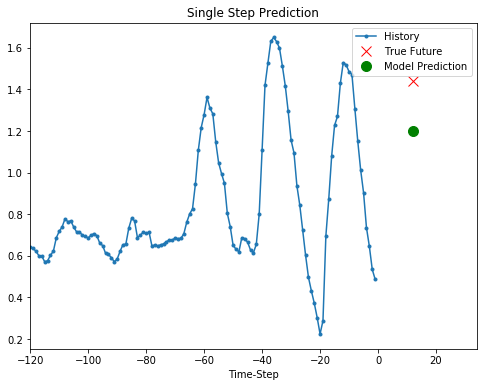

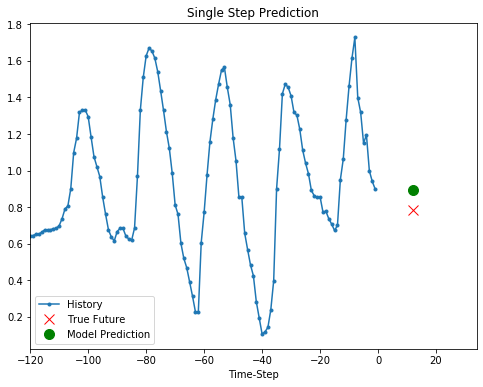

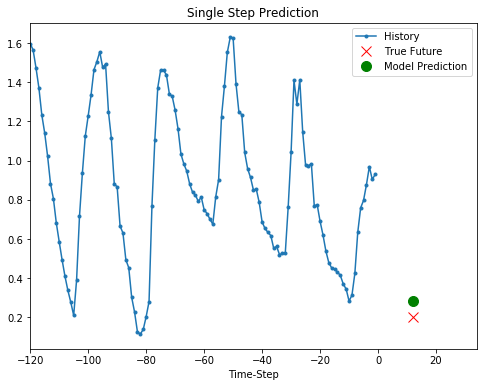

In [25]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [ ]:
%%time

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=10,
    directory='random_search',
    project_name='helloworld_random')

random_tuner.search(x_train_single,
                    y_train_single, 
                    epochs=10, 
                    validation_data=(x_val_single, y_val_single), )

Train on 299280 samples, validate on 119759 samples
Epoch 1/10


 36384/299280 [==>...........................] - ETA: 4:24:52 - loss: 0.6798 - mae: 0.67 - ETA: 45:28 - loss: 0.7709 - mae: 0.7709 - ETA: 25:31 - loss: 0.7676 - mae: 0.76 - ETA: 18:02 - loss: 0.7406 - mae: 0.74 - ETA: 13:31 - loss: 0.7291 - mae: 0.72 - ETA: 11:18 - loss: 0.7084 - mae: 0.70 - ETA: 9:47 - loss: 0.7004 - mae: 0.7004 - ETA: 8:28 - loss: 0.6838 - mae: 0.683 - ETA: 7:40 - loss: 0.6710 - mae: 0.671 - ETA: 6:54 - loss: 0.6552 - mae: 0.655 - ETA: 6:19 - loss: 0.6394 - mae: 0.639 - ETA: 5:50 - loss: 0.6277 - mae: 0.627 - ETA: 5:27 - loss: 0.6151 - mae: 0.615 - ETA: 5:11 - loss: 0.6079 - mae: 0.607 - ETA: 4:56 - loss: 0.5971 - mae: 0.597 - ETA: 4:44 - loss: 0.5867 - mae: 0.586 - ETA: 4:30 - loss: 0.5745 - mae: 0.574 - ETA: 4:21 - loss: 0.5634 - mae: 0.563 - ETA: 4:12 - loss: 0.5551 - mae: 0.555 - ETA: 4:04 - loss: 0.5479 - mae: 0.547 - ETA: 3:56 - loss: 0.5390 - mae: 0.539 - ETA: 3:49 - loss: 0.5326 - mae: 0.532 - ETA: 3:42 - loss: 0.5250 - mae: 0.525 - ETA: 3:37 - loss: 0.5187 -

 73312/299280 [======>.......................] - ETA: 1:33 - loss: 0.3253 - mae: 0.325 - ETA: 1:33 - loss: 0.3252 - mae: 0.325 - ETA: 1:32 - loss: 0.3251 - mae: 0.325 - ETA: 1:32 - loss: 0.3249 - mae: 0.324 - ETA: 1:32 - loss: 0.3246 - mae: 0.324 - ETA: 1:32 - loss: 0.3243 - mae: 0.324 - ETA: 1:32 - loss: 0.3241 - mae: 0.324 - ETA: 1:32 - loss: 0.3237 - mae: 0.323 - ETA: 1:32 - loss: 0.3235 - mae: 0.323 - ETA: 1:32 - loss: 0.3231 - mae: 0.323 - ETA: 1:31 - loss: 0.3230 - mae: 0.323 - ETA: 1:31 - loss: 0.3226 - mae: 0.322 - ETA: 1:31 - loss: 0.3226 - mae: 0.322 - ETA: 1:31 - loss: 0.3224 - mae: 0.322 - ETA: 1:31 - loss: 0.3221 - mae: 0.322 - ETA: 1:31 - loss: 0.3219 - mae: 0.321 - ETA: 1:31 - loss: 0.3217 - mae: 0.321 - ETA: 1:31 - loss: 0.3215 - mae: 0.321 - ETA: 1:31 - loss: 0.3213 - mae: 0.321 - ETA: 1:30 - loss: 0.3211 - mae: 0.321 - ETA: 1:30 - loss: 0.3209 - mae: 0.320 - ETA: 1:30 - loss: 0.3207 - mae: 0.320 - ETA: 1:30 - loss: 0.3204 - mae: 0.320 - ETA: 1:30 - loss: 0.3204 - mae:

110944/299280 [==========>...................] - ETA: 1:15 - loss: 0.2975 - mae: 0.297 - ETA: 1:15 - loss: 0.2975 - mae: 0.297 - ETA: 1:14 - loss: 0.2975 - mae: 0.297 - ETA: 1:14 - loss: 0.2974 - mae: 0.297 - ETA: 1:14 - loss: 0.2973 - mae: 0.297 - ETA: 1:14 - loss: 0.2973 - mae: 0.297 - ETA: 1:14 - loss: 0.2972 - mae: 0.297 - ETA: 1:14 - loss: 0.2972 - mae: 0.297 - ETA: 1:14 - loss: 0.2972 - mae: 0.297 - ETA: 1:14 - loss: 0.2971 - mae: 0.297 - ETA: 1:14 - loss: 0.2970 - mae: 0.297 - ETA: 1:14 - loss: 0.2969 - mae: 0.296 - ETA: 1:14 - loss: 0.2968 - mae: 0.296 - ETA: 1:14 - loss: 0.2969 - mae: 0.296 - ETA: 1:14 - loss: 0.2967 - mae: 0.296 - ETA: 1:13 - loss: 0.2966 - mae: 0.296 - ETA: 1:13 - loss: 0.2965 - mae: 0.296 - ETA: 1:13 - loss: 0.2964 - mae: 0.296 - ETA: 1:13 - loss: 0.2963 - mae: 0.296 - ETA: 1:13 - loss: 0.2962 - mae: 0.296 - ETA: 1:13 - loss: 0.2962 - mae: 0.296 - ETA: 1:13 - loss: 0.2961 - mae: 0.296 - ETA: 1:13 - loss: 0.2960 - mae: 0.296 - ETA: 1:13 - loss: 0.2959 - mae:

150272/299280 [==============>...............] - ETA: 1:00 - loss: 0.2849 - mae: 0.284 - ETA: 1:00 - loss: 0.2849 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2846 - mae: 0.284 - ETA: 59s - loss: 0.2846 - mae: 0.284 - ETA: 59s - loss: 0.2846 - mae: 0.28 - ETA: 59s - loss: 0.2845 - mae: 0.28 - ETA: 59s - loss: 0.2845 - mae: 0.28 - ETA: 59s - loss: 0.2845 - mae: 0.28 - ETA: 59s - loss: 0.2844 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s -

190400/299280 [==================>...........] - ETA: 47s - loss: 0.2774 - mae: 0.27 - ETA: 47s - loss: 0.2774 - mae: 0.27 - ETA: 47s - loss: 0.2774 - mae: 0.27 - ETA: 47s - loss: 0.2773 - mae: 0.27 - ETA: 47s - loss: 0.2773 - mae: 0.27 - ETA: 47s - loss: 0.2773 - mae: 0.27 - ETA: 47s - loss: 0.2773 - mae: 0.27 - ETA: 47s - loss: 0.2772 - mae: 0.27 - ETA: 47s - loss: 0.2772 - mae: 0.27 - ETA: 46s - loss: 0.2772 - mae: 0.27 - ETA: 46s - loss: 0.2771 - mae: 0.27 - ETA: 46s - loss: 0.2771 - mae: 0.27 - ETA: 46s - loss: 0.2771 - mae: 0.27 - ETA: 46s - loss: 0.2771 - mae: 0.27 - ETA: 46s - loss: 0.2770 - mae: 0.27 - ETA: 46s - loss: 0.2770 - mae: 0.27 - ETA: 46s - loss: 0.2769 - mae: 0.27 - ETA: 46s - loss: 0.2769 - mae: 0.27 - ETA: 46s - loss: 0.2768 - mae: 0.27 - ETA: 46s - loss: 0.2768 - mae: 0.27 - ETA: 46s - loss: 0.2767 - mae: 0.27 - ETA: 46s - loss: 0.2767 - mae: 0.27 - ETA: 46s - loss: 0.2767 - mae: 0.27 - ETA: 46s - loss: 0.2767 - mae: 0.27 - ETA: 46s - loss: 0.2767 - mae: 0.27 - E

230304/299280 [======================>.......] - ETA: 34s - loss: 0.2721 - mae: 0.27 - ETA: 34s - loss: 0.2720 - mae: 0.27 - ETA: 34s - loss: 0.2720 - mae: 0.27 - ETA: 34s - loss: 0.2720 - mae: 0.27 - ETA: 34s - loss: 0.2720 - mae: 0.27 - ETA: 34s - loss: 0.2720 - mae: 0.27 - ETA: 34s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2720 - mae: 0.27 - ETA: 33s - loss: 0.2720 - mae: 0.27 - ETA: 33s - loss: 0.2720 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2719 - mae: 0.27 - ETA: 33s - loss: 0.2718 - mae: 0.27 - ETA: 33s - loss: 0.2718 - mae: 0.27 - ETA: 33s - loss: 0.2718 - mae: 0.27 - ETA: 33s - loss: 0.2718 - mae: 0.27 - ETA: 33s - loss: 0.2718 - mae: 0.27 - ETA: 33s - loss: 0.2717 - mae: 0.27 - ETA: 33s - loss: 0.2717 - mae: 0.27 - ETA: 33s - loss: 0.2717 - mae: 0.27 - ETA: 32s - loss: 0.2717 - mae: 0.27 - E

268704/299280 [=========================>....] - ETA: 21s - loss: 0.2681 - mae: 0.26 - ETA: 21s - loss: 0.2680 - mae: 0.26 - ETA: 21s - loss: 0.2680 - mae: 0.26 - ETA: 21s - loss: 0.2680 - mae: 0.26 - ETA: 21s - loss: 0.2680 - mae: 0.26 - ETA: 21s - loss: 0.2679 - mae: 0.26 - ETA: 21s - loss: 0.2679 - mae: 0.26 - ETA: 21s - loss: 0.2679 - mae: 0.26 - ETA: 21s - loss: 0.2679 - mae: 0.26 - ETA: 21s - loss: 0.2678 - mae: 0.26 - ETA: 21s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2678 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2677 - mae: 0.26 - ETA: 20s - loss: 0.2676 - mae: 0.26 - ETA: 20s - loss: 0.2676 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2652 - mae: 0.265 - ETA: 9s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2651 - mae: 0.265 - ETA: 8s - loss: 0.2650 - mae: 0.265 - ETA: 8s - loss: 0.2650 - mae: 0.265 - ETA: 8s - loss: 0.2650 - mae: 0.265 - E

 37312/299280 [==>...........................] - ETA: 1:33 - loss: 0.2685 - mae: 0.268 - ETA: 1:34 - loss: 0.2477 - mae: 0.247 - ETA: 1:33 - loss: 0.2402 - mae: 0.240 - ETA: 1:34 - loss: 0.2333 - mae: 0.233 - ETA: 1:33 - loss: 0.2469 - mae: 0.246 - ETA: 1:32 - loss: 0.2448 - mae: 0.244 - ETA: 1:32 - loss: 0.2454 - mae: 0.245 - ETA: 1:32 - loss: 0.2416 - mae: 0.241 - ETA: 1:33 - loss: 0.2440 - mae: 0.244 - ETA: 1:33 - loss: 0.2454 - mae: 0.245 - ETA: 1:34 - loss: 0.2434 - mae: 0.243 - ETA: 1:34 - loss: 0.2441 - mae: 0.244 - ETA: 1:34 - loss: 0.2424 - mae: 0.242 - ETA: 1:34 - loss: 0.2422 - mae: 0.242 - ETA: 1:34 - loss: 0.2435 - mae: 0.243 - ETA: 1:33 - loss: 0.2432 - mae: 0.243 - ETA: 1:33 - loss: 0.2443 - mae: 0.244 - ETA: 1:33 - loss: 0.2437 - mae: 0.243 - ETA: 1:33 - loss: 0.2442 - mae: 0.244 - ETA: 1:33 - loss: 0.2440 - mae: 0.244 - ETA: 1:33 - loss: 0.2434 - mae: 0.243 - ETA: 1:33 - loss: 0.2430 - mae: 0.243 - ETA: 1:33 - loss: 0.2430 - mae: 0.243 - ETA: 1:33 - loss: 0.2430 - mae:

 74752/299280 [======>.......................] - ETA: 1:20 - loss: 0.2462 - mae: 0.246 - ETA: 1:20 - loss: 0.2461 - mae: 0.246 - ETA: 1:20 - loss: 0.2460 - mae: 0.246 - ETA: 1:20 - loss: 0.2459 - mae: 0.245 - ETA: 1:20 - loss: 0.2459 - mae: 0.245 - ETA: 1:20 - loss: 0.2459 - mae: 0.245 - ETA: 1:20 - loss: 0.2460 - mae: 0.246 - ETA: 1:20 - loss: 0.2460 - mae: 0.246 - ETA: 1:20 - loss: 0.2459 - mae: 0.245 - ETA: 1:20 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2460 - mae: 0.246 - ETA: 1:19 - loss: 0.2460 - mae: 0.246 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2460 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae:

111904/299280 [==========>...................] - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2457 - mae: 0.245 - ETA: 1:08 - loss: 0.2457 - mae: 0.245 - ETA: 1:08 - loss: 0.2457 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:08 - loss: 0.2458 - mae: 0.245 - ETA: 1:07 - loss: 0.2458 - mae: 0.245 - ETA: 1:07 - loss: 0.2459 - mae: 0.245 - ETA: 1:07 - loss: 0.2459 - mae: 0.245 - ETA: 1:07 - loss: 0.2459 - mae: 0.245 - ETA: 1:07 - loss: 0.2459 - mae: 0.245 - ETA: 1:07 - loss: 0.2459 - mae: 0.245 - ETA: 1:07 - loss: 0.2460 - mae:

151008/299280 [==============>...............] - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2453 - mae: 0.24 - ETA: 57s - loss: 0.2453 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2454 - mae: 0.24 - ETA: 57s - loss: 0.2453 - mae: 0.24 - ETA: 57s - loss: 0.2453 - mae: 0.24 - ETA: 56s - loss: 0.2453 - mae: 0.24 - ETA: 56s - loss: 0.2453 - mae: 0.24 - ETA: 56s - loss: 0.2453 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - ETA: 56s - loss: 0.2452 - mae: 0.24 - E

191008/299280 [==================>...........] - ETA: 45s - loss: 0.2446 - mae: 0.24 - ETA: 45s - loss: 0.2446 - mae: 0.24 - ETA: 45s - loss: 0.2446 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2445 - mae: 0.24 - ETA: 45s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2446 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - ETA: 44s - loss: 0.2447 - mae: 0.24 - E

230368/299280 [======================>.......] - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 33s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2442 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 32s - loss: 0.2441 - mae: 0.24 - ETA: 31s - loss: 0.2441 - mae: 0.24 - E

270208/299280 [==========================>...] - ETA: 21s - loss: 0.2437 - mae: 0.24 - ETA: 21s - loss: 0.2437 - mae: 0.24 - ETA: 21s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2438 - mae: 0.24 - ETA: 20s - loss: 0.2438 - mae: 0.24 - ETA: 20s - loss: 0.2438 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 20s - loss: 0.2437 - mae: 0.24 - ETA: 19s - loss: 0.2437 - mae: 0.24 - ETA: 19s - loss: 0.2437 - mae: 0.24 - ETA: 19s - loss: 0.2437 - mae: 0.24 - ETA: 19s - loss: 0.2437 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 8s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - ETA: 7s - loss: 0.2433 - mae: 0.243 - E

 37312/299280 [==>...........................] - ETA: 1:42 - loss: 0.2922 - mae: 0.292 - ETA: 1:39 - loss: 0.2649 - mae: 0.264 - ETA: 1:37 - loss: 0.2533 - mae: 0.253 - ETA: 1:36 - loss: 0.2487 - mae: 0.248 - ETA: 1:36 - loss: 0.2426 - mae: 0.242 - ETA: 1:35 - loss: 0.2425 - mae: 0.242 - ETA: 1:34 - loss: 0.2432 - mae: 0.243 - ETA: 1:35 - loss: 0.2427 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:34 - loss: 0.2408 - mae: 0.240 - ETA: 1:34 - loss: 0.2420 - mae: 0.242 - ETA: 1:34 - loss: 0.2426 - mae: 0.242 - ETA: 1:34 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2434 - mae: 0.243 - ETA: 1:33 - loss: 0.2416 - mae: 0.241 - ETA: 1:33 - loss: 0.2419 - mae: 0.241 - ETA: 1:33 - loss: 0.2407 - mae: 0.240 - ETA: 1:33 - loss: 0.2408 - mae: 0.240 - ETA: 1:33 - loss: 0.2419 - mae: 0.241 - ETA: 1:33 - loss: 0.2417 - mae: 0.241 - ETA: 1:33 - loss: 0.2415 - mae: 0.241 - ETA: 1:32 - loss: 0.2421 - mae: 0.242 - ETA: 1:32 - loss: 0.2413 - mae: 0.241 - ETA: 1:32 - loss: 0.2424 - mae:

 74752/299280 [======>.......................] - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2386 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2385 - mae: 0.238 - ETA: 1:20 - loss: 0.2384 - mae: 0.238 - ETA: 1:20 - loss: 0.2384 - mae: 0.238 - ETA: 1:19 - loss: 0.2384 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2384 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae: 0.238 - ETA: 1:19 - loss: 0.2386 - mae: 0.238 - ETA: 1:19 - loss: 0.2386 - mae: 0.238 - ETA: 1:19 - loss: 0.2387 - mae: 0.238 - ETA: 1:19 - loss: 0.2387 - mae: 0.238 - ETA: 1:19 - loss: 0.2386 - mae: 0.238 - ETA: 1:19 - loss: 0.2385 - mae:

112672/299280 [==========>...................] - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2390 - mae: 0.239 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2388 - mae: 0.238 - ETA: 1:08 - loss: 0.2388 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:08 - loss: 0.2389 - mae: 0.238 - ETA: 1:07 - loss: 0.2389 - mae: 0.238 - ETA: 1:07 - loss: 0.2389 - mae: 0.238 - ETA: 1:07 - loss: 0.2388 - mae: 0.238 - ETA: 1:07 - loss: 0.2389 - mae: 0.238 - ETA: 1:07 - loss: 0.2389 - mae: 0.238 - ETA: 1:07 - loss: 0.2389 - mae:

149696/299280 [==============>...............] - ETA: 57s - loss: 0.2381 - mae: 0.23 - ETA: 57s - loss: 0.2381 - mae: 0.23 - ETA: 57s - loss: 0.2380 - mae: 0.23 - ETA: 57s - loss: 0.2381 - mae: 0.23 - ETA: 57s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2381 - mae: 0.23 - ETA: 56s - loss: 0.2381 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 56s - loss: 0.2381 - mae: 0.23 - ETA: 56s - loss: 0.2381 - mae: 0.23 - ETA: 56s - loss: 0.2381 - mae: 0.23 - ETA: 56s - loss: 0.2380 - mae: 0.23 - ETA: 55s - loss: 0.2380 - mae: 0.23 - ETA: 55s - loss: 0.2380 - mae: 0.23 - E

170688/299280 [================>.............] - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 46s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2382 - mae: 0.23 - ETA: 45s - loss: 0.2382 - mae: 0.23 - ETA: 45s - loss: 0.2382 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - ETA: 45s - loss: 0.2381 - mae: 0.23 - E

# Plot result of random search

In [ ]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


In [ ]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)